In [1]:
import os
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")
import scipy
from shapely.geometry import LineString, Point

In [8]:
import cv2
from scipy import ndimage
from spectral import *

def segmentation(bil, hdr, rotate_crop_params, savepath, lower_pixel_thresh=50, upper_pixel_thresh=3500, band= 255, return_segment = False):
    '''
    =======================================
    == VISION SEGMENTATION OF HYPERCUBE  ==
    =======================================

    Inputs:
        bil:                  Path to the .bil hyperspectral datacube file
        hdr:                  Path to the .hdr hyperspectral datacube file
        rotate_crop_params:   User-defined dictionary of values used to rotate and crop the image. E.g., {'theta': -0.5, 'x1': 45, 'x2': 830, 'y1': 120, 'y2': 550}
        lower_pixel_thresh:   Elements containing fewer than the specified number of pixels will be removed
        upper_pixel_thresh:   Elements containing more than the specified number of pixels will be removed

    Outputs:
        data:                 An array containing the reflectance data extracted from the vision-segmented hyperspectral datacube
    '''

    # load spectral hypercube
    hypercube = envi.open(hdr, bil).load()  # load datacude
    singleband = hypercube[:, :, band]  # grab a single band to use for segmentation
    imshow(singleband)
    plt.title('Single Band')
    plt.show()
    singleband = (singleband / singleband.max() * 255).astype("uint8")
    # plot raw image
    imshow(hypercube, bands=(154, 78, 27))  # R: 154, G: 78, B: 27
    plt.title('Raw Image')
    plt.show()
    # crop/rotate single band
    singleband = ndimage.rotate(singleband, rotate_crop_params['theta'])  # reads image and rotates
    singleband = singleband[rotate_crop_params['y1']:rotate_crop_params['y2'],
                 rotate_crop_params['x1']:rotate_crop_params['x2']]  # crops image
    # crop/rotate hypercube
    hypercube = ndimage.rotate(hypercube, rotate_crop_params['theta'])  # reads image and rotates
    hypercube = hypercube[rotate_crop_params['y1']:rotate_crop_params['y2'],
                rotate_crop_params['x1']:rotate_crop_params['x2']]  # crops image
    # plot cropped image
    imshow(hypercube, bands=(154, 78, 27))  # R: 154, G: 78, B: 27
    plt.title('Cropped Image')
    plt.savefig(savepath+'/raw_image.png', dpi=300, bbox_inches='tight')
    plt.show()
    # transpose to segment along print direction
    singlebandT = ndimage.rotate(singleband, -90)
    hypercubeT = ndimage.rotate(hypercube, -90)
    # segment image with watershed
    watershed, edges = watershed_segment(singlebandT, small_elements_pixels=lower_pixel_thresh,
                                         large_elements_pixels=upper_pixel_thresh)
    # plot segmented image
    fig, ax = plt.subplots()
    ax.imshow(watershed.T, cmap='viridis')
    ax.invert_yaxis()
    plt.title('Segmented Image')
    plt.savefig(savepath+'/segmented_image_2.png', dpi=300, bbox_inches='tight')
    plt.show()
    # extract spectra from segmentation and format data
    idx_min = np.unique(watershed)[1:].min()
    idx_max = np.unique(watershed)[1:].max()
    idx_norms = []
    num_drop = len(np.unique(watershed)[1:])
    idx_ = 1
    for drop in np.unique(watershed)[1:]:  # iterate through all segmented droplets, excluding background=0
        coords = np.argwhere(watershed == drop)
        spectra_all_pixels = []
        pixel_X_coord = []
        pixel_Y_coord = []
        for coord in coords:
            pixel_spectrum = hypercubeT[coord[0], coord[1], :]
            spectra_all_pixels.append(pixel_spectrum)
            pixel_X_coord.append(coord[0])
            pixel_Y_coord.append(coord[1])
        idx_norm = (drop - idx_min) / (idx_max - idx_min)
        idx_norms.append(idx_norm)
        data = pd.DataFrame(np.concatenate(
            (np.array(pd.read_csv('/Users/shengfang/Dropbox (MIT)/Buonassisi-Group/Projects - Active/2023–2026 First Solar/03 Inorganic_Discovery/03_Data/bandgap bowing/HS camera/wavelength.txt', sep='\t', header=None)[0]).reshape(1, -1), np.array(spectra_all_pixels))).T)
        data = data.rename(columns={0: 'wavelength'})
        pixel_coords = pd.DataFrame({'X_coord': pixel_X_coord,'Y_coord': pixel_Y_coord})
        idx = idx_ -1
        idx_ = idx_+1
        data.to_csv(f'{savepath}/pixel_reflectance_{idx}.csv')
        pixel_coords.to_csv(f'{savepath}/pixel_coordinates_{idx}.csv')
        tauc = data.iloc[:, 1:]
        wl = data.iloc[:, 0]

#         plot 
#         fig, ax = plt.subplots(figsize=(8, 4))
#         colormap = mpl.cm.get_cmap('viridis')
#         for i in range(tauc.shape[1]):
#             rgba = colormap(1-idx_norm)
#             ax.plot(wl,tauc.iloc[:,i] / np.max(tauc.iloc[:,i]),c=rgba)  # Normalize each spectrum for visualization
        
#         ax.grid(which='minor', color='gray',linestyle='--', alpha=0.35)
#         ax.grid(which='major', color='gray',linestyle='--', alpha=0.35)
#         ax.set_yticklabels([])
#         plt.xlabel(r'Wavelength, $\lambda$ (nm)')
#         plt.ylabel(r'Reflectance, $R$ (a.u.)')
#         fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=100), cmap=mpl.cm.viridis))
#         plt.title('Extracted Reflectance Spectra')
#         plt.savefig(f'{savepath}/pixel_reflectance_{idx}.png', dpi=300, bbox_inches='tight')
#         plt.show()
    
    if return_segment:
        return data, watershed.T,num_drop
    else:
        return data


# Sub-functions for segmentation()

def segment_on_dt(a, img, threshold):
    '''
    Implements watershed segmentation.

    Inputs:
        a:         Image input
        img:       Threshold binned image
        threshold: RGB threshold value

    Outputs:
        lbl:       Borders of segmented droplets
        wat:       Segmented droplets via watershed
        lab:       Indices of each segmented droplet
    '''
    # estimate the borders of droplets based on known and unknown background + foreground (computed using dilated and erode)
    kernel = np.ones((4, 4), np.uint8)  #default parameter: kernel = np.ones((2, 2), np.uint8)
    border = cv2.dilate(img, None, iterations=1)
#     border = cv2.erode(border, kernel)
    border = border - cv2.erode(border, kernel)
    # segment droplets via distance mapping and thresholding
    dt = cv2.distanceTransform(img, 2, 3)
    dt = ((dt - dt.min()) / (dt.max() - dt.min()) * 255).astype(np.uint8)
    _, dt = cv2.threshold(dt, threshold, 255, cv2.THRESH_BINARY)
#     dt = 255 - dt     ##adjust based on if using contrast enhancing
    # obtain the map of segmented droplets with corresponding indices
    lbl, ncc = ndimage.label(dt)
    lbl = lbl * (255 / (ncc + 1))
    lab = lbl 
    # Completing the markers now.
    lbl[border == 255] = 255
    lbl = lbl.astype(np.int32)
    a = cv2.cvtColor(a,cv2.COLOR_GRAY2BGR)  # we must convert grayscale to BGR because watershed only accepts 3-channel inputs
    wat = cv2.watershed(a, lbl)
    lbl[lbl == -1] = 0
    lbl = lbl.astype(np.uint8)
    return 255 - lbl, wat, lab  # return lab, the segmented and indexed droplets

def watershed_segment(image, small_elements_pixels=0, large_elements_pixels=999999):
    '''
    Applies watershed image segmentation to separate droplet pixels from background pixels.

    Inputs:
        image:                   Input droplet image to segment
        small_elements_pixels:   Removes small elements that contain fewer than the specified number of pixels.
        large_elements_pixels:   Removes large elements that contain more than the specified number of pixels.

    Outputs:
        water:                   Watershed segmented droplets
        labs:                    Edges to each watershed segmented droplet
    '''
    RGB_threshold = 0
    img = image.copy()
    img = 255 - img
    
    img_bin = cv2.GaussianBlur(img,(5,5),0) 
    _,img_bin = cv2.threshold(img_bin,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _, img_bin = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)
                               # threshold image using Otsu's binarization # https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html
    #img_bin = cv2.morphologyEx(img, cv2.MORPH_CLOSE, np.ones((8, 8), dtype=int))
 
    img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_OPEN, np.ones((1, 1), dtype=int))

    img_bin = cv2.erode(img_bin, np.ones((2, 2), np.uint8))
    
    result, water, labs = segment_on_dt(a=img, img=img_bin,
                                        threshold=RGB_threshold)  # segment droplets from background and return indexed droplets
    water = cv2.dilate(water.astype('uint8'), np.ones((4, 4), np.uint8))
    water = cv2.medianBlur(water,5) 
    # remove small/large elements
    uniq_full, uniq_counts = np.unique(water,
                                       return_counts=True)  # get all unique watershed indices with pixel counts
    large_elements = uniq_full[uniq_counts > large_elements_pixels]  # mask large elements based on number of pixels
    small_elements = uniq_full[uniq_counts < small_elements_pixels] # mask small elements based on number of pixels
    for n in range(len(large_elements)):
        water[water == large_elements[n]] = 0  # remove all large elements
    for n in range(len(small_elements)):
        water[water == small_elements[n]] = 0  # remove all small elements
    return water, labs

Computing Experiment 0.1M_AF_D20230914_H2123_BiBrBiI_T150_R_FS. . .


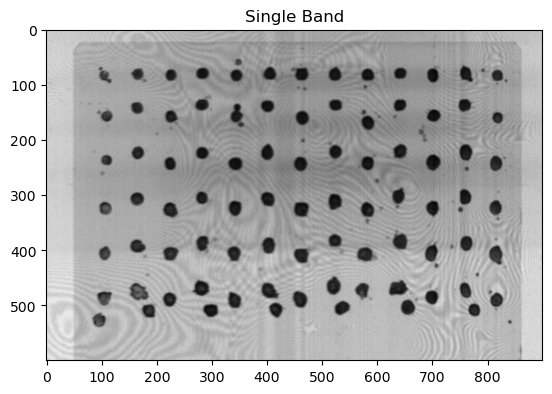

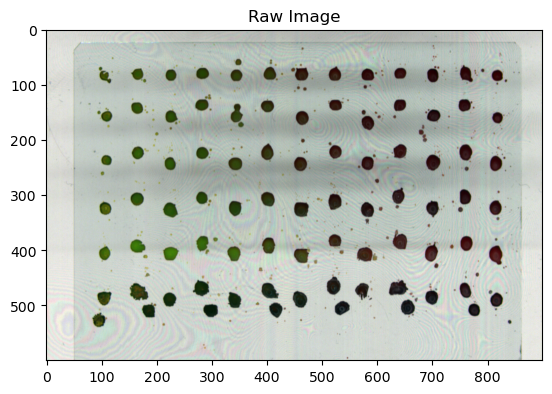

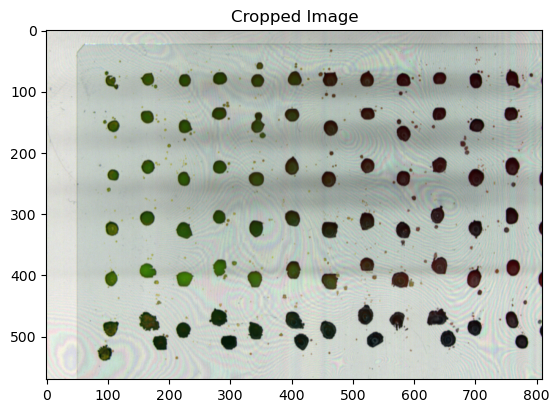

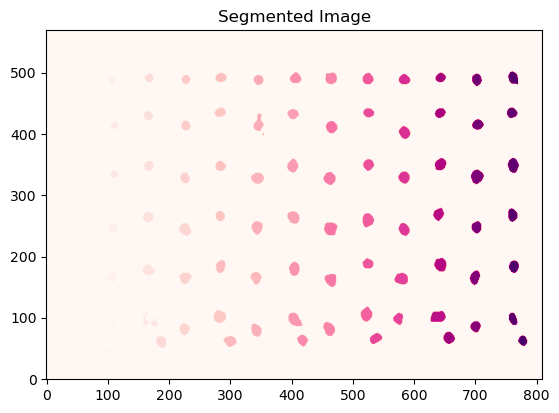

In [9]:
datapath = f'/Users/shengfang/Dropbox (MIT)/Buonassisi-Group/Projects - Active/2023–2026 First Solar/03 Inorganic_Discovery/03_Data/bandgap bowing/HS camera/0.1M_AF_D20230914_BiBrBiI_T150_FS'
savepath = f'/Users/shengfang/Desktop/bandgap bowing/Figures/'
experiments = [
    '0.1M_AF_D20230914_H2123_BiBrBiI_T150_R_FS'
]
for experiment in experiments:
    print(f'Computing Experiment {experiment}. . .')
    
    # read datacubes
    bil = f'{datapath}/{experiment}.bil'
    hdr = f'{datapath}/{experiment}.bil.hdr'
    rotate_crop_params = {'theta': 0, 'x1': 0, 'x2': 810, 'y1': 0, 'y2': 570} # USER DEFINED ROTATE/CROP PARAMETERS
    data, sgmnt,num_drop = segmentation(bil=bil, hdr=hdr, rotate_crop_params=rotate_crop_params, savepath=savepath, return_segment = True)


In [73]:
intensity_scale = 10000
smoothing = 20
for idx in range(num_drop):
    data = pd.read_csv(f'{savepath}/pixel_reflectance_{idx}.csv')
    tauc = data.iloc[:, 2:]  #adjust the range
    wl = data.iloc[:, 1]     #adjust the range
    R = tauc / intensity_scale  # convert from 10,000 percentage points to decimal reflectivity
    k = (1. - R) ** 2  # k=(1-R)^2
    s = 2 * R  # s = 2*R
    F = k / s  # absorpotion coefficient
    ev = 1240. / wl  # calcualte eV from wavelength
    ev.name = 'eV'  # rename column
    tauc = F.mul(ev, axis=0) ** 2.  # calculate tauc
    tauc = pd.concat([ev, tauc], axis=1)  # add ev column back to data
    tauc_smooth_raw = tauc.copy()
    smooth = scipy.signal.savgol_filter(tauc.iloc[:, 1:], window_length=smoothing, polyorder=3,
                                        axis=0)  # savitsky-golay smoothing

    # upsample the number of datapoints from ~100 to 1000
    upsample = 1000  # number of points to upsample to
    f = scipy.interpolate.interp1d(tauc_smooth_raw.iloc[:, 0], smooth, axis=0)
    ev_upsample = np.linspace(np.max(tauc_smooth_raw.iloc[:, 0]), np.min(tauc_smooth_raw.iloc[:, 0]), upsample)
    tauc_smooth_1 = pd.DataFrame(np.hstack([ev_upsample.reshape(upsample, 1), f(ev_upsample)]),
                                 columns=tauc_smooth_raw.columns.values)
    tauc_smooth = tauc_smooth_1.iloc[::-1].reset_index(drop=True)  # sort ascending eV

    display(tauc_smooth)
    np.random.seed(0)
    bandgaps = []  # list of bandgaps for all spectra
    absorption_max = []
    for i in range(tauc_smooth.shape[1] - 1):
        bandgaps_per_tauc = []
        current_tauc = tauc_smooth.iloc[:, i + 1].name  # name of current tauc spectra
        TAUC_X = np.array(tauc_smooth.iloc[:, 0]).reshape(-1, 1)
        TAUC_Y = np.array(tauc_smooth.iloc[:, i + 1]).reshape(-1, 1)
        X0 = [TAUC_X]  # initialize X values
        Y0 = [TAUC_Y]  # initialize Y values
        target_len = len(X0[0])  # target length to stop recursion
        R_tol = 0.995  # R^2 linear regression fit tolerance for line segments
        X_tol = []  # X segments above R_tol
        Y_tol = []  # Y segments above R_tol
        m = []  # list of slopes
        current_len = 0
        # run recursive segmentation
        while current_len < target_len:
            X = []
            Y = []
            for segX, segY in zip(X0, Y0):
                mid = len(segX) // 2
                # left segments
                X_L = segX[:mid + 1]  # left segment
                Y_L = segY[:mid + 1]  # left segment
                model_L = LinearRegression().fit(X_L, Y_L)
                if model_L.score(X_L, Y_L) >= R_tol:
                    X_tol.append(X_L)
                    Y_tol.append(Y_L)
                    m.append(model_L.coef_.item())
                else:
                    X.append(X_L)
                    Y.append(Y_L)
                # right segments
                X_R = segX[mid:]  # right segment
                Y_R = segY[mid:]  # right segment
                model_R = LinearRegression().fit(X_R, Y_R)
                if model_R.score(X_R, Y_R) >= R_tol:
                    X_tol.append(X_R)
                    Y_tol.append(Y_R)
                    m.append(model_R.coef_.item())
                else:
                    X.append(X_R)
                    Y.append(Y_R)
            X0 = X  # reinit
            Y0 = Y  # reinit
            # count num of element in X_tol. When X_tol == target_len, end recrusion.
            current_len = 0
            medians = []  # get list of all medians to sort list of lists later
            for l in X_tol:
                current_len += len(l)
                medians.append(np.median(l))
        # sort lists of lists based on X_tol order
        sort_mask = np.argsort(medians)
        X_tol_sort = np.array(X_tol, dtype=object)[sort_mask]
        Y_tol_sort = np.array(Y_tol, dtype=object)[sort_mask]
        thetas = np.rad2deg(
            np.arctan(np.array(m)[sort_mask]))  # calcualte inclination angles between segment slopes and x-axis

        Delta = []
        for k in range(0, len(X_tol_sort)):
            if X_tol_sort[k][0] > 2.70 :
                break
        upper = k
        for i in range(0, k):
            d = Y_tol_sort[i][len(Y_tol_sort[i])-1] - Y_tol_sort[i][0]
            Delta.append(d)
        Delta = np.array(Delta, dtype = float)
        i0 = np.argmax(Delta)
        delta_max = np.max(Delta)

       
        if i0 == 0:
            Eg = 0.
            bandgaps.append(Eg)
            continue
            
#         if  X_tol_sort[i0][0] < 2.30:
#             Delta [i0] = -float("inf")
#             delta_second_max = np.max(Delta)
#             i0 = np.argmax(Delta)
#         if X_tol_sort[i0][len(X_tol_sort[i0])-1] - X_tol_sort[i0][0] > 0.4 and X_tol_sort[i0][len(X_tol_sort[i0])-1]<3.0:
#             Delta [i0] = -float("inf")
#             delta_second_max = np.max(Delta)
#             i0 = np.argmax(Delta)
#         print(X_tol_sort[i0][0])
    
#         if i0 == 0:
#             edge = 0.
#             absorption_max.append(edge)
#             continue
#         edge = X_tol_sort[i0+1][0]
#         print(edge)
#         absorption_max.append(edge)
        
        base_range = Y_tol_sort[0]
        for i in range(1, i0):
            base_range = np.concatenate((base_range, Y_tol_sort[i]))
        base = np.median(base_range)
        
#         if X_tol_sort[i0][len(X_tol_sort[i0])-1] - X_tol_sort[i0][0] > 0.2:
#         model = LinearRegression().fit(np.vstack([X_tol_sort[i0], X_tol_sort[i0-1]]), np.vstack([Y_tol_sort[i0] - base, Y_tol_sort[i0 -1]- base]))
#             model = LinearRegression().fit(X_tol_sort[i0], (Y_tol_sort[i0] - base))
#         else:
#             model = LinearRegression().fit(np.vstack([X_tol_sort[i0], X_tol_sort[i0-1]]), np.vstack([Y_tol_sort[i0] - base, Y_tol_sort[i0 -1]- base]))
        model = LinearRegression().fit(np.vstack([X_tol_sort[i0+1],X_tol_sort[i0]]), np.vstack([Y_tol_sort[i0+1] - base,Y_tol_sort[i0] - base]))
#         model = LinearRegression().fit(X_tol_sort[i0], (Y_tol_sort[i0] - base))
        y_fit = model.predict(TAUC_X)
        tngt = LineString([(np.min(TAUC_X), np.min(y_fit)), (np.max(TAUC_X), np.max(y_fit))])
        xax = LineString([(np.min(TAUC_X), 0.), (np.max(TAUC_X), 0.)])
        int_pt = tngt.intersection(xax)
        if hasattr(int_pt, 'x'):
            Eg = int_pt.x  # bandgap, if no x-intercept, will throw an error
            bandgaps.append(Eg)
        else:
            Eg = 0.
            bandgaps.append(Eg)
            continue
        print(Eg)
#         fig, ax = plt.subplots(figsize=(3, 2))
#         for n in range(len(X_tol_sort)):
#             ax.scatter(X_tol_sort[n][0], Y_tol_sort[n][0], marker='o', c='#040357', s=30, zorder=15)
#             ax.scatter(X_tol_sort[n][-1], Y_tol_sort[n][-1], marker='o', c='#040357', s=30, zorder=15)
#         ax.plot(TAUC_X, TAUC_Y, c='#040357', lw=2.5, zorder=15)
#         ax.plot(TAUC_X, y_fit+base, c='r', lw=3, alpha=0.75, zorder=20)
#         ax.axvline(Eg, c='#e00000', ls='--', lw=1.5, zorder=5)
#         ax.set_ylim([0, np.max(TAUC_Y)])
#         ax.set_title(f'Material Deposit {current_tauc}')
#         t = ax.text(Eg, np.max(TAUC_Y) * 0.95, f'E$_g$={Eg}eV', c='#e00000', ha='center', va='top',
#                         weight='bold', zorder=10)
#         t.set_bbox(dict(facecolor='w', alpha=0.9, lw=0))
#         ax.set_xlabel(r'$hv$ (eV)')
#         ax.set_ylabel(r'$(F(R)*hv)^2$ (a.u.)')
#         ax.minorticks_on()
#         ax.grid(which='minor', color='gray', linestyle='--', alpha=0.25)
#         ax.grid(which='major', color='gray', linestyle='--', alpha=0.25)
# #                 ax.axvline(TAUC_X[best_lower], c='k', lw=1.5, alpha=0.2,zorder=3)
# #                 ax.axvline(TAUC_X[best_upper], c='k', lw=1.5, alpha=0.2,zorder=3)
#         plt.tick_params(axis='both', labelleft=False)
# #         plt.savefig(f'{savepath}/{idx}_{current_tauc}.png', dpi=300, bbox_inches='tight')
#         verbose = True
#         if verbose:  # plot
#             plt.show()
#             plt.close()
#         else:
#             plt.close()


    EG = pd.DataFrame(bandgaps).T.set_axis(tauc_smooth.columns.values[1:], axis=1)
    EG = EG.set_index(f'bandgap{n}' for n in range(EG.shape[0]))
    EG = EG.iloc[0,:] # select only first row
    pixel_coordinates = pd.read_csv(f'{savepath}/pixel_coordinates_{idx}.csv', index_col=0)
    pixel_coordinates['bandgap'] = EG.values
    pixel_coordinates.to_csv(f'{savepath}/Extracted_Band_Gaps_{idx}.csv')
    plt.close()
#     AM = pd.DataFrame(absorption_max).T.set_axis(tauc_smooth.columns.values[1:], axis=1)
#     AM = AM.set_index(f'absorption_max{n}' for n in range(AM.shape[0]))
#     AM = AM.iloc[0,:] # select only first row
#     pixel_coordinates = pd.read_csv(f'{savepath}/pixel_coordinates_{idx}.csv', index_col=0)
#     pixel_coordinates['absorption_max'] = AM.values
#     pixel_coordinates.to_csv(f'{savepath}/Extracted_Absorption_Max_{idx}.csv')
#     plt.close()

,eV,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,192,193
0,1.216664,3.944264e+05,3.347912e+05,3.136835e+05,2.953077e+05,3.473517e+05,3.107923e+05,2.788889e+05,2.868799e+05,2.748633e+05,...,3.206215e+05,3.891230e+05,4.236609e+05,4.155403e+05,3.821353e+05,3.575518e+05,3.253763e+05,3.608652e+05,4.271548e+05,4.716270e+05
1,1.218537,3.743953e+05,3.276974e+05,3.096815e+05,2.888329e+05,3.431848e+05,3.084355e+05,2.798900e+05,2.805917e+05,2.723372e+05,...,3.215384e+05,3.905288e+05,4.109458e+05,3.923082e+05,3.568839e+05,3.441341e+05,3.193809e+05,3.485197e+05,4.087356e+05,4.534744e+05
2,1.220410,3.571458e+05,3.216549e+05,3.061144e+05,2.830869e+05,3.397561e+05,3.066058e+05,2.808244e+05,2.751296e+05,2.701540e+05,...,3.224631e+05,3.911984e+05,3.998090e+05,3.717785e+05,3.348268e+05,3.321300e+05,3.139653e+05,3.379257e+05,3.924721e+05,4.372079e+05
3,1.222283,3.425830e+05,3.166259e+05,3.029682e+05,2.780484e+05,3.370393e+05,3.052848e+05,2.816947e+05,2.704678e+05,2.683037e+05,...,3.233942e+05,3.911609e+05,3.902008e+05,3.538679e+05,3.158598e+05,3.214960e+05,3.091126e+05,3.290224e+05,3.782963e+05,4.227688e+05
4,1.224156,3.319631e+05,3.130694e+05,3.004429e+05,2.740727e+05,3.353595e+05,3.047054e+05,2.824719e+05,2.669986e+05,2.669521e+05,...,3.243269e+05,3.901143e+05,3.828642e+05,3.398607e+05,3.014598e+05,3.129071e+05,3.051047e+05,3.225928e+05,3.672220e+05,4.110490e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,3.226385e+07,3.169458e+07,3.329275e+07,3.806641e+07,3.458577e+07,3.432135e+07,3.411887e+07,3.858011e+07,3.276954e+07,...,4.961890e+07,5.016083e+07,5.401775e+07,5.085258e+07,5.016447e+07,5.058410e+07,4.891622e+07,5.226887e+07,5.487827e+07,6.438247e+07
996,3.081954,3.234977e+07,3.152002e+07,3.318507e+07,3.815214e+07,3.460045e+07,3.426368e+07,3.391470e+07,3.854594e+07,3.261325e+07,...,4.972686e+07,5.012600e+07,5.433644e+07,5.103967e+07,5.024942e+07,5.055723e+07,4.893542e+07,5.238283e+07,5.482540e+07,6.439511e+07
997,3.083827,3.243569e+07,3.134546e+07,3.307739e+07,3.823787e+07,3.461512e+07,3.420600e+07,3.371052e+07,3.851177e+07,3.245695e+07,...,4.983482e+07,5.009116e+07,5.465513e+07,5.122676e+07,5.033438e+07,5.053036e+07,4.895462e+07,5.249679e+07,5.477253e+07,6.440774e+07
998,3.085700,3.252161e+07,3.117090e+07,3.296970e+07,3.832359e+07,3.462979e+07,3.414832e+07,3.350635e+07,3.847759e+07,3.230065e+07,...,4.994278e+07,5.005633e+07,5.497382e+07,5.141386e+07,5.041933e+07,5.050348e+07,4.897383e+07,5.261074e+07,5.471966e+07,6.442038e+07


2.4525274519020197
2.4535065316504294
2.442972079597411
2.450369915987355
2.4739152108287676
2.470524056303854
2.482268833479643
2.4606630854466194
2.4668210971159303
2.4674904888977727
2.427338716792452
2.443136685223997
2.4439968262665355
2.4487467013610713
2.4631093172177265
2.454235815027081
2.4688115571034586
2.449170360691641
2.4648496860955516
2.4370926423584063
2.4639419723151574
2.462023940333186
2.453466320981433
2.4764064464383853
2.4800781655595046
2.484106546564614
2.4655844705292234
2.479933429506562
2.470370251647228
2.42413292927614
2.3973167820911057
2.464745510853878
2.41258930763017
2.4442586892401295
2.468204901625017
2.474117855355026
2.4808433500089366
2.4752909451874765
2.474979805611368
2.485007332094213
2.4739487273919876
2.4550859548102113
2.443100450023541
2.5033428971818688
2.397993895555437
2.4377430961815545
2.418070051237756
2.425823532496941
2.4708468775339236
2.4144398054477856
2.4833270185573695
2.4689944932016785
2.476617620099283
2.4644257244982755
2

,eV,1,2,3,4,5,6,7,8,9,...,382,383,384,385,386,387,388,389,390,391
0,1.216664,2.070782e+05,2.273795e+05,2.154000e+05,2.044818e+05,2.474949e+05,2.697546e+05,2.842824e+05,2.728670e+05,2.694344e+05,...,2.886422e+05,3.417953e+05,3.527690e+05,3.176316e+05,3.542844e+05,3.403297e+05,3.382090e+05,3.912028e+05,4.110236e+05,3.757208e+05
1,1.218537,2.160634e+05,2.269684e+05,2.199641e+05,2.064899e+05,2.537874e+05,2.687813e+05,2.778552e+05,2.762677e+05,2.732718e+05,...,2.916611e+05,3.369668e+05,3.413343e+05,3.282565e+05,3.535349e+05,3.402837e+05,3.404873e+05,3.802507e+05,3.981482e+05,3.687430e+05
2,1.220410,2.239710e+05,2.267914e+05,2.238592e+05,2.083167e+05,2.590314e+05,2.678766e+05,2.721356e+05,2.788963e+05,2.760206e+05,...,2.944804e+05,3.325682e+05,3.317758e+05,3.374478e+05,3.529641e+05,3.403467e+05,3.426469e+05,3.707181e+05,3.866918e+05,3.631428e+05
3,1.222283,2.308354e+05,2.268390e+05,2.271082e+05,2.099672e+05,2.632659e+05,2.670419e+05,2.671037e+05,2.807823e+05,2.777261e+05,...,2.971058e+05,3.285907e+05,3.240302e+05,3.452546e+05,3.525650e+05,3.405149e+05,3.446907e+05,3.625595e+05,3.766133e+05,3.588678e+05
4,1.224156,2.361537e+05,2.272059e+05,2.294106e+05,2.113517e+05,2.660403e+05,2.663356e+05,2.631084e+05,2.816008e+05,2.779571e+05,...,2.994390e+05,3.252731e+05,3.189505e+05,3.510323e+05,3.524111e+05,3.408372e+05,3.465574e+05,3.564367e+05,3.686080e+05,3.564989e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,2.473455e+07,2.277525e+07,2.071571e+07,1.929122e+07,2.861140e+07,2.770057e+07,2.490311e+07,2.716918e+07,2.922835e+07,...,3.607418e+07,3.464534e+07,3.589697e+07,4.422441e+07,3.824683e+07,4.034263e+07,3.805171e+07,3.977247e+07,3.950627e+07,4.079566e+07
996,3.081954,2.467666e+07,2.270930e+07,2.063702e+07,1.918627e+07,2.859165e+07,2.762984e+07,2.475406e+07,2.715899e+07,2.926814e+07,...,3.617887e+07,3.462660e+07,3.581838e+07,4.435858e+07,3.808581e+07,4.039016e+07,3.799161e+07,3.985283e+07,3.952371e+07,4.072641e+07
997,3.083827,2.461877e+07,2.264336e+07,2.055833e+07,1.908132e+07,2.857191e+07,2.755912e+07,2.460501e+07,2.714881e+07,2.930793e+07,...,3.628355e+07,3.460786e+07,3.573979e+07,4.449275e+07,3.792480e+07,4.043769e+07,3.793151e+07,3.993318e+07,3.954114e+07,4.065716e+07
998,3.085700,2.456088e+07,2.257741e+07,2.047964e+07,1.897636e+07,2.855216e+07,2.748839e+07,2.445596e+07,2.713862e+07,2.934772e+07,...,3.638823e+07,3.458911e+07,3.566120e+07,4.462692e+07,3.776378e+07,4.048522e+07,3.787141e+07,4.001354e+07,3.955858e+07,4.058790e+07


2.461648881126557
2.444609461397478
2.519302808119891
2.4673027665371734
2.4663822489068292
2.473857877989189
2.4309352216686277
2.449438536451488
2.4592614360497325
2.4425830384507097
2.4485166077766403
2.4636582518863936
2.4530029424497277
2.4857970618469167
2.409199680306485
2.4664859609836753
2.432732396767351
2.429026118405871
2.440612738609163
2.43965180638923
2.4649291073824076
2.5139040603715466
2.468379093548487
2.506625184310032
2.5364333373493024
2.5500097438204525
2.4414363478926817
2.4400755358944206
2.440442064313317
2.4450435744548136
2.4470598979295772
2.46007084768217
2.4720740219876722
2.449884317577659
2.480553625801486
2.4690564428576525
2.4583537718386794
2.4620968197273414
2.4653960150642478
2.466697030661536
2.4985276835194465
2.4656500931102383
2.4455600982983445
2.4355914153623344
2.433448671934689
2.442627248092716
2.4396548779816025
2.439975343676348
2.4383552271667583
2.460251690300693
2.4420233382406558
2.4580013667629386
2.4608402505209113
2.44512598360064

,eV,1,2,3,4,5,6,7,8,9,...,445,446,447,448,449,450,451,452,453,454
0,1.216664,1.727311e+05,1.885969e+05,1.770890e+05,1.692009e+05,1.666515e+05,1.916547e+05,1.815653e+05,1.691096e+05,1.669183e+05,...,2.885725e+05,2.558118e+05,2.837250e+05,2.976214e+05,2.878169e+05,3.207387e+05,3.166273e+05,3.135661e+05,2.888149e+05,3.125413e+05
1,1.218537,1.693631e+05,1.872462e+05,1.794307e+05,1.735701e+05,1.668979e+05,1.878063e+05,1.799862e+05,1.697801e+05,1.715956e+05,...,2.860690e+05,2.603400e+05,2.823561e+05,2.980366e+05,2.879523e+05,3.152531e+05,3.113546e+05,3.125780e+05,2.913065e+05,3.092842e+05
2,1.220410,1.666381e+05,1.860118e+05,1.814323e+05,1.775043e+05,1.672443e+05,1.843658e+05,1.786085e+05,1.701929e+05,1.754806e+05,...,2.838533e+05,2.642701e+05,2.811604e+05,2.983527e+05,2.883280e+05,3.107084e+05,3.073086e+05,3.122418e+05,2.940511e+05,3.068443e+05
3,1.222283,1.645341e+05,1.848913e+05,1.831059e+05,1.810146e+05,1.676859e+05,1.813210e+05,1.774259e+05,1.703598e+05,1.786036e+05,...,2.819167e+05,2.676232e+05,2.801340e+05,2.985742e+05,2.889350e+05,3.070701e+05,3.044435e+05,3.125293e+05,2.970318e+05,3.051923e+05
4,1.224156,1.633412e+05,1.839500e+05,1.843010e+05,1.838773e+05,1.682579e+05,1.788665e+05,1.765313e+05,1.701881e+05,1.806310e+05,...,2.803984e+05,2.701360e+05,2.793683e+05,2.986633e+05,2.898760e+05,3.047440e+05,3.032827e+05,3.136897e+05,3.003013e+05,3.046877e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.475120e+07,1.446544e+07,1.448104e+07,1.620953e+07,1.535864e+07,1.406507e+07,1.426736e+07,1.550466e+07,1.487542e+07,...,2.541966e+07,2.805196e+07,2.907271e+07,2.898671e+07,3.020848e+07,2.951515e+07,3.077441e+07,3.424577e+07,3.634723e+07,3.621689e+07
996,3.081954,1.471647e+07,1.443639e+07,1.441594e+07,1.620694e+07,1.530191e+07,1.403639e+07,1.420981e+07,1.549346e+07,1.477492e+07,...,2.548653e+07,2.816859e+07,2.918170e+07,2.903462e+07,3.014702e+07,2.943954e+07,3.065905e+07,3.408599e+07,3.635610e+07,3.616334e+07
997,3.083827,1.468173e+07,1.440734e+07,1.435084e+07,1.620435e+07,1.524518e+07,1.400771e+07,1.415227e+07,1.548226e+07,1.467441e+07,...,2.555339e+07,2.828521e+07,2.929069e+07,2.908254e+07,3.008556e+07,2.936392e+07,3.054368e+07,3.392621e+07,3.636498e+07,3.610978e+07
998,3.085700,1.464700e+07,1.437829e+07,1.428574e+07,1.620175e+07,1.518846e+07,1.397903e+07,1.409473e+07,1.547106e+07,1.457391e+07,...,2.562025e+07,2.840184e+07,2.939968e+07,2.913045e+07,3.002411e+07,2.928831e+07,3.042831e+07,3.376643e+07,3.637386e+07,3.605623e+07


2.5110351456734614
2.4830732180536543
2.485136375110402
2.4696219300401836
2.442805645781704
2.493117176277278
2.5566248231900985
2.4806053857674684
2.4813884341769397
2.459546695117139
2.4678625504803
2.543758621099496
2.5096821788592436
2.5132477575413747
2.4931456736103232
2.5451801872957662
2.5110816153283517
2.462556324586357
2.4470202637966905
2.4402401290402733
2.4672243109835503
2.50314434144221
2.4607041127413725
2.4191006950126464
2.4551060998682344
2.456377747110682
2.4600258771278987
2.420768981486154
2.409600249962543
2.472834946182496
2.518443725054335
2.480245897339908
2.42265920875969
2.436212911984857
2.426666653549286
2.456348009106583
2.4206292846131108
2.4619936060876135
2.466033915551208
2.454099789066197
2.4341405290661293
2.4588340817144623
2.471785942690622
2.494324335226293
2.453015382103764
2.4713895997500663
2.4690100725135427
2.493426651552303
2.4264455269453133
2.464348914435273
2.4608076764057034
2.437697977433835
2.430985942246438
2.45107276906454
2.41965

2.404617168926383
2.429342472658785
2.4344333550991104
2.42986686615722
2.488429840672569
2.4562669554273806
2.4417025564396058
2.4766237796898913
2.449924792115537


,eV,1,2,3,4,5,6,7,8,9,...,425,426,427,428,429,430,431,432,433,434
0,1.216664,2.109106e+05,2.024681e+05,2.128718e+05,1.970106e+05,1.872730e+05,1.857426e+05,2.088247e+05,2.218388e+05,2.159620e+05,...,2.164635e+05,2.276400e+05,2.418910e+05,2.359366e+05,1.980675e+05,2.354327e+05,2.728972e+05,2.650501e+05,2.452073e+05,2.535583e+05
1,1.218537,2.091272e+05,2.032527e+05,2.090895e+05,1.970176e+05,1.960760e+05,1.943113e+05,2.116785e+05,2.262978e+05,2.196108e+05,...,2.187206e+05,2.249945e+05,2.341660e+05,2.311674e+05,2.015766e+05,2.319453e+05,2.643281e+05,2.695493e+05,2.536563e+05,2.619571e+05
2,1.220410,2.076364e+05,2.038921e+05,2.058540e+05,1.968915e+05,2.035940e+05,2.017782e+05,2.139532e+05,2.295657e+05,2.223951e+05,...,2.208616e+05,2.228918e+05,2.274892e+05,2.270070e+05,2.049052e+05,2.290730e+05,2.569363e+05,2.739104e+05,2.614299e+05,2.695662e+05
3,1.222283,2.064272e+05,2.043923e+05,2.031468e+05,1.966403e+05,2.098713e+05,2.081804e+05,2.156728e+05,2.316917e+05,2.243503e+05,...,2.228872e+05,2.213111e+05,2.218272e+05,2.234355e+05,2.080550e+05,2.267939e+05,2.506834e+05,2.781328e+05,2.685453e+05,2.764078e+05
4,1.224156,2.056241e+05,2.046958e+05,2.012168e+05,1.962301e+05,2.143321e+05,2.130166e+05,2.166066e+05,2.322034e+05,2.251282e+05,...,2.247221e+05,2.204791e+05,2.176684e+05,2.207330e+05,2.109114e+05,2.253785e+05,2.461128e+05,2.821158e+05,2.746536e+05,2.820924e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.736576e+07,1.705267e+07,1.769834e+07,1.962344e+07,1.852790e+07,2.010959e+07,1.999201e+07,1.975167e+07,1.785803e+07,...,2.357173e+07,2.405950e+07,2.374154e+07,2.691016e+07,2.873913e+07,3.042291e+07,3.086788e+07,3.511177e+07,3.843764e+07,4.193082e+07
996,3.081954,1.734844e+07,1.704234e+07,1.773593e+07,1.959896e+07,1.841764e+07,2.009449e+07,1.991194e+07,1.967768e+07,1.777604e+07,...,2.359675e+07,2.409976e+07,2.376436e+07,2.702534e+07,2.872234e+07,3.047049e+07,3.077105e+07,3.485811e+07,3.824790e+07,4.177905e+07
997,3.083827,1.733111e+07,1.703202e+07,1.777352e+07,1.957448e+07,1.830738e+07,2.007939e+07,1.983187e+07,1.960369e+07,1.769404e+07,...,2.362176e+07,2.414002e+07,2.378719e+07,2.714052e+07,2.870555e+07,3.051806e+07,3.067422e+07,3.460445e+07,3.805816e+07,4.162729e+07
998,3.085700,1.731379e+07,1.702169e+07,1.781111e+07,1.955000e+07,1.819711e+07,2.006429e+07,1.975181e+07,1.952970e+07,1.761204e+07,...,2.364678e+07,2.418029e+07,2.381001e+07,2.725570e+07,2.868877e+07,3.056563e+07,3.057739e+07,3.435079e+07,3.786842e+07,4.147552e+07


2.4811614671104567
2.4679092831354708
2.460233199769523
2.4321768417475838
2.4394391411655496
2.4271396522450646
2.4918175504705733
2.4616192087421966
2.457302438003683
2.427650448533405
2.437076988996094
2.437175256242931
2.443412839890265
2.512787629968563
2.503180638240792
2.4417740599313196
2.4553305045720433
2.451698852899269
2.446916195673106
2.4792970911701318
2.4829973875104474
2.458698219420659
2.453616082417998
2.512029282229841
2.4829349563064347
2.469314699551655
2.5021060274646523
2.5241708196112453
2.4450308302346158
2.5014528373287788
2.4935244969517534
2.468211881453735
2.485000449568873
2.4638162605677714
2.4513229962747753
2.388356713042465
2.4069847707934655
2.4400720014694057
2.4183660279508317
2.4986578628361817
2.434104760107913
2.440156576915095
2.446220152929212
2.5216744325015084
2.5065500514505006
2.5352239608178087
2.5076894698851007
2.4575585153997688
2.3921184588984414
2.4391674295775303
2.4373065871634547
2.4755180997564357
2.433232948597462
2.442214859546

,eV,1,2,3,4,5,6,7,8,9,...,479,480,481,482,483,484,485,486,487,488
0,1.216664,1.449488e+05,1.633520e+05,1.495433e+05,1.707967e+05,1.695360e+05,1.668761e+05,1.576699e+05,1.625214e+05,1.441416e+05,...,2.234873e+05,2.134955e+05,2.365071e+05,2.359598e+05,2.186183e+05,1.905433e+05,2.128906e+05,2.196154e+05,2.280060e+05,2.409389e+05
1,1.218537,1.478622e+05,1.628858e+05,1.518393e+05,1.706731e+05,1.710034e+05,1.664499e+05,1.605919e+05,1.619296e+05,1.445224e+05,...,2.263250e+05,2.180234e+05,2.351723e+05,2.357750e+05,2.209331e+05,2.020300e+05,2.179752e+05,2.217831e+05,2.274756e+05,2.393603e+05
2,1.220410,1.502202e+05,1.621866e+05,1.537779e+05,1.703445e+05,1.719783e+05,1.659570e+05,1.628587e+05,1.611393e+05,1.447549e+05,...,2.288506e+05,2.221591e+05,2.341735e+05,2.355766e+05,2.233239e+05,2.124464e+05,2.225767e+05,2.237715e+05,2.273696e+05,2.384964e+05
3,1.222283,1.520442e+05,1.612665e+05,1.553723e+05,1.698210e+05,1.724820e+05,1.654016e+05,1.644960e+05,1.601611e+05,1.448463e+05,...,2.310726e+05,2.259125e+05,2.334982e+05,2.353668e+05,2.257831e+05,2.218203e+05,2.267085e+05,2.255858e+05,2.276709e+05,2.383167e+05
4,1.224156,1.531017e+05,1.600516e+05,1.564682e+05,1.690331e+05,1.723247e+05,1.647691e+05,1.652338e+05,1.589333e+05,1.447442e+05,...,2.328353e+05,2.290793e+05,2.332921e+05,2.351504e+05,2.283081e+05,2.296054e+05,2.301276e+05,2.271388e+05,2.285510e+05,2.390985e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.219347e+07,1.240682e+07,1.392517e+07,1.474448e+07,1.359694e+07,1.399268e+07,1.205922e+07,1.201091e+07,1.110841e+07,...,2.378617e+07,2.590323e+07,2.626963e+07,2.747144e+07,2.646154e+07,2.849088e+07,2.569117e+07,2.461808e+07,2.587815e+07,2.914733e+07
996,3.081954,1.223811e+07,1.244687e+07,1.393603e+07,1.475456e+07,1.354202e+07,1.403486e+07,1.204422e+07,1.198986e+07,1.112926e+07,...,2.379276e+07,2.593607e+07,2.632735e+07,2.747090e+07,2.638938e+07,2.851087e+07,2.559969e+07,2.453160e+07,2.585724e+07,2.904514e+07
997,3.083827,1.228275e+07,1.248692e+07,1.394690e+07,1.476465e+07,1.348710e+07,1.407704e+07,1.202922e+07,1.196881e+07,1.115010e+07,...,2.379935e+07,2.596892e+07,2.638506e+07,2.747035e+07,2.631722e+07,2.853086e+07,2.550821e+07,2.444512e+07,2.583634e+07,2.894296e+07
998,3.085700,1.232739e+07,1.252697e+07,1.395776e+07,1.477474e+07,1.343217e+07,1.411922e+07,1.201423e+07,1.194776e+07,1.117095e+07,...,2.380595e+07,2.600177e+07,2.644278e+07,2.746980e+07,2.624507e+07,2.855084e+07,2.541673e+07,2.435864e+07,2.581543e+07,2.884077e+07


2.4129341550111896
2.4496843710710148
2.4620150944721835
2.463248224598466
2.446564230224706
2.466186766211087
2.4494495936007223
2.462424095611968
2.451779300270137
2.4679257549960036
2.5003076855640036
2.5026225212981505
2.535216021869194
2.5269167669524695
2.4607987990398748
2.4734329907688997
2.5244112582697222
2.5376974960611896
2.5184346325512994
2.4661229787310823
2.4313463879670323
2.465671943240402
2.5231071901388487
2.465098238224841
2.4696339243071344
2.447187712792244
2.4595878719304625
2.4984686988481903
2.4631029950433296
2.5177697461205493
2.5098506838931276
2.499379080071953
2.505442266612999
2.4726777065489935
2.532059687574117
2.460836194333905
2.4778588589187303
2.451777535353719
2.46430552238678
2.4572176609657244
2.4577218526722264
2.4287474716161586
2.4593513808060323
2.4661215289101537
2.516073400663924
2.417986904886578
2.4717515439398974
2.442120935478294
2.445124688095501
2.4531736665050508
2.454016023754991
2.474207498724276
2.3706099368657156
2.4580317966346

2.493471785370218
2.4467362817252964
2.4509020229501917
2.4827985301492275
2.4513833615434883
2.4504790636341562
2.4374202154814437
2.4741856930438253
2.4737539886819846
2.4440626935848613
2.448537663481604
2.4755954113746306
2.455284109826811
2.4679481577778075
2.4414289761601564
2.4573498515673733
2.422599641194907
2.44045583655342
2.4409520912774187
2.4682625047959084
2.4316897597382154
2.4618956186591094
2.4361789677048935
2.463390343313212
2.4662491185363353
2.467999881712163
2.4516771411790415
2.439039172299945
2.459544149011391
2.4853074384110885
2.4664340195534074
2.4358930346841374
2.460823971859533
2.456822051845525
2.512756583756842
2.4896690939598742
2.4956922336876195
2.455280339016712
2.4748915098933058
2.490191479733172
2.5346105177838707
2.5369178316313663


,eV,1,2,3,4,5,6,7,8,9,...,996,997,998,999,1000,1001,1002,1003,1004,1005
0,1.216664,1.426419e+05,1.531731e+05,1.582875e+05,1.432075e+05,1.418885e+05,1.333269e+05,1.332990e+05,1.521210e+05,1.653330e+05,...,2.971418e+05,2.922122e+05,3.442521e+05,3.778252e+05,3.241506e+05,3.265686e+05,3.792586e+05,3.824579e+05,3.020463e+05,3.570122e+05
1,1.218537,1.443596e+05,1.521287e+05,1.567899e+05,1.440840e+05,1.430763e+05,1.361221e+05,1.361847e+05,1.538280e+05,1.676410e+05,...,2.943624e+05,2.895699e+05,3.347379e+05,3.695205e+05,3.184477e+05,3.254659e+05,3.683314e+05,3.730841e+05,3.049769e+05,3.579196e+05
2,1.220410,1.458499e+05,1.512907e+05,1.555451e+05,1.446049e+05,1.438762e+05,1.384013e+05,1.386035e+05,1.550527e+05,1.693291e+05,...,2.920774e+05,2.874524e+05,3.267954e+05,3.623988e+05,3.134012e+05,3.245690e+05,3.587475e+05,3.651827e+05,3.079277e+05,3.588905e+05
3,1.222283,1.471198e+05,1.506509e+05,1.545443e+05,1.447852e+05,1.443048e+05,1.401843e+05,1.405723e+05,1.558146e+05,1.704217e+05,...,2.902694e+05,2.858421e+05,3.203706e+05,3.564212e+05,3.089906e+05,3.238698e+05,3.504639e+05,3.587024e+05,3.108954e+05,3.599216e+05
4,1.224156,1.480600e+05,1.502949e+05,1.538991e+05,1.444871e+05,1.442123e+05,1.412524e+05,1.418861e+05,1.559183e+05,1.706627e+05,...,2.891559e+05,2.849792e+05,3.161712e+05,3.521324e+05,3.055265e+05,3.234536e+05,3.441081e+05,3.543021e+05,3.138683e+05,3.610323e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.026897e+07,1.107425e+07,1.176929e+07,1.039135e+07,1.087028e+07,1.063549e+07,1.123674e+07,1.123931e+07,1.305237e+07,...,1.394767e+07,1.391857e+07,1.623868e+07,1.715846e+07,1.616588e+07,1.758961e+07,1.775090e+07,1.923331e+07,2.008943e+07,2.128698e+07
996,3.081954,1.025619e+07,1.104663e+07,1.176687e+07,1.038170e+07,1.088108e+07,1.061235e+07,1.125496e+07,1.121960e+07,1.310863e+07,...,1.391359e+07,1.385284e+07,1.622342e+07,1.714360e+07,1.621885e+07,1.767087e+07,1.774985e+07,1.928472e+07,2.020164e+07,2.130624e+07
997,3.083827,1.024341e+07,1.101902e+07,1.176444e+07,1.037205e+07,1.089188e+07,1.058922e+07,1.127318e+07,1.119988e+07,1.316488e+07,...,1.387951e+07,1.378711e+07,1.620815e+07,1.712874e+07,1.627182e+07,1.775212e+07,1.774881e+07,1.933614e+07,2.031386e+07,2.132551e+07
998,3.085700,1.023063e+07,1.099140e+07,1.176201e+07,1.036241e+07,1.090268e+07,1.056609e+07,1.129140e+07,1.118016e+07,1.322113e+07,...,1.384543e+07,1.372139e+07,1.619289e+07,1.711388e+07,1.632480e+07,1.783337e+07,1.774777e+07,1.938756e+07,2.042607e+07,2.134477e+07


2.542182209761963
2.5341013784474056
2.544767197948671
2.5296273804073928
2.4344438124875416
2.4713490743456497
2.481343703695422
2.4953474991729956
2.599315790161725
2.4626651453746207
2.4455869015224487
2.4612067558857595
2.496886200723628
2.5464157597907633
2.532009658289834
2.5299830901924265
2.479244887600759
2.45602957800398
2.428252428322976
2.439414221085615
2.4733182710268546
2.4570322758468612
2.478797008007113
2.4954171588926526
2.454675247123578
2.477340961727987
2.4815550532528916
2.463434840607524
2.4804874566298536
2.541795893315313
2.5035251872269724
2.4608406821127216
2.467261152775836
2.4530898176623643
2.4340998010438066
2.4629637235947954
2.436358841899648
2.4639390043875746
2.520338908546717
2.5470743012068526
2.47700709548522
2.476335889483183
2.471041404205444
2.5339461490504425
2.5267661807023
2.4933248651530264
2.4408705360516096
2.4532199780355772
2.468424189045611
2.4498049886008877
2.44668236129515
2.4817394458757405
2.533104700664604
2.4276711719280546
2.45

2.4444512129855864
2.4717664882958443
2.429324671026481
2.4555209015223003
2.477238029269932
2.4791099549501316
2.4611175922833617
2.4773846937227977
2.4680417396499847
2.4362779125756897
2.4403961033626747
2.4584026767089098
2.501747607650097
2.480224362957885
2.4824958442022176
2.4766522779516094
2.5060818516653294
2.5359817938964886
2.4600546516452457
2.4635110213171334
2.4712210021579195
2.538599619400676
2.4722784291454807
2.479068573643528
2.471803303678653
2.4539428724070094
2.5578109346221676
2.4925847056676176
2.4264843576817503
2.4357801697415513
2.477954344820803
2.4385846666442377
2.431357743900501
2.4659511234093006
2.4779655891715517
2.47636800486246
2.4783288440994826
2.4801797744378673
2.4754464264099747
2.4624770101718196
2.480406898612051
2.4729019140481574
2.449586010004508
2.4608920681566415
2.436716005388152
2.4515954289080697
2.4393770177089276
2.439714593324766
2.460303532866948
2.437716304179008
2.4760403317881376
2.4429114613728977
2.5704153804605645
2.44837755

2.433528518212701
2.4539781759838837
2.4693357590239566
2.3982165111836746
2.422368245822226
2.4543603327108645
2.4821812233315725
2.4873100206329433
2.4892468896920574
2.4792306149547545
2.4748470414201544
2.4707157723524604
2.4641163728445803
2.485901941275189
2.480098345691629
2.5129762090659624
2.4874459663307524
2.472611777841628
2.458577503755367
2.4623903173788952
2.459273111145125
2.454777233832182
2.572325660753783
2.5548140379120245
2.448861542178103
2.480184272092476
2.5399996389355386
2.475105551246163
2.4694737033000482
2.473051886917485
2.478917579617155
2.473675672681105
2.4199260055034006
2.474347420175371
2.464059015530886
2.462877554831134
2.4709694846135832
2.4813724320223702
2.496186119649777
2.456296371682292
2.4543690142925794
2.4596221494896646
2.466564210466112
2.4866413675677728
2.442693837488669
2.4797142659599967
2.4913316943433883
2.455491571013699
2.4819562045434687
2.4799037837819715
2.469748425914901
2.481945813584513
2.4965841714517545
2.476039661650033


,eV,1,2,3,4,5,6,7,8,9,...,405,406,407,408,409,410,411,412,413,414
0,1.216664,2.021781e+05,1.879016e+05,1.929457e+05,1.863961e+05,1.936499e+05,1.869777e+05,1.884164e+05,1.870641e+05,1.853601e+05,...,2.919395e+05,2.715085e+05,2.632360e+05,2.648456e+05,2.520523e+05,2.987269e+05,3.182882e+05,3.022528e+05,3.303938e+05,3.415877e+05
1,1.218537,1.999656e+05,1.896527e+05,1.926870e+05,1.872372e+05,1.934846e+05,1.899654e+05,1.924924e+05,1.892637e+05,1.913869e+05,...,3.066838e+05,2.743677e+05,2.678698e+05,2.717815e+05,2.610996e+05,2.967216e+05,3.132080e+05,3.019850e+05,3.284502e+05,3.390248e+05
2,1.220410,1.977465e+05,1.909269e+05,1.921292e+05,1.878629e+05,1.933534e+05,1.927023e+05,1.960267e+05,1.912854e+05,1.965555e+05,...,3.198623e+05,2.770061e+05,2.719458e+05,2.777653e+05,2.690147e+05,2.950259e+05,3.085379e+05,3.019976e+05,3.269059e+05,3.372785e+05
3,1.222283,1.955254e+05,1.917441e+05,1.912870e+05,1.882816e+05,1.932549e+05,1.951947e+05,1.990369e+05,1.931338e+05,2.008948e+05,...,3.315223e+05,2.794290e+05,2.754835e+05,2.828299e+05,2.758357e+05,2.936298e+05,3.042684e+05,3.022770e+05,3.257459e+05,3.363154e+05
4,1.224156,1.933331e+05,1.919168e+05,1.900598e+05,1.884036e+05,1.932027e+05,1.973121e+05,2.012720e+05,1.947197e+05,2.040130e+05,...,3.409125e+05,2.815190e+05,2.782353e+05,2.865497e+05,2.810465e+05,2.926756e+05,3.006189e+05,3.029206e+05,3.251398e+05,3.364628e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.567526e+07,1.658203e+07,1.526984e+07,1.717279e+07,1.781668e+07,1.795306e+07,2.051048e+07,1.894508e+07,1.850513e+07,...,3.554516e+07,2.930368e+07,3.122204e+07,2.903164e+07,2.961380e+07,2.622282e+07,2.798831e+07,2.911537e+07,2.937443e+07,3.045406e+07
996,3.081954,1.570114e+07,1.660988e+07,1.530164e+07,1.718248e+07,1.778613e+07,1.788893e+07,2.055323e+07,1.894073e+07,1.846216e+07,...,3.556534e+07,2.943121e+07,3.144856e+07,2.920227e+07,2.984317e+07,2.621989e+07,2.804026e+07,2.908170e+07,2.933744e+07,3.045902e+07
997,3.083827,1.572701e+07,1.663773e+07,1.533344e+07,1.719218e+07,1.775558e+07,1.782481e+07,2.059598e+07,1.893639e+07,1.841919e+07,...,3.558553e+07,2.955874e+07,3.167509e+07,2.937291e+07,3.007253e+07,2.621696e+07,2.809221e+07,2.904803e+07,2.930045e+07,3.046398e+07
998,3.085700,1.575288e+07,1.666558e+07,1.536523e+07,1.720188e+07,1.772503e+07,1.776068e+07,2.063873e+07,1.893204e+07,1.837623e+07,...,3.560571e+07,2.968627e+07,3.190162e+07,2.954354e+07,3.030190e+07,2.621403e+07,2.814416e+07,2.901436e+07,2.926346e+07,3.046894e+07


2.4876331180552107
2.419048166365607
2.471789521093244
2.485807246832396
2.458742182551905
2.4535105973698155
2.52892208995556
2.4640022465000406
2.4852219161024554
2.4785352307860506
2.4824010166784842
2.4662510743659944
2.4344525957168006
2.435087645771253
2.442185287828827
2.4291943782915184
2.4520869763726822
2.4724603152310016
2.422963206725311
2.438729983742001
2.4191041824931863
2.462749153289653
2.4298746346601736
2.463615034052903
2.491696238555536
2.4166119410126568
2.4139477246451695
2.4327542376428717
2.4368504456500153
2.452779459740375
2.488695539177531
2.4523960814483834
2.450818384440864
2.4700259965309894
2.4753226448711274
2.4721636342674027
2.4024341794510704
2.4606254395469698
2.4650310064193586
2.46443109546855
2.4545375935939613
2.5192873351253637
2.458296390583847
2.471168355539941
2.4535225545088224
2.515020570554097
2.4328294211759864
2.4206251377161974
2.421101786193353
2.4348493047153683
2.4483010710471236
2.4573275189420394
2.5309914846493933
2.4319660489066

,eV,1,2,3,4,5,6,7,8,9,...,424,425,426,427,428,429,430,431,432,433
0,1.216664,2.201702e+05,2.062780e+05,1.916696e+05,1.711925e+05,1.708844e+05,1.944401e+05,2.195417e+05,2.135621e+05,2.283881e+05,...,2.567485e+05,2.398189e+05,2.785393e+05,2.764707e+05,2.633657e+05,2.623751e+05,2.645974e+05,2.866358e+05,3.155099e+05,3.274601e+05
1,1.218537,2.094594e+05,1.955801e+05,1.853856e+05,1.667569e+05,1.635635e+05,1.942299e+05,2.131334e+05,2.091880e+05,2.277388e+05,...,2.498338e+05,2.352007e+05,2.709718e+05,2.710391e+05,2.588484e+05,2.584757e+05,2.641088e+05,2.840409e+05,3.079257e+05,3.206882e+05
2,1.220410,2.000251e+05,1.862628e+05,1.797230e+05,1.628516e+05,1.570961e+05,1.938547e+05,2.074926e+05,2.054076e+05,2.270442e+05,...,2.436606e+05,2.311827e+05,2.642087e+05,2.660811e+05,2.549925e+05,2.551213e+05,2.636076e+05,2.816610e+05,3.011831e+05,3.148032e+05
3,1.222283,1.918270e+05,1.782814e+05,1.746637e+05,1.594593e+05,1.514554e+05,1.933223e+05,2.025950e+05,2.022023e+05,2.263070e+05,...,2.382060e+05,2.277462e+05,2.582253e+05,2.615846e+05,2.517744e+05,2.522927e+05,2.630942e+05,2.794899e+05,2.952578e+05,3.097757e+05
4,1.224156,1.854659e+05,1.722761e+05,1.705111e+05,1.568265e+05,1.470424e+05,1.925756e+05,1.988019e+05,1.998518e+05,2.255162e+05,...,2.338219e+05,2.251748e+05,2.534052e+05,2.577921e+05,2.494829e+05,2.502318e+05,2.625620e+05,2.776307e+05,2.905612e+05,3.060116e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.220680e+07,1.131047e+07,1.077949e+07,9.752970e+06,8.201921e+06,1.351434e+07,1.422024e+07,1.585716e+07,1.420229e+07,...,1.837914e+07,1.871315e+07,1.984284e+07,1.968722e+07,2.049073e+07,2.112309e+07,2.470563e+07,2.579409e+07,2.821768e+07,2.845725e+07
996,3.081954,1.218303e+07,1.127086e+07,1.077455e+07,9.745636e+06,8.191299e+06,1.343186e+07,1.419502e+07,1.581837e+07,1.411237e+07,...,1.843054e+07,1.864901e+07,1.972961e+07,1.953176e+07,2.034731e+07,2.085331e+07,2.460057e+07,2.584023e+07,2.818709e+07,2.829207e+07
997,3.083827,1.215925e+07,1.123126e+07,1.076961e+07,9.738302e+06,8.180677e+06,1.334939e+07,1.416981e+07,1.577959e+07,1.402245e+07,...,1.848195e+07,1.858486e+07,1.961637e+07,1.937631e+07,2.020388e+07,2.058352e+07,2.449552e+07,2.588638e+07,2.815651e+07,2.812689e+07
998,3.085700,1.213548e+07,1.119166e+07,1.076468e+07,9.730968e+06,8.170055e+06,1.326691e+07,1.414459e+07,1.574080e+07,1.393254e+07,...,1.853336e+07,1.852072e+07,1.950313e+07,1.922085e+07,2.006045e+07,2.031374e+07,2.439047e+07,2.593252e+07,2.812592e+07,2.796170e+07


2.52868287003186
2.5222228853985165
2.5275682015914227
2.5401258959549193
2.531789936681218
2.470872651772538
2.454596946143192
2.4858534602476556
2.4748736078416336
2.415094526854526
2.472231006598652
2.4953636096839915
2.453863425871364
2.516526735022724
2.459506016325724
2.480756349730668
2.4972580702932548
2.441250615428449
2.442849073045797
2.4629189845943937
2.4725476104289803
2.4973537122344056
2.4566327628687556
2.450835044887017
2.463070218414996
2.4944542996973436
2.464619924649538
2.516784597035262
2.4807625236747888
2.494061195073476
2.482024808066658
2.509447454229264
2.5116967373493413
2.440730553853977
2.451218789181334
2.4901588533419363
2.467638947218539
2.4322133651357185
2.4539775061413436
2.4336684001242865
2.425225228944034
2.463464222612059
2.483274267394735
2.4787741617994614
2.4840428382072353
2.459820250146334
2.437214718257602
2.451111037818613
2.4343050024680077
2.4559493143115105
2.468031445189676
2.433680089492072
2.4511132588687823
2.422341839547107
2.4324

,eV,1,2,3,4,5,6,7,8,9,...,417,418,419,420,421,422,423,424,425,426
0,1.216664,2.070862e+05,2.125754e+05,2.044055e+05,2.109089e+05,1.833526e+05,2.391044e+05,2.570707e+05,2.576811e+05,2.554388e+05,...,2.088907e+05,2.218263e+05,2.178005e+05,2.643847e+05,3.028367e+05,2.132242e+05,2.035509e+05,2.178309e+05,2.387648e+05,2.877139e+05
1,1.218537,2.112010e+05,2.186340e+05,2.075016e+05,2.139757e+05,1.887327e+05,2.389363e+05,2.592233e+05,2.597501e+05,2.584627e+05,...,1.984521e+05,2.123232e+05,2.121539e+05,2.565840e+05,2.976967e+05,2.088370e+05,1.996975e+05,2.146957e+05,2.377072e+05,2.887931e+05
2,1.220410,2.150563e+05,2.240575e+05,2.105411e+05,2.167241e+05,1.936236e+05,2.388378e+05,2.610448e+05,2.614596e+05,2.611372e+05,...,1.894242e+05,2.038924e+05,2.072318e+05,2.495752e+05,2.930885e+05,2.050227e+05,1.962541e+05,2.118381e+05,2.365759e+05,2.893562e+05
3,1.222283,2.186585e+05,2.288651e+05,2.135219e+05,2.191627e+05,1.980390e+05,2.388062e+05,2.625473e+05,2.628234e+05,2.634739e+05,...,1.817610e+05,1.965015e+05,2.030111e+05,2.433361e+05,2.889963e+05,2.017628e+05,1.932093e+05,2.092511e+05,2.353760e+05,2.894254e+05
4,1.224156,2.218727e+05,2.327512e+05,2.163881e+05,2.211322e+05,2.017356e+05,2.388698e+05,2.635876e+05,2.636918e+05,2.653118e+05,...,1.761150e+05,1.906669e+05,1.998318e+05,2.382584e+05,2.856792e+05,1.993236e+05,1.907650e+05,2.070764e+05,2.340928e+05,2.888039e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.779306e+07,1.641129e+07,1.579679e+07,1.361701e+07,1.317269e+07,1.990240e+07,2.040040e+07,2.248249e+07,2.015272e+07,...,1.356333e+07,1.465805e+07,1.693425e+07,2.015018e+07,2.427570e+07,1.702144e+07,1.529949e+07,1.633157e+07,1.942472e+07,2.517294e+07
996,3.081954,1.773882e+07,1.630066e+07,1.574713e+07,1.355051e+07,1.318894e+07,1.982889e+07,2.035722e+07,2.249835e+07,2.009507e+07,...,1.358400e+07,1.473483e+07,1.704146e+07,2.022761e+07,2.427551e+07,1.704357e+07,1.528454e+07,1.635759e+07,1.939249e+07,2.513130e+07
997,3.083827,1.768457e+07,1.619004e+07,1.569746e+07,1.348401e+07,1.320520e+07,1.975539e+07,2.031405e+07,2.251420e+07,2.003743e+07,...,1.360466e+07,1.481161e+07,1.714868e+07,2.030504e+07,2.427532e+07,1.706570e+07,1.526959e+07,1.638360e+07,1.936026e+07,2.508966e+07
998,3.085700,1.763032e+07,1.607941e+07,1.564779e+07,1.341752e+07,1.322145e+07,1.968188e+07,2.027087e+07,2.253006e+07,1.997978e+07,...,1.362533e+07,1.488839e+07,1.725590e+07,2.038248e+07,2.427513e+07,1.708783e+07,1.525464e+07,1.640961e+07,1.932803e+07,2.504803e+07


2.478554984770743
2.4357407595359004
2.4510808469962635
2.4362924870445424
2.4971025415737396
2.4369040292011577
2.393567408865384
2.4755149885560197
2.4571842417938874
2.4214252551198507
2.416005620001681
2.4617002393273117
2.392929953140792
2.430808452655323
2.450657049921544
2.463781696262161
2.4519920888639146
2.443048871896721
2.435837944926068
2.4315122318854656
2.447150382648601
2.4675133718341775
2.45767913642695
2.5089667936504263
2.4610288202786648
2.468207784101598
2.450692689774365
2.435490444954225
2.4031690691708243
2.4457186011918006
2.4364791326427646
2.4303541593766567
2.448681003322638
2.4468047127179755
2.412688562347222
2.447412541953714
2.438290069300175
2.5058255449500546
2.479578007930152
2.4808883852930457
2.42789330133046
2.4477538659186684
2.454620460828943
2.447293555465836
2.449971694462392
2.4480506627537197
2.430454060454579
2.4468062025951167
2.452149252352436
2.4440250467281524
2.452949344887266
2.427371645624512
2.4786465583274166
2.47517440704358
2.467

,eV,1,2,3,4,5,6,7,8,9,...,487,488,489,490,491,492,493,494,495,496
0,1.216664,1.545584e+05,1.524126e+05,1.519734e+05,1.614594e+05,1.524874e+05,1.494558e+05,1.579192e+05,1.573438e+05,1.475301e+05,...,2.285223e+05,2.523657e+05,2.684364e+05,2.905810e+05,2.386914e+05,2.429685e+05,2.337478e+05,2.471085e+05,2.666077e+05,2.657174e+05
1,1.218537,1.513315e+05,1.495435e+05,1.510405e+05,1.586159e+05,1.488898e+05,1.469819e+05,1.541669e+05,1.535633e+05,1.481623e+05,...,2.230606e+05,2.464439e+05,2.611540e+05,2.787554e+05,2.538342e+05,2.504517e+05,2.398648e+05,2.485305e+05,2.675035e+05,2.619433e+05
2,1.220410,1.485893e+05,1.471767e+05,1.502667e+05,1.561832e+05,1.458464e+05,1.449266e+05,1.508623e+05,1.503118e+05,1.487001e+05,...,2.182773e+05,2.411508e+05,2.548556e+05,2.685700e+05,2.671678e+05,2.570673e+05,2.454015e+05,2.500439e+05,2.683754e+05,2.587776e+05
3,1.222283,1.463145e+05,1.452937e+05,1.496456e+05,1.541469e+05,1.433379e+05,1.432740e+05,1.479907e+05,1.475708e+05,1.491457e+05,...,2.141528e+05,2.364696e+05,2.495099e+05,2.599716e+05,2.787524e+05,2.628462e+05,2.503777e+05,2.516445e+05,2.692227e+05,2.562000e+05
4,1.224156,1.447206e+05,1.441107e+05,1.492405e+05,1.526882e+05,1.416110e+05,1.422009e+05,1.457603e+05,1.455760e+05,1.494482e+05,...,2.110194e+05,2.327184e+05,2.455774e+05,2.537216e+05,2.877607e+05,2.674070e+05,2.545303e+05,2.533658e+05,2.700242e+05,2.544870e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,8.716801e+06,9.686600e+06,8.994849e+06,9.453763e+06,9.604826e+06,9.447464e+06,9.379288e+06,9.391984e+06,8.789070e+06,...,1.809772e+07,2.095138e+07,2.371818e+07,2.771811e+07,1.447625e+07,1.526211e+07,1.433651e+07,1.776383e+07,1.852822e+07,2.063953e+07
996,3.081954,8.693623e+06,9.715591e+06,8.998049e+06,9.452690e+06,9.632359e+06,9.444492e+06,9.362128e+06,9.399082e+06,8.786768e+06,...,1.808221e+07,2.075494e+07,2.355870e+07,2.748089e+07,1.447823e+07,1.528284e+07,1.438056e+07,1.788164e+07,1.852554e+07,2.057429e+07
997,3.083827,8.670445e+06,9.744582e+06,9.001249e+06,9.451617e+06,9.659892e+06,9.441519e+06,9.344968e+06,9.406179e+06,8.784466e+06,...,1.806671e+07,2.055850e+07,2.339922e+07,2.724367e+07,1.448021e+07,1.530356e+07,1.442461e+07,1.799945e+07,1.852286e+07,2.050906e+07
998,3.085700,8.647267e+06,9.773574e+06,9.004449e+06,9.450543e+06,9.687425e+06,9.438547e+06,9.327808e+06,9.413276e+06,8.782163e+06,...,1.805120e+07,2.036206e+07,2.323975e+07,2.700645e+07,1.448218e+07,1.532429e+07,1.446866e+07,1.811726e+07,1.852018e+07,2.044382e+07


2.4698808554895573
2.461662602232031
2.45745713974968
2.4680072441272394
2.4553465881342524
2.474741631771664
2.4665868893007636
2.463764394883377
2.432228620538414
2.4355712361056354
2.5199294742093685
2.4637966151486723
2.4614396871094324
2.461129120370823
2.490149871404045
2.4605103204093197
2.4494389229489504
2.470513599243036
2.4776202183716896
2.477131598315952
2.478832022299018
2.4428960779352495
2.462541957477745
2.5272644219393197
2.4943631743995183
2.4305807106358075
2.45903959068987
2.456099995632596
2.459901955913541
2.4256172440913346
2.4457964797084975
2.45865383429274
2.4210480628576043
2.4462223895562505
2.4531160994199954
2.439499112428773
2.4680174495703384
2.5341480578725024
2.518029699766226
2.5094067213858344
2.4945883639129076
2.4331035207097704
2.470205275818095
2.446845093125546
2.4710429611716034
2.4383123706207663
2.445476774343913
2.4538211667586367
2.4342233551936134
2.462322175575558
2.474694390946457
2.476559924886185
2.460758084428303
2.4649436886594347
2

2.4713146328088222
2.4889259213111696
2.509807575736783
2.5550759959859297
2.536991914532106
2.4893920917819523
2.460552702848476
2.461937544830164
2.5564751920364133
2.446514813688019
2.4495760472799186
2.4342067515916184
2.466883449089976
2.482587494796041
2.4747753461537165
2.522882965194823
2.4964435289689817
2.4583752404604047
2.4755171768370388
2.469267628804789
2.46289548947857
2.475099470651596
2.4923534589302405
2.4527900290232525
2.4750599684494308
2.477483092571479
2.4886785738829404
2.4741387658408227
2.4606304881170575
2.475674767389309
2.4977194057178314
2.4725162771736326
2.456010409500789
2.475731624472862
2.4623393847698423
2.4378337852000906
2.474470159648841
2.502873545740631
2.3982348729025356
2.3758604440606135
2.426997095044058
2.433602360969303
2.454290653436196
2.4947592935142695
2.46538441974695
2.5567126836027754
2.559285398911554
2.57213966221362
2.598468616977212
2.5905068379792158
2.473969538280737


,eV,1,2,3,4,5,6,7,8,9,...,474,475,476,477,478,479,480,481,482,483
0,1.216664,1.306625e+05,1.365809e+05,1.425365e+05,1.377003e+05,1.478048e+05,1.074850e+05,1.082928e+05,1.163140e+05,1.236218e+05,...,2.098889e+05,1.952004e+05,2.254127e+05,1.985076e+05,2.219488e+05,2.287548e+05,2.082458e+05,1.888030e+05,1.896243e+05,2.253388e+05
1,1.218537,1.290182e+05,1.349563e+05,1.401338e+05,1.360460e+05,1.427744e+05,1.090525e+05,1.119568e+05,1.182717e+05,1.241906e+05,...,2.083559e+05,1.942856e+05,2.170499e+05,1.969645e+05,2.199353e+05,2.260044e+05,2.143151e+05,1.997006e+05,2.016791e+05,2.304167e+05
2,1.220410,1.277600e+05,1.335542e+05,1.381206e+05,1.346765e+05,1.385409e+05,1.104660e+05,1.152473e+05,1.201108e+05,1.248512e+05,...,2.071601e+05,1.938301e+05,2.098995e+05,1.956195e+05,2.180564e+05,2.233110e+05,2.191481e+05,2.091475e+05,2.124355e+05,2.351266e+05
3,1.222283,1.268727e+05,1.323678e+05,1.364830e+05,1.335819e+05,1.350768e+05,1.117305e+05,1.181754e+05,1.218341e+05,1.255992e+05,...,2.062872e+05,1.938135e+05,2.039211e+05,1.944684e+05,2.163113e+05,2.206783e+05,2.227916e+05,2.171911e+05,2.219303e+05,2.394741e+05
4,1.224156,1.265154e+05,1.315022e+05,1.353930e+05,1.328903e+05,1.327391e+05,1.127741e+05,1.205593e+05,1.233784e+05,1.264659e+05,...,2.058703e+05,1.944082e+05,1.996681e+05,1.936204e+05,2.147888e+05,2.181743e+05,2.247239e+05,2.231592e+05,2.295235e+05,2.432413e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,8.166031e+06,8.427219e+06,8.790982e+06,8.769745e+06,9.448127e+06,6.673025e+06,7.153711e+06,8.101507e+06,8.717102e+06,...,2.034072e+07,2.080018e+07,1.961203e+07,2.121186e+07,1.996761e+07,2.115405e+07,2.230383e+07,2.492204e+07,2.662783e+07,2.914571e+07
996,3.081954,8.157231e+06,8.420119e+06,8.809719e+06,8.760055e+06,9.463065e+06,6.657345e+06,7.136995e+06,8.106116e+06,8.734600e+06,...,2.012784e+07,2.074826e+07,1.944125e+07,2.113439e+07,1.981689e+07,2.097728e+07,2.204477e+07,2.464010e+07,2.630965e+07,2.886591e+07
997,3.083827,8.148431e+06,8.413018e+06,8.828455e+06,8.750365e+06,9.478003e+06,6.641665e+06,7.120278e+06,8.110725e+06,8.752098e+06,...,1.991497e+07,2.069634e+07,1.927047e+07,2.105693e+07,1.966617e+07,2.080052e+07,2.178570e+07,2.435816e+07,2.599148e+07,2.858611e+07
998,3.085700,8.139631e+06,8.405918e+06,8.847192e+06,8.740676e+06,9.492941e+06,6.625986e+06,7.103561e+06,8.115333e+06,8.769595e+06,...,1.970209e+07,2.064442e+07,1.909970e+07,2.097946e+07,1.951545e+07,2.062375e+07,2.152664e+07,2.407621e+07,2.567330e+07,2.830631e+07


2.458042864885826
2.4748929474114765
2.5151430766301437
2.415286699296702
2.4684261050952
2.5280833928689925
2.45924680539376
2.472713237647734
2.502478785744072
2.4879907290790766
2.4570784632770333
2.426989254779638
2.50297978030579
2.458445823617554
2.409229820379959
2.436632639748212
2.4656459514265965
2.47113735355952
2.524025284647334
2.466805941278839
2.4805266518011426
2.4960009769710942
2.4494495661153866
2.453319232400996
2.421734392771335
2.50466502996358
2.487693274061547
2.4760474588169794
2.473986791407069
2.4658844315467086
2.400941090779984
2.474077613779462
2.51776913922151
2.5092956414176317
2.5045422676781137
2.4450998503831674
2.424622899363483
2.4333213262505353
2.4381726075756496
2.5075375986930726
2.4385309047786285
2.416700239381981
2.4630974414544613
2.4753399366538735
2.430857532831317
2.426848539551311
2.4429740788490864
2.4780771056110407
2.418672064955345
2.4687832990927383
2.4455666834540284
2.445308244138417
2.404532488993174
2.44212176470165
2.4647670517

2.4706708275252307
2.4454235196942764
2.4349768775124367
2.44812647800152
2.452399941502767
2.4395278728325303
2.4727984191427153
2.482590346405918
2.432683838321585
2.4557270556493993
2.566688016118853
2.541229033446187
2.5263711950873957
2.475102799552439
2.4696223288815595
2.494680573168016
2.5110738595173188
2.4795359149647953
2.5181149218870695
2.5320715288568287
2.512748022130435
2.5188105873769895
2.480240635476039
2.493289504284106
2.5733952352487908
2.4682770995128434
2.448144972246658
2.4644632600639396
2.5521483881327045
2.4852902866914115
2.4534657586328597
2.4537144451229405
2.4575539657105634
2.441665682154533
2.475735027259088


,eV,1,2,3,4,5,6,7,8,9,...,486,487,488,489,490,491,492,493,494,495
0,1.216664,1.033756e+05,1.090767e+05,9.906038e+04,1.105862e+05,1.074242e+05,1.066555e+05,1.083195e+05,1.019283e+05,1.216673e+05,...,1.752830e+05,1.463408e+05,1.304772e+05,1.434674e+05,1.531081e+05,1.907081e+05,2.144859e+05,1.689255e+05,1.587574e+05,1.893878e+05
1,1.218537,1.069008e+05,1.110104e+05,1.039550e+05,1.119738e+05,1.107707e+05,1.097217e+05,1.090010e+05,1.058093e+05,1.222419e+05,...,1.710267e+05,1.463819e+05,1.304601e+05,1.412801e+05,1.553505e+05,1.873311e+05,2.068410e+05,1.671387e+05,1.592331e+05,1.848793e+05
2,1.220410,1.100895e+05,1.127490e+05,1.082860e+05,1.132027e+05,1.137466e+05,1.125123e+05,1.096698e+05,1.092030e+05,1.227180e+05,...,1.671601e+05,1.462830e+05,1.305236e+05,1.394622e+05,1.575392e+05,1.847286e+05,2.001045e+05,1.656274e+05,1.597478e+05,1.810316e+05
3,1.222283,1.129509e+05,1.142977e+05,1.120703e+05,1.142782e+05,1.163632e+05,1.150350e+05,1.103247e+05,1.121252e+05,1.230984e+05,...,1.636736e+05,1.460514e+05,1.306650e+05,1.380008e+05,1.596724e+05,1.828707e+05,1.942486e+05,1.643828e+05,1.602981e+05,1.778223e+05
4,1.224156,1.153157e+05,1.155568e+05,1.150376e+05,1.151264e+05,1.184416e+05,1.171520e+05,1.109488e+05,1.143494e+05,1.233346e+05,...,1.607688e+05,1.456414e+05,1.309203e+05,1.370606e+05,1.616993e+05,1.820810e+05,1.897068e+05,1.635343e+05,1.608850e+05,1.755501e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,7.231016e+06,7.224630e+06,7.520939e+06,7.717322e+06,7.706849e+06,7.525035e+06,6.552212e+06,7.286393e+06,7.740200e+06,...,1.245820e+07,1.238972e+07,1.241660e+07,1.349266e+07,1.604281e+07,2.076119e+07,1.709544e+07,1.734794e+07,1.975822e+07,2.036545e+07
996,3.081954,7.242789e+06,7.236206e+06,7.533610e+06,7.731788e+06,7.719258e+06,7.522682e+06,6.538461e+06,7.295134e+06,7.736968e+06,...,1.245029e+07,1.239556e+07,1.237956e+07,1.345462e+07,1.599299e+07,2.064805e+07,1.714916e+07,1.733572e+07,1.977644e+07,2.046357e+07
997,3.083827,7.254563e+06,7.247783e+06,7.546282e+06,7.746254e+06,7.731667e+06,7.520330e+06,6.524710e+06,7.303875e+06,7.733737e+06,...,1.244239e+07,1.240140e+07,1.234251e+07,1.341658e+07,1.594316e+07,2.053491e+07,1.720287e+07,1.732351e+07,1.979466e+07,2.056170e+07
998,3.085700,7.266336e+06,7.259359e+06,7.558953e+06,7.760719e+06,7.744075e+06,7.517977e+06,6.510959e+06,7.312616e+06,7.730506e+06,...,1.243448e+07,1.240724e+07,1.230547e+07,1.337854e+07,1.589334e+07,2.042176e+07,1.725659e+07,1.731130e+07,1.981287e+07,2.065982e+07


2.4890533655276625
2.4752764419492794
2.4561194387894436
2.4721024063562043
2.487731832604135
2.4597763275864866
2.480691813710984
2.485035351698329
2.48544455694745
2.4853496297014677
2.474001053447933
2.4642787757543623
2.4679867510888167
2.3746300069163966
2.4558103571494794
2.4241756188528
2.459759250434392
2.456952830332857
2.451214531133948
2.449692844234486
2.4548364530006856
2.4769166653423147
2.4732727670819936
2.453478640910446
2.459521728942265
2.4356355795591176
2.48704300905211
2.457448606475277
2.4527343818067515
2.47944127399994
2.4568247877058678
2.50788390279966
2.455693294873696
2.4559660488626998
2.532081178239662
2.5311370788210175
2.460297167818503
2.4440395389071647
2.458525224790651
2.4352591012300837
2.4244587159975435
2.431224063243973
2.4621458059514776
2.4382444861684185
2.456678886219487
2.4704068263862125
2.45613746390547
2.4552537388648075
2.4784475864901228
2.4968905788420868
2.4436594898373136
2.4425679074304143
2.4769604195482033
2.523322098741229
2.463

2.468980305276737
2.4819779079828703
2.4804137493997787
2.4916970740428557
2.6369528777921003
2.5100274542442165
2.4836163186964595
2.499030471142594
2.4841763222649402
2.4700711305197682
2.4523952148544956
2.4707119748903126
2.450498083068766
2.470522156948018
2.442989008210991
2.4707656299486
2.471704977494367
2.4751807250073523
2.475155088964155
2.4406264830490563
2.4843701725501575
2.473524112090041
2.4753746283786024
2.4989203177312156
2.495513968439218
2.529476966644448
2.518861026900675
2.5218132009217467
2.512626387687404
2.458900303375386
2.469625593296041
2.4717234808512134
2.4669977608491505
2.483931426168758
2.4507210760973948
2.483896384726891
2.529243391462629
2.4666999081163965
2.4910610202482752
2.445482652296075
2.421286192825981
2.4575756046127943
2.4543828347619066
2.4710841956850502
2.4665919149793334
2.4568536838154675
2.468342940526951
2.493368498482189
2.5955562390639892
2.4306263481316304
2.411393948594346
2.5585076533774984


,eV,1,2,3,4,5,6,7,8,9,...,493,494,495,496,497,498,499,500,501,502
0,1.216664,1.298910e+05,1.426791e+05,1.276070e+05,1.157333e+05,1.343048e+05,1.423684e+05,1.206224e+05,1.251881e+05,1.389234e+05,...,2.400962e+05,2.450241e+05,2.319454e+05,2.004067e+05,2.106287e+05,2.328422e+05,2.108489e+05,2.472304e+05,2.546150e+05,2.883716e+05
1,1.218537,1.310336e+05,1.401119e+05,1.279232e+05,1.199277e+05,1.356762e+05,1.424693e+05,1.225028e+05,1.278479e+05,1.396742e+05,...,2.284936e+05,2.334519e+05,2.216090e+05,1.971118e+05,2.087029e+05,2.233866e+05,2.092679e+05,2.405615e+05,2.541036e+05,2.790940e+05
2,1.220410,1.320033e+05,1.378757e+05,1.282897e+05,1.236102e+05,1.368247e+05,1.426034e+05,1.241907e+05,1.301224e+05,1.402623e+05,...,2.185756e+05,2.236532e+05,2.126529e+05,1.944124e+05,2.069562e+05,2.152915e+05,2.082377e+05,2.351677e+05,2.540580e+05,2.716015e+05
3,1.222283,1.328059e+05,1.359598e+05,1.287033e+05,1.267965e+05,1.377575e+05,1.427674e+05,1.256915e+05,1.320253e+05,1.406938e+05,...,2.102847e+05,2.155662e+05,2.050333e+05,1.922879e+05,2.053840e+05,2.085103e+05,2.077355e+05,2.310017e+05,2.544568e+05,2.658279e+05
4,1.224156,1.333617e+05,1.345171e+05,1.291760e+05,1.292421e+05,1.383698e+05,1.429610e+05,1.269108e+05,1.333870e+05,1.409015e+05,...,2.043809e+05,2.099831e+05,1.993964e+05,1.910050e+05,2.040771e+05,2.036545e+05,2.079808e+05,2.286110e+05,2.554708e+05,2.625389e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,9.034059e+06,9.166092e+06,8.703993e+06,8.494411e+06,8.053063e+06,8.232895e+06,8.605227e+06,9.150069e+06,9.508463e+06,...,2.435370e+07,2.472148e+07,1.599226e+07,1.497657e+07,1.460555e+07,1.769248e+07,1.863384e+07,2.404636e+07,2.694467e+07,3.197392e+07
996,3.081954,9.033427e+06,9.168199e+06,8.714446e+06,8.512216e+06,8.058676e+06,8.226060e+06,8.578652e+06,9.158273e+06,9.552037e+06,...,2.438136e+07,2.483345e+07,1.607130e+07,1.503693e+07,1.453350e+07,1.751847e+07,1.820906e+07,2.354225e+07,2.652408e+07,3.196379e+07
997,3.083827,9.032795e+06,9.170306e+06,8.724900e+06,8.530022e+06,8.064289e+06,8.219225e+06,8.552077e+06,9.166476e+06,9.595611e+06,...,2.440901e+07,2.494542e+07,1.615034e+07,1.509729e+07,1.446145e+07,1.734447e+07,1.778427e+07,2.303815e+07,2.610350e+07,3.195367e+07
998,3.085700,9.032162e+06,9.172413e+06,8.735353e+06,8.547828e+06,8.069902e+06,8.212390e+06,8.525502e+06,9.174680e+06,9.639185e+06,...,2.443666e+07,2.505739e+07,1.622938e+07,1.515765e+07,1.438940e+07,1.717046e+07,1.735949e+07,2.253405e+07,2.568291e+07,3.194354e+07


2.464978809077463
2.471277598165065
2.468002479895652
2.4135725660104725
2.469611940304453
2.467394605869634
2.4503051966937943
2.492752267866747
2.503170027563049
2.4406713932044695
2.4587648896052343
2.4663947181717933
2.4646795579365093
2.4585160359057605
2.461126163289558
2.442637149263774
2.4582204569946926
2.4149178591711697
2.456366476252022
2.527547479307787
2.462662664858877
2.497368858768197
2.471551897662031
2.509424781722434
2.421708536232979
2.4279633118163737
2.4773254356020917
2.4177607696773573
2.4573294564162187
2.4617361698302034
2.464694845583686
2.4653378046883403
2.460985463745378
2.5684926999748523
2.430831230627035
2.4441685060645097
2.484883755320906
2.485774531706948
2.4582652512987533
2.4717726911328834
2.43825608097566
2.4193486178536956
2.41196363092469
2.428702254263866
2.44404756803291
2.4685224206469414
2.462910557496186
2.475364870362888
2.5482996116309002
2.536766833909166
2.4350298249358344
2.386903490985519
2.4639481638047496
2.4717638556242165
2.4375

2.4919663709342568
2.60122673682561
2.459564952042283
2.4791920163839194
2.501967896144648
2.4719544757475926
2.495006666527897
2.4179072681662115
2.4602623652206486
2.4637531949226976
2.4606847112351757
2.4626325030282747
2.4503970551692165
2.4668692774849754
2.469883784194083
2.487614039727645
2.4754549796618326
2.4787457902713266
2.477401584727149
2.489896403247501
2.4794469324747084
2.5486998367416294
2.534097506365717
2.504839243403896
2.5173499460432054
2.4450174264371958
2.4790508774367153
2.492259140552674
2.483949891858847
2.4783302980034754
2.474689507004127
2.474762485021546
2.483532510232609
2.4855608925988717
2.4945577408184496
2.4763991557183576
2.48602622912849
2.4682535348995227
2.4602688170301485
2.4630253844622034
2.533509846967075
2.5188506094387346
2.4998180596434336
2.4961235307605913
2.4881174874964347
2.506159743955943
2.476846611904744
2.4691701777154287
2.477693172080959
2.474944899307373
2.446387379235484
2.542689274092287
2.505205443594635
2.4672886646734
2.4

,eV,1,2,3,4,5,6,7,8,9,...,488,489,490,491,492,493,494,495,496,497
0,1.216664,1.936973e+05,1.705729e+05,1.766777e+05,2.156755e+05,2.630911e+05,1.681922e+05,1.645107e+05,1.821813e+05,2.226772e+05,...,1.957782e+05,2.013236e+05,2.219740e+05,1.928550e+05,2.007896e+05,1.940361e+05,1.951674e+05,2.075016e+05,2.351872e+05,2.371778e+05
1,1.218537,1.902644e+05,1.685105e+05,1.800741e+05,2.122734e+05,2.543885e+05,1.659582e+05,1.662735e+05,1.829079e+05,2.193011e+05,...,1.919732e+05,2.017211e+05,2.210334e+05,1.946733e+05,1.958535e+05,1.908357e+05,1.920295e+05,2.060338e+05,2.335392e+05,2.399184e+05
2,1.220410,1.871933e+05,1.667347e+05,1.829228e+05,2.095488e+05,2.468769e+05,1.639185e+05,1.676459e+05,1.835664e+05,2.164161e+05,...,1.887508e+05,2.020583e+05,2.203000e+05,1.961864e+05,1.916058e+05,1.879956e+05,1.892246e+05,2.047626e+05,2.320201e+05,2.422754e+05
3,1.222283,1.844753e+05,1.652351e+05,1.852434e+05,2.074755e+05,2.405150e+05,1.620665e+05,1.686430e+05,1.841601e+05,2.140061e+05,...,1.860906e+05,2.023373e+05,2.197670e+05,1.974062e+05,1.880241e+05,1.855057e+05,1.867446e+05,2.036816e+05,2.306262e+05,2.442608e+05
4,1.224156,1.823012e+05,1.641372e+05,1.867959e+05,2.063360e+05,2.358349e+05,1.604897e+05,1.691018e+05,1.846661e+05,2.122958e+05,...,1.842519e+05,2.025298e+05,2.195307e+05,1.982076e+05,1.854266e+05,1.835444e+05,1.847654e+05,2.028801e+05,2.294210e+05,2.456939e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.194407e+07,1.290497e+07,1.323896e+07,1.210121e+07,1.278558e+07,1.501650e+07,1.427948e+07,1.384908e+07,1.300418e+07,...,1.777565e+07,1.814806e+07,2.178523e+07,1.665613e+07,1.822630e+07,1.661981e+07,1.770144e+07,1.730144e+07,1.943143e+07,2.171698e+07
996,3.081954,1.193468e+07,1.293363e+07,1.329237e+07,1.211213e+07,1.279693e+07,1.510014e+07,1.431869e+07,1.387348e+07,1.300415e+07,...,1.785959e+07,1.817549e+07,2.183415e+07,1.661844e+07,1.827432e+07,1.657446e+07,1.772607e+07,1.735193e+07,1.941071e+07,2.148189e+07
997,3.083827,1.192529e+07,1.296229e+07,1.334578e+07,1.212304e+07,1.280827e+07,1.518378e+07,1.435790e+07,1.389787e+07,1.300412e+07,...,1.794354e+07,1.820291e+07,2.188308e+07,1.658074e+07,1.832235e+07,1.652911e+07,1.775070e+07,1.740242e+07,1.939000e+07,2.124680e+07
998,3.085700,1.191590e+07,1.299095e+07,1.339920e+07,1.213396e+07,1.281962e+07,1.526742e+07,1.439712e+07,1.392226e+07,1.300409e+07,...,1.802749e+07,1.823033e+07,2.193200e+07,1.654305e+07,1.837038e+07,1.648376e+07,1.777533e+07,1.745291e+07,1.936928e+07,2.101171e+07


2.436901409496921
2.430879324168225
2.4799991491949807
2.4721697720246847
2.467809122783989
2.4898158822682737
2.453495092550231
2.3922183597981066
2.444956217079546
2.4595904915773
2.47659650736756
2.475291622004826
2.477886447234706
2.4753655263229737
2.5127865580729174
2.5060380615323097
2.5071283936389173
2.5004789523493103
2.4975938141244938
2.454698325388182
2.4238762016307294
2.489648397480974
2.4478656692693397
2.4775039063120645
2.5346640109296
2.461888525068454
2.4785847487755737
2.434544458260219
2.447739887542504
2.465982244108838
2.393260103537692
2.4685645419242586
2.4821666421306494
2.470949898393294
2.4505415594509437
2.458631233838463
2.5465283161385313
2.533687824576604
2.49851081171314
2.510715608689599
2.4547828257701405
2.453772344639083
2.463416042004506
2.452831126660181
2.437249991215546
2.45254628706988
2.43609014139086
2.420288211424447
2.4442409730550327
2.491189356736559
2.449917620213791
2.445146849986127
2.4204652436172296
2.3912565153171426
2.427896773208

2.4570492459157305
2.4701200033722945
2.4347580420991077
2.4627364198183956
2.468984555618784
2.4621004829171858
2.4438825302158382
2.4652530556748946
2.4502697849235684
2.451774627963136
2.4564175280924667
2.460807088428651
2.4647984559003073
2.4289777084363116
2.450743072944536
2.414670352121569
2.450795747898429
2.463334592723221
2.4562874271739172
2.452979862314039
2.438606012425094
2.46480164647852
2.467119616519685
2.4700417914443262
2.4561566603274048
2.4551556040364906
2.4806046954170746
2.467857471130556
2.452808655587373
2.4808367065877914
2.473093672995297
2.4254376366735073
2.489893210245211
2.413838471053546
2.435467732554862
2.4430554795944213
2.5290248766747108
2.4765540097071272
2.440319777127521
2.466576939690481
2.364180996869215
2.4665194944184496
2.474987843323304
2.559233737960095
2.5051428509750147
2.4717324056568724
2.4786340470517954
2.488246971567701
2.4781582165072304
2.4546461363244583
2.4373320351247445


,eV,1,2,3,4,5,6,7,8,9,...,473,474,475,476,477,478,479,480,481,482
0,1.216664,1.583035e+05,1.453192e+05,1.609568e+05,1.513275e+05,1.589929e+05,1.556974e+05,1.523970e+05,1.642605e+05,1.546113e+05,...,2.697529e+05,2.751022e+05,2.506742e+05,2.485285e+05,2.084975e+05,1.968453e+05,2.265490e+05,2.336928e+05,2.587915e+05,2.547087e+05
1,1.218537,1.568720e+05,1.467993e+05,1.582618e+05,1.512467e+05,1.565819e+05,1.546839e+05,1.513650e+05,1.606379e+05,1.551863e+05,...,2.636508e+05,2.720409e+05,2.591441e+05,2.546344e+05,2.214024e+05,2.121178e+05,2.339752e+05,2.409761e+05,2.647451e+05,2.689178e+05
2,1.220410,1.555645e+05,1.481390e+05,1.559665e+05,1.513205e+05,1.546194e+05,1.537602e+05,1.505805e+05,1.575327e+05,1.556888e+05,...,2.585122e+05,2.697812e+05,2.665450e+05,2.598215e+05,2.327363e+05,2.255536e+05,2.404617e+05,2.473890e+05,2.702045e+05,2.813466e+05
3,1.222283,1.543772e+05,1.493418e+05,1.540573e+05,1.515424e+05,1.530887e+05,1.529246e+05,1.500343e+05,1.549279e+05,1.561215e+05,...,2.543033e+05,2.682907e+05,2.729118e+05,2.641206e+05,2.425488e+05,2.372096e+05,2.460402e+05,2.529599e+05,2.751826e+05,2.920519e+05
4,1.224156,1.533688e+05,1.503337e+05,1.527150e+05,1.519728e+05,1.521821e+05,1.522269e+05,1.498331e+05,1.530627e+05,1.564537e+05,...,2.514507e+05,2.678937e+05,2.777518e+05,2.671134e+05,2.501001e+05,2.462130e+05,2.502830e+05,2.572860e+05,2.794266e+05,3.002010e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,9.892391e+06,1.057161e+07,9.588385e+06,9.647920e+06,1.011190e+07,1.110810e+07,1.081975e+07,1.188257e+07,1.210972e+07,...,2.459055e+07,2.678367e+07,2.578390e+07,2.519164e+07,2.366447e+07,2.434710e+07,2.469358e+07,2.551789e+07,2.848894e+07,2.729623e+07
996,3.081954,9.872929e+06,1.060132e+07,9.554259e+06,9.607780e+06,1.011481e+07,1.109536e+07,1.081206e+07,1.188017e+07,1.212101e+07,...,2.454978e+07,2.648937e+07,2.586795e+07,2.522888e+07,2.365509e+07,2.449942e+07,2.478206e+07,2.563495e+07,2.849898e+07,2.712965e+07
997,3.083827,9.853468e+06,1.063102e+07,9.520132e+06,9.567641e+06,1.011773e+07,1.108262e+07,1.080438e+07,1.187777e+07,1.213231e+07,...,2.450900e+07,2.619507e+07,2.595199e+07,2.526613e+07,2.364571e+07,2.465173e+07,2.487055e+07,2.575202e+07,2.850903e+07,2.696308e+07
998,3.085700,9.834006e+06,1.066073e+07,9.486006e+06,9.527501e+06,1.012065e+07,1.106989e+07,1.079669e+07,1.187537e+07,1.214361e+07,...,2.446823e+07,2.590077e+07,2.603604e+07,2.530337e+07,2.363633e+07,2.480405e+07,2.495903e+07,2.586908e+07,2.851908e+07,2.679650e+07


2.4802971354457877
2.4587329235576463
2.5198129604198827
2.465862345973223
2.4743052552065907
2.453394662639217
2.416479170849383
2.398411414200932
2.4813302184558035
2.50958065853117
2.4816367546772944
2.3993705148016033
2.505397706858022
2.4735011430251435
2.4993680704364665
2.432369737982669
2.523047635048416
2.4367192156821345
2.4392343900686133
2.499725772181663
2.4294585947777336
2.4194609590869023
2.4531973515409
2.4335976730583915
2.409251885288663
2.414415722809188
2.435719530064517
2.4774279878941705
2.466765243098935
2.4436502246597755
2.38527246419039
2.463046312949701
2.4579490367865824
2.4600138969363456
2.438318104984453
2.451168712914802
2.4296369098111628
2.3896692087268585
2.409891839141273
2.4512016279793962
2.5386958177905417
2.439890780174446
2.4378761296790863
2.43070994251594
2.463924017691691
2.481266416388059
2.455011350937357
2.477396163853971
2.478380382191904
2.4211655157870817
2.423317585181067
2.466431638561023
2.4559453101862148
2.4432087193956744
2.43393

2.4889910953267176
2.4426770594678
2.4634885178255788
2.46751890267758
2.5038746145173376
2.4254614195701305
2.4702639372570516
2.510783445150979
2.486440558150126
2.4548954025405245
2.4756058817048765
2.484941722452003
2.4683149617610285
2.5122201397006005
2.4688247012124216
2.4397352386241886
2.52852618888041
2.5164315487394497
2.5107678405944087
2.459027781719298
2.41111646380905
2.416624299707202
2.4300711379720408
2.447671600273285
2.447611173819541
2.446841665210145
2.466419386321596
2.4549030655915516
2.5462383375234694
2.5137766911468864
2.4377055027167747
2.4098237010123724
2.4179751611353586
2.4214315016604684
2.4288308596798056
2.4595647654268626


,eV,1,2,3,4,5,6,7,8,9,...,489,490,491,492,493,494,495,496,497,498
0,1.216664,1.291800e+05,1.186039e+05,1.370713e+05,1.222239e+05,1.283856e+05,1.407496e+05,1.358605e+05,1.359461e+05,1.301201e+05,...,1.799111e+05,1.680480e+05,1.755548e+05,2.089930e+05,1.915426e+05,1.919467e+05,2.054425e+05,2.302407e+05,2.547628e+05,2.356624e+05
1,1.218537,1.266764e+05,1.184416e+05,1.345088e+05,1.233513e+05,1.275088e+05,1.375812e+05,1.330723e+05,1.324913e+05,1.299769e+05,...,1.804117e+05,1.738449e+05,1.838015e+05,2.163862e+05,1.975867e+05,1.967343e+05,2.069381e+05,2.244894e+05,2.494373e+05,2.347010e+05
2,1.220410,1.244453e+05,1.183637e+05,1.321617e+05,1.244061e+05,1.268558e+05,1.347728e+05,1.307266e+05,1.295393e+05,1.299011e+05,...,1.807310e+05,1.789092e+05,1.910679e+05,2.227538e+05,2.030576e+05,2.012662e+05,2.085337e+05,2.198254e+05,2.449943e+05,2.341052e+05
3,1.222283,1.224790e+05,1.183669e+05,1.300251e+05,1.253901e+05,1.264184e+05,1.323135e+05,1.288079e+05,1.270735e+05,1.298901e+05,...,1.808756e+05,1.832640e+05,1.973841e+05,2.281304e+05,2.079722e+05,2.055454e+05,2.102210e+05,2.162083e+05,2.414020e+05,2.338607e+05
4,1.224156,1.209126e+05,1.184861e+05,1.282149e+05,1.262644e+05,1.262925e+05,1.303763e+05,1.275136e+05,1.253234e+05,1.299725e+05,...,1.807669e+05,1.865658e+05,2.022822e+05,2.320492e+05,2.120515e+05,2.094128e+05,2.120087e+05,2.141058e+05,2.390467e+05,2.341194e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,8.349919e+06,7.990269e+06,8.401725e+06,8.382822e+06,8.652800e+06,9.261412e+06,9.299694e+06,8.344981e+06,8.731124e+06,...,1.548986e+07,1.532593e+07,1.743356e+07,2.051001e+07,1.655137e+07,1.585847e+07,1.811749e+07,1.810149e+07,1.883959e+07,2.035990e+07
996,3.081954,8.323749e+06,7.963226e+06,8.401894e+06,8.373309e+06,8.658352e+06,9.313849e+06,9.338924e+06,8.323151e+06,8.748556e+06,...,1.557442e+07,1.533372e+07,1.737464e+07,2.050025e+07,1.644566e+07,1.577584e+07,1.810180e+07,1.803158e+07,1.870801e+07,2.015979e+07
997,3.083827,8.297580e+06,7.936183e+06,8.402063e+06,8.363796e+06,8.663904e+06,9.366286e+06,9.378154e+06,8.301321e+06,8.765988e+06,...,1.565898e+07,1.534152e+07,1.731573e+07,2.049048e+07,1.633994e+07,1.569321e+07,1.808610e+07,1.796167e+07,1.857643e+07,1.995969e+07
998,3.085700,8.271410e+06,7.909140e+06,8.402232e+06,8.354283e+06,8.669456e+06,9.418723e+06,9.417384e+06,8.279491e+06,8.783420e+06,...,1.574354e+07,1.534931e+07,1.725681e+07,2.048071e+07,1.623423e+07,1.561058e+07,1.807040e+07,1.789176e+07,1.844485e+07,1.975959e+07


2.4491221288210925
2.440115393273192
2.4121461376084095
2.4563032204234103
2.4531216532219804
2.474345539727661
2.422426515154107
2.4312586695112093
2.449054173329585
2.5025635960339043
2.4950120845239496
2.4794107294086882
2.4548634533839824
2.4570924702890835
2.505659144776024
2.449814911821296
2.4426362582315018
2.458534663263894
2.4612243320450853
2.4790719643444077
2.443963084409985
2.474171385177209
2.4522463268883024
2.4485020020762858
2.448012687097454
2.422808507334913
2.4518658524837313
2.467366636652858
2.4560902902784987
2.458326880717023
2.426112875086935
2.454565073338535
2.4400034543397693
2.4726301442914944
2.437636994344456
2.4428355793404433
2.414921187506344
2.4512299422118384
2.5348876638637887
2.463349784804256
2.4952224797710985
2.4028752360242405
2.4794438236299596
2.4656516379230085
2.4722379999198054
2.4291662237387803
2.403609616678882
2.457448489645861
2.4571446078089645
2.4190924850912188
2.4080565766698565
2.427915887458175
2.4907548628633642
2.504959250689

2.4774687558786703
2.47022053082037
2.4661414865119027
2.4557566448784174
2.461151527491988
2.466691183223693
2.4491992534717855
2.435962679768235
2.4295961380030833
2.4727603876460873
2.45068760146996
2.421021235125235
2.4529166687709694
2.504901973090541
2.441264580545942
2.457443438723038
2.4578479719274826
2.4640059754590156
2.4459460928698693
2.5158178828702793
2.59868775223536
2.4574432988299884
2.43461678239618
2.5155946889692067
2.44788509634626
2.4791243590750387
2.4489424162749485
2.4230353680062664
2.428041582867442
2.4945761200979204
2.468533168512436
2.467815362434104
2.4784299163079804
2.472692198638875
2.469884938872976
2.4853518504858405
2.484421837507474
2.4526116210326547
2.4722991442433493
2.477698012785698
2.436312322282588
2.464476700081294
2.41449137610632
2.4507593078749212
2.445678711496632
2.526811353396579
2.5055587492394067
2.479336776233913
2.4657126227526254
2.483426452583334
2.4402749902843284
2.446581518329791
2.5441507476837373


,eV,1,2,3,4,5,6,7,8,9,...,393,394,395,396,397,398,399,400,401,402
0,1.216664,1.984573e+05,2.177394e+05,2.149137e+05,1.969891e+05,1.843726e+05,2.033028e+05,2.008948e+05,1.896081e+05,1.797513e+05,...,2.400094e+05,2.413399e+05,2.611063e+05,2.385180e+05,2.532318e+05,2.749138e+05,2.842952e+05,3.001494e+05,2.937595e+05,2.725870e+05
1,1.218537,1.933262e+05,2.086063e+05,2.020845e+05,1.884392e+05,1.753287e+05,1.907243e+05,1.905003e+05,1.808158e+05,1.712283e+05,...,2.462384e+05,2.465339e+05,2.626455e+05,2.506285e+05,2.592391e+05,2.702057e+05,2.810962e+05,3.002053e+05,2.988653e+05,2.810210e+05
2,1.220410,1.889067e+05,2.004634e+05,1.908678e+05,1.809014e+05,1.675019e+05,1.797496e+05,1.812868e+05,1.730039e+05,1.637164e+05,...,2.517744e+05,2.511411e+05,2.640622e+05,2.612655e+05,2.645653e+05,2.666265e+05,2.788406e+05,3.005484e+05,3.033647e+05,2.887384e+05
3,1.222283,1.851750e+05,1.932808e+05,1.812117e+05,1.743437e+05,1.608522e+05,1.703272e+05,1.732179e+05,1.661425e+05,1.571839e+05,...,2.566374e+05,2.551794e+05,2.653591e+05,2.704745e+05,2.692319e+05,2.641313e+05,2.774904e+05,3.011621e+05,3.072768e+05,2.957588e+05
4,1.224156,1.824551e+05,1.875338e+05,1.738658e+05,1.692423e+05,1.559406e+05,1.632051e+05,1.668565e+05,1.606999e+05,1.521085e+05,...,2.604880e+05,2.583687e+05,2.664688e+05,2.775564e+05,2.729198e+05,2.631832e+05,2.774277e+05,3.021280e+05,3.103147e+05,3.017211e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.301686e+07,1.238204e+07,1.236725e+07,1.125087e+07,1.054566e+07,1.042398e+07,9.532550e+06,9.890414e+06,8.690860e+06,...,2.465179e+07,2.579086e+07,2.633879e+07,2.547805e+07,2.787617e+07,2.597967e+07,2.878269e+07,2.878207e+07,3.086587e+07,3.050045e+07
996,3.081954,1.300687e+07,1.238178e+07,1.239654e+07,1.128838e+07,1.057804e+07,1.044613e+07,9.527291e+06,9.910983e+06,8.680856e+06,...,2.470662e+07,2.587429e+07,2.638695e+07,2.535489e+07,2.766629e+07,2.593478e+07,2.888499e+07,2.880354e+07,3.087529e+07,3.046013e+07
997,3.083827,1.299687e+07,1.238153e+07,1.242583e+07,1.132590e+07,1.061042e+07,1.046829e+07,9.522032e+06,9.931552e+06,8.670851e+06,...,2.476146e+07,2.595772e+07,2.643511e+07,2.523173e+07,2.745640e+07,2.588989e+07,2.898730e+07,2.882500e+07,3.088471e+07,3.041981e+07
998,3.085700,1.298688e+07,1.238127e+07,1.245511e+07,1.136341e+07,1.064280e+07,1.049045e+07,9.516774e+06,9.952121e+06,8.660847e+06,...,2.481629e+07,2.604115e+07,2.648326e+07,2.510856e+07,2.724652e+07,2.584500e+07,2.908960e+07,2.884647e+07,3.089414e+07,3.037948e+07


2.464547116226665
2.432786149357817
2.4423221695897883
2.4529866555553825
2.4644666970173406
2.430031867354943
2.434484033111076
2.4495398478742025
2.450815204317323
2.4247012783808284
2.443096587989135
2.4784230976289674
2.5016261469434005
2.4695806436049645
2.465349614711893
2.44859237963786
2.5037496451993673
2.496832758172849
2.4752122590702585
2.5178961409827623
2.4766391027471446
2.4581437696084896
2.552777863391877
2.505444798917874
2.4904229455767815
2.568175145444879
2.4560282969825997
2.4682347292080755
2.467176386962928
2.4374272671234647
2.4417817226934466
2.5384216784812006
2.5296831648578633
2.5139298298996855
2.5144663482116925
2.478677208592706
2.4681206230458903
2.474744939788642
2.4681293728173004
2.537308088573897
2.4936168287270406
2.541642593074841
2.501101339331213
2.4541665495543636
2.4388060425799534
2.494356882752698
2.4119157868918744
2.4584963874326933
2.5005686216717016
2.48364247884416
2.4469357682527666
2.502012419386757
2.4917593768150663
2.52284864072705

,eV,1,2,3,4,5,6,7,8,9,...,378,379,380,381,382,383,384,385,386,387
0,1.216664,1.267091e+05,1.197233e+05,1.232021e+05,1.305960e+05,1.407046e+05,1.427517e+05,1.378719e+05,9.727762e+04,1.004735e+05,...,1.946140e+05,2.126543e+05,1.555401e+05,1.391070e+05,1.412698e+05,1.538006e+05,1.709470e+05,1.717711e+05,1.793475e+05,1.964562e+05
1,1.218537,1.197062e+05,1.149711e+05,1.184786e+05,1.264798e+05,1.337010e+05,1.364738e+05,1.310339e+05,9.530326e+04,9.705851e+04,...,1.918332e+05,2.129854e+05,1.619039e+05,1.464798e+05,1.450230e+05,1.549517e+05,1.691636e+05,1.704978e+05,1.817738e+05,1.973285e+05
2,1.220410,1.134873e+05,1.107499e+05,1.143517e+05,1.227816e+05,1.276049e+05,1.308496e+05,1.250150e+05,9.368053e+04,9.414922e+04,...,1.892308e+05,2.130026e+05,1.676042e+05,1.530782e+05,1.485833e+05,1.560852e+05,1.676904e+05,1.694485e+05,1.837830e+05,1.980839e+05
3,1.222283,1.080278e+05,1.070437e+05,1.108022e+05,1.194895e+05,1.223869e+05,1.258600e+05,1.197891e+05,9.239586e+04,9.172741e+04,...,1.868032e+05,2.127191e+05,1.726596e+05,1.589247e+05,1.519534e+05,1.572009e+05,1.665180e+05,1.686183e+05,1.853929e+05,1.987299e+05
4,1.224156,1.036990e+05,1.041058e+05,1.081086e+05,1.168095e+05,1.184682e+05,1.218231e+05,1.157404e+05,9.159617e+04,9.001415e+04,...,1.846488e+05,2.120115e+05,1.767400e+05,1.636399e+05,1.550148e+05,1.582862e+05,1.657964e+05,1.681304e+05,1.864423e+05,1.992402e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,5.464963e+06,6.022069e+06,5.957312e+06,6.216130e+06,5.894648e+06,6.229609e+06,5.748128e+06,6.037756e+06,5.808459e+06,...,1.776658e+07,1.995438e+07,1.347532e+07,1.406792e+07,1.232458e+07,1.319961e+07,1.419506e+07,1.517083e+07,1.589237e+07,1.822496e+07
996,3.081954,5.481146e+06,6.052820e+06,5.976566e+06,6.244941e+06,5.897496e+06,6.264944e+06,5.765687e+06,6.044841e+06,5.809192e+06,...,1.770880e+07,1.980864e+07,1.348133e+07,1.416542e+07,1.236418e+07,1.326419e+07,1.428092e+07,1.519249e+07,1.585354e+07,1.812602e+07
997,3.083827,5.497329e+06,6.083571e+06,5.995820e+06,6.273752e+06,5.900344e+06,6.300280e+06,5.783245e+06,6.051926e+06,5.809926e+06,...,1.765102e+07,1.966291e+07,1.348734e+07,1.426292e+07,1.240378e+07,1.332877e+07,1.436679e+07,1.521416e+07,1.581471e+07,1.802709e+07
998,3.085700,5.513512e+06,6.114322e+06,6.015075e+06,6.302564e+06,5.903191e+06,6.335615e+06,5.800803e+06,6.059011e+06,5.810659e+06,...,1.759324e+07,1.951717e+07,1.349335e+07,1.436041e+07,1.244338e+07,1.339335e+07,1.445266e+07,1.523583e+07,1.577588e+07,1.792815e+07


2.435979669845269
2.4490777522912612
2.470776106666115
2.4693207115116804
2.429261691622547
2.4753016614920815
2.4792680962313285
2.4861871465329477
2.506334308351215
2.482464451379395
2.4594663301114035
2.424100894752568
2.48218300833798
2.544470372060059
2.506974211912449
2.4609508654951138
2.434746967649031
2.4775476698283265
2.487639329987993
2.4717939034881162
2.4633358842110717
2.464593788046458
2.4801405580472347
2.4380838972185535
2.4307362618035713
2.4635148871995316
2.4895679416083403
2.4685356077481253
2.460195605979543
2.4541760574132336
2.463564130938091
2.4587149416471985
2.471066850870229
2.4670193725514347
2.4668011555655878
2.464191125479417
2.496156276882143
2.4586466786067076
2.462738886465131
2.4514974020585036
2.433205889374566
2.4586440833827856
2.473177007313203
2.5159213721165106
2.46576741856619
2.461936060443353
2.477934300729025
2.4580701360591797
2.3993623876519137
2.477698803334403
2.463105477118017
2.457896949933538
2.423930722813609
2.513588953826238
2.51

,eV,1,2,3,4,5,6,7,8,9,...,538,539,540,541,542,543,544,545,546,547
0,1.216664,1.130298e+05,1.132505e+05,1.156375e+05,1.192980e+05,1.432500e+05,1.317635e+05,1.181363e+05,1.184898e+05,1.178794e+05,...,1.737275e+05,1.750773e+05,1.848950e+05,2.241877e+05,2.419622e+05,2.149643e+05,2.396965e+05,2.351686e+05,2.508435e+05,2.567013e+05
1,1.218537,1.182716e+05,1.186228e+05,1.188084e+05,1.222576e+05,1.403342e+05,1.328473e+05,1.237487e+05,1.229455e+05,1.217958e+05,...,1.676626e+05,1.708687e+05,1.834888e+05,2.168190e+05,2.303104e+05,2.184966e+05,2.378943e+05,2.333269e+05,2.435709e+05,2.496596e+05
2,1.220410,1.228054e+05,1.232859e+05,1.217034e+05,1.246909e+05,1.375530e+05,1.335467e+05,1.284961e+05,1.268148e+05,1.251634e+05,...,1.625819e+05,1.674728e+05,1.823856e+05,2.105263e+05,2.204069e+05,2.214945e+05,2.361600e+05,2.316219e+05,2.371069e+05,2.435837e+05
3,1.222283,1.266540e+05,1.272625e+05,1.243299e+05,1.266169e+05,1.349052e+05,1.338773e+05,1.324074e+05,1.301157e+05,1.280005e+05,...,1.584515e+05,1.648618e+05,1.815757e+05,2.052739e+05,2.121940e+05,2.239776e+05,2.344944e+05,2.300532e+05,2.314276e+05,2.384423e+05
4,1.224156,1.294874e+05,1.302232e+05,1.265493e+05,1.278061e+05,1.324792e+05,1.336847e+05,1.350889e+05,1.325685e+05,1.300552e+05,...,1.557137e+05,1.634014e+05,1.812012e+05,2.015537e+05,2.064745e+05,2.257135e+05,2.329527e+05,2.287156e+05,2.269255e+05,2.346819e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,8.374870e+06,9.258462e+06,1.070074e+07,8.580942e+06,8.082506e+06,7.892033e+06,8.275916e+06,8.881910e+06,8.968264e+06,...,1.778231e+07,1.733785e+07,2.091861e+07,2.336315e+07,2.873953e+07,2.052575e+07,2.208640e+07,2.583379e+07,2.792459e+07,2.724699e+07
996,3.081954,8.356150e+06,9.284884e+06,1.075682e+07,8.577641e+06,8.043776e+06,7.805243e+06,8.209142e+06,8.831953e+06,8.906189e+06,...,1.770515e+07,1.711126e+07,2.076535e+07,2.317794e+07,2.860469e+07,2.012609e+07,2.182449e+07,2.570225e+07,2.768394e+07,2.685867e+07
997,3.083827,8.337429e+06,9.311305e+06,1.081289e+07,8.574340e+06,8.005046e+06,7.718453e+06,8.142368e+06,8.781996e+06,8.844114e+06,...,1.762798e+07,1.688468e+07,2.061209e+07,2.299273e+07,2.846984e+07,1.972642e+07,2.156258e+07,2.557070e+07,2.744329e+07,2.647036e+07
998,3.085700,8.318709e+06,9.337727e+06,1.086897e+07,8.571039e+06,7.966316e+06,7.631663e+06,8.075594e+06,8.732040e+06,8.782040e+06,...,1.755081e+07,1.665809e+07,2.045883e+07,2.280752e+07,2.833500e+07,1.932675e+07,2.130068e+07,2.543916e+07,2.720265e+07,2.608205e+07


2.4085027869494957
2.4515128977561678
2.441609046174805
2.4608768426913556
2.4371309143406306
2.4712763896883443
2.4829633314840556
2.4638935266967095
2.3830087995849816
2.4593334843239623
2.4635680027214337
2.4585802051143073
2.461563522421298
2.4693252099548455
2.5142004451358755
2.500743077753272
2.534785787843771
2.4747604970224986
2.53265336242789
2.5213103550379405
2.5288523188527416
2.526296637150754
2.522806621987284
2.457254532194399
2.429292548064344
2.428059600785116
2.446008325918226
2.474131187079026
2.4875382046295624
2.480502307789973
2.4678014218583892
2.459172722955747
2.468615273856193
2.4684866517528175
2.468934357971274
2.4569883441745635
2.456381286855769
2.456874730308975
2.431169377001278
2.412514363838319
2.442210444932196
2.4729524915807852
2.448477586739165
2.46615729479324
2.4325891625507
2.457434751297576
2.4416852426272753
2.46504100794125
2.436768092119467
2.412796364476751
2.4318542091472555
2.423430706528858
2.4471201177258513
2.4730503117883935
2.468544

2.5363380759315084
2.4982462511573624
2.4501229485579312
2.4528633702830978
2.5220927350223867
2.4984769143079872
2.4599312856316984
2.464447581908335
2.4569661829105396
2.4128919716602732
2.464398601886013
2.461211529343543
2.4522221358497185
2.460976926573525
2.434846023925476
2.4744213207741246
2.4480181530618377
2.427391854046087
2.4694182552385384
2.4855062373374555
2.4965979483935166
2.4852661830106886
2.4855018742024866
2.4843966937875734
2.495336966261397
2.481459044732932
2.4863241080618494
2.5275533132981316
2.51618122147041
2.5323851407583016
2.453933546367256
2.4584950357520547
2.467738382438582
2.4803147932091014
2.4748963316300423
2.4424823635979473
2.431641798067587
2.4359642672534885
2.4499515505920213
2.4548531744485937
2.4597657439357463
2.459689009421436
2.453905738499629
2.452047082873459
2.46680849839216
2.4835015672830534
2.4922111618761997
2.4552553110733926
2.5256739331218214
2.563553606341378
2.5588249939822463
2.4643157338059956
2.453966045980565
2.43147024819

,eV,1,2,3,4,5,6,7,8,9,...,464,465,466,467,468,469,470,471,472,473
0,1.216664,1.310894e+05,1.396993e+05,1.448679e+05,1.542605e+05,1.278533e+05,1.258661e+05,1.208209e+05,1.242478e+05,1.254159e+05,...,1.445669e+05,1.614707e+05,1.864338e+05,1.383921e+05,1.493510e+05,1.417535e+05,1.657035e+05,1.763612e+05,1.675301e+05,2.175259e+05
1,1.218537,1.287197e+05,1.346010e+05,1.385940e+05,1.468498e+05,1.223210e+05,1.208007e+05,1.160341e+05,1.190336e+05,1.205130e+05,...,1.452314e+05,1.597604e+05,1.858705e+05,1.414889e+05,1.499986e+05,1.430782e+05,1.665668e+05,1.744157e+05,1.723847e+05,2.104344e+05
2,1.220410,1.265304e+05,1.300737e+05,1.330562e+05,1.402780e+05,1.174618e+05,1.163170e+05,1.118198e+05,1.144415e+05,1.161491e+05,...,1.457494e+05,1.581750e+05,1.852680e+05,1.444515e+05,1.507709e+05,1.445468e+05,1.673914e+05,1.729878e+05,1.767741e+05,2.044771e+05
3,1.222283,1.245159e+05,1.260989e+05,1.282303e+05,1.345181e+05,1.132543e+05,1.123967e+05,1.081598e+05,1.104515e+05,1.123076e+05,...,1.461263e+05,1.567133e+05,1.846293e+05,1.472801e+05,1.516605e+05,1.461499e+05,1.681776e+05,1.720571e+05,1.807114e+05,1.996151e+05
4,1.224156,1.227614e+05,1.229408e+05,1.244566e+05,1.299608e+05,1.100137e+05,1.093151e+05,1.053218e+05,1.073540e+05,1.092453e+05,...,1.462988e+05,1.554546e+05,1.839484e+05,1.498806e+05,1.527004e+05,1.479201e+05,1.688993e+05,1.718370e+05,1.839649e+05,1.963596e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,6.872386e+06,6.865066e+06,6.665421e+06,6.526021e+06,6.769931e+06,6.576287e+06,6.681672e+06,7.387883e+06,6.931609e+06,...,1.472736e+07,1.579742e+07,2.089044e+07,1.912525e+07,1.879514e+07,1.832980e+07,1.740272e+07,1.894385e+07,2.037468e+07,2.210456e+07
996,3.081954,6.871736e+06,6.884255e+06,6.666955e+06,6.530163e+06,6.737200e+06,6.544107e+06,6.657190e+06,7.386051e+06,6.933479e+06,...,1.476329e+07,1.584631e+07,2.094521e+07,1.897618e+07,1.870549e+07,1.826428e+07,1.729252e+07,1.887953e+07,2.034826e+07,2.208590e+07
997,3.083827,6.871087e+06,6.903443e+06,6.668489e+06,6.534304e+06,6.704468e+06,6.511927e+06,6.632709e+06,7.384220e+06,6.935349e+06,...,1.479923e+07,1.589520e+07,2.099998e+07,1.882712e+07,1.861585e+07,1.819876e+07,1.718232e+07,1.881520e+07,2.032184e+07,2.206723e+07
998,3.085700,6.870437e+06,6.922631e+06,6.670023e+06,6.538445e+06,6.671736e+06,6.479747e+06,6.608227e+06,7.382388e+06,6.937219e+06,...,1.483516e+07,1.594409e+07,2.105475e+07,1.867806e+07,1.852620e+07,1.813324e+07,1.707212e+07,1.875088e+07,2.029543e+07,2.204856e+07


2.459082358888727
2.451627533261681
2.50884321105637
2.4734536630964388
2.473158870583681
2.4700059070660902
2.455019366697526
2.4491404399845313
2.4824185621983306
2.45046524774241
2.457054542097392
2.4828032095462516
2.4674502661335755
2.480439256451639
2.4759968367672855
2.4718148472690156
2.4581569502776284
2.482825350469886
2.505566445852389
2.4693739010019757
2.4797954538370384
2.4815245986161187
2.4919291739031046
2.4604187273681384
2.4741974602002834
2.4769303690816473
2.5466727351293583
2.469438661445922
2.460029346311461
2.5083345797183707
2.501995379836221
2.4464581298803094
2.4687976459910796
2.4732415518237585
2.5046674470271553
2.4844718962549304
2.4926231957477345
2.4853979917456615
2.5074859483563072
2.4835717780328395
2.48177088809613
2.4550129761869846
2.4762777593688785
2.4574038303633428
2.476195152343253
2.457904025093108
2.4247829992939183
2.469138825890921
2.4623042837509628
2.4730139876575383
2.475641413316515
2.4793659958317393
2.4377254386940175
2.501801033450

2.4771132404156266
2.4868170409097985
2.4936377283214033
2.4759883881701676
2.5373168213156845
2.556658706712682
2.4486474851268567
2.4650880657201437
2.483053530745794
2.496222381442117
2.4383827942381444
2.4897649751334194
2.4903326805506842
2.5822737288856215
2.541589296133875
2.5095108787661347
2.48554538065323
2.453986540488489
2.4809603212930966
2.487286325044346
2.4789003645516665
2.488241767471755
2.4867967828276294
2.5069470668186815
2.521520972388579
2.4814296770861417
2.490233179956003
2.4814989704645036
2.4649040097178085


,eV,1,2,3,4,5,6,7,8,9,...,561,562,563,564,565,566,567,568,569,570
0,1.216664,1.080766e+05,9.866990e+04,1.080544e+05,9.962039e+04,9.356289e+04,9.429346e+04,9.655741e+04,9.356965e+04,8.396016e+04,...,1.403583e+05,1.654718e+05,1.160913e+05,1.201682e+05,1.360404e+05,1.503116e+05,1.808960e+05,1.612313e+05,1.632393e+05,1.930130e+05
1,1.218537,1.049489e+05,9.763758e+04,1.051930e+05,9.954581e+04,9.446107e+04,9.491596e+04,9.594870e+04,9.393539e+04,8.477048e+04,...,1.423657e+05,1.667023e+05,1.178200e+05,1.218272e+05,1.360802e+05,1.505658e+05,1.825915e+05,1.592381e+05,1.651921e+05,1.936373e+05
2,1.220410,1.021406e+05,9.670851e+04,1.026499e+05,9.946677e+04,9.524229e+04,9.539623e+04,9.548013e+04,9.436422e+04,8.543030e+04,...,1.442564e+05,1.679150e+05,1.193523e+05,1.234388e+05,1.362125e+05,1.508802e+05,1.840633e+05,1.576674e+05,1.670583e+05,1.943223e+05
3,1.222283,9.964233e+04,9.587946e+04,1.004155e+05,9.938324e+04,9.590977e+04,9.573959e+04,9.514610e+04,9.485221e+04,8.594488e+04,...,1.460326e+05,1.691092e+05,1.206948e+05,1.250022e+05,1.364338e+05,1.512527e+05,1.853191e+05,1.565022e+05,1.688377e+05,1.950642e+05
4,1.224156,9.760829e+04,9.519903e+04,9.864156e+04,9.929186e+04,9.640504e+04,9.588539e+04,9.500368e+04,9.541446e+04,8.624718e+04,...,1.476281e+05,1.702663e+05,1.217589e+05,1.264801e+05,1.367816e+05,1.517105e+05,1.862594e+05,1.559153e+05,1.704662e+05,1.958756e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,5.271517e+06,5.313245e+06,5.747931e+06,6.143244e+06,5.811653e+06,5.656197e+06,5.934572e+06,5.830338e+06,4.853042e+06,...,1.010217e+07,1.239185e+07,8.269609e+06,8.737309e+06,8.731785e+06,1.030021e+07,1.143917e+07,9.261306e+06,1.080710e+07,1.172665e+07
996,3.081954,5.269441e+06,5.293869e+06,5.728704e+06,6.143157e+06,5.803194e+06,5.647315e+06,5.935010e+06,5.821359e+06,4.842911e+06,...,1.008133e+07,1.236863e+07,8.274903e+06,8.738372e+06,8.713586e+06,1.027818e+07,1.138294e+07,9.267609e+06,1.083826e+07,1.171908e+07
997,3.083827,5.267364e+06,5.274492e+06,5.709476e+06,6.143070e+06,5.794735e+06,5.638433e+06,5.935448e+06,5.812380e+06,4.832779e+06,...,1.006048e+07,1.234541e+07,8.280197e+06,8.739434e+06,8.695388e+06,1.025615e+07,1.132671e+07,9.273913e+06,1.086942e+07,1.171150e+07
998,3.085700,5.265288e+06,5.255115e+06,5.690249e+06,6.142983e+06,5.786276e+06,5.629552e+06,5.935886e+06,5.803400e+06,4.822648e+06,...,1.003964e+07,1.232220e+07,8.285491e+06,8.740497e+06,8.677190e+06,1.023412e+07,1.127047e+07,9.280217e+06,1.090058e+07,1.170393e+07


2.5382335928655735
2.4978932082120457
2.51322306106406
2.491541762853686
2.4752976990213864
2.4779668540751953
2.4966914580544324
2.492061640876356
2.452512748542228
2.464576148748627
2.4776618242712174
2.453400348992996
2.464964347627701
2.481192477619787
2.4955662833932344
2.4506154299264797
2.5027030017736984
2.4780822182514903
2.4856382547891616
2.4820635436812397
2.4693491635955374
2.4721475917893794
2.4881468516081133
2.4738683084958395
2.5456348354480003
2.41272361724185
2.4659454549410302
2.441778453962132
2.466875478928579
2.4658542439485562
2.4728333840323886
2.428555349826312
2.4498398793074223
2.46387313860295
2.4626106904161627
2.4697786435515905
2.478339863525869
2.445895387690866
2.476654323838182
2.474614133008874
2.4723658944942466
2.4840784457894394
2.4924038176229946
2.487054227244007
2.435711292331165
2.4143886023950567
2.4860674709621975
2.4505491126813377
2.484789188553704
2.450005154650079
2.4343420380806537
2.4689149384207743
2.472526885870259
2.4620317327536814

2.474774133084731
2.462593011386956
2.4516384184169393
2.4430641829194206
2.4889197242212417
2.4795902745849396
2.477219057609597
2.4875058273341817
2.473316219056857
2.467522844025453
2.4208969598541406
2.476754976460592
2.5008470330266404
2.4873534082260456
2.4635085010224915
2.481933663290807
2.449299627843283
2.4578330729724733
2.4681687617134407
2.466943801859549
2.4715369362819675
2.476914019278883
2.431565705057298
2.4679261588460704
2.4809936972783335
2.463841644292394
2.468578588071087
2.473535994462807
2.4816548482758716
2.4648174832301764
2.482563610804971
2.4522704004361087
2.4710622598463625
2.496715957043917
2.451671465578474
2.4363023164056608
2.4476349177448213
2.4577559634197974
2.44741718645968
2.4495133974320833
2.457397926473549
2.4507035787470173
2.46614534773061
2.455325259697656
2.451179463538967
2.4652594355082704
2.474141730133525
2.459310133696941
2.454377074717621
2.4529545080991415
2.490002216916903
2.4924394309382905
2.4866561614577716
2.4840386207444083
2.

,eV,1,2,3,4,5,6,7,8,9,...,507,508,509,510,511,512,513,514,515,516
0,1.216664,1.212253e+05,1.189071e+05,1.226048e+05,1.218933e+05,1.264852e+05,1.303567e+05,1.249517e+05,1.200337e+05,1.208106e+05,...,1.622649e+05,1.805146e+05,2.206215e+05,2.365680e+05,1.942177e+05,2.167755e+05,1.655805e+05,1.724899e+05,1.639690e+05,1.912300e+05
1,1.218537,1.194245e+05,1.193450e+05,1.213629e+05,1.208732e+05,1.246564e+05,1.273869e+05,1.238186e+05,1.196393e+05,1.216075e+05,...,1.578194e+05,1.754439e+05,2.142102e+05,2.373134e+05,2.002561e+05,2.114304e+05,1.688958e+05,1.731170e+05,1.669575e+05,1.929075e+05
2,1.220410,1.177875e+05,1.195468e+05,1.201334e+05,1.199377e+05,1.230052e+05,1.247993e+05,1.227329e+05,1.192663e+05,1.221062e+05,...,1.540681e+05,1.711533e+05,2.085722e+05,2.379515e+05,2.055916e+05,2.066952e+05,1.718178e+05,1.736204e+05,1.696230e+05,1.943665e+05
3,1.222283,1.163097e+05,1.195224e+05,1.189177e+05,1.190840e+05,1.215260e+05,1.225809e+05,1.216941e+05,1.189141e+05,1.223184e+05,...,1.509869e+05,1.676161e+05,2.036836e+05,2.384872e+05,2.102493e+05,2.025533e+05,1.743600e+05,1.740056e+05,1.719756e+05,1.956153e+05
4,1.224156,1.150722e+05,1.191801e+05,1.177341e+05,1.183522e+05,1.203040e+05,1.209049e+05,1.207306e+05,1.185932e+05,1.221210e+05,...,1.488863e+05,1.651848e+05,1.999116e+05,2.388831e+05,2.139209e+05,1.993110e+05,1.763459e+05,1.742267e+05,1.738639e+05,1.965617e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,6.667852e+06,6.382746e+06,6.578400e+06,6.816793e+06,7.347607e+06,7.062692e+06,7.479999e+06,6.553912e+06,7.051132e+06,...,1.143825e+07,1.297964e+07,1.569843e+07,1.628876e+07,1.442474e+07,1.412321e+07,1.285405e+07,1.266372e+07,1.421479e+07,1.565884e+07
996,3.081954,6.662125e+06,6.359097e+06,6.586007e+06,6.844447e+06,7.402735e+06,7.113885e+06,7.528948e+06,6.560047e+06,7.078746e+06,...,1.141211e+07,1.288164e+07,1.558632e+07,1.619727e+07,1.423565e+07,1.394556e+07,1.275415e+07,1.254866e+07,1.411951e+07,1.548051e+07
997,3.083827,6.656397e+06,6.335447e+06,6.593615e+06,6.872101e+06,7.457863e+06,7.165077e+06,7.577898e+06,6.566183e+06,7.106360e+06,...,1.138596e+07,1.278364e+07,1.547421e+07,1.610579e+07,1.404657e+07,1.376790e+07,1.265426e+07,1.243360e+07,1.402424e+07,1.530217e+07
998,3.085700,6.650669e+06,6.311798e+06,6.601223e+06,6.899756e+06,7.512992e+06,7.216270e+06,7.626848e+06,6.572318e+06,7.133974e+06,...,1.135981e+07,1.268563e+07,1.536209e+07,1.601430e+07,1.385749e+07,1.359025e+07,1.255437e+07,1.231854e+07,1.392897e+07,1.512383e+07


2.4565444439497455
2.471161516234558
2.4604805670961554
2.4403513507299595
2.4989637383012395
2.412242711064719
2.464187409088684
2.4506337096754445
2.460025322436662
2.44340744403648
2.451466066746143
2.3991743426852215
2.4505672350323113
2.4464221085577873
2.45105559804321
2.446160180182761
2.4413674045989504
2.416348894447335
2.4263858936465814
2.4700078716509415
2.457729434301481
2.4633550661195924
2.4597813489564846
2.434065968162318
2.4589424160740805
2.4373843780125153
2.4516453353310603
2.4336773638414853
2.4583868988237807
2.4742980786389386
2.4343917012161445
2.423964336550441
2.4077804525708273
2.4182370854322075
2.4073188607470373
2.4263478169836628
2.4418269466465286
2.4551519233188404
2.464970575634862
2.547957710284204
2.526191711824016
2.5079141521504025
2.474729603354945
2.452900208715973
2.4671738969825814
2.4423511239429194
2.4509082940668634
2.4667692848089144
2.554513970156589
2.4446932248057913
2.4601634533676617
2.450383514544348
2.510211387559589
2.5213843462877

2.4475975543337847
2.4951722965936685
2.4626481222992416
2.4088274319199106
2.4481324194369884
2.431328326600876
2.4515332011796573
2.420137415791219
2.3832891053700016
2.428133233506789
2.4220161822276998
2.4460536811465534
2.4566914553690826
2.4635975148654183
2.4572920119257575
2.463369989576256
2.502470742314304
2.4444407209726924
2.46692439669672
2.4641986504864537
2.490686480982148
2.4728934381373175
2.4022954710389945
2.4221631913390227
2.441782853529765
2.4636049231152803
2.427176994814586
2.4423923887635044
2.4284015141157522
2.438956345772863
2.443933138345631
2.4843950395093017
2.4694065228167426
2.4779046083681315
2.4712945153024584
2.4544817844194644
2.473416322119615
2.6024626696494795
2.5850660476455842
2.4214503795370654
2.4074563037071943
2.3942833515756363
2.438818309999606
2.445568039232521
2.4616779054643665
2.4609404191028443
2.4255498270383296
2.4383155960038794
2.4643726870611102
2.4638037874664414
2.4653237276540354
2.4016782208426135
2.4141793157922313
2.404118

,eV,1,2,3,4,5,6,7,8,9,...,568,569,570,571,572,573,574,575,576,577
0,1.216664,1.002463e+05,9.866827e+04,1.003577e+05,9.850843e+04,1.004401e+05,9.674991e+04,1.116631e+05,8.566256e+04,7.854189e+04,...,1.469180e+05,1.557872e+05,1.545434e+05,1.678878e+05,1.827267e+05,1.942151e+05,2.033131e+05,1.918737e+05,1.923939e+05,2.689394e+05
1,1.218537,9.807531e+04,9.627738e+04,9.772829e+04,9.753194e+04,9.891733e+04,9.611285e+04,1.088616e+05,8.616507e+04,7.911510e+04,...,1.457671e+05,1.521990e+05,1.532053e+05,1.666118e+05,1.803464e+05,1.921200e+05,2.001719e+05,1.942617e+05,1.960142e+05,2.639660e+05
2,1.220410,9.609202e+04,9.413618e+04,9.536261e+04,9.658949e+04,9.754431e+04,9.554760e+04,1.063405e+05,8.657768e+04,7.963718e+04,...,1.448872e+05,1.491444e+05,1.521798e+05,1.656680e+05,1.783031e+05,1.903175e+05,1.974145e+05,1.965306e+05,1.994993e+05,2.596155e+05
3,1.222283,9.429096e+04,9.223684e+04,9.325322e+04,9.568127e+04,9.631652e+04,9.505139e+04,1.040913e+05,8.690344e+04,8.010912e+04,...,1.442682e+05,1.466056e+05,1.514558e+05,1.650430e+05,1.765848e+05,1.887961e+05,1.950285e+05,1.986825e+05,2.028504e+05,2.558684e+05
4,1.224156,9.276363e+04,9.069732e+04,9.153073e+04,9.483287e+04,9.530610e+04,9.465438e+04,1.022471e+05,8.710168e+04,8.050226e+04,...,1.440273e+05,1.448273e+05,1.511725e+05,1.648704e+05,1.753380e+05,1.876766e+05,1.931917e+05,2.006478e+05,2.059799e+05,2.530176e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,5.407707e+06,5.464663e+06,5.322831e+06,5.379603e+06,5.493918e+06,5.565182e+06,5.229850e+06,4.859911e+06,4.879581e+06,...,1.156748e+07,1.238311e+07,1.173224e+07,1.274386e+07,1.357648e+07,1.380460e+07,1.675460e+07,1.838813e+07,1.992600e+07,2.136645e+07
996,3.081954,5.450172e+06,5.498107e+06,5.344834e+06,5.395225e+06,5.515340e+06,5.595145e+06,5.251128e+06,4.833744e+06,4.865245e+06,...,1.154507e+07,1.241986e+07,1.168831e+07,1.267468e+07,1.350766e+07,1.372766e+07,1.679603e+07,1.823448e+07,2.011902e+07,2.137293e+07
997,3.083827,5.492637e+06,5.531551e+06,5.366837e+06,5.410848e+06,5.536761e+06,5.625108e+06,5.272406e+06,4.807576e+06,4.850908e+06,...,1.152267e+07,1.245661e+07,1.164437e+07,1.260549e+07,1.343884e+07,1.365072e+07,1.683746e+07,1.808083e+07,2.031203e+07,2.137942e+07
998,3.085700,5.535102e+06,5.564995e+06,5.388840e+06,5.426470e+06,5.558183e+06,5.655070e+06,5.293684e+06,4.781409e+06,4.836572e+06,...,1.150027e+07,1.249336e+07,1.160044e+07,1.253630e+07,1.337003e+07,1.357378e+07,1.687890e+07,1.792718e+07,2.050505e+07,2.138590e+07


2.473697633285651
2.4759354598413177
2.4685256785847045
2.4716167271147382
2.4727593744612992
2.5449139476595306
2.459375125856704
2.4933319887270757
2.4970998553790524
2.4314392235503886
2.447493983267826
2.488710618819378
2.4851557651470504
2.4811487942723653
2.4986327753885837
2.4914393592362902
2.487978431624918
2.4463877419308373
2.454056095198308
2.4828312531514305
2.4881086088021287
2.481593627125529
2.481525677030297
2.462785674830989
2.452589936110119
2.439879424958511
2.4673133886655347
2.474123491174807
2.5028608988813463
2.4585962523190283
2.478825376863063
2.514813286326202
2.54032410708369
2.4599662241875575
2.4568304843112627
2.4784212268002435
2.467663263540552
2.483513702938962
2.5180075399509176
2.528190065370092
2.540888371883836
2.4519973292241897
2.488471997707606
2.4630267376115604
2.46856978984202
2.4813931775715448
2.491211050807994
2.444062400725698
2.436848041893781
2.5210186745124585
2.4668449621104966
2.4738786879642563
2.4546063987923996
2.5370924639904096


2.4650700541829416
2.4686374025454496
2.4583656656160615
2.4618002934618812
2.446176959785969
2.4859942781781807
2.4966574649948634
2.4675895918423665
2.46023019188425
2.456340445156686
2.4712604797366327
2.464696484533629
2.473010240036434
2.4733583184815267
2.4514577326463516
2.4742671834112193
2.4823111854406177
2.491035082805399
2.4981402317251784
2.493461502153017
2.496755275940999
2.4718443713812275
2.4600407653444236
2.4716930839803277
2.53251554050136
2.535092990680153
2.4579346645487288
2.408302871519841
2.4582009675429153
2.455923930721699
2.4707189169508244
2.472149172301612
2.4131424679626896
2.4421551911418065
2.4109489341642907
2.457616771708051
2.446701230327849
2.5113514298226263
2.4592965853798967
2.4337757375526876
2.43686484278847
2.458688867108557
2.4520337632545783
2.445696380533231
2.465199941480583
2.4734826928690334
2.4689362230627765
2.4285734937437162
2.443890493284913
2.470966861631323
2.4402444815905096
2.466909627052364
2.4738497687843752
2.480467208342313


,eV,1,2,3,4,5,6,7,8,9,...,562,563,564,565,566,567,568,569,570,571
0,1.216664,1.022735e+05,9.444618e+04,9.866496e+04,9.493214e+04,1.013611e+05,1.009171e+05,8.436118e+04,8.435500e+04,7.882833e+04,...,1.510436e+05,1.775160e+05,1.963101e+05,2.372716e+05,1.862645e+05,1.746723e+05,1.975486e+05,2.427143e+05,2.820378e+05,2.283562e+05
1,1.218537,1.007926e+05,9.376701e+04,9.677509e+04,9.475809e+04,9.888321e+04,9.993369e+04,8.560099e+04,8.474582e+04,7.958324e+04,...,1.545644e+05,1.786442e+05,1.979164e+05,2.347752e+05,1.864424e+05,1.781008e+05,1.995986e+05,2.376152e+05,2.843385e+05,2.311828e+05
2,1.220410,9.946871e+04,9.317710e+04,9.509329e+04,9.456422e+04,9.675315e+04,9.904969e+04,8.666369e+04,8.505362e+04,8.027410e+04,...,1.578087e+05,1.797152e+05,1.994979e+05,2.328521e+05,1.867930e+05,1.812066e+05,2.016671e+05,2.335735e+05,2.868120e+05,2.341476e+05
3,1.222283,9.829674e+04,9.267335e+04,9.361300e+04,9.435207e+04,9.495893e+04,9.826151e+04,8.755523e+04,8.528144e+04,8.090253e+04,...,1.607842e+05,1.807310e+05,2.010549e+05,2.314815e+05,1.873088e+05,1.840020e+05,2.037519e+05,2.305533e+05,2.894473e+05,2.372428e+05
4,1.224156,9.735020e+04,9.229559e+04,9.243214e+04,9.411906e+04,9.365644e+04,9.761255e+04,8.819499e+04,8.539331e+04,8.143531e+04,...,1.633522e+05,1.816670e+05,2.025724e+05,2.309147e+05,1.880552e+05,1.863505e+05,2.058487e+05,2.290331e+05,2.922863e+05,2.405064e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,5.326994e+06,5.266544e+06,5.071557e+06,5.279146e+06,5.482107e+06,5.351476e+06,4.753054e+06,4.870126e+06,4.859013e+06,...,1.138470e+07,1.327560e+07,1.567727e+07,1.863765e+07,1.565854e+07,1.472078e+07,1.452946e+07,1.408137e+07,1.671216e+07,1.335040e+07
996,3.081954,5.331666e+06,5.279118e+06,5.091055e+06,5.303254e+06,5.495453e+06,5.362546e+06,4.764575e+06,4.885775e+06,4.865313e+06,...,1.123829e+07,1.317165e+07,1.567451e+07,1.868391e+07,1.559683e+07,1.460478e+07,1.448344e+07,1.399564e+07,1.650383e+07,1.335602e+07
997,3.083827,5.336339e+06,5.291692e+06,5.110552e+06,5.327362e+06,5.508799e+06,5.373616e+06,4.776096e+06,4.901425e+06,4.871613e+06,...,1.109188e+07,1.306770e+07,1.567176e+07,1.873017e+07,1.553512e+07,1.448877e+07,1.443743e+07,1.390991e+07,1.629551e+07,1.336164e+07
998,3.085700,5.341012e+06,5.304266e+06,5.130050e+06,5.351470e+06,5.522145e+06,5.384687e+06,4.787617e+06,4.917075e+06,4.877913e+06,...,1.094547e+07,1.296376e+07,1.566900e+07,1.877643e+07,1.547340e+07,1.437277e+07,1.439141e+07,1.382418e+07,1.608718e+07,1.336727e+07


2.421300586929485
2.510255407379272
2.4797089626424853
2.4394513736599137
2.4309733664040407
2.4470412549694895
2.4421448098889895
2.4474287397629158
2.4583890017124084
2.4794980698466564
2.4792908670842184
2.4768985914137533
2.4692049232365014
2.4569542923711407
2.4754835004502076
2.482523400825227
2.4806466939390726
2.47087735721709
2.476717156918228
2.4834695482754006
2.458478229692837
2.5133602284144825
2.4578404712662953
2.4631387098089403
2.4592234585350825
2.478981190485059
2.4789762457224067
2.4630412681990324
2.515890241131643
2.482560515117783
2.4503262105939227
2.471609934596639
2.4485560301753857
2.460352695390219
2.417318850940319
2.4714258890665226
2.4902153684503725
2.4704466959991214
2.4590069198121234
2.476831937879048
2.490799267714685
2.49895009385298
2.481195719930377
2.4641654126578456
2.439772471875367
2.441375116566938
2.47059311319134
2.426793459183131
2.4640937918078527
2.4565313256447543
2.4409800947994578
2.46392320474082
2.444604140147742
2.4616073087759216


2.492510049394348
2.4910312236438497
2.464034413799965
2.4593593784358267
2.453377542774386
2.5143662178808865
2.4545542863776033
2.462134152946449
2.458960490226656
2.4748997144243843
2.4621494122715766
2.4188859370436346
2.4319367455660204
2.4381472759394653
2.4524529813594893
2.4513693579309277
2.464767043658542
2.463461352027831
2.446274122373461
2.4719292432108775
2.4574877874501158
2.446794307377498
2.4607543799594778
2.490236483324626
2.4459972349690116
2.474260255311771
2.515996034264776
2.4651730868021087
2.416887022280193
2.473433514422626
2.515444711725601
2.472799236497917
2.471216451378405
2.4604092873562444
2.41719856997766
2.4136961450568535
2.4701123156250784
2.435022277422478
2.462829021114313
2.442789150792793
2.4473458420424743
2.4633808080743655
2.4685890399013006
2.469174166273514
2.4833655838292197
2.494457393171983
2.460602749974776
2.4656039932120932
2.4578783514405678
2.4668203583638073
2.4674730164837335
2.4721243902994865
2.462175160209338
2.4726673888620843


,eV,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,1.216664,9.132279e+04,9.085701e+04,9.630864e+04,8.589617e+04,7.661300e+04,8.906553e+04,9.017186e+04,8.671866e+04,7.875732e+04,...,1.230444e+05,1.310894e+05,1.416087e+05,1.492804e+05,1.837303e+05,1.824957e+05,1.937166e+05,2.087899e+05,2.089506e+05,2.098484e+05
1,1.218537,9.274761e+04,9.280508e+04,9.584175e+04,8.739742e+04,7.906239e+04,8.838569e+04,8.925856e+04,8.729373e+04,8.070277e+04,...,1.270886e+05,1.317650e+05,1.422896e+05,1.480555e+05,1.811991e+05,1.840986e+05,1.941758e+05,2.018344e+05,2.050056e+05,2.078851e+05
2,1.220410,9.399052e+04,9.456451e+04,9.542733e+04,8.872442e+04,8.121669e+04,8.778512e+04,8.842993e+04,8.776886e+04,8.235608e+04,...,1.307316e+05,1.323264e+05,1.428755e+05,1.470490e+05,1.788755e+05,1.859913e+05,1.947490e+05,1.961063e+05,2.017670e+05,2.061623e+05
3,1.222283,9.505720e+04,9.613989e+04,9.506340e+04,8.988189e+04,8.308514e+04,8.726094e+04,8.768367e+04,8.814784e+04,8.372710e+04,...,1.339849e+05,1.327782e+05,1.433695e+05,1.462539e+05,1.767549e+05,1.881583e+05,1.954301e+05,1.915613e+05,1.992094e+05,2.046739e+05
4,1.224156,9.586158e+04,9.743250e+04,9.477216e+04,9.078189e+04,8.452846e+04,8.684764e+04,8.706255e+04,8.838830e+04,8.468326e+04,...,1.366518e+05,1.330741e+05,1.437286e+05,1.457727e+05,1.749492e+05,1.906886e+05,1.962540e+05,1.887365e+05,1.976407e+05,2.035435e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,5.303227e+06,5.234855e+06,5.101160e+06,5.102006e+06,5.004752e+06,4.753734e+06,4.743408e+06,5.203471e+06,4.514641e+06,...,1.233075e+07,1.290352e+07,1.329425e+07,1.379726e+07,1.612952e+07,1.891340e+07,1.864430e+07,1.748160e+07,1.810050e+07,1.856107e+07
996,3.081954,5.303299e+06,5.225713e+06,5.104945e+06,5.114421e+06,5.024353e+06,4.771951e+06,4.754955e+06,5.215639e+06,4.526955e+06,...,1.235380e+07,1.294768e+07,1.330793e+07,1.374414e+07,1.602476e+07,1.875959e+07,1.859909e+07,1.741158e+07,1.794180e+07,1.826740e+07
997,3.083827,5.303371e+06,5.216571e+06,5.108729e+06,5.126835e+06,5.043954e+06,4.790167e+06,4.766502e+06,5.227807e+06,4.539269e+06,...,1.237686e+07,1.299185e+07,1.332161e+07,1.369101e+07,1.591999e+07,1.860577e+07,1.855388e+07,1.734155e+07,1.778311e+07,1.797372e+07
998,3.085700,5.303443e+06,5.207428e+06,5.112514e+06,5.139250e+06,5.063554e+06,4.808384e+06,4.778050e+06,5.239976e+06,4.551582e+06,...,1.239991e+07,1.303602e+07,1.333529e+07,1.363788e+07,1.581522e+07,1.845196e+07,1.850867e+07,1.727152e+07,1.762442e+07,1.768005e+07


2.475054031842162
2.449531405711684
2.4410816616649047
2.4641705184022036
2.475535770359268
2.487239939922137
2.5031877118300967
2.456268685503123
2.4913937394269423
2.449668543201663
2.454358065902865
2.4811093072401027
2.472503202879411
2.458223950401302
2.4784712468498653
2.4735813570372245
2.4830259062850946
2.5041044244869326
2.4514482915036417
2.4822745311819725
2.531947264942656
2.4517375802629866
2.4902822924503383
2.4384722331426336
2.449430062150768
2.477838550180381
2.4934868426342707
2.4424191749071755
2.4604039753460265
2.4584619532302554
2.428390914964105
2.4936669389393593
2.4800888710663753
2.500722923111224
2.4904915954969042
2.438490369162607
2.451600431434179
2.452173621280424
2.396857883112516
2.4516143340954164
2.4570421205420443
2.4701700568882727
2.464188373286447
2.4702101743112017
2.464346797685584
2.4545338512294497
2.463591610084653
2.482156681085763
2.4935812701363513
2.4810125619370837
2.465956246946155
2.480455392089081
2.461157858633773
2.463291782121558


2.458254172073306
2.4415364483884625
2.454585116341797
2.4622686463251573
2.4368470694456943
2.4298926536107883
2.4412377973816755
2.4437795968274076
2.4234100175694464
2.474570832912465
2.451587063327389
2.450592492462064
2.470023675249845
2.442627380135197
2.4760694049234755
2.4701050342650026
2.4917158659174405
2.456447961503783
2.4889314693140614
2.459311615659944
2.4357188560107836
2.4563995944500134
2.523601627162968
2.477739145397566
2.441615726489262
2.4502378142401886
2.4433092424956486
2.4809148769925162
2.4415648015774565
2.4270049642015756
2.486490511547206
2.488362067642967
2.4516016214829004
2.449013106545915
2.4380002179840266
2.4886817896708795
2.5127057772398107
2.4980013034522774
2.5435839317718374
2.5381754327034134
2.520111849235691
2.5239353650599545
2.4837493607621384
2.465348891037732
2.4743165374156932
2.4609646123899624
2.476083829308296
2.4698137646719056
2.4420170171064215
2.495287487845193
2.4878662501709545
2.4902525637267225
2.5184045220919815
2.4811610161

,eV,1,2,3,4,5,6,7,8,9,...,342,343,344,345,346,347,348,349,350,351
0,1.216664,1.198901e+05,1.301471e+05,1.286063e+05,1.412265e+05,1.366506e+05,1.492067e+05,1.487014e+05,1.415914e+05,1.406307e+05,...,1.987787e+05,2.068507e+05,2.078167e+05,2.144548e+05,2.138086e+05,2.232584e+05,2.166516e+05,2.258216e+05,2.305700e+05,2.350272e+05
1,1.218537,1.207280e+05,1.280519e+05,1.273100e+05,1.416898e+05,1.382293e+05,1.484343e+05,1.470838e+05,1.421739e+05,1.399214e+05,...,2.032466e+05,2.085581e+05,2.083912e+05,2.153055e+05,2.179667e+05,2.265778e+05,2.195101e+05,2.295513e+05,2.347541e+05,2.427940e+05
2,1.220410,1.214734e+05,1.261117e+05,1.261706e+05,1.419998e+05,1.395657e+05,1.476529e+05,1.456739e+05,1.425825e+05,1.392102e+05,...,2.071542e+05,2.099812e+05,2.087816e+05,2.161076e+05,2.216454e+05,2.295555e+05,2.221161e+05,2.326121e+05,2.385844e+05,2.495264e+05
3,1.222283,1.221295e+05,1.243230e+05,1.251829e+05,1.421629e+05,1.406687e+05,1.468636e+05,1.444645e+05,1.428244e+05,1.384978e+05,...,2.105214e+05,2.111314e+05,2.089973e+05,2.168619e+05,2.248595e+05,2.322016e+05,2.244776e+05,2.350296e+05,2.420701e+05,2.552598e+05
4,1.224156,1.226543e+05,1.227706e+05,1.244181e+05,1.421190e+05,1.414316e+05,1.460693e+05,1.435505e+05,1.428295e+05,1.377874e+05,...,2.130995e+05,2.118914e+05,2.089789e+05,2.175397e+05,2.273804e+05,2.343494e+05,2.264755e+05,2.365212e+05,2.450296e+05,2.595293e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,8.519373e+06,7.709275e+06,7.494022e+06,9.953589e+06,9.853533e+06,9.273772e+06,8.837078e+06,8.695972e+06,8.134902e+06,...,1.473637e+07,1.596827e+07,1.696418e+07,1.871170e+07,1.905893e+07,2.068927e+07,1.941876e+07,1.964591e+07,2.218840e+07,2.411141e+07
996,3.081954,8.560187e+06,7.724473e+06,7.511563e+06,9.936644e+06,9.808518e+06,9.224600e+06,8.802112e+06,8.685491e+06,8.138944e+06,...,1.469302e+07,1.596086e+07,1.693907e+07,1.871795e+07,1.903732e+07,2.073793e+07,1.934722e+07,1.956374e+07,2.213652e+07,2.407639e+07
997,3.083827,8.601000e+06,7.739670e+06,7.529105e+06,9.919699e+06,9.763503e+06,9.175428e+06,8.767146e+06,8.675009e+06,8.142985e+06,...,1.464967e+07,1.595345e+07,1.691396e+07,1.872420e+07,1.901571e+07,2.078660e+07,1.927568e+07,1.948157e+07,2.208463e+07,2.404137e+07
998,3.085700,8.641813e+06,7.754868e+06,7.546646e+06,9.902754e+06,9.718488e+06,9.126256e+06,8.732180e+06,8.664528e+06,8.147027e+06,...,1.460631e+07,1.594604e+07,1.688884e+07,1.873044e+07,1.899410e+07,2.083526e+07,1.920413e+07,1.939939e+07,2.203275e+07,2.400635e+07


2.477028586174474
2.459025438049947
2.4380368218601998
2.5259869796131724
2.532278640655631
2.519264134406842
2.4695176112250175
2.4594683787411595
2.4593723562032013
2.442024856483595
2.4461846061040737
2.4802565535531587
2.4207997064700453
2.4443185560654954
2.4617414238894733
2.438852869682379
2.4112394107817647
2.4464587563531865
2.462120982162106
2.450265647159502
2.4442850580491635
2.440275253168877
2.4203754672448414
2.4055253935973484
2.402722110155584
2.4462775705507127
2.429273083685202
2.452259647097337
2.460724627464818
2.4520700246401916
2.4682315123110485
2.459270763773534
2.509506180548699
2.5090887069034653
2.4967327436386446
2.4513527480740516
2.4442447747308456
2.4438393432318137
2.469283156147092
2.461833924227692
2.449968928026453
2.4375057301727634
2.4104531570734333
2.416623743562067
2.4099881759324524
2.429108003531926
2.441157448191196
2.4170147351255884
2.4427919241357143
2.4353847583246093
2.4522125858765538
2.5122929006912473
2.520002897272719
2.5365210102815

,eV,1,2,3,4,5,6,7,8,9,...,479,480,481,482,483,484,485,486,487,488
0,1.216664,1.058980e+05,9.596499e+04,1.039781e+05,1.101231e+05,1.099656e+05,1.137559e+05,1.155453e+05,1.189095e+05,1.130208e+05,...,2.267933e+05,2.559932e+05,2.851662e+05,2.969425e+05,2.735301e+05,2.765136e+05,2.102137e+05,2.220745e+05,1.951598e+05,2.323134e+05
1,1.218537,1.052319e+05,9.855703e+04,1.053374e+05,1.111393e+05,1.108066e+05,1.098610e+05,1.120115e+05,1.152984e+05,1.113573e+05,...,2.283949e+05,2.570577e+05,2.866381e+05,3.030523e+05,2.769804e+05,2.713518e+05,2.118013e+05,2.201282e+05,2.019356e+05,2.313540e+05
2,1.220410,1.046136e+05,1.008768e+05,1.064746e+05,1.119481e+05,1.114090e+05,1.064158e+05,1.088989e+05,1.121214e+05,1.098632e+05,...,2.298063e+05,2.579172e+05,2.876299e+05,3.077537e+05,2.796033e+05,2.663822e+05,2.130486e+05,2.182148e+05,2.075493e+05,2.303457e+05
3,1.222283,1.040422e+05,1.029324e+05,1.073976e+05,1.125565e+05,1.117820e+05,1.034062e+05,1.061947e+05,1.093654e+05,1.085340e+05,...,2.310338e+05,2.585807e+05,2.881632e+05,3.111018e+05,2.814319e+05,2.616049e+05,2.139680e+05,2.163359e+05,2.120421e+05,2.292927e+05
4,1.224156,1.035439e+05,1.045927e+05,1.080091e+05,1.128713e+05,1.118235e+05,1.010445e+05,1.040996e+05,1.072387e+05,1.074548e+05,...,2.319896e+05,2.589699e+05,2.880611e+05,3.125135e+05,2.821301e+05,2.571556e+05,2.144114e+05,2.145262e+05,2.148998e+05,2.281915e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,5.582015e+06,5.610510e+06,5.537839e+06,5.461752e+06,5.336977e+06,6.194839e+06,6.461982e+06,6.583716e+06,6.264423e+06,...,1.525830e+07,1.712658e+07,1.560335e+07,1.738038e+07,1.703980e+07,1.670558e+07,1.554342e+07,1.487108e+07,1.408160e+07,1.669948e+07
996,3.081954,5.570341e+06,5.595604e+06,5.534326e+06,5.455502e+06,5.331933e+06,6.201588e+06,6.473801e+06,6.590627e+06,6.258984e+06,...,1.517661e+07,1.695841e+07,1.550334e+07,1.726580e+07,1.700552e+07,1.672955e+07,1.561226e+07,1.499807e+07,1.409650e+07,1.674817e+07
997,3.083827,5.558668e+06,5.580698e+06,5.530813e+06,5.449252e+06,5.326889e+06,6.208338e+06,6.485620e+06,6.597539e+06,6.253544e+06,...,1.509493e+07,1.679024e+07,1.540333e+07,1.715121e+07,1.697125e+07,1.675353e+07,1.568110e+07,1.512507e+07,1.411141e+07,1.679687e+07
998,3.085700,5.546994e+06,5.565791e+06,5.527300e+06,5.443002e+06,5.321845e+06,6.215087e+06,6.497440e+06,6.604451e+06,6.248105e+06,...,1.501324e+07,1.662207e+07,1.530331e+07,1.703663e+07,1.693697e+07,1.677751e+07,1.574995e+07,1.525206e+07,1.412631e+07,1.684556e+07


2.399695140889976
2.4537701142686354
2.440903902279716
2.413091179719475
2.4464520837047643
2.4834134628079076
2.4559441189268036
2.438904144082667
2.466186528437368
2.4613098284421957
2.455252742324422
2.46996317747496
2.4050133590557903
2.4279209192799542
2.5711609518560996
2.443102938776029
2.4250958189146417
2.4103205157026677
2.4235408680483217
2.5241477917637236
2.434100606677532
2.4554810149930937
2.417064284868356
2.4199303615617893
2.4232297302720958
2.443470764754481
2.4600767589599633
2.4635650237558573
2.4640010289550327
2.435397925600784
2.570873752152176
2.4510811957235616
2.5013409295466817
2.441271000113783
2.46432796027777
2.40600327509817
2.4568762849190753
2.4537408997499583
2.3776333693320213
2.4349411813040347
2.3949059097875653
2.432956395731403
2.462845688220425
2.444326771334641
2.4405327712556164
2.4431564904965595
2.4127273560656106
2.461835519901057
2.4398554912013486
2.4167740480385076
2.4531622361879135
2.4845940562722855
2.478201713070656
2.424987168440478

2.466804514749725
2.4590254897272663
2.440010259410934
2.4293393714045397
2.454255630686683
2.4684422515480304
2.4901614224685895
2.427631506789125
2.451160995864447
2.438891427547382
2.5056618223604414
2.4527572863113267
2.4313078615603865
2.43566367520785
2.432086908066987
2.4337518523580473
2.445424048167694
2.4321069445033636
2.4368275830285535
2.4930548738311775
2.483502387850738
2.4310874387613546
2.4693010547057925
2.5132624116250852
2.4747906444455934
2.4339642426441235
2.440574452884675
2.4660039615908116
2.4237526603628
2.423675470547263
2.448809377999297
2.42930616282744
2.4314109921676086
2.4198353140604145
2.4084626614914266
2.45282864792401
2.430173905540984
2.4717320205813165
2.45886401220806
2.450598245204022
2.461467673774037
2.4320342300012103
2.4492050086115404
2.4373045852937585


,eV,1,2,3,4,5,6,7,8,9,...,1158,1159,1160,1161,1162,1163,1164,1165,1166,1167
0,1.216664,8.528276e+04,9.862369e+04,9.660730e+04,8.595280e+04,7.836278e+04,8.013841e+04,8.542238e+04,9.172288e+04,9.047647e+04,...,1.171096e+05,1.079690e+05,1.014350e+05,1.177315e+05,1.335555e+05,1.903040e+05,1.333453e+05,1.372406e+05,1.422092e+05,1.754626e+05
1,1.218537,8.519621e+04,9.560367e+04,9.496234e+04,8.333995e+04,7.811795e+04,7.961773e+04,8.381750e+04,8.807785e+04,8.801005e+04,...,1.189169e+05,1.100553e+05,1.058303e+05,1.189096e+05,1.358994e+05,1.887754e+05,1.347306e+05,1.393910e+05,1.431911e+05,1.770053e+05
2,1.220410,8.503197e+04,9.290830e+04,9.345943e+04,8.093912e+04,7.782174e+04,7.911992e+04,8.232151e+04,8.488554e+04,8.581679e+04,...,1.203049e+05,1.116966e+05,1.094434e+05,1.197687e+05,1.377978e+05,1.873199e+05,1.358239e+05,1.410719e+05,1.440982e+05,1.782265e+05
3,1.222283,8.479383e+04,9.052775e+04,9.209488e+04,7.874500e+04,7.747696e+04,7.864448e+04,8.093194e+04,8.213117e+04,8.388819e+04,...,1.212889e+05,1.129089e+05,1.123016e+05,1.203203e+05,1.392659e+05,1.859342e+05,1.366354e+05,1.423005e+05,1.449313e+05,1.791377e+05
4,1.224156,8.445526e+04,8.861782e+04,9.094138e+04,7.686745e+04,7.706805e+04,7.820381e+04,7.970733e+04,8.002402e+04,8.235354e+04,...,1.216887e+05,1.134967e+05,1.140575e+05,1.204242e+05,1.401023e+05,1.846451e+05,1.370358e+05,1.428730e+05,1.456432e+05,1.795975e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,4.975115e+06,4.794368e+06,4.826108e+06,4.700946e+06,5.090888e+06,4.487856e+06,4.731553e+06,4.927523e+06,5.424633e+06,...,7.363288e+06,6.319689e+06,6.505038e+06,7.982218e+06,8.729691e+06,1.002542e+07,8.850023e+06,8.790305e+06,9.737685e+06,1.267046e+07
996,3.081954,4.999823e+06,4.813760e+06,4.829639e+06,4.696006e+06,5.128307e+06,4.499186e+06,4.743973e+06,4.926988e+06,5.431823e+06,...,7.419860e+06,6.361882e+06,6.545984e+06,8.053362e+06,8.761343e+06,1.001118e+07,8.884199e+06,8.842943e+06,9.797915e+06,1.273571e+07
997,3.083827,5.024530e+06,4.833151e+06,4.833170e+06,4.691065e+06,5.165726e+06,4.510517e+06,4.756393e+06,4.926453e+06,5.439012e+06,...,7.476433e+06,6.404076e+06,6.586930e+06,8.124506e+06,8.792996e+06,9.996935e+06,8.918375e+06,8.895580e+06,9.858146e+06,1.280097e+07
998,3.085700,5.049238e+06,4.852543e+06,4.836701e+06,4.686124e+06,5.203146e+06,4.521848e+06,4.768812e+06,4.925918e+06,5.446202e+06,...,7.533005e+06,6.446269e+06,6.627877e+06,8.195650e+06,8.824649e+06,9.982690e+06,8.952550e+06,8.948218e+06,9.918376e+06,1.286622e+07


2.458544420898925
2.479399105861871
2.4485778704051953
2.507949580790624
2.4815518231348266
2.4878188597545674
2.4851031041211815
2.4601540948225917
2.467202638552666
2.488024188959958
2.462571753356301
2.4468306054037923
2.4745277427575445
2.463009175458375
2.471984666666541
2.451974310605711
2.4528893176782782
2.472461807289501
2.472203708371253
2.4567783332845274
2.4664655176715393
2.5067839387956785
2.4991559137569084
2.477183703773803
2.4561152213180186
2.4749780736520277
2.442504369810102
2.4909947806684016
2.491257732476315
2.4934347560902
2.4711342942388463
2.506211464468215
2.4737722512028966
2.49991388931834
2.4325864786408578
2.522105350387741
2.487097410516842
2.4927449341989427
2.469215551930877
2.474157623315366
2.4580825365214434
2.4829391814116506
2.4875736037615868
2.4600718606440966
2.4369780088095023
2.4729390876798916
2.477139708444879
2.4921064641463198
2.4959936254630843
2.4899250803717417
2.4765850997907135
2.4668376602345967
2.4824486962653487
2.461573011794427


2.4545193767261853
2.4707805035716572
2.46129417330645
2.4034628389708477
2.4057506064460497
2.4691723141033486
2.4799339378561607
2.4691354235486047
2.4831673670664878
2.4608640779289064
2.4219567402068916
2.448707395577691
2.450273122696918
2.4392614047789114
2.3801280693469966
2.447492504505491
2.4637680588944226
2.4613163210805027
2.4206939395293205
2.44741548767605
2.4211882199986006
2.460971819552719
2.473800694575101
2.4026237722955575
2.4003081284884473
2.4067932801695227
2.4641142304835273
2.4768876117267236
2.4729684299634904
2.4554671220193325
2.4545161329874734
2.5508075557324306
2.5307841702370664
2.434697993166456
2.44100992123799
2.4520697241295784
2.444446895907022
2.4623591685855883
2.4675971288746292
2.454029734765813
2.4322300592064905
2.4208340759486333
2.4439371455479364
2.4668268883537303
2.4588566018428906
2.4536063344507233
2.442765103994492
2.4419466729216817
2.4455147335794023
2.454302033268262
2.46943040492415
2.447255340388435
2.463438649962638
2.43194452577

2.56384634750294
2.431084038442901
2.399989069475584
2.4233544712056703
2.426432121977804
2.5477343189775383
2.524179408954441
2.5333212515743897
2.4994884433490796
2.4686909761132383
2.4898046872398787
2.4882883043441475
2.4557210652043926
2.4387213661017384
2.4404655142263074
2.436777021098654
2.438143111028045
2.449721787566262
2.461614478005462
2.438027026844398
2.4354333350917425
2.4616596944012454
2.44343359574713
2.442184983491932
2.4447374541259017
2.4553683849167802
2.383468577742866
2.5406303313741923
2.521080967630269
2.5135595481123922
2.50247215091625
2.5197572768506813
2.5820196377256517
2.4814575664314256
2.4759390144736964
2.4409964015140537
2.440685405169564
2.410770127622691
2.457464289939972
2.467183104310721
2.4304188364676422
2.4535257520128044
2.457848562652263
2.435081747035781
2.402883063853616
2.412752915963138
2.42151165772428
2.423647645203589
2.4453833250708197
2.534894183786006
2.511663031265815
2.5038336605456633
2.4861514569397953
2.488323355112954
2.4413

,eV,1,2,3,4,5,6,7,8,9,...,458,459,460,461,462,463,464,465,466,467
0,1.216664,9.553662e+04,9.417876e+04,9.462741e+04,8.800206e+04,9.321902e+04,8.847181e+04,9.730056e+04,1.044680e+05,1.076634e+05,...,1.838362e+05,2.290336e+05,2.385841e+05,2.517744e+05,2.706372e+05,2.730260e+05,2.395112e+05,2.653382e+05,2.595788e+05,2.531324e+05
1,1.218537,9.514045e+04,9.399324e+04,9.537011e+04,8.953135e+04,9.416849e+04,8.878538e+04,9.753938e+04,1.040753e+05,1.071083e+05,...,1.824685e+05,2.176552e+05,2.311607e+05,2.476556e+05,2.650291e+05,2.672045e+05,2.444035e+05,2.638947e+05,2.601870e+05,2.506339e+05
2,1.220410,9.478666e+04,9.378644e+04,9.599089e+04,9.087039e+04,9.492281e+04,8.915344e+04,9.774460e+04,1.036757e+05,1.065964e+05,...,1.814573e+05,2.078754e+05,2.247080e+05,2.442233e+05,2.600434e+05,2.620760e+05,2.486918e+05,2.626849e+05,2.605189e+05,2.486579e+05
3,1.222283,9.447345e+04,9.355953e+04,9.649366e+04,9.202486e+04,9.548925e+04,8.957260e+04,9.791697e+04,1.032701e+05,1.061266e+05,...,1.807883e+05,1.996396e+05,2.191942e+05,2.414544e+05,2.556611e+05,2.576187e+05,2.523946e+05,2.616989e+05,2.605861e+05,2.471848e+05
4,1.224156,9.421723e+04,9.330609e+04,9.682136e+04,9.290282e+04,9.578418e+04,9.005605e+04,9.803845e+04,1.028593e+05,1.057210e+05,...,1.806077e+05,1.936697e+05,2.150673e+05,2.396622e+05,2.521804e+05,2.541582e+05,2.552245e+05,2.610295e+05,2.602794e+05,2.464383e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,6.237325e+06,6.065752e+06,6.308448e+06,6.554851e+06,6.012573e+06,6.189952e+06,6.031172e+06,5.939828e+06,6.058701e+06,...,1.412624e+07,1.579807e+07,1.677865e+07,1.670478e+07,1.652825e+07,1.716373e+07,1.864255e+07,1.938556e+07,1.983511e+07,1.983321e+07
996,3.081954,6.265187e+06,6.087131e+06,6.348009e+06,6.596060e+06,6.021897e+06,6.224003e+06,6.057035e+06,5.958436e+06,6.100676e+06,...,1.416804e+07,1.586212e+07,1.673369e+07,1.673166e+07,1.651475e+07,1.712720e+07,1.860918e+07,1.935080e+07,1.985402e+07,1.975156e+07
997,3.083827,6.293048e+06,6.108511e+06,6.387570e+06,6.637269e+06,6.031220e+06,6.258054e+06,6.082898e+06,5.977043e+06,6.142651e+06,...,1.420984e+07,1.592617e+07,1.668874e+07,1.675854e+07,1.650124e+07,1.709067e+07,1.857581e+07,1.931604e+07,1.987293e+07,1.966990e+07
998,3.085700,6.320910e+06,6.129890e+06,6.427131e+06,6.678478e+06,6.040544e+06,6.292106e+06,6.108761e+06,5.995650e+06,6.184626e+06,...,1.425164e+07,1.599023e+07,1.664379e+07,1.678542e+07,1.648773e+07,1.705414e+07,1.854245e+07,1.928128e+07,1.989184e+07,1.958825e+07


2.446010245811464
2.4787852016148317
2.4672859341187108
2.4587890541745536
2.474629555943814
2.477109944052024
2.4505941464778567
2.4383471810849726
2.453228808746032
2.4532209369207343
2.474023883392013
2.460730837186429
2.455713143113882
2.4475214762933284
2.438121605951168
2.420847525729945
2.4785496898663704
2.4663788810829415
2.441076091605317
2.5104733961670234
2.529172888537235
2.4423020862720866
2.5211192208255184
2.476452325866392
2.4611157705462583
2.457518415197734
2.41685158379262
2.3470448125822307
2.427451652969643
2.4410541192651998
2.4318303359629856
2.5046667530983
2.51368904668076
2.499934410757985
2.4521887572002523
2.4687942513108676
2.4830841087323767
2.477458836924858
2.4313691818078267
2.4576014236647294
2.470714347257842
2.4605987682361956
2.465860182787818
2.475429854801135
2.4689149388078846
2.4558204322878225
2.415335726088575
2.435555132872738
2.4426431460087796
2.4588860899501204
2.4681627786473
2.437310716888079
2.4109563683557615
2.3969487022952265
2.4431

2.438915837170712
2.474501495590094
2.4153812768908547
2.3832288556096337
2.454055483135736
2.4138795836186446
2.441376429263443
2.402689911274362
2.4301497454605254
2.4419294719578124
2.4391739213314394
2.46787693502468
2.4558813418349157
2.451316814001584
2.4733342593637198
2.4457528974063347
2.454263205650398
2.4345990375398987
2.434607532411327
2.496956806473719
2.4877886082457157


,eV,1,2,3,4,5,6,7,8,9,...,442,443,444,445,446,447,448,449,450,451
0,1.216664,8.692786e+04,9.322354e+04,9.544566e+04,9.301747e+04,9.400564e+04,9.344057e+04,9.684019e+04,9.592934e+04,1.019309e+05,...,1.728749e+05,1.850374e+05,2.094907e+05,1.640325e+05,1.570925e+05,1.539305e+05,1.488594e+05,1.543272e+05,1.526557e+05,1.750646e+05
1,1.218537,8.759890e+04,9.368046e+04,9.625006e+04,9.501880e+04,9.579688e+04,9.557607e+04,9.856110e+04,9.781963e+04,1.010701e+05,...,1.677272e+05,1.835203e+05,2.019966e+05,1.673949e+05,1.592226e+05,1.568347e+05,1.517644e+05,1.572886e+05,1.583138e+05,1.761007e+05
2,1.220410,8.819181e+04,9.405510e+04,9.684242e+04,9.675659e+04,9.729164e+04,9.738444e+04,9.998299e+04,9.942670e+04,1.003232e+05,...,1.633609e+05,1.820842e+05,1.955069e+05,1.704170e+05,1.611270e+05,1.593349e+05,1.541933e+05,1.598044e+05,1.632168e+05,1.770549e+05
3,1.222283,8.870909e+04,9.435044e+04,9.723131e+04,9.823886e+04,9.850007e+04,9.887690e+04,1.011168e+05,1.007600e+05,9.968670e+04,...,1.597496e+05,1.807278e+05,1.899891e+05,1.731093e+05,1.628126e+05,1.614444e+05,1.561633e+05,1.618901e+05,1.673900e+05,1.779299e+05
4,1.224156,8.911439e+04,9.453074e+04,9.733082e+04,9.933949e+04,9.928866e+04,9.990625e+04,1.018332e+05,1.016905e+05,9.921309e+04,...,1.572497e+05,1.794993e+05,1.859092e+05,1.753089e+05,1.641715e+05,1.629778e+05,1.574674e+05,1.633462e+05,1.704885e+05,1.786887e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,5.827122e+06,6.107347e+06,6.400970e+06,6.872367e+06,7.038888e+06,7.144506e+06,7.055168e+06,6.859822e+06,6.780870e+06,...,1.001374e+07,1.269504e+07,1.493081e+07,1.193080e+07,1.114935e+07,1.102400e+07,1.211122e+07,1.242918e+07,1.438521e+07,1.536634e+07
996,3.081954,5.820480e+06,6.103422e+06,6.392701e+06,6.866679e+06,7.037561e+06,7.144976e+06,7.044363e+06,6.861594e+06,6.787595e+06,...,9.901609e+06,1.259553e+07,1.482549e+07,1.186616e+07,1.108341e+07,1.098947e+07,1.217917e+07,1.244799e+07,1.438387e+07,1.535025e+07
997,3.083827,5.813839e+06,6.099497e+06,6.384433e+06,6.860992e+06,7.036235e+06,7.145447e+06,7.033558e+06,6.863365e+06,6.794321e+06,...,9.789480e+06,1.249602e+07,1.472017e+07,1.180153e+07,1.101748e+07,1.095494e+07,1.224713e+07,1.246681e+07,1.438252e+07,1.533416e+07
998,3.085700,5.807197e+06,6.095571e+06,6.376164e+06,6.855304e+06,7.034908e+06,7.145917e+06,7.022754e+06,6.865137e+06,6.801046e+06,...,9.677351e+06,1.239652e+07,1.461486e+07,1.173689e+07,1.095155e+07,1.092041e+07,1.231509e+07,1.248563e+07,1.438118e+07,1.531806e+07


2.4921990832841154
2.4344702838050063
2.463080994669607
2.485563098004284
2.4298197216453117
2.466088875083104
2.4700723893080694
2.47169877700379
2.4549744085862044
2.4783924718311727
2.469073225101866
2.477609497766397
2.456409059170442
2.4500491113838767
2.4900266577315184
2.4949806426698427
2.4542508876551823
2.435901121868827
2.4607293758500237
2.4795982602464135
2.465264087865645
2.44115075027962
2.4917095858862197
2.474968735636925
2.4471601668522016
2.486520772490067
2.5049002045588975
2.5130097358411447
2.4797567760760852
2.423938311175232
2.4612140920033325
2.5025860371476605
2.495522268288896
2.4670259874363674
2.4589629392101164
2.4657707111378317
2.5609252957511974
2.4998564824961704
2.495288530482938
2.4876885643852082
2.4699965688138037
2.4768381342601646
2.484046883931482
2.453426497601099
2.4574383101316233
2.445262663888427
2.462518748296239
2.448794089083008
2.4472452481527256
2.464494969797569
2.424249470047945
2.446205691935599
2.476571176968891
2.425496765900647
2

2.4619095950452827
2.5338904049795996
2.494234938510349
2.439804125189915
2.4472353355329983
2.4577609302220567


,eV,1,2,3,4,5,6,7,8,9,...,501,502,503,504,505,506,507,508,509,510
0,1.216664,8.937308e+04,8.822224e+04,9.083832e+04,9.757207e+04,1.048014e+05,1.023004e+05,1.096357e+05,1.123469e+05,1.141134e+05,...,1.228983e+05,1.295960e+05,1.450848e+05,1.361367e+05,1.562317e+05,1.691955e+05,1.607799e+05,1.770750e+05,1.830883e+05,1.836556e+05
1,1.218537,8.844176e+04,8.809738e+04,8.987526e+04,9.673859e+04,1.030422e+05,1.028831e+05,1.080674e+05,1.128313e+05,1.140840e+05,...,1.238640e+05,1.307086e+05,1.456563e+05,1.426666e+05,1.616159e+05,1.714358e+05,1.629920e+05,1.771637e+05,1.838667e+05,1.885534e+05
2,1.220410,8.756030e+04,8.797684e+04,8.901521e+04,9.597947e+04,1.015516e+05,1.033840e+05,1.067125e+05,1.132296e+05,1.140711e+05,...,1.247104e+05,1.317122e+05,1.461111e+05,1.484197e+05,1.665481e+05,1.734299e+05,1.650673e+05,1.771527e+05,1.844352e+05,1.928332e+05
3,1.222283,8.672792e+04,8.786023e+04,8.825539e+04,9.529291e+04,1.003205e+05,1.038062e+05,1.055639e+05,1.135449e+05,1.140741e+05,...,1.254409e+05,1.326096e+05,1.464540e+05,1.534212e+05,1.710402e+05,1.751851e+05,1.670085e+05,1.770475e+05,1.848030e+05,1.965149e+05
4,1.224156,8.597384e+04,8.774795e+04,8.764777e+04,9.471801e+04,9.946999e+04,1.041135e+05,1.047209e+05,1.137398e+05,1.140999e+05,...,1.259980e+05,1.333450e+05,1.466383e+05,1.573093e+05,1.748626e+05,1.765800e+05,1.687390e+05,1.768186e+05,1.848904e+05,1.993113e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,5.545535e+06,5.584895e+06,6.373669e+06,6.334805e+06,6.299516e+06,6.876075e+06,6.637029e+06,7.722279e+06,7.930289e+06,...,8.781603e+06,9.532819e+06,9.589467e+06,1.126501e+07,1.470169e+07,1.113926e+07,1.145974e+07,1.217643e+07,1.225159e+07,1.408399e+07
996,3.081954,5.550072e+06,5.583119e+06,6.403979e+06,6.333069e+06,6.259448e+06,6.855903e+06,6.599460e+06,7.701129e+06,7.941020e+06,...,8.792843e+06,9.547449e+06,9.547070e+06,1.119306e+07,1.462125e+07,1.112879e+07,1.145506e+07,1.215305e+07,1.216176e+07,1.399820e+07
997,3.083827,5.554610e+06,5.581343e+06,6.434290e+06,6.331334e+06,6.219380e+06,6.835731e+06,6.561890e+06,7.679978e+06,7.951751e+06,...,8.804084e+06,9.562078e+06,9.504672e+06,1.112110e+07,1.454081e+07,1.111832e+07,1.145039e+07,1.212968e+07,1.207192e+07,1.391240e+07
998,3.085700,5.559147e+06,5.579567e+06,6.464600e+06,6.329598e+06,6.179312e+06,6.815559e+06,6.524321e+06,7.658828e+06,7.962483e+06,...,8.815324e+06,9.576707e+06,9.462274e+06,1.104914e+07,1.446036e+07,1.110785e+07,1.144571e+07,1.210630e+07,1.198209e+07,1.382661e+07


2.4590237528353174
2.4782528747599954
2.4795859468504187
2.5030006450619826
2.475917984872513
2.5069442627113334
2.4679203620481425
2.49678333408255
2.525942595587353
2.465285162310537
2.473634691379501
2.4547441729644355
2.473219184878116
2.4648166888268954
2.4708536191046364
2.452571768729878
2.4712300096659394
2.4818919074724075
2.482859929924679
2.4656415169459804
2.46189797334448
2.4797784752820737
2.501300732264011
2.440346434686301
2.472643611965808
2.47747043537175
2.452582858982003
2.453366097570299
2.410157447186572
2.4555652621869504
2.4917484347671195
2.4688033162511767
2.4865224883620396
2.4754900570543104
2.466016098387589
2.46823361056988
2.4791658177024134
2.5230970123072747
2.470214021861818
2.507565099716853
2.497791579465285
2.480645888145874
2.4903827417303144
2.4816317306430853
2.4905025720538854
2.442436080580212
2.5136917586281116
2.5227134572229843
2.465659635153755
2.4696289916855942
2.4930231479355847
2.4786573520362687
2.4728844357306614
2.46532394062831
2.49

2.4328278288125658
2.439953891545929
2.4708059736744987
2.4615721523489604
2.4452968950249603
2.4756055117650306
2.4645771583220295
2.443349307629536
2.476105231544632
2.475558599062205
2.479526971806365
2.465519906274662
2.441589840306436
2.472242353128789
2.483801228407743
2.4695175973349803
2.4658804469256483
2.5010540629512215
2.470111041927127
2.452463659563269
2.4848542158330704
2.4739519168695967
2.4351404316865835
2.4104962079439223
2.4312769859535495
2.45111162698152
2.4389717803964963
2.4647854429900438
2.4233555961976485
2.479605402869844
2.485023702843653
2.463980072387198
2.4390448922760477
2.4848692444039457
2.4707629877619794
2.455824807427327
2.4237153819052697
2.457045446988721
2.4498791108418474
2.461042125749712
2.5705936517866674
2.4546796125139716
2.474609621123205
2.474527465823132
2.47310199248151
2.5080806472284323
2.4669538110271407
2.4774281429422884
2.4430338853095006
2.461705633981152
2.4661007365554717
2.4722218523815953
2.452090745544212
2.438277227190473


,eV,1,2,3,4,5,6,7,8,9,...,530,531,532,533,534,535,536,537,538,539
0,1.216664,9.900159e+04,1.093269e+05,1.047613e+05,7.790691e+04,8.032742e+04,7.905401e+04,7.619553e+04,7.930535e+04,7.918990e+04,...,1.667728e+05,1.530138e+05,1.631048e+05,1.576709e+05,1.475905e+05,1.690928e+05,1.655141e+05,1.720771e+05,1.782832e+05,1.903324e+05
1,1.218537,1.000222e+05,1.081838e+05,1.056765e+05,7.833107e+04,8.034122e+04,7.956782e+04,7.802372e+04,7.985769e+04,8.077700e+04,...,1.641657e+05,1.524141e+05,1.613683e+05,1.545080e+05,1.465693e+05,1.643810e+05,1.636668e+05,1.683805e+05,1.754525e+05,1.868657e+05
2,1.220410,1.008729e+05,1.070984e+05,1.064028e+05,7.875882e+04,8.044878e+04,8.011505e+04,7.973758e+04,8.046527e+04,8.218839e+04,...,1.618227e+05,1.517868e+05,1.596922e+05,1.516821e+05,1.456349e+05,1.601575e+05,1.619548e+05,1.650339e+05,1.729223e+05,1.838603e+05
3,1.222283,1.015596e+05,1.060701e+05,1.069475e+05,7.918932e+04,8.064583e+04,8.069341e+04,8.133960e+04,8.112494e+04,8.342966e+04,...,1.597353e+05,1.511333e+05,1.580755e+05,1.491820e+05,1.447840e+05,1.564069e+05,1.603746e+05,1.620272e+05,1.706835e+05,1.813001e+05
4,1.224156,1.020067e+05,1.051346e+05,1.072311e+05,7.961885e+04,8.096662e+04,8.130947e+04,8.276775e+04,8.185228e+04,8.441840e+04,...,1.580263e+05,1.504449e+05,1.565531e+05,1.471629e+05,1.440531e+05,1.533600e+05,1.589943e+05,1.595341e+05,1.688795e+05,1.793886e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,6.282048e+06,6.744336e+06,6.744522e+06,5.936144e+06,6.160788e+06,5.824572e+06,6.141677e+06,6.176578e+06,6.387704e+06,...,9.284228e+06,1.034110e+07,1.031288e+07,1.041703e+07,1.122086e+07,1.049159e+07,1.079708e+07,1.078038e+07,1.272422e+07,1.406091e+07
996,3.081954,6.264126e+06,6.736095e+06,6.728961e+06,5.936523e+06,6.163177e+06,5.816414e+06,6.132704e+06,6.190107e+06,6.406463e+06,...,9.297739e+06,1.040717e+07,1.033102e+07,1.044066e+07,1.128368e+07,1.047117e+07,1.073848e+07,1.068472e+07,1.273186e+07,1.409257e+07
997,3.083827,6.246205e+06,6.727854e+06,6.713399e+06,5.936902e+06,6.165565e+06,5.808257e+06,6.123731e+06,6.203636e+06,6.425221e+06,...,9.311251e+06,1.047324e+07,1.034916e+07,1.046429e+07,1.134651e+07,1.045075e+07,1.067988e+07,1.058905e+07,1.273951e+07,1.412423e+07
998,3.085700,6.228283e+06,6.719613e+06,6.697838e+06,5.937281e+06,6.167954e+06,5.800099e+06,6.114759e+06,6.217165e+06,6.443979e+06,...,9.324762e+06,1.053931e+07,1.036730e+07,1.048792e+07,1.140933e+07,1.043033e+07,1.062128e+07,1.049338e+07,1.274716e+07,1.415590e+07


2.4685663607968436
2.468143080279275
2.473770199994465
2.4381199149786332
2.4827731914055287
2.4543139339047046
2.442949700133836
2.4648090643119414
2.4569512763836108
2.4604626665981355
2.4693748580003483
2.4517824965667394
2.4617137927517483
2.479718946114911
2.4783188204558004
2.482507267796434
2.5388349393159926
2.520960395532607
2.4693857261626597
2.4791093240804916
2.4651103007863164
2.4576509471404853
2.4584271918699594
2.445392268003449
2.47728460949463
2.490481037252484
2.471264190465016
2.4578272751310872
2.529126347985417
2.5003180117633135
2.4450405557562576
2.4790004786347897
2.4679696538599503
2.4705751158551634
2.4638872529722926
2.4640793819096753
2.469715475241067
2.4678431154860596
2.4238234941452883
2.4854942170952663
2.4868610830518794
2.4491465255208285
2.4150170634850743
2.4806588732694017
2.4529625052791566
2.45202545154249
2.44458657508645
2.4173389386153445
2.4148703593878493
2.454698362646732
2.5802274263566756
2.4255335751960563
2.405332514126501
2.4496818418

2.44656422686845
2.489097773596599
2.4296817033849893
2.4623408031567595
2.4094378334928943
2.424852263909706
2.4059620695949846
2.4600204798183927
2.421591458753149
2.4316333645314376
2.427184126821383
2.4277087493809506
2.438521458170766
2.479132202227977
2.467123230951881
2.444033709934921
2.4479261493439317
2.437798603620784
2.4742645905351424
2.4802465320428992
2.483965325104682
2.478846802731432
2.4776891385441093
2.472162032291833
2.484148455619097
2.4430567322023484
2.4049514308650983
2.428802240728912
2.418311269603116
2.476098321205399
2.4715936946295147
2.4227086750838787
2.4470814344605136
2.4602729024580836
2.4323880851506545
2.4221499319980775
2.470194587108761
2.4239240862532867
2.4281730581094956
2.4692115703247928
2.4511406357805274
2.4557022468963248
2.4791272172703396
2.4471223664465924
2.4371987422973715
2.452587315140976
2.569320464405056
2.4259946854840764
2.4345750219895104
2.4467747335418553
2.44178959847526
2.476261316832655
2.423298041819069
2.458906294694111


,eV,1,2,3,4,5,6,7,8,9,...,487,488,489,490,491,492,493,494,495,496
0,1.216664,1.265402e+05,1.222721e+05,1.280534e+05,1.245825e+05,1.323187e+05,1.256011e+05,1.124811e+05,1.079503e+05,1.077299e+05,...,1.480648e+05,1.763722e+05,1.587618e+05,1.891144e+05,1.884732e+05,2.055424e+05,2.034229e+05,2.109407e+05,2.325140e+05,2.525430e+05
1,1.218537,1.234284e+05,1.213386e+05,1.267808e+05,1.245941e+05,1.304818e+05,1.243521e+05,1.123968e+05,1.081193e+05,1.107040e+05,...,1.519371e+05,1.749444e+05,1.658758e+05,1.896789e+05,1.971168e+05,2.022631e+05,2.036770e+05,2.112803e+05,2.340764e+05,2.531981e+05
2,1.220410,1.207762e+05,1.205401e+05,1.257301e+05,1.246554e+05,1.288911e+05,1.233999e+05,1.122666e+05,1.082895e+05,1.132143e+05,...,1.553798e+05,1.738153e+05,1.721807e+05,1.903138e+05,2.046907e+05,1.994895e+05,2.038559e+05,2.117105e+05,2.353997e+05,2.537359e+05
3,1.222283,1.185678e+05,1.198718e+05,1.248924e+05,1.247638e+05,1.275378e+05,1.227329e+05,1.120924e+05,1.084609e+05,1.152770e+05,...,1.584051e+05,1.729724e+05,1.777001e+05,1.910137e+05,2.112273e+05,1.972047e+05,2.039635e+05,2.122266e+05,2.364921e+05,2.541615e+05
4,1.224156,1.170085e+05,1.193921e+05,1.243581e+05,1.249340e+05,1.265307e+05,1.224729e+05,1.118579e+05,1.086347e+05,1.166850e+05,...,1.608002e+05,1.725338e+05,1.820388e+05,1.917881e+05,2.162148e+05,1.956400e+05,2.039760e+05,2.128575e+05,2.372454e+05,2.544305e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,6.399163e+06,6.728343e+06,6.864134e+06,6.420657e+06,7.152868e+06,7.256323e+06,6.825251e+06,6.897596e+06,6.195078e+06,...,9.938781e+06,9.734633e+06,1.100672e+07,1.199773e+07,1.512306e+07,1.212097e+07,1.222705e+07,1.186034e+07,1.214243e+07,1.335481e+07
996,3.081954,6.417001e+06,6.747252e+06,6.877025e+06,6.430490e+06,7.184977e+06,7.291350e+06,6.843303e+06,6.920012e+06,6.182698e+06,...,1.001329e+07,9.785925e+06,1.109602e+07,1.209308e+07,1.526087e+07,1.211586e+07,1.223107e+07,1.182481e+07,1.210774e+07,1.331495e+07
997,3.083827,6.434839e+06,6.766160e+06,6.889917e+06,6.440323e+06,7.217086e+06,7.326377e+06,6.861356e+06,6.942427e+06,6.170318e+06,...,1.008780e+07,9.837216e+06,1.118532e+07,1.218843e+07,1.539868e+07,1.211075e+07,1.223509e+07,1.178929e+07,1.207305e+07,1.327510e+07
998,3.085700,6.452677e+06,6.785069e+06,6.902808e+06,6.450157e+06,7.249196e+06,7.361404e+06,6.879408e+06,6.964843e+06,6.157937e+06,...,1.016231e+07,9.888508e+06,1.127462e+07,1.228377e+07,1.553649e+07,1.210563e+07,1.223911e+07,1.175376e+07,1.203836e+07,1.323524e+07


2.479010446305084
2.469258939316685
2.464697756012674
2.459730945295134
2.444227527897638
2.453575096113604
2.4699685410027485
2.5152107480043315
2.417182233646158
2.464935955900163
2.472693345574038
2.482691713721475
2.492352678972064
2.439298623639802
2.450272509778477
2.4569823123623973
2.480201798896398
2.454314363157958
2.4700778206369938
2.4639389633908957
2.46859510172073
2.4545604162663612
2.4538102053256643
2.4272208473768804
2.4490848802357466
2.4632835865436555
2.4699095549542354
2.464641804654744
2.4758612066600607
2.467165202269989
2.464320481475057
2.4790389784560687
2.4627507184427886
2.417798844519688
2.4280080938800714
2.417630500386413
2.4499216286716963
2.410915998017252
2.4238112091594766
2.453002563238469
2.4253104095877527
2.426036162297826
2.469055196192264
2.4416973794551944
2.458933989841057
2.4579908239367407
2.464971232121999
2.4211700002806635
2.4180134202338373
2.404364387062946
2.4224381177150294
2.443351195899002
2.402875520348594
2.4202415794535446
2.417

2.4487491241747628
2.440149151521393
2.468175753706569
2.4669909957393945
2.467945499616812
2.468770363198395
2.3835265074254313
2.4494372727069695
2.456408942097413
2.416540788651023
2.4139722220363917
2.4382231622434
2.4350132187805897
2.428105832961666
2.4406879027287722
2.446409262057518
2.446003281882514
2.4671942812970378
2.4520725702630815
2.4430160467661044
2.4381021037186836
2.4510449888841586
2.4433783075414186
2.4182475382585955
2.449814733021863
2.422796449210353
2.446995151712981
2.4607659345922235
2.4447022789688253
2.446070507438489
2.4265726666550123
2.4223092974889475
2.426192540013349
2.4214540590913556
2.403939786428852
2.4688064547948447
2.469229547666005
2.4316992413562897
2.428071899610649
2.4637479919731806
2.4204545938525186
2.444913775614416
2.3900441093351867
2.45235638313399
2.4548740892236287
2.450507842088486
2.4309483956878166
2.4669911433123968
2.478097518729951
2.4685027412442113
2.472317153991888
2.4459514075834736


,eV,1,2,3,4,5,6,7,8,9,...,462,463,464,465,466,467,468,469,470,471
0,1.216664,8.973373e+04,8.743437e+04,8.660557e+04,8.814772e+04,9.139650e+04,1.043867e+05,1.117995e+05,7.214561e+04,7.188304e+04,...,1.898450e+05,2.115405e+05,1.681218e+05,1.681304e+05,1.621949e+05,1.524499e+05,1.649425e+05,1.736477e+05,1.956650e+05,1.909069e+05
1,1.218537,8.717205e+04,8.395178e+04,8.422381e+04,8.668245e+04,9.022369e+04,1.011520e+05,1.086080e+05,7.032186e+04,7.045077e+04,...,1.909186e+05,2.152433e+05,1.653043e+05,1.643100e+05,1.589731e+05,1.520439e+05,1.627006e+05,1.718490e+05,1.934015e+05,1.929553e+05
2,1.220410,8.488196e+04,8.093250e+04,8.212656e+04,8.536892e+04,8.918972e+04,9.830675e+04,1.057298e+05,6.876675e+04,6.925369e+04,...,1.919026e+05,2.183765e+05,1.627281e+05,1.608586e+05,1.560401e+05,1.515105e+05,1.606006e+05,1.702364e+05,1.913107e+05,1.947002e+05
3,1.222283,8.285505e+04,7.836114e+04,8.030474e+04,8.420243e+04,8.829005e+04,9.583826e+04,1.031558e+05,6.747094e+04,6.828338e+04,...,1.927997e+05,2.209615e+05,1.603871e+05,1.577653e+05,1.533877e+05,1.508562e+05,1.586391e+05,1.688035e+05,1.893881e+05,1.961531e+05
4,1.224156,8.122020e+04,7.644995e+04,7.889141e+04,8.325503e+04,8.758884e+04,9.392651e+04,1.010386e+05,6.655440e+04,6.764283e+04,...,1.935688e+05,2.227537e+05,1.584081e+05,1.552100e+05,1.511584e+05,1.500383e+05,1.568909e+05,1.676345e+05,1.877215e+05,1.971865e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,3.551207e+06,3.650573e+06,3.641557e+06,3.996862e+06,4.038195e+06,4.460191e+06,4.755794e+06,3.393003e+06,3.443357e+06,...,1.293525e+07,1.588572e+07,8.918893e+06,8.288382e+06,7.841648e+06,7.873567e+06,8.665175e+06,9.363135e+06,1.045693e+07,1.255236e+07
996,3.081954,3.564570e+06,3.663936e+06,3.643840e+06,4.007937e+06,4.043026e+06,4.463969e+06,4.762493e+06,3.405994e+06,3.461181e+06,...,1.290652e+07,1.586843e+07,8.951762e+06,8.319484e+06,7.872026e+06,7.901586e+06,8.720022e+06,9.373847e+06,1.042962e+07,1.256190e+07
997,3.083827,3.577933e+06,3.677299e+06,3.646124e+06,4.019012e+06,4.047857e+06,4.467747e+06,4.769192e+06,3.418985e+06,3.479004e+06,...,1.287779e+07,1.585114e+07,8.984632e+06,8.350585e+06,7.902404e+06,7.929605e+06,8.774869e+06,9.384559e+06,1.040232e+07,1.257145e+07
998,3.085700,3.591296e+06,3.690662e+06,3.648407e+06,4.030087e+06,4.052688e+06,4.471525e+06,4.775892e+06,3.431975e+06,3.496827e+06,...,1.284906e+07,1.583385e+07,9.017501e+06,8.381686e+06,7.932781e+06,7.957625e+06,8.829715e+06,9.395272e+06,1.037501e+07,1.258099e+07


2.4384347923921097
2.4432718326691107
2.41319464191588
2.4303801844857262
2.462998674010395
2.4629924354209907
2.4579527239297194
2.4755547078185214
2.4273388612995594
2.4603328481732203
2.465971957595556
2.4483365668176655
2.430875841979988
2.4643726486383497
2.4639108496687343
2.4624238823757922
2.452930164539712
2.470065597744286
2.4715031815977513
2.4847744255731925
2.4142290415775602
2.453404121123197
2.4460680838608604
2.471398821627559
2.46877007564569
2.45733100571624
2.475993158202061
2.4820891452950606
2.46971457276296
2.439484885668328
2.482090624998107
2.458037963368999
2.4312890185281817
2.458148236836008
2.4466625435660183
2.477568641047182
2.454966710992267
2.460672862577561
2.43971776631746
2.473948592204735
2.4928547233872935
2.4769350535834964
2.456460273288237
2.4150033163012288
2.429694644790529
2.489802933139323
2.5244819638135265
2.4790421459629215
2.449596243766343
2.461067395501378
2.4534034677082492
2.540715686585587
2.4438791332236374
2.435577781226065
2.42846

2.437743410416126
2.410118006267261
2.46114443384889
2.466708256758679
2.434972934242307
2.4749427491433256
2.4406316809285604
2.4563075026865167
2.450405194449178
2.440839443708187
2.442512950008204
2.4606019905448826
2.4386412435084783
2.4308942071266095
2.4408283164971647
2.4431871405364514
2.439712533537117
2.4140498297200854
2.4606572061037015
2.4850030401672423
2.457084414739986
2.437823018538305
2.4505128856640948
2.443382269743993
2.4535874330546714
2.4568677549789633
2.4408040451488318
2.506990240503723


,eV,1,2,3,4,5,6,7,8,9,...,482,483,484,485,486,487,488,489,490,491
0,1.216664,1.113980e+05,1.070699e+05,1.083738e+05,9.175811e+04,8.828146e+04,8.567940e+04,9.076494e+04,9.703470e+04,9.299085e+04,...,1.305012e+05,1.236956e+05,1.332783e+05,1.286418e+05,1.377384e+05,1.317761e+05,1.340844e+05,1.313378e+05,1.579697e+05,1.574415e+05
1,1.218537,1.094321e+05,1.059339e+05,1.057377e+05,9.115739e+04,8.892728e+04,8.844509e+04,9.245799e+04,9.723859e+04,9.424750e+04,...,1.342396e+05,1.301648e+05,1.376238e+05,1.334078e+05,1.416331e+05,1.338616e+05,1.356238e+05,1.364153e+05,1.588547e+05,1.656197e+05
2,1.220410,1.076487e+05,1.049076e+05,1.034911e+05,9.054395e+04,8.944642e+04,9.077949e+04,9.386561e+04,9.728849e+04,9.530986e+04,...,1.376573e+05,1.359253e+05,1.413654e+05,1.376093e+05,1.451095e+05,1.358251e+05,1.371257e+05,1.408850e+05,1.598456e+05,1.729404e+05
3,1.222283,1.060423e+05,1.039871e+05,1.016204e+05,8.991991e+04,8.984361e+04,9.269737e+04,9.499775e+04,9.719126e+04,9.618480e+04,...,1.407631e+05,1.409995e+05,1.445238e+05,1.412638e+05,1.481793e+05,1.376684e+05,1.385896e+05,1.447668e+05,1.609349e+05,1.794277e+05
4,1.224156,1.047014e+05,1.032236e+05,1.002977e+05,8.929189e+04,9.006486e+04,9.400454e+04,9.572718e+04,9.688937e+04,9.678631e+04,...,1.433964e+05,1.450553e+05,1.468268e+05,1.441025e+05,1.506339e+05,1.393194e+05,1.399840e+05,1.477791e+05,1.621400e+05,1.846556e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,5.903498e+06,5.470706e+06,5.798267e+06,4.980263e+06,4.982181e+06,4.924803e+06,5.356207e+06,5.566759e+06,5.562967e+06,...,7.831527e+06,8.867869e+06,9.109927e+06,8.959547e+06,8.679991e+06,8.647109e+06,8.885247e+06,9.242169e+06,1.058302e+07,1.174507e+07
996,3.081954,5.917093e+06,5.454271e+06,5.785955e+06,4.999974e+06,5.004588e+06,4.937631e+06,5.357704e+06,5.559384e+06,5.553501e+06,...,7.793791e+06,8.862860e+06,9.139446e+06,8.985298e+06,8.693334e+06,8.641246e+06,8.895174e+06,9.254566e+06,1.062524e+07,1.176157e+07
997,3.083827,5.930688e+06,5.437836e+06,5.773643e+06,5.019685e+06,5.026995e+06,4.950458e+06,5.359202e+06,5.552008e+06,5.544036e+06,...,7.756055e+06,8.857850e+06,9.168965e+06,9.011050e+06,8.706677e+06,8.635383e+06,8.905102e+06,9.266963e+06,1.066746e+07,1.177808e+07
998,3.085700,5.944283e+06,5.421401e+06,5.761330e+06,5.039396e+06,5.049402e+06,4.963286e+06,5.360700e+06,5.544632e+06,5.534570e+06,...,7.718319e+06,8.852840e+06,9.198485e+06,9.036801e+06,8.720020e+06,8.629520e+06,8.915029e+06,9.279361e+06,1.070969e+07,1.179458e+07


2.4879301357920833
2.474456442226336
2.475709347876529
2.480612223618815
2.4790286707440226
2.4430748679329763
2.5224387119955556
2.419098317062103
2.4791317354254234
2.4294978631347615
2.412830544959122
2.4822115872435866
2.4264191783104136
2.467744568680226
2.4698420757696327
2.481745148763978
2.466381651743948
2.4840168373177027
2.440975160140783
2.4830030687505924
2.48529829068629
2.4568440921335357
2.4835202008530977
2.4868899984824306
2.47944335715642
2.462032555192854
2.49108512992695
2.522219877376757
2.4622770469252475
2.4659692754848317
2.466947766843576
2.4462130624228404
2.4691649435664837
2.4575027433070336
2.4708520878375615
2.4502639033235107
2.4440386391007904
2.4702893477932957
2.4576049155866357
2.432266465970111
2.476926890756604
2.4783590773411697
2.4653914688434244
2.4758633345581718
2.468828621252234
2.4228345741919726
2.452241355289148
2.45000250644215
2.430846563925019
2.4026900972491494
2.463459183168093
2.4697990753820145
2.471392499526326
2.4048111899861104
2

2.4663120096236715
2.4587744637801663
2.4632500298932336
2.483766213851273
2.4459026657093768
2.4262270155074472
2.408219280648235
2.442427003609712
2.4630545561364956
2.426492846019737
2.4286762988010557
2.465609623573183
2.4651816017265897
2.481129426739239
2.48744451714055
2.4634458978619533
2.4264504704298657
2.4430792093042406
2.486076688980285
2.47091344844789
2.469049877749908
2.457885458052091
2.4451974065807867
2.468501497690961
2.4457302943629156
2.4511417468274845
2.4643591409003878
2.4636409955474474
2.4734626734155283
2.463960237471541
2.470500608435879
2.431897981947419
2.4548274857302403
2.452591860096388
2.462780083982172
2.462089134092358
2.4390474237442663
2.427832245555476
2.446609107112932
2.4365232689233407
2.451966259704445
2.4610195189805135
2.4636650733522547
2.405439914828683
2.4681405199070934
2.474855843425088


,eV,1,2,3,4,5,6,7,8,9,...,473,474,475,476,477,478,479,480,481,482
0,1.216664,1.457300e+05,1.657610e+05,1.752919e+05,1.619455e+05,1.598585e+05,1.532137e+05,1.477249e+05,1.510082e+05,1.415467e+05,...,2.411745e+05,2.388928e+05,2.329590e+05,2.489373e+05,2.561694e+05,2.432198e+05,2.469366e+05,2.569476e+05,2.715394e+05,2.410425e+05
1,1.218537,1.514763e+05,1.674680e+05,1.756966e+05,1.605931e+05,1.595718e+05,1.536100e+05,1.486615e+05,1.521711e+05,1.464898e+05,...,2.404252e+05,2.396127e+05,2.381565e+05,2.568191e+05,2.636263e+05,2.518090e+05,2.570483e+05,2.674061e+05,2.761409e+05,2.502654e+05
2,1.220410,1.563562e+05,1.687876e+05,1.758622e+05,1.594332e+05,1.592111e+05,1.539038e+05,1.494497e+05,1.529650e+05,1.508172e+05,...,2.398588e+05,2.405252e+05,2.429131e+05,2.640449e+05,2.703413e+05,2.594865e+05,2.660608e+05,2.765905e+05,2.803185e+05,2.587359e+05
3,1.222283,1.604001e+05,1.697352e+05,1.757987e+05,1.584596e+05,1.587804e+05,1.540994e+05,1.500943e+05,1.534044e+05,1.545497e+05,...,2.394677e+05,2.416198e+05,2.472395e+05,2.706290e+05,2.763342e+05,2.662792e+05,2.740071e+05,2.845408e+05,2.840831e+05,2.664708e+05
4,1.224156,1.632237e+05,1.701508e+05,1.754132e+05,1.577609e+05,1.582585e+05,1.541560e+05,1.505273e+05,1.533387e+05,1.574081e+05,...,2.393255e+05,2.429532e+05,2.509061e+05,2.762152e+05,2.812276e+05,2.717450e+05,2.803575e+05,2.906565e+05,2.872164e+05,2.730656e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.132192e+07,1.104214e+07,1.028506e+07,1.110880e+07,9.631435e+06,9.447786e+06,9.595238e+06,9.010489e+06,1.103421e+07,...,1.361649e+07,1.541041e+07,1.734648e+07,2.204420e+07,2.230840e+07,2.047930e+07,1.828436e+07,1.932995e+07,2.108627e+07,2.229481e+07
996,3.081954,1.129898e+07,1.103137e+07,1.025864e+07,1.112357e+07,9.619575e+06,9.442635e+06,9.620349e+06,9.034234e+06,1.101262e+07,...,1.366428e+07,1.540529e+07,1.726786e+07,2.207474e+07,2.234070e+07,2.049883e+07,1.818451e+07,1.922593e+07,2.110297e+07,2.248892e+07
997,3.083827,1.127604e+07,1.102060e+07,1.023222e+07,1.113835e+07,9.607716e+06,9.437483e+06,9.645459e+06,9.057980e+06,1.099104e+07,...,1.371207e+07,1.540018e+07,1.718923e+07,2.210528e+07,2.237300e+07,2.051836e+07,1.808465e+07,1.912191e+07,2.111968e+07,2.268304e+07
998,3.085700,1.125310e+07,1.100983e+07,1.020580e+07,1.115312e+07,9.595857e+06,9.432331e+06,9.670570e+06,9.081726e+06,1.096945e+07,...,1.375986e+07,1.539506e+07,1.711060e+07,2.213582e+07,2.240530e+07,2.053788e+07,1.798480e+07,1.901789e+07,2.113638e+07,2.287715e+07


2.447405316503179
2.4568487919493815
2.445644329970716
2.4465780683528
2.4301071791386444
2.426257059170485
2.452446159803544
2.4403260428430116
2.5084430849339334
2.45573082137383
2.427434218503416
2.4519224926618515
2.4409610251835896
2.4283251286301937
2.4348630306321346
2.4350441008147934
2.4097120300091674
2.4343398375616454
2.420797804319519
2.471041447412293
2.456527994688507
2.496799705077786
2.4391411245663615
2.502075941185182
2.415719465211284
2.421091818577672
2.4312281084813097
2.4302294726131994
2.428869348761475
2.458019975975276
2.4640002709783384
2.445897498962048
2.394602807333435
2.4431228086410353
2.498090415646129
2.414003616560098
2.4117290306826864
2.4068204448460184
2.4747567527288474
2.4499295650782913
2.4347651338809038
2.396015680048275
2.422706094218479
2.4353039248162878
2.4155684867100025
2.4319950971997235
2.443337211609127
2.4203360094525603
2.445244420982208
2.4552100611983563
2.4095874788819187
2.440413491795715
2.4042005010714953
2.436954465485128
2.3

2.4221265614627137
2.4093771453322175
2.451910278190044
2.428697673484856
2.4095831038196116
2.419348430892068
2.4258459782279522
2.4099534028307756
2.436778567033648
2.464838935990314
2.4633647231998905
2.451325780447009
2.4679749176903765
2.4357485942082207
2.4481693576266315
2.4473426437777133
2.4433250420658035
2.442588563741437
2.4426034116445265
2.4176077815418893
2.4850317385756133
2.436555198713013
2.404639174635805
2.430128912578427
2.41092353527801
2.4126743162689093
2.4560525801192163
2.4765689643580804
2.460685668911309
2.4296625573914956
2.4203773622842197
2.4100710930020566
2.4260178703799036
2.4329462704000173
2.463667297525651
2.500727379212913
2.4072030708926517
2.4074180418282634
2.455961292373286


,eV,1,2,3,4,5,6,7,8,9,...,574,575,576,577,578,579,580,581,582,583
0,1.216664,8.377173e+04,9.110577e+04,9.756195e+04,9.308105e+04,9.303560e+04,1.014071e+05,1.022931e+05,8.013170e+04,7.901143e+04,...,1.331441e+05,1.497562e+05,1.507222e+05,1.677165e+05,1.821549e+05,1.997850e+05,1.807364e+05,1.936770e+05,2.117627e+05,2.283056e+05
1,1.218537,8.525041e+04,9.222595e+04,9.781678e+04,9.455923e+04,9.384995e+04,1.013320e+05,1.034671e+05,8.080672e+04,7.997272e+04,...,1.322785e+05,1.476987e+05,1.484513e+05,1.626020e+05,1.780543e+05,1.938983e+05,1.831849e+05,1.942836e+05,2.066144e+05,2.239071e+05
2,1.220410,8.653319e+04,9.311160e+04,9.795437e+04,9.577251e+04,9.451654e+04,1.011619e+05,1.043989e+05,8.134770e+04,8.074441e+04,...,1.314297e+05,1.457017e+05,1.463294e+05,1.579922e+05,1.742400e+05,1.887084e+05,1.852514e+05,1.945871e+05,2.020872e+05,2.198869e+05
3,1.222283,8.762628e+04,9.377150e+04,9.797908e+04,9.673025e+04,9.504010e+04,1.009009e+05,1.050971e+05,8.176013e+04,8.133385e+04,...,1.305984e+05,1.437656e+05,1.443531e+05,1.538726e+05,1.707053e+05,1.841933e+05,1.869500e+05,1.946012e+05,1.981625e+05,2.162354e+05
4,1.224156,8.843786e+04,9.410551e+04,9.784063e+04,9.731522e+04,9.535165e+04,1.005134e+05,1.054538e+05,8.199031e+04,8.166214e+04,...,1.298009e+05,1.419346e+05,1.426029e+05,1.504900e+05,1.676042e+05,1.806812e+05,1.881163e+05,1.942143e+05,1.951378e+05,2.131492e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,4.675701e+06,4.705223e+06,4.789298e+06,5.311055e+06,5.280234e+06,4.965237e+06,5.561271e+06,4.315256e+06,4.606900e+06,...,8.095695e+06,8.107954e+06,8.526859e+06,9.811425e+06,1.079471e+07,1.259493e+07,1.170460e+07,1.192411e+07,1.211803e+07,1.342372e+07
996,3.081954,4.665760e+06,4.679170e+06,4.774600e+06,5.313484e+06,5.272691e+06,4.941349e+06,5.559422e+06,4.325170e+06,4.621670e+06,...,8.129437e+06,8.113100e+06,8.522946e+06,9.849417e+06,1.084274e+07,1.261738e+07,1.169588e+07,1.193894e+07,1.211701e+07,1.339604e+07
997,3.083827,4.655820e+06,4.653117e+06,4.759902e+06,5.315913e+06,5.265147e+06,4.917461e+06,5.557573e+06,4.335083e+06,4.636439e+06,...,8.163179e+06,8.118247e+06,8.519033e+06,9.887410e+06,1.089078e+07,1.263982e+07,1.168717e+07,1.195377e+07,1.211600e+07,1.336836e+07
998,3.085700,4.645880e+06,4.627064e+06,4.745204e+06,5.318342e+06,5.257604e+06,4.893573e+06,5.555724e+06,4.344997e+06,4.651209e+06,...,8.196921e+06,8.123393e+06,8.515119e+06,9.925402e+06,1.093881e+07,1.266227e+07,1.167845e+07,1.196860e+07,1.211499e+07,1.334068e+07


2.5028087950750058
2.498610688864967
2.49294011131711
2.4843496237161418
2.496911123683721
2.4790171016668854
2.498225484893337
2.4940705042077362
2.4757886373719145
2.464428224127003
2.475237868909587
2.4595843688466292
2.4852389815889726
2.4321697057994127
2.438769826521863
2.478705139181132
2.4967738077408463
2.480380407824803
2.4500635537437927
2.4447636841336005
2.4602538374112917
2.457403814486759
2.45402966124977
2.4780957432068966
2.471458108266707
2.482795811246441
2.4656290981053264
2.471821020898785
2.48308749351198
2.48266387422768
2.4916522014863536
2.452276284326465
2.4580639911440056
2.4926979602207746
2.480337927098379
2.4715557655897733
2.4657428908142114
2.4616083577182937
2.4445931247298818
2.4587716035605194
2.4869416676569793
2.4688940525192686
2.4110858132750326
2.4985913832757483
2.4280973273147364
2.4638015392756696
2.4446717063940353
2.4490180928916323
2.4962098585452974
2.4746476123854726
2.468725152414083
2.490917970573924
2.4727240146776346
2.482273561370678

2.422564171117015
2.43958897912363
2.4752571762842503
2.450233084203784
2.442579131817589
2.4628328731426397
2.445677029081682
2.470582400763733
2.454972591232707
2.5049094505598846
2.4662256115755485
2.428397529255673
2.533458429323038
2.4684020066697885
2.4163764902458835
2.462634832329457
2.531638536120503
2.4795504370785584
2.469615838759
2.4421388730630476
2.455852650859897
2.4752533223577995
2.501710025599257
2.490414571991943
2.477605304775329
2.4860968796446477
2.4536809847114895
2.4206223292772724
2.4316179359895327
2.4798789053458226
2.468071924506817
2.4006255900431963
2.4857264261736227
2.4567081323976367
2.4695618028640443
2.440809575965026
2.4322363816250525
2.471652943095599
2.4606356275478958
2.4839234597574062
2.4789155129170237
2.4819590247138277
2.4764968986613116
2.4985767877893705
2.4544434822982883
2.415586541881705
2.4888735181608013
2.484567583238538
2.4792810983237503
2.477157448310437
2.4651184450274055
2.471322983911186
2.4682948483872367
2.460548039233808
2.

,eV,1,2,3,4,5,6,7,8,9,...,461,462,463,464,465,466,467,468,469,470
0,1.216664,1.094566e+05,1.085060e+05,1.193392e+05,1.222874e+05,9.528203e+04,9.714203e+04,9.951991e+04,1.005870e+05,1.001131e+05,...,1.609619e+05,1.805042e+05,1.833189e+05,1.837729e+05,1.718513e+05,1.651379e+05,1.592456e+05,1.681870e+05,2.070566e+05,2.466157e+05
1,1.218537,1.117780e+05,1.110030e+05,1.192029e+05,1.224372e+05,9.397541e+04,9.669051e+04,9.865286e+04,1.009398e+05,9.903754e+04,...,1.611178e+05,1.834825e+05,1.797061e+05,1.779107e+05,1.692205e+05,1.665808e+05,1.608473e+05,1.681725e+05,2.059126e+05,2.416218e+05
2,1.220410,1.136724e+05,1.130789e+05,1.189473e+05,1.224306e+05,9.282543e+04,9.627639e+04,9.786542e+04,1.011153e+05,9.807244e+04,...,1.611683e+05,1.859059e+05,1.764389e+05,1.728007e+05,1.668896e+05,1.677437e+05,1.622342e+05,1.682318e+05,2.046825e+05,2.369930e+05
3,1.222283,1.151551e+05,1.147485e+05,1.185788e+05,1.222751e+05,9.182690e+04,9.589810e+04,9.715506e+04,1.011204e+05,9.721429e+04,...,1.611178e+05,1.877951e+05,1.735075e+05,1.684186e+05,1.648498e+05,1.686374e+05,1.634139e+05,1.683617e+05,2.033720e+05,2.327200e+05
4,1.224156,1.160397e+05,1.158259e+05,1.180609e+05,1.219160e+05,9.105155e+04,9.557015e+04,9.655899e+04,1.008828e+05,9.651472e+04,...,1.609257e+05,1.889128e+05,1.710837e+05,1.651148e+05,1.632477e+05,1.691444e+05,1.642920e+05,1.685902e+05,2.019637e+05,2.289916e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,5.554274e+06,5.835393e+06,5.721638e+06,5.957741e+06,4.687663e+06,4.796401e+06,4.940200e+06,4.917957e+06,5.138928e+06,...,1.157179e+07,1.408315e+07,1.010481e+07,1.043718e+07,1.034910e+07,9.857568e+06,1.139847e+07,1.095155e+07,1.157032e+07,1.365644e+07
996,3.081954,5.560382e+06,5.866603e+06,5.761090e+06,6.020055e+06,4.662315e+06,4.773238e+06,4.925201e+06,4.913981e+06,5.146532e+06,...,1.157209e+07,1.407069e+07,1.011275e+07,1.046694e+07,1.037755e+07,9.838170e+06,1.145070e+07,1.097033e+07,1.156432e+07,1.358808e+07
997,3.083827,5.566490e+06,5.897814e+06,5.800542e+06,6.082370e+06,4.636967e+06,4.750074e+06,4.910203e+06,4.910005e+06,5.154135e+06,...,1.157238e+07,1.405823e+07,1.012068e+07,1.049671e+07,1.040600e+07,9.818773e+06,1.150294e+07,1.098912e+07,1.155833e+07,1.351972e+07
998,3.085700,5.572598e+06,5.929024e+06,5.839995e+06,6.144685e+06,4.611619e+06,4.726911e+06,4.895204e+06,4.906029e+06,5.161739e+06,...,1.157268e+07,1.404576e+07,1.012862e+07,1.052648e+07,1.043444e+07,9.799375e+06,1.155517e+07,1.100791e+07,1.155234e+07,1.345136e+07


2.533389571203225
2.4642347238892137
2.4449022185196516
2.4730942020623603
2.4609681823837604
2.4713659914013686
2.493972008395589
2.4552765636630927
2.4564009948402785
2.4943534434790258
2.48475734980546
2.4691184482868893
2.477836192194991
2.433760835663718
2.4371561153739836
2.425520420497434
2.448514995836328
2.4816429290718514
2.418825032106028
2.487193056815327
2.4889405287607116
2.4868348987296645
2.455685092154938
2.469307130805296
2.4097639409408007
2.4910817680497552
2.4523579139752125
2.4797466487865645
2.437702985158798
2.4869412771190014
2.4675128416595933
2.448474023703953
2.4198582027487845
2.450719842593032
2.4655533825530194
2.4766914667994415
2.4891305684986684
2.471262569004724
2.449665914061241
2.430216760622019
2.442442742860874
2.484689998847749
2.465927798501248
2.454281963427151
2.4006309379842317
2.461469683206503
2.431219097516185
2.453375753134052
2.452278359221852
2.407587729110423
2.437914532519593
2.4535855819810646
2.4540516242103467
2.451443749532662
2.4

2.4084845416298815
2.4495141708614954
2.4622165716777564
2.5903238094325585
2.4772151123869173
2.4475704045146167
2.4357036566028705
2.450405008745471
2.4298343783952965
2.4756781031059907
2.442721003194386
2.4812111005001727
2.4769118638893883
2.488289104470449
2.4391019522243544
2.447994690690858
2.4754796115381756
2.457946661141915
2.4412216398500712
2.434976181490712
2.45449446902027
2.4448098573166153
2.4446357606024236
2.4871891456407016
2.4436045262825474
2.4432933433066477


,eV,1,2,3,4,5,6,7,8,9,...,632,633,634,635,636,637,638,639,640,641
0,1.216664,7.892850e+04,7.361031e+04,7.774673e+04,7.493040e+04,8.610251e+04,7.269599e+04,8.344916e+04,8.090883e+04,8.440932e+04,...,1.532545e+05,1.826587e+05,1.478838e+05,1.543463e+05,1.534741e+05,1.530974e+05,1.601012e+05,1.590140e+05,1.828287e+05,1.791432e+05
1,1.218537,8.028160e+04,7.573797e+04,7.871904e+04,7.775830e+04,8.849423e+04,7.243496e+04,8.232520e+04,7.997343e+04,8.367432e+04,...,1.511961e+05,1.824740e+05,1.469935e+05,1.519015e+05,1.506902e+05,1.538444e+05,1.568397e+05,1.577049e+05,1.784947e+05,1.822851e+05
2,1.220410,8.137068e+04,7.752088e+04,7.957139e+04,8.023848e+04,9.056798e+04,7.225095e+04,8.125531e+04,7.915493e+04,8.298057e+04,...,1.495055e+05,1.824131e+05,1.463843e+05,1.497275e+05,1.483496e+05,1.544415e+05,1.540788e+05,1.565197e+05,1.746945e+05,1.850858e+05
3,1.222283,8.220511e+04,7.897114e+04,8.030758e+04,8.238222e+04,9.233407e+04,7.214066e+04,8.023865e+04,7.844937e+04,8.232712e+04,...,1.481691e+05,1.824707e+05,1.460450e+05,1.478171e+05,1.464366e+05,1.548936e+05,1.518001e+05,1.554552e+05,1.714120e+05,1.875558e+05
4,1.224156,8.266854e+04,7.993562e+04,8.087133e+04,8.402838e+04,9.364510e+04,7.213394e+04,7.930698e+04,7.790982e+04,8.173589e+04,...,1.473453e+05,1.826955e+05,1.460929e+05,1.463068e+05,1.451463e+05,1.551321e+05,1.502202e+05,1.545753e+05,1.689032e+05,1.895331e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,4.452703e+06,4.161190e+06,4.528133e+06,4.772272e+06,4.702936e+06,3.837744e+06,3.800989e+06,4.071846e+06,4.402913e+06,...,9.580305e+06,1.141177e+07,8.575647e+06,8.588938e+06,8.232255e+06,8.559332e+06,9.031341e+06,8.630386e+06,9.239467e+06,1.080577e+07
996,3.081954,4.461217e+06,4.147730e+06,4.522561e+06,4.779643e+06,4.696128e+06,3.831064e+06,3.786564e+06,4.061903e+06,4.398193e+06,...,9.617561e+06,1.138995e+07,8.593045e+06,8.617010e+06,8.243534e+06,8.598051e+06,9.095270e+06,8.680586e+06,9.260797e+06,1.081342e+07
997,3.083827,4.469731e+06,4.134269e+06,4.516988e+06,4.787013e+06,4.689321e+06,3.824384e+06,3.772138e+06,4.051960e+06,4.393474e+06,...,9.654817e+06,1.136813e+07,8.610444e+06,8.645081e+06,8.254813e+06,8.636771e+06,9.159200e+06,8.730787e+06,9.282126e+06,1.082106e+07
998,3.085700,4.478245e+06,4.120808e+06,4.511416e+06,4.794383e+06,4.682514e+06,3.817705e+06,3.757712e+06,4.042017e+06,4.388754e+06,...,9.692073e+06,1.134631e+07,8.627842e+06,8.673153e+06,8.266092e+06,8.675491e+06,9.223129e+06,8.780987e+06,9.303455e+06,1.082871e+07


2.465984668325927
2.4504745080602572
2.4448041850603164
2.431188736891568
2.486906492149996
2.5300245956801124
2.496927691286239
2.494942777159541
2.4950982508000195
2.494697295501596
2.423551758514159
2.4763683448446128
2.4772555290441645
2.4612203187156187
2.4863886642196107
2.4709830471957965
2.453410967219069
2.4849525016275695
2.463559674523417
2.4622679374483027
2.436458943762146
2.465867173563145
2.463666362217871
2.4593281277828316
2.391298580222221
2.4710702508280886
2.482580732106807
2.471598243891597
2.470754774111798
2.485930926328131
2.437287976039224
2.4624850363949813
2.4709608581663254
2.5027350226542024
2.488203778481161
2.47870636352182
2.50823604414438
2.4609683086594196
2.5004707852331
2.502652733287276
2.49323531138919
2.500089936775943
2.5054003788347483
2.470900869482928
2.4594891147997444
2.4803897714129968
2.4826791274883075
2.460252446489831
2.47036538269978
2.4762527431692956
2.4682063501549827
2.470675246999612
2.474494476526522
2.4847627295328585
2.44135082

2.4374426786436083
2.3988849768318032
2.454423597494264
2.4530567764983826
2.394406130061356
2.445078393375126
2.4503371132449066
2.442298405650417
2.4164043569722846
2.4495579302829418
2.457349463885159
2.3950585789789955
2.456795737826702
2.463486472854622
2.4697359264369454
2.4639388889049743
2.4332751937840276
2.466298686863424
2.471565504403305
2.4321339119977035
2.4708239671951944
2.3908239994527314
2.4195113557812933
2.4033813679332012
2.449795421312475
2.44685237347086
2.4704058937691777
2.4569210670198247
2.4462919943457684
2.446145411814591
2.429660389484529
2.430757170308018
2.43681311413581
2.3713122639526207
2.440701091979899
2.4550003429285825
2.445450545418822
2.428301355297836
2.4499291674374466
2.4307868110410307
2.4596252935056584
2.51270100337973
2.465851557199753
2.47280056907211
2.4794891536395443
2.4402304417754617
2.437302959215455
2.4153784161444687
2.452655980239359
2.4560921305870487
2.4503988341650422
2.463456024716231
2.471773501670169
2.4630965517749575
2.4

,eV,1,2,3,4,5,6,7,8,9,...,519,520,521,522,523,524,525,526,527,528
0,1.216664,8.020277e+04,8.432373e+04,8.196701e+04,8.272142e+04,9.622313e+04,9.173846e+04,7.653205e+04,7.679082e+04,7.407961e+04,...,1.368274e+05,1.477989e+05,1.737684e+05,1.370583e+05,1.395190e+05,1.404924e+05,1.368488e+05,1.513883e+05,1.317221e+05,1.588163e+05
1,1.218537,8.087998e+04,8.328079e+04,8.138566e+04,8.164212e+04,9.371961e+04,9.126091e+04,7.679563e+04,7.695568e+04,7.420663e+04,...,1.354333e+05,1.487541e+05,1.743108e+05,1.394844e+05,1.406721e+05,1.400430e+05,1.377771e+05,1.493268e+05,1.371394e+05,1.616715e+05
2,1.220410,8.144759e+04,8.232898e+04,8.083203e+04,8.066161e+04,9.149989e+04,9.085434e+04,7.697171e+04,7.702102e+04,7.428329e+04,...,1.342668e+05,1.494795e+05,1.747530e+05,1.417464e+05,1.417720e+05,1.398270e+05,1.387265e+05,1.476414e+05,1.419777e+05,1.643549e+05
3,1.222283,8.190878e+04,8.146530e+04,8.030549e+04,7.977702e+04,8.955452e+04,9.051574e+04,7.706305e+04,7.699056e+04,7.431119e+04,...,1.333193e+05,1.499843e+05,1.750988e+05,1.438482e+05,1.428199e+05,1.398346e+05,1.396943e+05,1.463186e+05,1.462555e+05,1.668701e+05
4,1.224156,8.220985e+04,8.073170e+04,7.982102e+04,7.903660e+04,8.801336e+04,9.027272e+04,7.702861e+04,7.682186e+04,7.426673e+04,...,1.326862e+05,1.501748e+05,1.753059e+05,1.457026e+05,1.437864e+05,1.401583e+05,1.406770e+05,1.455230e+05,1.497020e+05,1.691245e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,4.128189e+06,4.502011e+06,4.249591e+06,4.402903e+06,4.298213e+06,4.685791e+06,4.269482e+06,3.702964e+06,4.026096e+06,...,7.435688e+06,7.829115e+06,9.709008e+06,7.833972e+06,7.696030e+06,7.707891e+06,8.037533e+06,7.706443e+06,9.249250e+06,9.249554e+06
996,3.081954,4.136958e+06,4.518566e+06,4.252645e+06,4.416476e+06,4.294057e+06,4.701957e+06,4.281033e+06,3.697259e+06,4.036571e+06,...,7.472758e+06,7.818900e+06,9.674234e+06,7.843966e+06,7.691130e+06,7.721225e+06,8.039741e+06,7.687622e+06,9.267769e+06,9.193395e+06
997,3.083827,4.145727e+06,4.535121e+06,4.255700e+06,4.430050e+06,4.289902e+06,4.718123e+06,4.292584e+06,3.691555e+06,4.047046e+06,...,7.509829e+06,7.808684e+06,9.639460e+06,7.853960e+06,7.686230e+06,7.734559e+06,8.041949e+06,7.668800e+06,9.286289e+06,9.137236e+06
998,3.085700,4.154496e+06,4.551676e+06,4.258754e+06,4.443623e+06,4.285746e+06,4.734289e+06,4.304134e+06,3.685850e+06,4.057521e+06,...,7.546899e+06,7.798469e+06,9.604686e+06,7.863954e+06,7.681329e+06,7.747893e+06,8.044158e+06,7.649979e+06,9.304808e+06,9.081077e+06


2.468120471526888
2.5067816457689736
2.5254779995014722
2.484268424107713
2.4773911909586035
2.4970006586637643
2.457502109897884
2.4354050510772476
2.4525534212665736
2.468985130859801
2.437759740298718
2.461597760321536
2.462566996719496
2.4542633013303905
2.4531585085623693
2.473720946006729
2.4666883502307604
2.4811912333340933
2.453021890959931
2.432278047584803
2.46406134296217
2.474252419890931
2.4865885215644585
2.4743703253511535
2.4668518552940513
2.58949395915776
2.4431773213537435
2.4661644155884126
2.4887277320634356
2.419165996252915
2.490725742383333
2.44275982368835
2.434802113513122
2.454755154376802
2.434681992641588
2.4902024464772365
2.4682420706165407
2.4341136113845865
2.4114186548442356
2.4012641931889753
2.4515799882874423
2.4349610042334984
2.4201750253366385
2.473417503764407
2.398385272672065
2.480526775004872
2.3995676403838018
2.4075033507025703
2.4934841105379872
2.519525763667588
2.4875376947152508
2.4721296661973624
2.4896209236512865
2.4568804369594783


2.4340733555706624
2.4400308258487615
2.4501590392317345
2.4550889002456935
2.457265667305959
2.471229568741283
2.473256445049134
2.4213609664414637
2.4487287862145664
2.4831396678486457
2.4336851365477754
2.443671026414422
2.4522864407101403
2.4712852907154366
2.4638807271216954
2.4520828799884518
2.4496678432157486
2.447674771409444
2.4486524298403674
2.411294857549175
2.4514564443913827
2.460702750624427
2.4495947039341637
2.4551376926195156
2.467192322186574
2.468340684974443
2.470973458458948
2.4679283408451647
2.4669427254842424
2.4733521257993756
2.515169580623958
2.4714917076442955
2.46036470931353
2.4067918135335904
2.5079458915636517
2.4897171063807377
2.4966453043276684
2.4759825589089375
2.4669360232450983
2.4417723120336423
2.48749609787756
2.4221778405246326
2.4416490389733685
2.401410595506284
2.4751893529772806
2.4505093644728326
2.4435318802874297
2.460086370784007
2.449191691269239
2.4330252855038634
2.4340711696843913
2.4460395875177774
2.4382616892226703
2.449073473

,eV,1,2,3,4,5,6,7,8,9,...,540,541,542,543,544,545,546,547,548,549
0,1.216664,8.139920e+04,8.067977e+04,7.958625e+04,8.116214e+04,7.946750e+04,8.399407e+04,8.315251e+04,8.108486e+04,8.309015e+04,...,1.415279e+05,1.523397e+05,1.624381e+05,2.143665e+05,2.602084e+05,1.710402e+05,1.627557e+05,1.609821e+05,1.634049e+05,1.935268e+05
1,1.218537,8.429121e+04,8.296166e+04,8.122721e+04,8.212879e+04,8.264984e+04,8.736888e+04,8.316716e+04,8.048105e+04,8.239286e+04,...,1.403760e+05,1.525088e+05,1.674516e+05,2.166354e+05,2.595733e+05,1.701975e+05,1.626231e+05,1.634150e+05,1.680104e+05,1.903813e+05
2,1.220410,8.680497e+04,8.491669e+04,8.258509e+04,8.296127e+04,8.535711e+04,9.028222e+04,8.313409e+04,7.992985e+04,8.179331e+04,...,1.396524e+05,1.527027e+05,1.718858e+05,2.185035e+05,2.587971e+05,1.695426e+05,1.625094e+05,1.654792e+05,1.720718e+05,1.876823e+05
3,1.222283,8.895196e+04,8.655530e+04,8.366982e+04,8.366388e+04,8.760509e+04,9.274887e+04,8.305468e+04,7.943012e+04,8.128772e+04,...,1.393389e+05,1.529198e+05,1.757578e+05,2.199848e+05,2.578905e+05,1.690672e+05,1.624138e+05,1.671868e+05,1.756051e+05,1.854147e+05
4,1.224156,9.055084e+04,8.772494e+04,8.435587e+04,8.417411e+04,8.917626e+04,9.455345e+04,8.290550e+04,7.901051e+04,8.091691e+04,...,1.396022e+05,1.531641e+05,1.787866e+05,2.209013e+05,2.568327e+05,1.688421e+05,1.623429e+05,1.683698e+05,1.783458e+05,1.837800e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,4.664925e+06,4.590448e+06,4.467886e+06,4.537525e+06,4.507720e+06,5.147680e+06,4.205178e+06,4.719400e+06,4.180240e+06,...,9.205112e+06,7.289866e+06,9.307582e+06,1.119783e+07,1.221779e+07,9.652554e+06,9.348491e+06,8.863380e+06,9.543562e+06,1.133049e+07
996,3.081954,4.677418e+06,4.602614e+06,4.480220e+06,4.557071e+06,4.515505e+06,5.158145e+06,4.189338e+06,4.736541e+06,4.185178e+06,...,9.198961e+06,7.330045e+06,9.335238e+06,1.112688e+07,1.199353e+07,9.655370e+06,9.352056e+06,8.844711e+06,9.519161e+06,1.131204e+07
997,3.083827,4.689912e+06,4.614779e+06,4.492554e+06,4.576618e+06,4.523291e+06,5.168609e+06,4.173497e+06,4.753683e+06,4.190116e+06,...,9.192810e+06,7.370224e+06,9.362894e+06,1.105593e+07,1.176926e+07,9.658186e+06,9.355621e+06,8.826041e+06,9.494760e+06,1.129360e+07
998,3.085700,4.702405e+06,4.626944e+06,4.504888e+06,4.596164e+06,4.531077e+06,5.179074e+06,4.157657e+06,4.770825e+06,4.195055e+06,...,9.186659e+06,7.410402e+06,9.390550e+06,1.098497e+07,1.154500e+07,9.661002e+06,9.359186e+06,8.807372e+06,9.470359e+06,1.127516e+07


2.480269100194336
2.4818349116041527
2.4721751882327423
2.485335585982175
2.427052564882584
2.4502400620352076
2.4889777063807514
2.5426475936846877
2.4950043529239214
2.479572721695439
2.437744726717687
2.463281987320902
2.453570378084321
2.527332887930336
2.5652141449377446
2.443979831333895
2.4713854750696895
2.4800557415116535
2.4759320128172244
2.4678903610017815
2.483041684262702
2.4444419840670277
2.4836001915472936
2.432939162156866
2.4489771991869485
2.403974263251504
2.4576261619817146
2.4306705247817106
2.4823021657725737
2.4777480324148033
2.483128855474498
2.4887159569485258
2.503756901560494
2.4590906633583263
2.453636538784114
2.439262343567705
2.442743337880504
2.442631411056167
2.462188796071487
2.4562870175832177
2.4666484456005677
2.419683419673022
2.426920196693726
2.456766827359159
2.475618432670481
2.4500206395843884
2.4138648050503635
2.4867457455489204
2.4880268840075885
2.4612089435584132
2.476630450717503
2.459040592069999
2.45512628632339
2.474018010095043
2.

2.3898132669329977
2.4582253428299334
2.4516647202071233
2.457485271382619
2.4347718971535586
2.447648827264437
2.459949764417161
2.452859513721076
2.4778610091072433
2.472629407920478
2.4565269663972864
2.466975634974167
2.479505578248109
2.4784389685750874
2.4805943196229117
2.483166881386732
2.4910979495005567
2.573215347582128
2.4406662290509296
2.4585449086681175
2.4322567783370457
2.398696427639526
2.4604634245211394
2.493526094627016
2.4219273647015456
2.4405493048682905
2.4655057428986833
2.508888493453072
2.4624424939400926
2.4855103927327296
2.426942392087346
2.4649777143203355
2.4330769156291754
2.459449231895238
2.4291090562248168
2.4693355702577167
2.4676251328566075
2.4650899892152904
2.4498419145558867
2.453866029792739
2.4836245933784475
2.4624651277237986
2.438425941331552
2.4412042194682497
2.4487476726325657
2.4181438180325987
2.46348863220028
2.468912011680998
2.4491224381261367
2.432583057247604
2.454277451843153
2.456182125054172
2.446797396902292
2.46088351395610

,eV,1,2,3,4,5,6,7,8,9,...,649,650,651,652,653,654,655,656,657,658
0,1.216664,1.010336e+05,1.008860e+05,1.042713e+05,1.059004e+05,1.080186e+05,1.219669e+05,1.099450e+05,1.120635e+05,1.056441e+05,...,1.764389e+05,1.941486e+05,2.086097e+05,2.594505e+05,3.640424e+05,1.769808e+05,1.774843e+05,2.120823e+05,2.165673e+05,2.187990e+05
1,1.218537,1.008493e+05,9.980274e+04,1.026856e+05,1.033621e+05,1.085824e+05,1.175754e+05,1.079664e+05,1.093083e+05,1.028867e+05,...,1.747518e+05,1.912552e+05,2.066948e+05,2.514375e+05,3.512205e+05,1.744343e+05,1.765784e+05,2.111628e+05,2.243345e+05,2.181540e+05
2,1.220410,1.006197e+05,9.879349e+04,1.012359e+05,1.011292e+05,1.091026e+05,1.137328e+05,1.062619e+05,1.068358e+05,1.004688e+05,...,1.730530e+05,1.885032e+05,2.048035e+05,2.441092e+05,3.395683e+05,1.721103e+05,1.757213e+05,2.100983e+05,2.309555e+05,2.177346e+05
3,1.222283,1.003465e+05,9.785633e+04,9.991822e+04,9.919159e+04,1.095795e+05,1.104211e+05,1.048217e+05,1.046372e+05,9.837888e+04,...,1.713459e+05,1.858912e+05,2.029386e+05,2.374493e+05,3.290530e+05,1.700037e+05,1.749124e+05,2.088981e+05,2.364696e+05,2.175325e+05
4,1.224156,1.000112e+05,9.702934e+04,9.879849e+04,9.768854e+04,1.099859e+05,1.078930e+05,1.037660e+05,1.028461e+05,9.677069e+04,...,1.696477e+05,1.835085e+05,2.011368e+05,2.318201e+05,3.202553e+05,1.682331e+05,1.741824e+05,2.075301e+05,2.403622e+05,2.176451e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,5.507551e+06,5.287778e+06,5.418392e+06,5.509573e+06,6.351771e+06,5.952029e+06,5.768049e+06,5.103336e+06,5.138570e+06,...,1.000506e+07,1.004117e+07,1.161498e+07,1.373596e+07,1.564205e+07,9.179134e+06,1.047063e+07,1.122782e+07,1.253863e+07,1.167256e+07
996,3.081954,5.529832e+06,5.302831e+06,5.446853e+06,5.534390e+06,6.361757e+06,5.968341e+06,5.793582e+06,5.101841e+06,5.156518e+06,...,9.981838e+06,9.956266e+06,1.158276e+07,1.376197e+07,1.568346e+07,9.209441e+06,1.049526e+07,1.125917e+07,1.256160e+07,1.176450e+07
997,3.083827,5.552113e+06,5.317884e+06,5.475314e+06,5.559207e+06,6.371744e+06,5.984653e+06,5.819116e+06,5.100347e+06,5.174465e+06,...,9.958618e+06,9.871362e+06,1.155054e+07,1.378799e+07,1.572487e+07,9.239748e+06,1.051988e+07,1.129052e+07,1.258458e+07,1.185645e+07
998,3.085700,5.574394e+06,5.332937e+06,5.503775e+06,5.584023e+06,6.381731e+06,6.000966e+06,5.844650e+06,5.098852e+06,5.192412e+06,...,9.935397e+06,9.786459e+06,1.151832e+07,1.381400e+07,1.576628e+07,9.270056e+06,1.054451e+07,1.132188e+07,1.260756e+07,1.194840e+07


2.474390353210569
2.4521401403852514
2.4772632775662733
2.4383734176341054
2.4505944045466523
2.3710666115672194
2.4632573828787567
2.462008645921501
2.449960598586049
2.446738844940515
2.4669243592033516
2.473198920460778
2.4854800827283468
2.408011274871066
2.4674881026922293
2.440205959666846
2.4592806676752597
2.4551452549219928
2.4537016227586923
2.430225698881464
2.4513295524478083
2.455112912362974
2.4718737425656387
2.446599309839423
2.5304073769793427
2.492044645635059
2.445295399906415
2.470911778458809
2.451367307706827
2.4687835255337727
2.4610173908224366
2.457722095460404
2.511268072252426
2.424394405365436
2.4545896719932045
2.414813372785005
2.4183765837624733
2.4241306480495712
2.362801040398202
2.3675677331368923
2.4003249176491037
2.4473875433022805
2.455209323926162
2.442925203516002
2.4174944959707343
2.45433678171804
2.439604658531356
2.422697258161511
2.4207728789792577
2.4415690078393824
2.465029893687915
2.4501884280974315
2.4551828736781522
2.4274472210767724


2.4562244137724556
2.440576084345017
2.4241741097647505
2.465573807865389
2.419342092614761
2.472658331310601
2.4575467746168025
2.413678360046077
2.4148904531177213
2.4632911429810536
2.4661894859468587
2.4658992193486826
2.4358677577625545
2.403799991861209
2.412043583168679
2.358762376056001
2.436877985713016
2.370937752917701
2.4240526977897074
2.438888976090506
2.427852113791009
2.423245003964099
2.422567375710181
2.4318686244551073
2.4084441827607193
2.4073124507097625
2.4111521396439635
2.4211003044304453
2.4222084513859428
2.4169296883000744
2.4182574216710924
2.466659993026137
2.4306778069624952
2.416186405950555
2.467021523629805
2.5207863238657042
2.419833438077669
2.462953259207665
2.468252655192142
2.401133983185628
2.407635229731117
2.4030250055148556
2.4237579357473735
2.4257311036889284
2.4359581209468093
2.448375443490501
2.4592980498746937
2.450824193984654
2.4204956807347777
2.4219981535942225
2.4277201919627713
2.4515675421812997
2.430049547527916
2.440239033988778


,eV,1,2,3,4,5,6,7,8,9,...,499,500,501,502,503,504,505,506,507,508
0,1.216664,8.306351e+04,8.825647e+04,9.118420e+04,9.713795e+04,8.787358e+04,1.002523e+05,9.141599e+04,1.032294e+05,9.020299e+04,...,1.415133e+05,1.839637e+05,1.709119e+05,1.558758e+05,1.616572e+05,1.595386e+05,1.697720e+05,1.573464e+05,1.599485e+05,1.838375e+05
1,1.218537,8.322092e+04,8.757953e+04,9.015555e+04,9.454194e+04,8.875234e+04,9.771682e+04,9.117659e+04,1.018090e+05,8.698741e+04,...,1.411693e+05,1.808628e+05,1.685778e+05,1.571144e+05,1.614563e+05,1.586349e+05,1.683965e+05,1.571814e+05,1.599738e+05,1.813796e+05
2,1.220410,8.328771e+04,8.694416e+04,8.919404e+04,9.225851e+04,8.946661e+04,9.544223e+04,9.094887e+04,1.005325e+05,8.417322e+04,...,1.412097e+05,1.784696e+05,1.666377e+05,1.582294e+05,1.612568e+05,1.579371e+05,1.670398e+05,1.570766e+05,1.600466e+05,1.793236e+05
3,1.222283,8.326730e+04,8.634895e+04,8.829774e+04,9.027692e+04,9.002153e+04,9.342022e+04,9.073192e+04,9.939494e+04,8.174700e+04,...,1.416175e+05,1.767569e+05,1.650778e+05,1.592238e+05,1.610588e+05,1.574368e+05,1.657030e+05,1.570280e+05,1.601643e+05,1.776556e+05
4,1.224156,8.312116e+04,8.581267e+04,8.749964e+04,8.873773e+04,9.033946e+04,9.177276e+04,9.052728e+04,9.846027e+04,7.989184e+04,...,1.425382e+05,1.760225e+05,1.640727e+05,1.600327e+05,1.608640e+05,1.572169e+05,1.644069e+05,1.570477e+05,1.603408e+05,1.765550e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,4.778861e+06,5.039293e+06,5.101755e+06,5.116155e+06,5.124049e+06,4.824381e+06,5.144133e+06,5.269545e+06,4.869851e+06,...,1.074990e+07,1.263204e+07,9.950230e+06,1.014166e+07,9.584520e+06,9.045381e+06,1.027039e+07,9.852361e+06,1.050112e+07,1.212850e+07
996,3.081954,4.786702e+06,5.049954e+06,5.118332e+06,5.132892e+06,5.134265e+06,4.830972e+06,5.157760e+06,5.288389e+06,4.868498e+06,...,1.066583e+07,1.251616e+07,9.990084e+06,1.022380e+07,9.609552e+06,9.035739e+06,1.031570e+07,9.856352e+06,1.050124e+07,1.208676e+07
997,3.083827,4.794543e+06,5.060615e+06,5.134909e+06,5.149630e+06,5.144480e+06,4.837564e+06,5.171387e+06,5.307234e+06,4.867145e+06,...,1.058175e+07,1.240028e+07,1.002994e+07,1.030595e+07,9.634585e+06,9.026098e+06,1.036101e+07,9.860343e+06,1.050135e+07,1.204503e+07
998,3.085700,4.802384e+06,5.071276e+06,5.151486e+06,5.166367e+06,5.154696e+06,4.844155e+06,5.185014e+06,5.326078e+06,4.865793e+06,...,1.049768e+07,1.228440e+07,1.006979e+07,1.038810e+07,9.659617e+06,9.016457e+06,1.040632e+07,9.864333e+06,1.050146e+07,1.200329e+07


2.4730672312520467
2.4513814181252425
2.437224772538089
2.4723722424403687
2.4381392595784392
2.46009621674682
2.469347202033424
2.4224871995060413
2.454796315510295
2.473152535208523
2.4799216710470313
2.48319362672773
2.4745040492047288
2.445293111796342
2.4732186778185214
2.4737360940595146
2.4608394001242546
2.4627670114188875
2.466663915029428
2.4618726603532846
2.4661412290667184
2.474578217458691
2.4634713886467345
2.472811540205056
2.4601921805576716
2.4273971538530135
2.4581003816292846
2.454052679414406
2.4414776012691464
2.433926161900022
2.4160215911861
2.4635739263228174
2.460981787307335
2.460956836717364
2.462640872495566
2.4495007163339078
2.4666240303472753
2.4682863235619323
2.4204317161999422
2.496231447099106
2.428878368419441
2.4074118267395157
2.464784198286263
2.4629528210909255
2.4772922622788323
2.45594094796821
2.43308192689542
2.4567848693060177
2.506122137956222
2.4672726214861056
2.4226099906203467
2.4704223046143445
2.4668797974858276
2.585746396353172
2.4

2.4815919074757486
2.427955784986715
2.410353723116444
2.412351925023651
2.4367780690824676
2.442917114825672
2.450103739498199
2.4246735729841005
2.415264826956039
2.3979247740295073
2.4115629873623203
2.442345769402565
2.438650241951808
2.469757217477149
2.501558494414516
2.4874033623899297
2.42320957258845
2.4185913586156946
2.378268014253265
2.4389976342550126
2.471923823643225
2.4627794202250968
2.3912251640047164
2.429328952876627
2.452440288073308
2.4022156031706463
2.4625035035397556
2.459184793832149
2.4700351953856305
2.4685522864484692
2.481095526214176
2.4654371632331884
2.436217143003426
2.4308283500614145
2.43863327640015
2.4375267556339915
2.418016219356574
2.4507112646013827
2.4413794936942264
2.4296865833819457
2.4415875467283277
2.4680760883996187
2.4621955746961586
2.474463526313306
2.450403648296893
2.4600471011597755
2.4413849862304016
2.490710197821449
2.4364204409765455
2.4287452506536553
2.450318602003829
2.419740545772476
2.4178130146635404
2.390735043318013
2.

,eV,1,2,3,4,5,6,7,8,9,...,516,517,518,519,520,521,522,523,524,525
0,1.216664,8.727502e+04,7.972985e+04,8.074620e+04,8.487107e+04,8.653803e+04,9.005776e+04,8.497498e+04,7.693288e+04,7.855449e+04,...,1.383158e+05,1.587212e+05,1.564003e+05,1.850509e+05,1.616901e+05,1.832163e+05,1.876750e+05,1.622522e+05,1.710513e+05,1.684653e+05
1,1.218537,8.696837e+04,8.020237e+04,8.075385e+04,8.485305e+04,8.771493e+04,9.186498e+04,8.418326e+04,7.776814e+04,7.916912e+04,...,1.348787e+05,1.522570e+05,1.539435e+05,1.823850e+05,1.616881e+05,1.804870e+05,1.846317e+05,1.630597e+05,1.697222e+05,1.660281e+05
2,1.220410,8.663142e+04,8.057474e+04,8.074148e+04,8.484626e+04,8.872718e+04,9.348061e+04,8.343648e+04,7.849903e+04,7.968419e+04,...,1.320313e+05,1.466672e+05,1.521260e+05,1.804477e+05,1.623449e+05,1.785001e+05,1.822337e+05,1.641605e+05,1.687779e+05,1.643120e+05
3,1.222283,8.626562e+04,8.085053e+04,8.070972e+04,8.484964e+04,8.957968e+04,9.490945e+04,8.273424e+04,7.912900e+04,8.010311e+04,...,1.297521e+05,1.419225e+05,1.509224e+05,1.792103e+05,1.636314e+05,1.772264e+05,1.804570e+05,1.655399e+05,1.682025e+05,1.632870e+05
4,1.224156,8.586027e+04,8.098573e+04,8.064934e+04,8.486313e+04,9.019298e+04,9.605221e+04,8.210517e+04,7.960999e+04,8.038100e+04,...,1.282969e+05,1.384198e+05,1.505954e+05,1.789727e+05,1.657954e+05,1.769732e+05,1.795792e+05,1.672954e+05,1.681488e+05,1.632366e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,4.444724e+06,4.636663e+06,4.509835e+06,4.559931e+06,4.609029e+06,5.040959e+06,4.728902e+06,4.724796e+06,5.042314e+06,...,8.346815e+06,9.111015e+06,1.022123e+07,8.969760e+06,9.198376e+06,9.981755e+06,9.180086e+06,9.119224e+06,9.797831e+06,9.585537e+06
996,3.081954,4.443637e+06,4.643276e+06,4.515426e+06,4.556590e+06,4.601667e+06,5.060664e+06,4.748853e+06,4.727847e+06,5.047642e+06,...,8.366529e+06,9.112695e+06,1.015647e+07,8.942175e+06,9.182015e+06,9.989636e+06,9.153768e+06,9.083141e+06,9.760758e+06,9.522905e+06
997,3.083827,4.442551e+06,4.649889e+06,4.521018e+06,4.553249e+06,4.594304e+06,5.080369e+06,4.768804e+06,4.730899e+06,5.052970e+06,...,8.386243e+06,9.114376e+06,1.009172e+07,8.914590e+06,9.165655e+06,9.997518e+06,9.127450e+06,9.047058e+06,9.723685e+06,9.460272e+06
998,3.085700,4.441465e+06,4.656501e+06,4.526609e+06,4.549907e+06,4.586942e+06,5.100074e+06,4.788755e+06,4.733950e+06,5.058298e+06,...,8.405957e+06,9.116056e+06,1.002697e+07,8.887005e+06,9.149294e+06,1.000540e+07,9.101132e+06,9.010975e+06,9.686613e+06,9.397639e+06


2.4732224805914638
2.4938340142157998
2.4418819660438755
2.4399132153746117
2.471212638744154
2.460653051236553
2.455113599609039
2.4583558146224087
2.4732162299692315
2.436612383958729
2.4774395505262654
2.46651020320207
2.445094524841771
2.4451101428012945
2.466725381875495
2.4412032850883696
2.4347888352161244
2.468671925220756
2.4763289553394707
2.4752742094575124
2.464357918975893
2.4548348365662127
2.387259645077118
2.4657691524942704
2.441203679513556
2.4423125394174123
2.4508900311724795
2.4622335850414543
2.457341757898593
2.47470735296232
2.4716927951825145
2.420483185722533
2.453320288508423
2.4657434171766184
2.4497873562079246
2.447325775898452
2.456203158194489
2.417327551861687
2.460219867819594
2.4152576992372112
2.463520328271374
2.466346968698619
2.459642498856947
2.433926138113277
2.393640168837169
2.4695931733511562
2.5400781838820814
2.4678450824960128
2.4304838241360898
2.4229485261187955
2.413362004201893
2.456453337366663
2.460353428792619
2.4672141292853653
2.4

2.464712177515227
2.4485339421008296
2.442741392779429
2.418639725764699
2.409015166443526
2.437275444198156
2.4442005591659215
2.4325132399860987
2.4099807592844016
2.4271655745307132
2.4211565026860407
2.4566037044453815
2.459465100400259
2.4654464532673894
2.4677698805302755
2.4485056845625026
2.464022604952843
2.4301296772447945
2.450606745715412
2.443634583243919
2.4515964614349754
2.437991090810547
2.4294141315820483
2.3941731311143704
2.4564955167575246
2.4824928167952596
2.4496075471001655
2.4469153119420195
2.451399012396668
2.446042940424477
2.4569445674444235
2.4799652526423768
2.461017935258587
2.432264324520027
2.572118337734793
2.561329642491819
2.42514029916361
2.4301999041554376
2.458629675742454
2.457251035116474
2.4292937495340285
2.4240930591677947
2.4289761573790014
2.4291457945668693
2.4125384794373064
2.4644043871404167
2.405507463203429
2.479027575040682
2.4262391638810668
2.41747250800467
2.4275434907328517
2.415179563694392
2.4636610850767955
2.456128314427414


,eV,1,2,3,4,5,6,7,8,9,...,459,460,461,462,463,464,465,466,467,468
0,1.216664,8.223807e+04,8.343529e+04,8.524688e+04,8.934648e+04,9.390149e+04,1.001931e+05,1.101478e+05,1.083601e+05,7.615504e+04,...,1.695800e+05,1.627018e+05,1.682596e+05,1.629476e+05,1.607902e+05,1.715970e+05,1.655233e+05,1.841401e+05,1.735659e+05,2.037289e+05
1,1.218537,8.105945e+04,8.169972e+04,8.418763e+04,8.668784e+04,8.999668e+04,9.616222e+04,1.061620e+05,1.058677e+05,7.620584e+04,...,1.712929e+05,1.648192e+05,1.670154e+05,1.646778e+05,1.620610e+05,1.747674e+05,1.694382e+05,1.850833e+05,1.761696e+05,2.006983e+05
2,1.220410,8.008810e+04,8.021365e+04,8.326703e+04,8.442016e+04,8.670758e+04,9.270138e+04,1.027048e+05,1.037227e+05,7.622205e+04,...,1.728803e+05,1.666733e+05,1.660123e+05,1.661537e+05,1.632023e+05,1.773908e+05,1.729711e+05,1.860419e+05,1.787516e+05,1.983749e+05
3,1.222283,7.931601e+04,7.896857e+04,8.248011e+04,8.252972e+04,8.401243e+04,8.979124e+04,9.975848e+04,1.019133e+05,7.620504e+04,...,1.743437e+05,1.682723e+05,1.652411e+05,1.673830e+05,1.642167e+05,1.794853e+05,1.761317e+05,1.870115e+05,1.813062e+05,1.967295e+05
4,1.224156,7.882986e+04,7.807703e+04,8.188777e+04,8.119015e+04,8.218323e+04,8.769009e+04,9.756345e+04,1.005944e+05,7.614046e+04,...,1.756037e+05,1.694905e+05,1.648040e+05,1.682443e+05,1.650344e+05,1.808004e+05,1.787235e+05,1.879717e+05,1.837760e+05,1.960445e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,4.420904e+06,4.524568e+06,4.850256e+06,5.046416e+06,5.362193e+06,5.210617e+06,5.407524e+06,5.811261e+06,4.414051e+06,...,1.024597e+07,1.048980e+07,9.904461e+06,9.504887e+06,9.229058e+06,8.713331e+06,9.839257e+06,1.038560e+07,1.146617e+07,1.193450e+07
996,3.081954,4.411741e+06,4.513716e+06,4.852120e+06,5.044761e+06,5.398940e+06,5.239581e+06,5.429479e+06,5.840927e+06,4.434858e+06,...,1.023917e+07,1.050393e+07,9.924939e+06,9.548483e+06,9.294970e+06,8.759245e+06,9.908423e+06,1.043361e+07,1.156967e+07,1.197660e+07
997,3.083827,4.402578e+06,4.502863e+06,4.853984e+06,5.043107e+06,5.435688e+06,5.268544e+06,5.451433e+06,5.870593e+06,4.455666e+06,...,1.023237e+07,1.051806e+07,9.945417e+06,9.592079e+06,9.360882e+06,8.805159e+06,9.977589e+06,1.048162e+07,1.167316e+07,1.201871e+07
998,3.085700,4.393416e+06,4.492011e+06,4.855848e+06,5.041452e+06,5.472435e+06,5.297508e+06,5.473388e+06,5.900259e+06,4.476473e+06,...,1.022557e+07,1.053219e+07,9.965894e+06,9.635675e+06,9.426794e+06,8.851073e+06,1.004676e+07,1.052964e+07,1.177666e+07,1.206081e+07


2.501173844602728
2.4701647584656987
2.445322077489637
2.4806160137524866
2.496843475575491
2.4816195240056462
2.4604607270458305
2.45427393860761
2.4603689360367635
2.4761901661337746
2.458663685494872
2.436555277042851
2.4564869555532503
2.4813299946447485
2.4689605360001714
2.499396518138838
2.444174478649721
2.436542607043361
2.4586406848821047
2.4810679176013024
2.4912357670965597
2.4820691178395515
2.472977295620776
2.461835704802149
2.4888671711295824
2.433418654572575
2.439170337293461
2.414159039901476
2.444659806821182
2.4332107867766593
2.4533168121624023
2.4429770409191796
2.4900007729029547
2.5131708338476235
2.4459239093172425
2.4505884454462517
2.442628474950359
2.4373125246019973
2.4752847759411742
2.4421166870033453
2.4717054040402338
2.4862791264116963
2.460053960275961
2.4611750409908897
2.4597974189714864
2.4783771859052055
2.477317170444077
2.481966783067922
2.454947719415414
2.4597903052190446
2.482436085533428
2.4662522589545404
2.4567969149343076
2.4581733187966

2.4673888215386706
2.4730534301374942
2.4737757721181577
2.452560608472739
2.4758111543749295
2.457187345426747
2.4343014307136444
2.4677300142665426
2.4681461542450984
2.4719680262786303
2.4646573735902386
2.46602623934921
2.479373206644737
2.4677524905262644
2.476109116751208
2.472381002122023
2.458617981691192
2.46951330827513
2.476737309464866
2.4732778518941894
2.466644589295692
2.3859181886728424
2.4394241933427625
2.4787938240658733


,eV,1,2,3,4,5,6,7,8,9,...,513,514,515,516,517,518,519,520,521,522
0,1.216664,1.261006e+05,1.282495e+05,1.266110e+05,1.327230e+05,1.349420e+05,1.435002e+05,1.412302e+05,1.315977e+05,1.319053e+05,...,2.026800e+05,2.073417e+05,2.293918e+05,2.454248e+05,2.155902e+05,2.123719e+05,2.014112e+05,2.233783e+05,2.049192e+05,2.543850e+05
1,1.218537,1.251685e+05,1.264811e+05,1.265611e+05,1.317339e+05,1.329125e+05,1.391583e+05,1.374088e+05,1.308506e+05,1.325185e+05,...,1.953526e+05,2.029351e+05,2.250441e+05,2.414846e+05,2.141904e+05,2.096030e+05,1.995759e+05,2.168797e+05,2.043756e+05,2.446264e+05
2,1.220410,1.244074e+05,1.249527e+05,1.265129e+05,1.308318e+05,1.310803e+05,1.353078e+05,1.340167e+05,1.300097e+05,1.329215e+05,...,1.889860e+05,1.990638e+05,2.211379e+05,2.379561e+05,2.129078e+05,2.072572e+05,1.980915e+05,2.113312e+05,2.039658e+05,2.362644e+05
3,1.222283,1.238109e+05,1.236559e+05,1.264656e+05,1.300133e+05,1.294396e+05,1.319333e+05,1.310404e+05,1.290807e+05,1.331219e+05,...,1.835484e+05,1.957097e+05,2.176591e+05,2.348259e+05,2.117393e+05,2.053190e+05,1.969446e+05,2.066994e+05,2.036848e+05,2.292515e+05
4,1.224156,1.234512e+05,1.226976e+05,1.264150e+05,1.293148e+05,1.280864e+05,1.292662e+05,1.286822e+05,1.280384e+05,1.330291e+05,...,1.794802e+05,1.931142e+05,2.148139e+05,2.322837e+05,2.107456e+05,2.039726e+05,1.962837e+05,2.034053e+05,2.035890e+05,2.242192e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,7.362953e+06,7.522466e+06,7.533536e+06,7.531964e+06,7.230705e+06,7.128818e+06,7.217819e+06,6.684973e+06,6.942590e+06,...,1.156867e+07,1.157293e+07,1.314296e+07,1.429569e+07,1.165426e+07,1.240419e+07,1.268508e+07,1.304416e+07,1.262956e+07,1.350465e+07
996,3.081954,7.372505e+06,7.537283e+06,7.554467e+06,7.534919e+06,7.225514e+06,7.118667e+06,7.215801e+06,6.663891e+06,6.951285e+06,...,1.161415e+07,1.162230e+07,1.324260e+07,1.434428e+07,1.159519e+07,1.238589e+07,1.268189e+07,1.307746e+07,1.262676e+07,1.347255e+07
997,3.083827,7.382057e+06,7.552100e+06,7.575399e+06,7.537874e+06,7.220323e+06,7.108516e+06,7.213783e+06,6.642809e+06,6.959979e+06,...,1.165963e+07,1.167168e+07,1.334225e+07,1.439287e+07,1.153612e+07,1.236758e+07,1.267870e+07,1.311075e+07,1.262396e+07,1.344045e+07
998,3.085700,7.391608e+06,7.566917e+06,7.596330e+06,7.540830e+06,7.215132e+06,7.098365e+06,7.211765e+06,6.621727e+06,6.968673e+06,...,1.170512e+07,1.172105e+07,1.344189e+07,1.444146e+07,1.147705e+07,1.234928e+07,1.267551e+07,1.314405e+07,1.262116e+07,1.340835e+07


2.4199404378621114
2.4572015592140564
2.4710694043426162
2.4273877806113684
2.46693184622543
2.4587468960704952
2.480371536172887
2.5038720766851523
2.462073723394176
2.4440783577243037
2.4557096666853457
2.444636148333387
2.441314416046076
2.452502985042187
2.469760028792157
2.4553152864286227
2.4495314776748667
2.407723527389554
2.455469673282939
2.468599183794443
2.427467948034523
2.4224704647781152
2.4095735832264653
2.392258312387118
2.4479960915312184
2.427225258234125
2.366141873736425
2.4368780866528748
2.4562034387936134
2.402851906387902
2.4490079117784713
2.4260886070783094
2.4466287097095005
2.418739768379881
2.4616823940021977
2.4409478434978036
2.4353931800138504
2.421900670575733
2.450057207542359
2.4333297985882294
2.462406131319936
2.4518799436606264
2.4476534874449025
2.442261764163609
2.416901858536246
2.4158900855133814
2.4734064459703764
2.4630261752107114
2.408361782294142
2.449104323598578
2.448097799070711
2.457665481732962
2.4451475713791533
2.4463052416357574


2.4232651732298605
2.444652643749472
2.4323704843793252
2.4286832371380838
2.427321129882988
2.434395685114824
2.4297168977337438
2.441472366252086
2.442174201027006
2.4472363960815735
2.4170668962482775
2.449110108894574
2.4303645777415426
2.4596425003801636
2.452262250305349
2.430347721404291
2.4411893891716794
2.4654561925748
2.431033316778609
2.4303291596303587
2.430544318267195
2.435147696367167
2.4229824785457117
2.413999306822154
2.4213074948239486
2.418156916288482
2.427754860814005
2.4586982939241
2.4664057362015526
2.4620563293707427
2.4470156788273707
2.4534780053389467
2.489285621754742
2.4239138803592235
2.419729387015228
2.412165106382765
2.447120144764187
2.4626396665418233
2.4429603096089467
2.4384718912894923
2.4341672091157616
2.43625186578386
2.4443176271376066
2.4243934364926467
2.434254261855373
2.4475762113744675
2.458266944687213
2.4241762026382494
2.433197932232832
2.4068703106524993
2.455845380646913
2.464680588915109
2.464292862933585
2.4508658627154576
2.4551

,eV,1,2,3,4,5,6,7,8,9,...,619,620,621,622,623,624,625,626,627,628
0,1.216664,8.092421e+04,8.027960e+04,7.689771e+04,9.425873e+04,8.700529e+04,9.309563e+04,1.057423e+05,7.667372e+04,6.932165e+04,...,1.290216e+05,1.235157e+05,1.281116e+05,1.542862e+05,1.685384e+05,1.763773e+05,1.889427e+05,1.718772e+05,1.891894e+05,2.025349e+05
1,1.218537,7.961565e+04,7.920994e+04,7.766166e+04,9.237133e+04,8.638100e+04,9.106158e+04,1.026475e+05,7.553338e+04,6.926733e+04,...,1.318400e+05,1.272434e+05,1.313035e+05,1.537749e+05,1.700273e+05,1.757742e+05,1.903094e+05,1.788985e+05,1.946886e+05,2.091127e+05
2,1.220410,7.839259e+04,7.818553e+04,7.830547e+04,9.063658e+04,8.578528e+04,8.925546e+04,9.992186e+04,7.450401e+04,6.923041e+04,...,1.342021e+05,1.304841e+05,1.341722e+05,1.532847e+05,1.713066e+05,1.754940e+05,1.917441e+05,1.850020e+05,1.995004e+05,2.149667e+05
3,1.222283,7.725330e+04,7.720608e+04,7.883305e+04,8.905012e+04,8.521704e+04,8.766962e+04,9.755346e+04,7.358210e+04,6.921008e+04,...,1.361233e+05,1.332532e+05,1.367262e+05,1.528145e+05,1.723810e+05,1.755218e+05,1.932405e+05,1.902176e+05,2.036461e+05,2.201166e+05
4,1.224156,7.624529e+04,7.630128e+04,7.918865e+04,8.768707e+04,8.468841e+04,8.640794e+04,9.571291e+04,7.281965e+04,6.921267e+04,...,1.373970e+05,1.353204e+05,1.388006e+05,1.523705e+05,1.731378e+05,1.759748e+05,1.947982e+05,1.941194e+05,2.068005e+05,2.242004e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,4.429094e+06,4.217761e+06,4.205244e+06,4.149518e+06,4.418097e+06,4.423311e+06,5.138609e+06,3.865239e+06,3.912302e+06,...,6.925188e+06,7.199651e+06,8.029926e+06,8.296123e+06,8.895537e+06,1.099269e+07,1.335172e+07,9.689354e+06,1.092473e+07,1.199606e+07
996,3.081954,4.447549e+06,4.233452e+06,4.222679e+06,4.161912e+06,4.432472e+06,4.426997e+06,5.156226e+06,3.873477e+06,3.923363e+06,...,6.955779e+06,7.242059e+06,8.099172e+06,8.359992e+06,8.921524e+06,1.103360e+07,1.336953e+07,9.687929e+06,1.094156e+07,1.202916e+07
997,3.083827,4.466003e+06,4.249143e+06,4.240114e+06,4.174305e+06,4.446847e+06,4.430684e+06,5.173843e+06,3.881714e+06,3.934423e+06,...,6.986370e+06,7.284466e+06,8.168417e+06,8.423861e+06,8.947512e+06,1.107451e+07,1.338734e+07,9.686503e+06,1.095839e+07,1.206226e+07
998,3.085700,4.484458e+06,4.264834e+06,4.257550e+06,4.186699e+06,4.461221e+06,4.434370e+06,5.191460e+06,3.889952e+06,3.945484e+06,...,7.016961e+06,7.326873e+06,8.237662e+06,8.487730e+06,8.973500e+06,1.111542e+07,1.340514e+07,9.685078e+06,1.097523e+07,1.209535e+07


2.478315847465851
2.47832627902819
2.4848503201754104
2.4697889201913363
2.4247027975084974
2.4858218751433037
2.4756415262467337
2.4660719253318013
2.4674402877990245
2.4459107245179292
2.463467571902671
2.500919434575728
2.4641311893819418
2.426595113394185
2.3907361907578775
2.4211551348072478
2.476820555853782
2.502453021423009
2.4532353188808744
2.431794987823769
2.4501802658981804
2.4861895341092337
2.457787468250332
2.4345138902758556
2.46070029845807
2.460618126733035
2.4497072838288125
2.4369160632671347
2.4204685277706837
2.4190350509343737
2.427777134054879
2.56571501116144
2.47295737912919
2.440573302946815
2.468953792616084
2.4568474157742175
2.4383415670549318
2.4111593430042784
2.4221767697672765
2.4587663203330794
2.451142008784219
2.4812527591594264
2.4525112870561228
2.455445912698878
2.4422212631271427
2.4402740542315278
2.4622431416780075
2.454753709283336
2.431102019373772
2.470430632572734
2.475200513243955
2.477999767960738
2.4555655432021792
2.4521390322846255
2

2.405118297514023
2.4619940128549866
2.464727642802552
2.4324421798160776
2.3991746446120126
2.4294455495800267
2.480200321994756
2.442394934822426
2.463937780990016
2.493516096827083
2.519454143300922
2.484349330360804
2.466586309974385
2.4622570105518533
2.4891307409951935
2.4935072814266253
2.4702437497909404
2.4117788066312382
2.4318382394425173
2.4523850733260026
2.433113232770464
2.4177348683641267
2.431570100082984
2.430425654575144
2.4294301498564286
2.4236180758406554
2.4223105268621428
2.448079730341201
2.457702884509957
2.4501152587559845
2.44299393132368
2.44128291566951
2.457138382719697
2.4390992418649864
2.4308622157239803
2.4365456967607253
2.423036585157767
2.4499321979031983
2.48697870425908
2.4576519690897793
2.4689242688759157
2.4825206391017858
2.4389335871940676
2.4438028722044822
2.401630069635715
2.457897647162037
2.4476299944146067
2.442653880367909
2.3780030706872473
2.434417584563698
2.455003510777535
2.4210369591874374
2.430175217441813
2.452983139954032
2.4

,eV,1,2,3,4,5,6,7,8,9,...,678,679,680,681,682,683,684,685,686,687
0,1.216664,8.946732e+04,1.009240e+05,9.857027e+04,1.018785e+05,1.059404e+05,9.432852e+04,9.863512e+04,8.012341e+04,8.299844e+04,...,2.362301e+05,1.624104e+05,1.568231e+05,1.582627e+05,1.490494e+05,1.578829e+05,1.762376e+05,1.960203e+05,1.809538e+05,2.231426e+05
1,1.218537,8.886279e+04,9.867649e+04,9.826116e+04,9.992987e+04,1.050130e+05,9.667123e+04,1.011261e+05,7.953887e+04,8.267655e+04,...,2.241100e+05,1.656937e+05,1.594998e+05,1.604166e+05,1.536443e+05,1.584239e+05,1.727439e+05,1.881731e+05,1.797088e+05,2.144468e+05
2,1.220410,8.830094e+04,9.660664e+04,9.784414e+04,9.809249e+04,1.040183e+05,9.859552e+04,1.032141e+05,7.895838e+04,8.232932e+04,...,2.137451e+05,1.683847e+05,1.617568e+05,1.623149e+05,1.577840e+05,1.591958e+05,1.700146e+05,1.818219e+05,1.790319e+05,2.072364e+05
3,1.222283,8.778038e+04,9.470969e+04,9.732457e+04,9.636505e+04,1.029606e+05,1.001164e+05,1.049132e+05,7.838287e+04,8.195792e+04,...,2.050752e+05,1.705059e+05,1.636082e+05,1.639654e+05,1.614802e+05,1.601863e+05,1.680198e+05,1.769100e+05,1.788998e+05,2.014587e+05
4,1.224156,8.732099e+04,9.307569e+04,9.666628e+04,9.481616e+04,1.018258e+05,1.010503e+05,1.060435e+05,7.782231e+04,8.155301e+04,...,1.988916e+05,1.718062e+05,1.648631e+05,1.652454e+05,1.644988e+05,1.614675e+05,1.670768e+05,1.740705e+05,1.795395e+05,1.977694e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,3.978909e+06,4.488159e+06,4.622047e+06,4.531645e+06,5.100595e+06,5.035608e+06,5.271438e+06,3.941192e+06,4.057243e+06,...,1.181371e+07,8.778698e+06,8.669219e+06,8.238179e+06,8.248145e+06,8.374355e+06,9.009015e+06,9.286055e+06,1.046734e+07,1.098205e+07
996,3.081954,3.983668e+06,4.500533e+06,4.638088e+06,4.533884e+06,5.108641e+06,5.039196e+06,5.290575e+06,3.939518e+06,4.062076e+06,...,1.175349e+07,8.802056e+06,8.688741e+06,8.231529e+06,8.236666e+06,8.382812e+06,9.042090e+06,9.315068e+06,1.049235e+07,1.096975e+07
997,3.083827,3.988428e+06,4.512906e+06,4.654130e+06,4.536123e+06,5.116686e+06,5.042783e+06,5.309713e+06,3.937844e+06,4.066909e+06,...,1.169326e+07,8.825413e+06,8.708263e+06,8.224880e+06,8.225188e+06,8.391269e+06,9.075164e+06,9.344081e+06,1.051736e+07,1.095746e+07
998,3.085700,3.993187e+06,4.525280e+06,4.670171e+06,4.538362e+06,5.124732e+06,5.046371e+06,5.328850e+06,3.936170e+06,4.071743e+06,...,1.163303e+07,8.848770e+06,8.727786e+06,8.218230e+06,8.213709e+06,8.399726e+06,9.108239e+06,9.373095e+06,1.054237e+07,1.094516e+07


2.484375811936323
2.4496105835664945
2.4705097200132617
2.4288102417583715
2.4279441931162333
2.4462334138266133
2.4422266354369744
2.472872943009955
2.4524965182750984
2.449917436814877
2.441622960161975
2.474953837100611
2.459291691890947
2.448971226137542
2.430298382272003
2.409695072767148
2.4838755991885035
2.472504653763753
2.4766612047512284
2.4503473289679043
2.468708441010154
2.45932983766773
2.4625430400493284
2.4705282278745617
2.4382083506053087
2.44834644381826
2.4650845147997744
2.4479555709430523
2.4814138843386866
2.4438887788116666
2.4636036964964765
2.476303979709744
2.4588282928802525
2.474915918678013
2.463038747903074
2.469424198798954
2.4508929384034626
2.451473062927979
2.4890426841823627
2.4494872486536705
2.481178506020573
2.4795875527088254
2.4722451031906063
2.4641581505356336
2.4697125018659642
2.443028250758335
2.444062012957478
2.434805486977813
2.4285734571259137
2.4935867019465436
2.4634001031392785
2.477078705034017
2.475440297350753
2.5023451746583785


2.421221739289862
2.4436039072978293
2.476882317593776
2.437165217042034
2.4162541453282076
2.4652265549912493
2.43226642008002
2.4614635201592963
2.4438861010379567
2.454085056323781
2.4666609448008
2.4510366957835985
2.4833755294689226
2.4462937805095266
2.455211002304498
2.4747357495442808
2.486935644064576
2.487516870444369
2.4868921091190734
2.466612638676662
2.4407014694145563
2.4684233546716112
2.443596842303004
2.4155097844092954
2.430898661710961
2.4527421264685505
2.4278384117971092
2.4142772795446312
2.4216381528430317
2.440610649539135
2.4388006142616385
2.441596045102863
2.4319816309212854
2.4185738848655594
2.4333321872098637
2.455386136847137
2.4365589470266626
2.4180350183679744
2.422469669953941
2.4325580367027393
2.438850763621171
2.4519747159013967
2.4500453768232204
2.46382880233463
2.4627321789644236
2.4457290399207188
2.4320178285478016
2.47864087221085
2.485263293002446
2.485705633852324
2.488932579313063
2.494502488669265
2.479118089503126
2.4811828671839735
2.4

,eV,1,2,3,4,5,6,7,8,9,...,567,568,569,570,571,572,573,574,575,576
0,1.216664,9.163292e+04,9.350051e+04,9.217436e+04,1.000585e+05,9.683937e+04,1.024562e+05,1.099884e+05,1.026968e+05,9.395823e+04,...,1.725469e+05,1.868176e+05,1.952993e+05,1.751531e+05,1.650109e+05,1.553404e+05,1.653510e+05,1.724203e+05,1.685364e+05,1.968697e+05
1,1.218537,9.145309e+04,9.271170e+04,9.204060e+04,9.918846e+04,9.703380e+04,1.015414e+05,1.076113e+05,1.020857e+05,9.299793e+04,...,1.666623e+05,1.806805e+05,1.940660e+05,1.739496e+05,1.648126e+05,1.553937e+05,1.649390e+05,1.696127e+05,1.698974e+05,1.971988e+05
2,1.220410,9.127057e+04,9.200570e+04,9.193383e+04,9.835904e+04,9.715244e+04,1.006445e+05,1.054489e+05,1.014798e+05,9.208276e+04,...,1.614474e+05,1.753312e+05,1.930457e+05,1.729259e+05,1.646300e+05,1.554136e+05,1.644608e+05,1.670950e+05,1.710970e+05,1.976378e+05
3,1.222283,9.108555e+04,9.137987e+04,9.185280e+04,9.756956e+04,9.719836e+04,9.976608e+04,1.034948e+05,1.008792e+05,9.121246e+04,...,1.568804e+05,1.707432e+05,1.922306e+05,1.720760e+05,1.644618e+05,1.554015e+05,1.639201e+05,1.648584e+05,1.721404e+05,1.981807e+05
4,1.224156,9.089771e+04,9.087297e+04,9.180737e+04,9.684376e+04,9.714085e+04,9.892372e+04,1.018534e+05,1.002894e+05,9.041678e+04,...,1.532732e+05,1.672751e+05,1.917129e+05,1.714827e+05,1.643109e+05,1.553425e+05,1.632978e+05,1.630435e+05,1.729546e+05,1.988611e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,4.656780e+06,4.959350e+06,4.539016e+06,5.124250e+06,5.041755e+06,5.088986e+06,5.487295e+06,5.871313e+06,4.601274e+06,...,8.011421e+06,9.706321e+06,1.094853e+07,8.980129e+06,8.375040e+06,8.115885e+06,7.893690e+06,8.101217e+06,9.518101e+06,1.045198e+07
996,3.081954,4.663528e+06,4.989595e+06,4.530151e+06,5.127096e+06,5.030372e+06,5.088688e+06,5.497347e+06,5.898168e+06,4.606793e+06,...,8.067384e+06,9.785636e+06,1.097600e+07,9.038245e+06,8.412818e+06,8.158445e+06,7.905881e+06,8.068399e+06,9.506729e+06,1.038508e+07
997,3.083827,4.670276e+06,5.019839e+06,4.521286e+06,5.129942e+06,5.018989e+06,5.088390e+06,5.507399e+06,5.925022e+06,4.612312e+06,...,8.123347e+06,9.864952e+06,1.100347e+07,9.096360e+06,8.450595e+06,8.201006e+06,7.918073e+06,8.035582e+06,9.495356e+06,1.031819e+07
998,3.085700,4.677024e+06,5.050084e+06,4.512422e+06,5.132787e+06,5.007605e+06,5.088092e+06,5.517452e+06,5.951877e+06,4.617830e+06,...,8.179310e+06,9.944268e+06,1.103093e+07,9.154475e+06,8.488373e+06,8.243567e+06,7.930264e+06,8.002764e+06,9.483984e+06,1.025129e+07


2.45319533622314
2.474373423716905
2.4239079978526643
2.4527462785276666
2.441479847948854
2.440312869609115
2.4856658819155255
2.4921255451061954
2.4644912499186424
2.4109665226055337
2.4493090800106487
2.4612348668435358
2.4477835917839634
2.4173696358615246
2.427981720275942
2.460227276466469
2.458770387818417
2.4810193876134377
2.447156573814009
2.4555959960523173
2.4323139343042386
2.472694938800607
2.4576040586775894
2.519873661117114
2.4246560280086102
2.458646771297583
2.4085433608181694
2.416041269816504
2.44690429277461
2.457279785199179
2.463680628611243
2.44511215006191
2.464142455127122
2.4575053108919236
2.4108795206725095
2.446511931583457
2.507005211505783
2.4388994622919995
2.4081237297713685
2.415473469616135
2.430481107283707
2.4250927236471713
2.4666805960104865
2.4522826738170496
2.4507970972919058
2.4617265569688027
2.4728694361471963
2.4701008463835836
2.4854300697632925
2.4428696933014895
2.4751266828136
2.5011767006789505
2.4172515250717357
2.453718297524539
2.

2.4126375886322284
2.428557990477467
2.368073988341272
2.410488952770652
2.4736473845990457
2.438516542000991
2.4497903547977935
2.4309607892199554
2.4633932205632405
2.4705632077275994
2.4658164291339673
2.4419364409509625
2.47361763027226
2.434535628998035
2.421672036423523
2.4305853965610416
2.4157135258834197
2.45802656173112
2.4437973280306133
2.4498187878095434
2.4034168672719574
2.450265881738946
2.409774376408751
2.4417884716781515
2.432405082674234
2.385124352771834
2.4406194147896323
2.4626695058582166
2.4244961303464994
2.4546036427844835
2.4826519504421496
2.464124576169428
2.492801574601592
2.445988613491802
2.442749868931428
2.413807449414666
2.470548990879221
2.4568477674186617
2.4359144529653336
2.4471210417563114
2.441545828647306
2.4423670561913107
2.377453688192748
2.455791907627729
2.4655792248754556
2.4405878928950315
2.4335100211086065
2.4402965940246153
2.446756720822079
2.465847751709991
2.4614425632042747
2.436992308115512
2.467666778931583
2.458604324803827
2.

,eV,1,2,3,4,5,6,7,8,9,...,414,415,416,417,418,419,420,421,422,423
0,1.216664,1.059801e+05,9.418105e+04,1.163371e+05,1.092672e+05,1.043095e+05,1.029448e+05,9.911384e+04,1.015628e+05,1.089046e+05,...,1.947910e+05,1.938605e+05,2.439354e+05,2.551933e+05,2.152422e+05,2.290231e+05,2.273500e+05,2.135940e+05,2.503321e+05,2.544426e+05
1,1.218537,1.039122e+05,9.638055e+04,1.135608e+05,1.070012e+05,1.035565e+05,1.008253e+05,9.728337e+04,1.011857e+05,1.080167e+05,...,1.888370e+05,1.913141e+05,2.375540e+05,2.501978e+05,2.184110e+05,2.264958e+05,2.282843e+05,2.198428e+05,2.518824e+05,2.590509e+05
2,1.220410,1.019902e+05,9.821018e+04,1.110758e+05,1.049264e+05,1.027707e+05,9.887730e+04,9.564298e+04,1.007370e+05,1.071345e+05,...,1.835596e+05,1.889598e+05,2.315836e+05,2.455975e+05,2.212445e+05,2.243611e+05,2.290159e+05,2.251988e+05,2.528691e+05,2.628993e+05
3,1.222283,1.002106e+05,9.968342e+04,1.088733e+05,1.030382e+05,1.019551e+05,9.709666e+04,9.418751e+04,1.002208e+05,1.062588e+05,...,1.789379e+05,1.867934e+05,2.260162e+05,2.413824e+05,2.237529e+05,2.226053e+05,2.295535e+05,2.296936e+05,2.533164e+05,2.660159e+05
4,1.224156,9.865127e+04,1.006398e+05,1.070920e+05,1.014359e+05,1.011090e+05,9.557408e+04,9.301258e+04,9.961779e+04,1.053991e+05,...,1.752938e+05,1.849209e+05,2.210822e+05,2.377552e+05,2.257771e+05,2.214022e+05,2.298173e+05,2.329323e+05,2.530084e+05,2.680754e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,5.370389e+06,5.572070e+06,5.776062e+06,5.589543e+06,5.562467e+06,5.678868e+06,5.553900e+06,5.605456e+06,5.633166e+06,...,9.813813e+06,9.982292e+06,9.776126e+06,1.325581e+07,1.309978e+07,1.342198e+07,1.313140e+07,1.377865e+07,1.274108e+07,1.446240e+07
996,3.081954,5.401090e+06,5.597048e+06,5.784986e+06,5.576473e+06,5.559072e+06,5.688588e+06,5.555005e+06,5.602642e+06,5.637146e+06,...,9.821743e+06,9.983988e+06,9.740380e+06,1.330581e+07,1.317885e+07,1.350111e+07,1.318252e+07,1.381294e+07,1.269214e+07,1.445065e+07
997,3.083827,5.431791e+06,5.622026e+06,5.793910e+06,5.563404e+06,5.555677e+06,5.698308e+06,5.556110e+06,5.599827e+06,5.641127e+06,...,9.829673e+06,9.985683e+06,9.704633e+06,1.335582e+07,1.325792e+07,1.358024e+07,1.323364e+07,1.384723e+07,1.264320e+07,1.443890e+07
998,3.085700,5.462492e+06,5.647004e+06,5.802834e+06,5.550334e+06,5.552282e+06,5.708029e+06,5.557215e+06,5.597012e+06,5.645108e+06,...,9.837603e+06,9.987379e+06,9.668887e+06,1.340583e+07,1.333698e+07,1.365937e+07,1.328475e+07,1.388152e+07,1.259427e+07,1.442716e+07


2.4987885057939776
2.4185168563167987
2.4091481792196703
2.445582634173843
2.412842965632505
2.428815943553391
2.445348730861184
2.4503385260518424
2.4495911582170207
2.434627383810292
2.449925281617344
2.4662687367857137
2.4787931659255396
2.4735647893648
2.44366374366363
2.4188747939746063
2.4452706718231854
2.462995975876531
2.4478124247906083
2.4460578517440394
2.444249152783166
2.425996783352092
2.423327122607431
2.475969868499256
2.438354657377922
2.4414464943851293
2.4587817958805056
2.457532463146248
2.4417036193614874
2.4249408895739473
2.4028057964090483
2.4262272513708414
2.4686920341339644
2.4509018869697785
2.3991029184723227
2.4848569189115826
2.510732609401464
2.469093842240378
2.4766148433554847
2.4507177290451247
2.4740974539028833
2.454950881056956
2.428078811267416
2.4456863373808093
2.4375730670352858
2.4557465924285387
2.4542783202221607
2.4092753495928347
2.4264733927988105
2.446866455254943
2.4573279353922794
2.3850572510403434
2.428994984476712
2.440610761501589

,eV,1,2,3,4,5,6,7,8,9,...,588,589,590,591,592,593,594,595,596,597
0,1.216664,8.950532e+04,8.706917e+04,8.852008e+04,9.484133e+04,1.010116e+05,8.243640e+04,8.499723e+04,9.336811e+04,9.137600e+04,...,1.722194e+05,1.658854e+05,1.498104e+05,1.613777e+05,1.451360e+05,1.445192e+05,1.388957e+05,1.473608e+05,1.391706e+05,1.549974e+05
1,1.218537,8.868866e+04,8.605440e+04,8.643965e+04,9.294545e+04,9.808408e+04,8.379690e+04,8.545616e+04,9.232497e+04,8.967152e+04,...,1.724510e+05,1.651590e+05,1.529773e+05,1.617152e+05,1.471908e+05,1.460055e+05,1.409003e+05,1.446112e+05,1.372782e+05,1.524614e+05
2,1.220410,8.795294e+04,8.515524e+04,8.464358e+04,9.128055e+04,9.553869e+04,8.491453e+04,8.569206e+04,9.122552e+04,8.812090e+04,...,1.725936e+05,1.645751e+05,1.558895e+05,1.619909e+05,1.490623e+05,1.473637e+05,1.426599e+05,1.422437e+05,1.357227e+05,1.503223e+05
3,1.222283,8.729565e+04,8.436802e+04,8.312226e+04,8.983874e+04,9.336250e+04,8.579783e+04,8.571479e+04,9.007430e+04,8.672001e+04,...,1.726513e+05,1.641299e+05,1.585538e+05,1.622073e+05,1.507560e+05,1.485972e+05,1.441829e+05,1.402454e+05,1.344912e+05,1.485645e+05
4,1.224156,8.675496e+04,8.374710e+04,8.200468e+04,8.872422e+04,9.172867e+04,8.633922e+04,8.544036e+04,8.886529e+04,8.554676e+04,...,1.725906e+05,1.638953e+05,1.608418e+05,1.623407e+05,1.521851e+05,1.496416e+05,1.453582e+05,1.387911e+05,1.337239e+05,1.473527e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,4.905404e+06,4.722412e+06,4.811563e+06,4.862045e+06,5.115043e+06,4.545276e+06,4.337642e+06,4.569606e+06,4.576572e+06,...,9.060825e+06,8.625237e+06,8.495313e+06,8.800143e+06,8.467574e+06,8.210648e+06,7.551598e+06,7.722599e+06,8.386657e+06,8.944024e+06
996,3.081954,4.910484e+06,4.719211e+06,4.796603e+06,4.853412e+06,5.108605e+06,4.537353e+06,4.328681e+06,4.552098e+06,4.553410e+06,...,9.066848e+06,8.615104e+06,8.473224e+06,8.785753e+06,8.427153e+06,8.215556e+06,7.549699e+06,7.722172e+06,8.416033e+06,8.967725e+06
997,3.083827,4.915563e+06,4.716010e+06,4.781643e+06,4.844779e+06,5.102167e+06,4.529430e+06,4.319720e+06,4.534589e+06,4.530248e+06,...,9.072870e+06,8.604970e+06,8.451135e+06,8.771363e+06,8.386733e+06,8.220464e+06,7.547800e+06,7.721745e+06,8.445409e+06,8.991425e+06
998,3.085700,4.920643e+06,4.712809e+06,4.766682e+06,4.836146e+06,5.095729e+06,4.521507e+06,4.310759e+06,4.517081e+06,4.507086e+06,...,9.078893e+06,8.594837e+06,8.429046e+06,8.756973e+06,8.346313e+06,8.225372e+06,7.545900e+06,7.721319e+06,8.474785e+06,9.015126e+06


2.426733825353315
2.448216576219935
2.460721760547584
2.409065889527355
2.466251735443027
2.5161655704775168
2.459629030952119
2.4228015842888913
2.451837984470253
2.47008035532184
2.4276762079341334
2.4619094444755207
2.472257287947136
2.469568742839907
2.4511618722544894
2.4447911610574677
2.4737146643117027
2.445277028594218
2.4580983263087126
2.4638750795649047
2.4723152776182666
2.421823060630537
2.421636871079762
2.4086065979513025
2.408584261085382
2.4115121914143476
2.473027880469318
2.467964883877329
2.4015888480779037
2.4780297330810965
2.485615045487196
2.4739153055457446
2.431466779113265
2.440957065534669
2.3871118258411923
2.432379434730888
2.469528738854506
2.468333986411588
2.454936083509095
2.4375847634631214
2.4592178105163875
2.4678737054725146
2.4332688668795157
2.4262167639682866
2.521332475018663
2.4392444773159037
2.4753529502567746
2.4638455098825287
2.440027862392908
2.454242469053514
2.4760091864019365
2.465984125181961
2.429467580165669
2.3910371225941964
2.4

2.4639464850210615
2.4599643465814105
2.456491713806694
2.3942650656417555
2.4253942315043986
2.455860684381674
2.444683780090669
2.4587658355219513
2.4882031818506363
2.4923745583927177
2.4606787750261248
2.470176148207891
2.444887422674456
2.4648292347341583
2.4627221280071168
2.448274534096693
2.4481518465814625
2.4448880574373395
2.4141874528930747
2.424764452359421
2.4291371680384053
2.3719398040643838
2.4342715645555213
2.4249975831069794
2.4096947168161797
2.4046207191171787
2.449513991444355
2.4602479776319095
2.4375705686864353
2.442207307438264
2.456653217805014
2.475999440556124
2.4681763452596743
2.418758518243565
2.479818546136532
2.491925197658228
2.4251587538430295
2.4613006086584397
2.432412176020573
2.445827131921288
2.4412653065641035
2.431825155586593
2.4405181388830495
2.415690613854462
2.4185294121524037
2.4074035930904856
2.422713781162062
2.453102819882675
2.444140153040396
2.417012976667112
2.447923941501851
2.416964246157012
2.458879614295152
2.461132114194512


,eV,1,2,3,4,5,6,7,8,9,...,531,532,533,534,535,536,537,538,539,540
0,1.216664,1.075943e+05,9.057712e+04,9.128119e+04,8.201931e+04,9.901027e+04,1.015278e+05,9.769420e+04,1.039888e+05,9.956772e+04,...,3.258397e+05,2.999136e+05,2.993546e+05,3.338675e+05,3.492447e+05,3.673964e+05,3.419439e+05,3.274329e+05,3.439216e+05,3.152261e+05
1,1.218537,1.074619e+05,9.187009e+04,9.192331e+04,8.412478e+04,9.667078e+04,1.012711e+05,9.867572e+04,1.044408e+05,1.002740e+05,...,3.156619e+05,2.926315e+05,2.973949e+05,3.256070e+05,3.410799e+05,3.506973e+05,3.288331e+05,3.153048e+05,3.306117e+05,3.078077e+05
2,1.220410,1.070885e+05,9.286346e+04,9.229095e+04,8.585870e+04,9.454084e+04,1.009117e+05,9.943077e+04,1.046506e+05,1.007440e+05,...,3.068746e+05,2.864462e+05,2.957547e+05,3.182239e+05,3.342748e+05,3.365587e+05,3.178658e+05,3.052668e+05,3.190527e+05,3.016732e+05
3,1.222283,1.064862e+05,9.356898e+04,9.239621e+04,8.723500e+04,9.261521e+04,1.004549e+05,9.996796e+04,1.046279e+05,1.009868e+05,...,2.994342e+05,2.813236e+05,2.944243e+05,3.116963e+05,3.287801e+05,3.248909e+05,3.089667e+05,2.972457e+05,3.091898e+05,2.967789e+05
4,1.224156,1.055741e+05,9.386282e+04,9.213578e+04,8.809519e+04,9.100261e+04,9.986699e+04,1.001916e+05,1.042741e+05,1.009026e+05,...,2.939950e+05,2.777838e+05,2.935567e+05,3.064792e+05,3.251879e+05,3.168313e+05,3.030861e+05,2.921702e+05,3.018511e+05,2.937060e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,5.783418e+06,5.571893e+06,5.397445e+06,5.556601e+06,5.460517e+06,5.649253e+06,5.694977e+06,6.334410e+06,5.567699e+06,...,1.444217e+07,1.556128e+07,1.410286e+07,1.577907e+07,1.590437e+07,1.550601e+07,1.560814e+07,1.620205e+07,1.561791e+07,1.544889e+07
996,3.081954,5.807428e+06,5.584760e+06,5.395534e+06,5.560440e+06,5.445633e+06,5.645071e+06,5.697512e+06,6.388569e+06,5.577236e+06,...,1.444122e+07,1.558732e+07,1.405294e+07,1.572368e+07,1.580605e+07,1.538164e+07,1.554685e+07,1.613272e+07,1.551061e+07,1.532509e+07
997,3.083827,5.831439e+06,5.597626e+06,5.393622e+06,5.564279e+06,5.430748e+06,5.640888e+06,5.700047e+06,6.442729e+06,5.586773e+06,...,1.444027e+07,1.561335e+07,1.400301e+07,1.566829e+07,1.570773e+07,1.525726e+07,1.548555e+07,1.606339e+07,1.540331e+07,1.520130e+07
998,3.085700,5.855449e+06,5.610493e+06,5.391711e+06,5.568118e+06,5.415864e+06,5.636705e+06,5.702581e+06,6.496889e+06,5.596310e+06,...,1.443931e+07,1.563939e+07,1.395309e+07,1.561290e+07,1.560940e+07,1.513289e+07,1.542426e+07,1.599406e+07,1.529600e+07,1.507751e+07


2.5188687284343163
2.4852939758328794
2.473606344206755
2.481363032076615
2.4929002503465854
2.4591774587269346
2.463116675204322
2.4477942487914124
2.468373307444019
2.463061050235478
2.4101855583843683
2.4749857758326153
2.4814614014534753
2.4749449432947426
2.4608730094304256
2.4688204502348805
2.476909668271074
2.4801446950460613
2.472298499768742
2.535012192783973
2.4324125295037433
2.4771547443444786
2.534929457818306
2.4349874046776674
2.4754501501829136
2.4690131498773087
2.4650838608808705
2.4661091883453174
2.4690300851480753
2.4733773661126364
2.482717922066212
2.4725113128342424
2.4787537182914767
2.4796018072623607
2.4460288240786734
2.458647049026244
2.4541851463699493
2.479176316384439
2.4733657348932394
2.4695199373406784
2.473731556292206
2.478107296626289
2.485889739644262
2.513571510128419
2.5151328276886953
2.4547295308906247
2.459153236907807
2.4613678797230674
2.4693774655876095
2.4932916116547013
2.4862404634195503
2.458435198461041
2.5852796210543456
2.417294651

2.4108094799564417
2.456967928426037
2.4416503603414568
2.5215390559860182
2.4733123898699723
2.4696888942055026
2.47998103070497
2.4436913309134876
2.457977618965211
2.450281122949945
2.4453175932294013
2.434640901322582
2.429337339101009
2.436838140754242
2.421397373132914
2.4496239375608493
2.455425039926358
2.420303887783014
2.465140412710112
2.4741317779167615
2.4662013525676074
2.4282222068267156
2.442430730800925
2.481090224292469
2.46250524609556
2.4651690230339693
2.4521033897241873
2.500149657725425
2.4230100145183706
2.4675284432340803
2.418961831457846
2.4480084478757047
2.5114478153629323
2.4698693279458115
2.4963182997758895
2.4559671238858236
2.4720555831103717
2.4661947099818162
2.4379529837694762
2.4403250346763605
2.4456268214941925
2.4260712558037216
2.4569854503800546
2.5017777082928045
2.4777897065976138
2.462285342260884
2.453935347376505
2.4892480081240698
2.4574147380329796
2.438619553321084
2.4724443828215783
2.4782908520262303
2.4681503066889197
2.477278532723

,eV,1,2,3,4,5,6,7,8,9,...,444,445,446,447,448,449,450,451,452,453
0,1.216664,1.029525e+05,9.276926e+04,1.007753e+05,1.046989e+05,1.003661e+05,1.020494e+05,9.445170e+04,9.330286e+04,9.709057e+04,...,3.508304e+05,3.745319e+05,3.726304e+05,3.558714e+05,3.603448e+05,3.625903e+05,3.665334e+05,3.501774e+05,3.352667e+05,3.593971e+05
1,1.218537,1.030648e+05,9.480568e+04,1.011249e+05,1.048390e+05,1.017378e+05,1.009551e+05,9.727742e+04,9.510243e+04,9.796475e+04,...,3.420884e+05,3.659459e+05,3.749934e+05,3.572681e+05,3.562319e+05,3.594834e+05,3.618225e+05,3.463408e+05,3.371086e+05,3.545413e+05
2,1.220410,1.031764e+05,9.664151e+04,1.014708e+05,1.048762e+05,1.028522e+05,1.000045e+05,9.972826e+04,9.665257e+04,9.872707e+04,...,3.346341e+05,3.584625e+05,3.771873e+05,3.588627e+05,3.529111e+05,3.569145e+05,3.574939e+05,3.431231e+05,3.386984e+05,3.503480e+05
3,1.222283,1.032871e+05,9.828233e+04,1.018123e+05,1.048149e+05,1.037187e+05,9.919328e+04,1.018159e+05,9.796147e+04,9.938109e+04,...,3.284252e+05,3.520455e+05,3.792145e+05,3.606444e+05,3.503544e+05,3.548642e+05,3.535410e+05,3.405020e+05,3.400446e+05,3.467956e+05
4,1.224156,1.033953e+05,9.962828e+04,1.021427e+05,1.046155e+05,1.042246e+05,9.858960e+04,1.033631e+05,9.891424e+04,9.987465e+04,...,3.240533e+05,3.472012e+05,3.809736e+05,3.626726e+05,3.489122e+05,3.535679e+05,3.501835e+05,3.387460e+05,3.410325e+05,3.441905e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,5.542229e+06,5.302698e+06,5.307801e+06,5.672541e+06,5.521357e+06,5.565257e+06,5.480698e+06,5.187283e+06,5.748651e+06,...,1.470869e+07,1.698183e+07,1.482656e+07,1.513114e+07,1.438324e+07,1.407753e+07,1.418768e+07,1.482120e+07,1.404478e+07,1.484845e+07
996,3.081954,5.561780e+06,5.318919e+06,5.313651e+06,5.684961e+06,5.537359e+06,5.585713e+06,5.513416e+06,5.218969e+06,5.790310e+06,...,1.476670e+07,1.708495e+07,1.481670e+07,1.513532e+07,1.439412e+07,1.406774e+07,1.418813e+07,1.483981e+07,1.404743e+07,1.488520e+07
997,3.083827,5.581332e+06,5.335139e+06,5.319501e+06,5.697380e+06,5.553361e+06,5.606170e+06,5.546133e+06,5.250656e+06,5.831969e+06,...,1.482470e+07,1.718807e+07,1.480683e+07,1.513950e+07,1.440500e+07,1.405795e+07,1.418858e+07,1.485841e+07,1.405009e+07,1.492196e+07
998,3.085700,5.600883e+06,5.351360e+06,5.325351e+06,5.709799e+06,5.569363e+06,5.626626e+06,5.578851e+06,5.282342e+06,5.873629e+06,...,1.488271e+07,1.729119e+07,1.479696e+07,1.514368e+07,1.441587e+07,1.404816e+07,1.418903e+07,1.487702e+07,1.405274e+07,1.495871e+07


2.457342051461439
2.4140058388965855
2.3942849648411286
2.4394715418643536
2.455429469295433
2.416063972031703
2.4668035542016207
2.4514889669231814
2.447362114217581
2.485987886656289
2.4340274044853394
2.4561327366787182
2.4578981222128595
2.439945741912899
2.402155247758743
2.45749329204563
2.3997119478805904
2.3999202209852792
2.406412209376791
2.41243517461716
2.472953204824943
2.463290935775901
2.472946356953019
2.4754801133037656
2.486870195152461
2.45307755552439
2.4110288574706202
2.4425430581380594
2.457089568210061
2.4576405055627304
2.427566600332641
2.433472637368819
2.4302066050797086
2.4540228901782566
2.469744086648138
2.4913095815812643
2.426719897942677
2.406416335498615
2.4236589668106547
2.481453079560837
2.477422103266947
2.427795680304037
2.4137221480567073
2.44641392464957
2.4809708403050603
2.4299661849500884
2.43088998348936
2.4235043289890696
2.4355637054168486
2.42726241620261
2.45181754273802
2.429164800764553
2.4286703472651876
2.451021948650739
2.418682652

2.448739458062454
2.445869395581986
2.4281185823847324
2.4645854095309843
2.4518258614007826
2.4416299636841323
2.4521790087672657
2.449548797675308


,eV,1,2,3,4,5,6,7,8,9,...,515,516,517,518,519,520,521,522,523,524
0,1.216664,8.161265e+04,8.186408e+04,8.166868e+04,7.797356e+04,8.405194e+04,8.037957e+04,7.467161e+04,8.332582e+04,8.625244e+04,...,2.795722e+05,2.656970e+05,3.123250e+05,2.954765e+05,2.924305e+05,3.092132e+05,3.116583e+05,3.499389e+05,3.210591e+05,3.204909e+05
1,1.218537,8.046138e+04,8.020503e+04,8.091665e+04,7.903126e+04,8.392597e+04,8.121182e+04,7.788921e+04,8.500034e+04,8.759105e+04,...,2.730534e+05,2.614808e+05,2.965851e+05,2.836121e+05,2.865327e+05,3.011679e+05,3.019616e+05,3.297892e+05,3.115557e+05,3.100553e+05
2,1.220410,7.945006e+04,7.876803e+04,8.026998e+04,7.996365e+04,8.379108e+04,8.189856e+04,8.066312e+04,8.640755e+04,8.874770e+04,...,2.676673e+05,2.581101e+05,2.830544e+05,2.733907e+05,2.814813e+05,2.943110e+05,2.938155e+05,3.126288e+05,3.036341e+05,3.013579e+05
3,1.222283,7.857378e+04,7.754568e+04,7.972474e+04,8.077439e+04,8.364758e+04,8.244512e+04,8.300813e+04,8.755684e+04,8.972847e+04,...,2.633730e+05,2.555535e+05,2.716587e+05,2.647581e+05,2.772494e+05,2.886027e+05,2.871664e+05,2.983548e+05,2.972376e+05,2.943376e+05
4,1.224156,7.789475e+04,7.663932e+04,7.932586e+04,8.140243e+04,8.349147e+04,8.278860e+04,8.472158e+04,8.832969e+04,9.045033e+04,...,2.606641e+05,2.541728e+05,2.634025e+05,2.584697e+05,2.742329e+05,2.845844e+05,2.827083e+05,2.883081e+05,2.930586e+05,2.897641e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,4.043428e+06,4.148473e+06,4.292170e+06,4.193841e+06,4.111094e+06,4.451203e+06,4.233638e+06,4.553410e+06,4.859147e+06,...,1.230859e+07,1.255302e+07,1.312347e+07,1.300671e+07,1.488865e+07,1.457621e+07,1.333969e+07,1.420170e+07,1.564144e+07,1.595167e+07
996,3.081954,4.062400e+06,4.171470e+06,4.320302e+06,4.206634e+06,4.112837e+06,4.479283e+06,4.255710e+06,4.580785e+06,4.886452e+06,...,1.224469e+07,1.252851e+07,1.311637e+07,1.298236e+07,1.487196e+07,1.461108e+07,1.327757e+07,1.420172e+07,1.568351e+07,1.599004e+07
997,3.083827,4.081373e+06,4.194467e+06,4.348434e+06,4.219426e+06,4.114580e+06,4.507363e+06,4.277783e+06,4.608159e+06,4.913756e+06,...,1.218079e+07,1.250400e+07,1.310928e+07,1.295801e+07,1.485526e+07,1.464596e+07,1.321544e+07,1.420175e+07,1.572557e+07,1.602842e+07
998,3.085700,4.100345e+06,4.217464e+06,4.376566e+06,4.232218e+06,4.116324e+06,4.535443e+06,4.299855e+06,4.635534e+06,4.941061e+06,...,1.211689e+07,1.247949e+07,1.310219e+07,1.293365e+07,1.483856e+07,1.468084e+07,1.315332e+07,1.420177e+07,1.576764e+07,1.606679e+07


2.4563423229042045
2.463029308284842
2.4754269451276434
2.4517630398797863
2.4699266363384
2.4758570884744113
2.464861919173541
2.405068887398163
2.465873209559304
2.4266688410577695
2.4439565589424146
2.4566331299272997
2.4688212888573866
2.468124680070687
2.391268155774336
2.45446444302032
2.464935854220942
2.440581406765214
2.436218284802232
2.448760729161418
2.4459525861008045
2.4532164528994165
2.4309584618225317
2.4676860577745154
2.51676636441082
2.4465899165882337
2.420406927659712
2.4426697909635973
2.462126534703423
2.484380900161311
2.4304160174958347
2.4703241128876248
2.458904099394193
2.452950946850719
2.4403098061993873
2.4431961824258934
2.468901516483898
2.4741631260136385
2.451392547344132
2.4372856312873306
2.467735627734458
2.456547921823785
2.4320527668412053
2.4560790650718705
2.4600833190119777
2.4509618138024276
2.4356716872320634
2.4441226051966676
2.448455020888061
2.4513416052536523
2.4651881168343337
2.4535931644532587
2.426559911113931
2.438513283594463
2.4

2.4551488414534743
2.4661275757958023
2.502895019633401
2.4799460773115793
2.455575712688844
2.445347142459997
2.440075347422589
2.4381186196269677
2.4814062898893785
2.4806324267221695
2.500957160838602
2.471628037283219
2.455002582206968
2.440738401279144
2.444679303559184
2.432058733223287
2.458886519587881
2.444834220198841
2.4423861289476534
2.488115463556317
2.4593933301580533
2.466363210845996
2.447112751276087
2.463292408720893
2.442783759160355
2.4377496657954785
2.4389633387203062
2.437830053790959
2.461370280389911
2.4610383993618807
2.456615952191856
2.4592207442608207
2.4514447599768245
2.453842648867855
2.464165010143543
2.4663571503854484
2.453581826947532
2.4690397821059573
2.4662898240754028
2.4627577874495707
2.469281773023427
2.4582541493159464
2.4036102654940197
2.411200498591304
2.4688412367216634
2.3803970183900343
2.446870289350681
2.4695984171756225
2.446516396832563
2.446662144158015
2.431056010372888
2.453253155748618
2.467780675599107
2.455042841113601
2.4826

,eV,1,2,3,4,5,6,7,8,9,...,239,240,241,242,243,244,245,246,247,248
0,1.216664,1.457753e+05,1.575680e+05,1.517775e+05,1.679152e+05,1.692143e+05,1.600694e+05,1.591419e+05,1.663415e+05,1.809322e+05,...,2.844964e+05,3.014658e+05,3.041222e+05,2.996020e+05,3.170818e+05,3.405365e+05,3.622528e+05,3.637545e+05,3.638189e+05,3.369340e+05
1,1.218537,1.467177e+05,1.561808e+05,1.543442e+05,1.673871e+05,1.649724e+05,1.584184e+05,1.584878e+05,1.651035e+05,1.788160e+05,...,2.869954e+05,2.968103e+05,2.957688e+05,2.995869e+05,3.231583e+05,3.458277e+05,3.716710e+05,3.718929e+05,3.675687e+05,3.453270e+05
2,1.220410,1.475685e+05,1.550095e+05,1.564820e+05,1.668281e+05,1.612307e+05,1.568350e+05,1.577444e+05,1.638835e+05,1.767561e+05,...,2.894176e+05,2.927571e+05,2.883965e+05,2.999005e+05,3.288949e+05,3.509272e+05,3.797356e+05,3.791092e+05,3.711867e+05,3.530246e+05
3,1.222283,1.483309e+05,1.540465e+05,1.582057e+05,1.662393e+05,1.579731e+05,1.553192e+05,1.569169e+05,1.626826e+05,1.747529e+05,...,2.917650e+05,2.892873e+05,2.819748e+05,3.005307e+05,3.342996e+05,3.558380e+05,3.864980e+05,3.854345e+05,3.746754e+05,3.600496e+05
4,1.224156,1.489643e+05,1.533889e+05,1.593239e+05,1.656052e+05,1.554328e+05,1.539190e+05,1.559818e+05,1.615206e+05,1.728495e+05,...,2.939995e+05,2.866852e+05,2.769669e+05,3.016189e+05,3.391922e+05,3.604475e+05,3.913858e+05,3.904511e+05,3.779597e+05,3.660794e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,8.452015e+06,9.153493e+06,8.688167e+06,8.832946e+06,8.392633e+06,8.355764e+06,8.500602e+06,8.069369e+06,9.768703e+06,...,1.493769e+07,1.270809e+07,1.287761e+07,2.038453e+07,1.955566e+07,2.163415e+07,2.140004e+07,2.232417e+07,2.365346e+07,2.152617e+07
996,3.081954,8.480278e+06,9.204664e+06,8.669771e+06,8.841363e+06,8.383146e+06,8.336696e+06,8.508754e+06,8.053355e+06,9.811273e+06,...,1.492905e+07,1.264883e+07,1.287898e+07,2.032106e+07,1.946092e+07,2.152729e+07,2.128664e+07,2.223445e+07,2.360682e+07,2.136191e+07
997,3.083827,8.508540e+06,9.255836e+06,8.651375e+06,8.849780e+06,8.373660e+06,8.317628e+06,8.516906e+06,8.037342e+06,9.853843e+06,...,1.492041e+07,1.258956e+07,1.288035e+07,2.025759e+07,1.936618e+07,2.142043e+07,2.117325e+07,2.214472e+07,2.356017e+07,2.119765e+07
998,3.085700,8.536803e+06,9.307007e+06,8.632979e+06,8.858198e+06,8.364173e+06,8.298561e+06,8.525057e+06,8.021328e+06,9.896412e+06,...,1.491178e+07,1.253029e+07,1.288172e+07,2.019412e+07,1.927144e+07,2.131358e+07,2.105985e+07,2.205500e+07,2.351352e+07,2.103339e+07


2.437924515057774
2.4634847942926297
2.4347609925694567
2.4855623203534196
2.421171011776164
2.458150392218697
2.434915792852655
2.4433223578953793
2.5191471578630895
2.3898542057517624
2.4346156026533214
2.4606885015192437
2.485868970912583
2.4656976654737295
2.4483362529307695
2.4934072279284996
2.4831131353350324
2.4537308598397125
2.4444477215048304
2.448955569450439
2.4349491398180723
2.4416543579862946
2.431135055616307
2.4472669096713164
2.4230509906495072
2.4418270068858217
2.448054433338234
2.457293505126114
2.46748648568488
2.4269951172018027
2.4699204093703417
2.5661884593027775
2.4623300686257337
2.451236844708407
2.4221026636738863
2.4494916215780953
2.452455592594447
2.443292390961463
2.439913263521593
2.4233752888914424
2.431808878681238
2.4463469470647556
2.4610424649195353
2.4932776727215833
2.4322487728203415
2.472948579359788
2.4583366872336616
2.452469847934913
2.445861987046644
2.440977693108706
2.4313160407049534
2.4290623642669047
2.433519266591634
2.448151331646

,eV,1,2,3,4,5,6,7,8,9,...,402,403,404,405,406,407,408,409,410,411
0,1.216664,9.816639e+04,9.382182e+04,9.539785e+04,8.867474e+04,1.019247e+05,1.026783e+05,1.077706e+05,9.416001e+04,9.270598e+04,...,2.492825e+05,2.782561e+05,2.852293e+05,3.397994e+05,2.153502e+05,2.140717e+05,2.621506e+05,2.290804e+05,2.897461e+05,2.815022e+05
1,1.218537,9.851638e+04,9.338715e+04,9.521364e+04,8.869661e+04,9.924143e+04,1.003833e+05,1.064716e+05,9.373874e+04,9.298313e+04,...,2.437247e+05,2.707559e+05,2.807196e+05,3.298297e+05,2.175974e+05,2.204106e+05,2.560825e+05,2.327387e+05,2.822267e+05,2.848147e+05
2,1.220410,9.865898e+04,9.294400e+04,9.497085e+04,8.872810e+04,9.693662e+04,9.840116e+04,1.053153e+05,9.324756e+04,9.312041e+04,...,2.391852e+05,2.643745e+05,2.769556e+05,3.210873e+05,2.197311e+05,2.261454e+05,2.509468e+05,2.362411e+05,2.759417e+05,2.877459e+05
3,1.222283,9.860271e+04,9.249347e+04,9.467220e+04,8.876844e+04,9.499656e+04,9.672080e+04,1.042963e+05,9.269031e+04,9.312382e+04,...,2.356266e+05,2.590728e+05,2.739102e+05,3.135331e+05,2.217526e+05,2.312916e+05,2.467108e+05,2.395885e+05,2.708471e+05,2.903074e+05
4,1.224156,9.826467e+04,9.203785e+04,9.429669e+04,8.881872e+04,9.358595e+04,9.548021e+04,1.034747e+05,9.204623e+04,9.293943e+04,...,2.334908e+05,2.553482e+05,2.719060e+05,3.077428e+05,2.235915e+05,2.355386e+05,2.437877e+05,2.426775e+05,2.674857e+05,2.923168e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,4.915248e+06,4.845617e+06,5.057108e+06,5.429739e+06,5.185976e+06,5.801416e+06,6.147555e+06,4.705549e+06,4.763578e+06,...,1.117835e+07,1.210734e+07,1.411564e+07,1.558792e+07,9.963017e+06,9.459908e+06,9.981103e+06,1.036389e+07,1.212403e+07,1.310452e+07
996,3.081954,4.915486e+06,4.839541e+06,5.064890e+06,5.455336e+06,5.204658e+06,5.820463e+06,6.176165e+06,4.711516e+06,4.773640e+06,...,1.116813e+07,1.213572e+07,1.419621e+07,1.567304e+07,1.000745e+07,9.470783e+06,9.999357e+06,1.038898e+07,1.220938e+07,1.317073e+07
997,3.083827,4.915725e+06,4.833466e+06,5.072672e+06,5.480933e+06,5.223340e+06,5.839510e+06,6.204774e+06,4.717483e+06,4.783703e+06,...,1.115791e+07,1.216410e+07,1.427678e+07,1.575816e+07,1.005188e+07,9.481659e+06,1.001761e+07,1.041407e+07,1.229473e+07,1.323693e+07
998,3.085700,4.915964e+06,4.827391e+06,5.080453e+06,5.506530e+06,5.242022e+06,5.858557e+06,6.233384e+06,4.723451e+06,4.793765e+06,...,1.114768e+07,1.219248e+07,1.435734e+07,1.584327e+07,1.009632e+07,9.492535e+06,1.003587e+07,1.043917e+07,1.238007e+07,1.330313e+07


2.457667339455078
2.4387928454218035
2.446094460053977
2.4693650644973193
2.473560354716139
2.426656288068256
2.466520445768664
2.4548095568306794
2.44837016308245
2.42466781347271
2.4478579692033318
2.458002526349554
2.443513619744985
2.5060687223000833
2.4703165671049545
2.4774928111277363
2.4847456760468223
2.463576162746181
2.440857164678413
2.418212115666868
2.4982420284944777
2.4920320896182626
2.4439503917892482
2.5129243927604934
2.4687269274808417
2.4373901202544968
2.4514403099307045
2.4963135681988837
2.4428901708147683
2.442235354683104
2.4715123386062254
2.4335306205950267
2.4358917641520135
2.4269570949559283
2.4491165970192768
2.4582573137489208
2.448175115104187
2.5151724514139673
2.4113705144207627
2.404024668794362
2.455203416236191
2.4095506339048995
2.4547273469806923
2.4587709809069316
2.4676442171792843
2.4783931654713798
2.463543355187747
2.4440500775955205
2.4322741909764494
2.458899151858858
2.4551561397364283
2.435706537115603
2.47173839732141
2.45034387050727

,eV,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,1.216664,2.014642e+05,2.157999e+05,2.373529e+05,2.246834e+05,2.286603e+05,2.204742e+05,1.981780e+05,1.960471e+05,1.990605e+05,...,1.991698e+05,2.691816e+05,2.331708e+05,2.046072e+05,2.160581e+05,1.772563e+05,1.934735e+05,2.088493e+05,2.112074e+05,2.409856e+05
1,1.218537,2.083523e+05,2.204786e+05,2.377638e+05,2.275842e+05,2.323885e+05,2.262276e+05,2.016844e+05,2.002898e+05,2.003787e+05,...,1.957712e+05,2.598454e+05,2.206469e+05,1.961930e+05,2.078958e+05,1.765265e+05,1.924628e+05,2.066402e+05,2.089988e+05,2.396451e+05
2,1.220410,2.142975e+05,2.243259e+05,2.378868e+05,2.298080e+05,2.352576e+05,2.308545e+05,2.048854e+05,2.039210e+05,2.015840e+05,...,1.928155e+05,2.518830e+05,2.092221e+05,1.885016e+05,2.001894e+05,1.755413e+05,1.911173e+05,2.042380e+05,2.068435e+05,2.383786e+05
3,1.222283,2.193299e+05,2.273718e+05,2.377341e+05,2.313816e+05,2.373003e+05,2.343974e+05,2.077871e+05,2.069605e+05,2.026788e+05,...,1.902873e+05,2.452462e+05,1.988662e+05,1.815144e+05,1.929320e+05,1.743134e+05,1.894532e+05,2.016542e+05,2.047418e+05,2.371839e+05
4,1.224156,2.230096e+05,2.292526e+05,2.371952e+05,2.320261e+05,2.381552e+05,2.363800e+05,2.102200e+05,2.091262e+05,2.036011e+05,...,1.883843e+05,2.405450e+05,1.901315e+05,1.756036e+05,1.863944e+05,1.727591e+05,1.873548e+05,1.988378e+05,2.027339e+05,2.360978e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.144518e+07,1.125058e+07,1.106592e+07,1.116132e+07,1.114132e+07,1.195424e+07,1.150126e+07,1.156998e+07,1.100199e+07,...,1.126427e+07,1.473180e+07,8.883502e+06,8.949384e+06,8.841514e+06,8.450325e+06,9.277315e+06,1.052126e+07,1.162422e+07,1.384295e+07
996,3.081954,1.141060e+07,1.121719e+07,1.102004e+07,1.110131e+07,1.111636e+07,1.195667e+07,1.144654e+07,1.154407e+07,1.096369e+07,...,1.128076e+07,1.472970e+07,8.923343e+06,8.974193e+06,8.870134e+06,8.459755e+06,9.271701e+06,1.055653e+07,1.170448e+07,1.391562e+07
997,3.083827,1.137602e+07,1.118380e+07,1.097415e+07,1.104129e+07,1.109139e+07,1.195910e+07,1.139182e+07,1.151815e+07,1.092538e+07,...,1.129725e+07,1.472761e+07,8.963185e+06,8.999002e+06,8.898753e+06,8.469185e+06,9.266088e+06,1.059180e+07,1.178475e+07,1.398830e+07
998,3.085700,1.134144e+07,1.115041e+07,1.092827e+07,1.098127e+07,1.106643e+07,1.196154e+07,1.133710e+07,1.149224e+07,1.088708e+07,...,1.131374e+07,1.472551e+07,9.003026e+06,9.023811e+06,8.927372e+06,8.478616e+06,9.260474e+06,1.062707e+07,1.186501e+07,1.406097e+07


2.481148951182014
2.473107154277035
2.4677134541442722
2.4821283198132953
2.4820286445041004
2.4633080925552466
2.4527579332371086
2.518137134092353
2.4856397556430494
2.4743672137124255
2.4559074249722297
2.461645405860654
2.455632205114034
2.466283254151566
2.452375285864437
2.497730190609049
2.4689805129030846
2.4845989179638397
2.4723834792151953
2.4588226893643994
2.452868186592193
2.4719123140953574
2.4707452497765146
2.466296258693757
2.471169543123962
2.484511463538039
2.4788353566800567
2.4606350942092314
2.481943860511409
2.506489276503185
2.4783893204693843
2.4650333900717225
2.4598637964040515
2.471792486013547
2.472255493458302
2.429760162999337
2.478740690780949
2.4799141381879695
2.484463545257691
2.4716977057782725
2.4664081521895795
2.5012528548217525
2.446797461399515
2.450016048528692
2.4575345014755214
2.4615744682433403
2.4461785895213137
2.4629096714186733
2.503606316631563
2.481341263015849
2.46943287456599
2.4347746859046016
2.473205652997762
2.440767841755932
2

2.4551863334750585
2.4687083882656515
2.463845141123985
2.4485849528533765
2.4430863566287777
2.4866393444411665
2.4782072887019275
2.484801771503203
2.428099213948453
2.45890358481991
2.4575974058389454
2.475475817116102
2.439596075954265
2.446445069111733
2.4519265211272474
2.4775096043972806
2.47115700828566
2.470771133932047
2.461640997523209
2.4800314214808297
2.481212519502629
2.4645034963104706
2.465574969493926
2.4760687524409706
2.4887628270657416
2.456861028844931
2.454911270117418
2.4667521471751144
2.4805621069394226
2.474167759611671
2.465405101377417
2.483783512168361
2.459432579456757
2.5212270055686594
2.4868301177671563
2.4709093843356715
2.4517855848126926
2.4620036459993075
2.4780771590493713
2.475408407147168
2.4662529633801142
2.462777870649742
2.4649438014763665
2.478733720236497
2.4808232278888265
2.4454995121504814
2.4743770888536054
2.4781955196295624
2.4766039286240935
2.4672208771999156
2.4868863356901323
2.4589755342252735
2.4392078708730676
2.47443594497888

,eV,1,2,3,4,5,6,7,8,9,...,484,485,486,487,488,489,490,491,492,493
0,1.216664,1.382669e+05,1.406135e+05,1.480563e+05,1.531750e+05,1.685688e+05,1.666209e+05,1.555212e+05,1.545340e+05,1.422602e+05,...,1.991500e+05,1.982342e+05,1.980588e+05,2.196216e+05,2.532970e+05,2.508063e+05,2.730634e+05,2.459418e+05,2.423028e+05,2.456056e+05
1,1.218537,1.365874e+05,1.380614e+05,1.448568e+05,1.500109e+05,1.638734e+05,1.612886e+05,1.534770e+05,1.550512e+05,1.450218e+05,...,1.959062e+05,1.973112e+05,1.963357e+05,2.099940e+05,2.392628e+05,2.397747e+05,2.627005e+05,2.439924e+05,2.422782e+05,2.429495e+05
2,1.220410,1.353035e+05,1.358485e+05,1.420725e+05,1.472679e+05,1.597598e+05,1.567211e+05,1.517687e+05,1.555053e+05,1.474744e+05,...,1.929658e+05,1.964033e+05,1.947602e+05,2.015890e+05,2.269551e+05,2.302747e+05,2.537187e+05,2.424079e+05,2.423607e+05,2.408908e+05
3,1.222283,1.344003e+05,1.339644e+05,1.396905e+05,1.449323e+05,1.562092e+05,1.528931e+05,1.503853e+05,1.558995e+05,1.496287e+05,...,1.903188e+05,1.955082e+05,1.933255e+05,1.943656e+05,2.163165e+05,2.222536e+05,2.460716e+05,2.411744e+05,2.425443e+05,2.394053e+05
4,1.224156,1.340434e+05,1.325706e+05,1.379078e+05,1.431987e+05,1.534913e+05,1.501559e+05,1.494815e+05,1.562122e+05,1.513455e+05,...,1.881059e+05,1.946192e+05,1.920846e+05,1.888802e+05,2.081364e+05,2.163988e+05,2.403866e+05,2.404463e+05,2.428596e+05,2.387336e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,9.593702e+06,8.781299e+06,8.805591e+06,8.359032e+06,9.616096e+06,1.000013e+07,9.903246e+06,9.846686e+06,9.790753e+06,...,1.065895e+07,1.124742e+07,1.097750e+07,1.068344e+07,1.162237e+07,1.284421e+07,1.463563e+07,1.370507e+07,1.423986e+07,1.536026e+07
996,3.081954,9.626526e+06,8.771893e+06,8.803798e+06,8.328186e+06,9.623690e+06,1.000015e+07,9.916124e+06,9.852038e+06,9.830792e+06,...,1.074824e+07,1.138571e+07,1.115467e+07,1.083086e+07,1.176248e+07,1.297399e+07,1.474780e+07,1.384903e+07,1.436358e+07,1.555963e+07
997,3.083827,9.659349e+06,8.762487e+06,8.802005e+06,8.297340e+06,9.631283e+06,1.000017e+07,9.929002e+06,9.857391e+06,9.870831e+06,...,1.083753e+07,1.152400e+07,1.133183e+07,1.097827e+07,1.190258e+07,1.310378e+07,1.485997e+07,1.399298e+07,1.448730e+07,1.575899e+07
998,3.085700,9.692172e+06,8.753080e+06,8.800212e+06,8.266494e+06,9.638876e+06,1.000018e+07,9.941881e+06,9.862743e+06,9.910871e+06,...,1.092682e+07,1.166229e+07,1.150900e+07,1.112568e+07,1.204269e+07,1.323356e+07,1.497214e+07,1.413694e+07,1.461102e+07,1.595836e+07


2.4591531424172337
2.447290396537508
2.4865327878563113
2.489572420015218
2.471396136441745
2.4561062733653984
2.4558198169183596
2.4468737813511967
2.454628948585153
2.4587079540730317
2.44018738012367
2.402543443427426
2.447322516724503
2.454980456852532
2.4647053288500276
2.445045882044703
2.4315833681516468
2.468440430604396
2.4378638542503825
2.440840949793623
2.416449738587505
2.4374108918593076
2.4547317864779017
2.4670292038485298
2.455042797944083
2.4244268359728722
2.4450800297703608
2.4300896281617037
2.4602148081323865
2.569656472401502
2.521933579096063
2.479199093390562
2.478808919294136
2.4535769187909944
2.4728669546586532
2.459411764481534
2.4483287464686265
2.447957855382483
2.432593518339994
2.447726268799273
2.4606315474800575
2.4048012177692124
2.4393026633298263
2.43874306018475
2.44284744543629
2.4173338482075333
2.4402793880417564
2.491954673165607
2.4630135594647733
2.50081214252104
2.489547414174101
2.4853593242447536
2.469207859404565
2.460099303998023
2.4562

2.4409725256188195
2.4580548661059556
2.4364616147112255
2.4103528597920167
2.4176043725741496
2.4064082381910663
2.4359422078934068
2.4561983165303722
2.4590834972668545
2.4577059464669966
2.473767119425243
2.4664763317698424
2.4752315782772234
2.4733859439324895
2.432516602736842
2.473416987008759
2.476765962417495
2.4790608258975086
2.418979070152914
2.449092204151556
2.44790657610774
2.4558527973849227
2.4674471504252873
2.4339712908639757
2.4554234588057944
2.45206088938442
2.4239189393262053
2.408847097303172
2.4395159608083934
2.4478429034091147
2.457167868417678
2.465375784770377
2.463489514982766
2.455434195764709
2.421123407474304
2.451960352405006
2.450987637894337
2.448845457814755
2.4213750435143533
2.422893226092725
2.379971982665999
2.390480160281661
2.418957921502735
2.450890928790496
2.4245721543975076
2.4260027478199806
2.442037990724625
2.3996062363065502
2.393291570229959


,eV,1,2,3,4,5,6,7,8,9,...,434,435,436,437,438,439,440,441,442,443
0,1.216664,1.183628e+05,1.171733e+05,1.279635e+05,1.294141e+05,1.287860e+05,1.074662e+05,1.110441e+05,1.161851e+05,1.127304e+05,...,1.902878e+05,1.936789e+05,1.903469e+05,2.215489e+05,2.123481e+05,2.471532e+05,2.138565e+05,2.205786e+05,2.250407e+05,2.516137e+05
1,1.218537,1.156264e+05,1.155202e+05,1.259648e+05,1.274049e+05,1.266806e+05,1.070730e+05,1.115789e+05,1.152020e+05,1.139980e+05,...,1.847223e+05,1.916963e+05,1.943319e+05,2.161157e+05,2.131105e+05,2.507288e+05,2.112316e+05,2.178226e+05,2.281892e+05,2.544083e+05
2,1.220410,1.132693e+05,1.141002e+05,1.242114e+05,1.256251e+05,1.248928e+05,1.068491e+05,1.119980e+05,1.143315e+05,1.150872e+05,...,1.801360e+05,1.901340e+05,1.979385e+05,2.116278e+05,2.140075e+05,2.539701e+05,2.088402e+05,2.154527e+05,2.308562e+05,2.565840e+05
3,1.222283,1.112789e+05,1.129062e+05,1.226954e+05,1.240683e+05,1.234118e+05,1.067877e+05,1.123069e+05,1.135710e+05,1.160049e+05,...,1.764940e+05,1.889762e+05,2.011769e+05,2.080507e+05,2.150327e+05,2.568846e+05,2.066751e+05,2.134552e+05,2.330577e+05,2.581634e+05
4,1.224156,1.098289e+05,1.120492e+05,1.215309e+05,1.228464e+05,1.223819e+05,1.069567e+05,1.124640e+05,1.129796e+05,1.166771e+05,...,1.742256e+05,1.884023e+05,2.038565e+05,2.057943e+05,2.162347e+05,2.592937e+05,2.048480e+05,2.120013e+05,2.345725e+05,2.588762e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,6.044257e+06,6.508942e+06,7.133093e+06,7.755782e+06,7.739980e+06,7.586671e+06,6.995889e+06,7.116578e+06,7.143703e+06,...,9.984198e+06,1.036766e+07,1.164800e+07,1.223177e+07,1.434474e+07,1.603608e+07,1.241008e+07,1.189079e+07,1.181077e+07,1.340407e+07
996,3.081954,6.034297e+06,6.510910e+06,7.147596e+06,7.770497e+06,7.761793e+06,7.634691e+06,7.018460e+06,7.146555e+06,7.159657e+06,...,9.967003e+06,1.035703e+07,1.167554e+07,1.226031e+07,1.446351e+07,1.616313e+07,1.245090e+07,1.187804e+07,1.174206e+07,1.340681e+07
997,3.083827,6.024338e+06,6.512877e+06,7.162100e+06,7.785212e+06,7.783606e+06,7.682711e+06,7.041031e+06,7.176531e+06,7.175611e+06,...,9.949807e+06,1.034640e+07,1.170308e+07,1.228884e+07,1.458227e+07,1.629019e+07,1.249172e+07,1.186528e+07,1.167335e+07,1.340955e+07
998,3.085700,6.014379e+06,6.514845e+06,7.176603e+06,7.799927e+06,7.805420e+06,7.730731e+06,7.063602e+06,7.206507e+06,7.191565e+06,...,9.932612e+06,1.033578e+07,1.173062e+07,1.231737e+07,1.470104e+07,1.641724e+07,1.253254e+07,1.185252e+07,1.160463e+07,1.341229e+07


2.4512883085126
2.508014786917502
2.456934265047038
2.4547415116528475
2.4514624213366796
2.4728423948939526
2.4612769957599285
2.468156620959694
2.47205735222743
2.412573494973325
2.4585433324895285
2.4732752883697366
2.46381902140714
2.4478590703761087
2.4409351659387344
2.42369622190572
2.4180841599228033
2.4598387596394744
2.4318672761338926
2.4410263697204213
2.459495256864483
2.4504178893245108
2.4604422252701963
2.4668474759285615
2.424067202977251
2.420001743830793
2.437562692122594
2.467697869658731
2.4289961400317064
2.436490959096933
2.4341259134012887
2.462715813288126
2.4176157045253306
2.4306889260759434
2.4478686343606473
2.429018928759181
2.4528378002064306
2.4741790786247346
2.53813421822594
2.444586839558185
2.4102020794399843
2.4564435357603727
2.439346229949224
2.438893233532353
2.4376513030817413
2.449344979020762
2.441287295402204
2.4226308676471477
2.4434309845489297
2.437672572769833
2.4035146452641976
2.4067814399236247
2.4487512801766416
2.458493486797607
2.47

,eV,1,2,3,4,5,6,7,8,9,...,604,605,606,607,608,609,610,611,612,613
0,1.216664,1.147733e+05,1.123329e+05,1.168911e+05,1.161850e+05,1.295008e+05,1.105640e+05,1.074870e+05,1.155226e+05,1.045700e+05,...,2.294913e+05,2.527650e+05,2.756142e+05,3.083523e+05,2.685347e+05,2.603383e+05,2.721586e+05,3.138087e+05,3.194413e+05,2.732590e+05
1,1.218537,1.150982e+05,1.154508e+05,1.199622e+05,1.189676e+05,1.293259e+05,1.078070e+05,1.062815e+05,1.123747e+05,1.044770e+05,...,2.255182e+05,2.446374e+05,2.671625e+05,3.011456e+05,2.694217e+05,2.560095e+05,2.689593e+05,3.049311e+05,3.152021e+05,2.739885e+05
2,1.220410,1.152555e+05,1.179701e+05,1.224816e+05,1.212618e+05,1.290395e+05,1.054078e+05,1.052465e+05,1.096636e+05,1.044147e+05,...,2.221778e+05,2.377079e+05,2.600484e+05,2.946118e+05,2.704248e+05,2.525018e+05,2.664992e+05,2.974499e+05,3.117591e+05,2.746623e+05
3,1.222283,1.152523e+05,1.199134e+05,1.244688e+05,1.230850e+05,1.286472e+05,1.033546e+05,1.043761e+05,1.073749e+05,1.043821e+05,...,2.194503e+05,2.319389e+05,2.542274e+05,2.887347e+05,2.715412e+05,2.497851e+05,2.647508e+05,2.913181e+05,3.090855e+05,2.752867e+05
4,1.224156,1.150233e+05,1.210256e+05,1.256801e+05,1.242208e+05,1.281120e+05,1.018112e+05,1.037469e+05,1.057076e+05,1.043936e+05,...,2.176352e+05,2.278954e+05,2.503128e+05,2.838681e+05,2.728321e+05,2.482146e+05,2.640296e+05,2.871716e+05,3.075426e+05,2.758696e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,6.758983e+06,7.161160e+06,7.574097e+06,8.062102e+06,8.426225e+06,6.020843e+06,6.196738e+06,6.247917e+06,6.405527e+06,...,1.318649e+07,1.290799e+07,1.529103e+07,1.607239e+07,1.681170e+07,1.391454e+07,1.556204e+07,1.545789e+07,1.697814e+07,1.527007e+07
996,3.081954,6.748114e+06,7.165877e+06,7.598154e+06,8.083621e+06,8.428029e+06,6.012169e+06,6.204019e+06,6.244611e+06,6.415533e+06,...,1.315166e+07,1.280563e+07,1.519926e+07,1.599866e+07,1.672557e+07,1.389299e+07,1.556901e+07,1.546116e+07,1.698177e+07,1.523830e+07
997,3.083827,6.737244e+06,7.170594e+06,7.622211e+06,8.105141e+06,8.429833e+06,6.003495e+06,6.211300e+06,6.241304e+06,6.425538e+06,...,1.311683e+07,1.270326e+07,1.510749e+07,1.592493e+07,1.663944e+07,1.387143e+07,1.557597e+07,1.546442e+07,1.698539e+07,1.520653e+07
998,3.085700,6.726374e+06,7.175311e+06,7.646268e+06,8.126660e+06,8.431636e+06,5.994822e+06,6.218581e+06,6.237998e+06,6.435543e+06,...,1.308200e+07,1.260090e+07,1.501572e+07,1.585120e+07,1.655331e+07,1.384987e+07,1.558294e+07,1.546769e+07,1.698901e+07,1.517476e+07


2.47167974982615
2.4607807497976335
2.48306359950054
2.4475079111645615
2.4319862255395464
2.4551367631124688
2.4586353705888704
2.4501285514341866
2.471382718186251
2.4382647642334154
2.4698123781199444
2.4483793488271295
2.4582617087597565
2.423627367607507
2.4544072469439797
2.485925869450917
2.472697515622728
2.4540234115254544
2.457794508615258
2.4486873082777785
2.4576827266130197
2.460378077836653
2.4551784713308793
2.4680972284334404
2.468854533776107
2.473125633613912
2.465441690280982
2.4443866956924842
2.4803509385554903
2.455300617437297
2.455601252622687
2.469209088222024
2.459068102106484
2.40143359477244
2.4563643866432634
2.467045713216421
2.4480673670055415
2.4672583347198898
2.426995367084435
2.4673568799167205
2.4518330906244103
2.362873386710976
2.4219545949016
2.4395072347777647
2.451960145938946
2.4565677562028
2.44755680044788
2.465771849650452
2.4316573615010233
2.4703373978613623
2.4607293773985313
2.4675858840361644
2.4714366234889127
2.477615280748722
2.45629

2.4014882963738993
2.4038147645834838
2.4450757233857
2.435885591966598
2.4458507696680556
2.410898073947763
2.4219027551414753
2.4315389537531944
2.433789274196954
2.4441003144973914
2.443688842098566
2.4329829648388923
2.428546148353572
2.42631289203765
2.4438238350476986
2.457375836812016
2.452685147016326
2.453514628630662
2.4160725719236877
2.477535449347277
2.4771736782350495
2.445823890421623
2.4480986963493057
2.459899050599316
2.4303343031771854
2.42598092286525
2.4490419171706095
2.434416967300988
2.4488673548171764
2.4415681719764737
2.4193959487461476
2.4143290028300624
2.4259737534640275
2.439481008371319
2.437916337982669
2.447495980738266
2.455589900887932
2.453098655690108
2.458726177634804
2.4625452638959473
2.4498439650088355
2.467157076159946
2.4589946156079208
2.4523218441627996
2.439044412948285
2.4284360207237934
2.4302136710061477
2.4174065659195505
2.422480191367301
2.42356077947814
2.4357363479139
2.4365982776943667
2.450020194881414
2.4464904108178507
2.440857

,eV,1,2,3,4,5,6,7,8,9,...,572,573,574,575,576,577,578,579,580,581
0,1.216664,1.160270e+05,1.069597e+05,1.165568e+05,1.153822e+05,1.177314e+05,1.051409e+05,1.098490e+05,1.028357e+05,1.211522e+05,...,1.786270e+05,2.418112e+05,1.954934e+05,1.729548e+05,1.728361e+05,1.964237e+05,2.071980e+05,2.069791e+05,2.197780e+05,2.366917e+05
1,1.218537,1.145716e+05,1.074143e+05,1.151744e+05,1.166573e+05,1.183238e+05,1.027347e+05,1.071960e+05,1.030893e+05,1.181137e+05,...,1.795091e+05,2.351034e+05,1.951603e+05,1.750339e+05,1.757411e+05,1.949791e+05,2.043837e+05,2.082146e+05,2.236752e+05,2.392531e+05
2,1.220410,1.132046e+05,1.077701e+05,1.138810e+05,1.176235e+05,1.187691e+05,1.006331e+05,1.048954e+05,1.032855e+05,1.153947e+05,...,1.803023e+05,2.293529e+05,1.946336e+05,1.768744e+05,1.781741e+05,1.936480e+05,2.018029e+05,2.091223e+05,2.268237e+05,2.412142e+05
3,1.222283,1.119243e+05,1.080312e+05,1.126750e+05,1.182925e+05,1.190732e+05,9.882656e+04,1.029355e+05,1.034266e+05,1.129858e+05,...,1.810088e+05,2.245263e+05,1.939220e+05,1.784828e+05,1.801506e+05,1.924271e+05,1.994491e+05,2.097142e+05,2.292504e+05,2.425973e+05
4,1.224156,1.107793e+05,1.081568e+05,1.116060e+05,1.185340e+05,1.191749e+05,9.745870e+04,1.014798e+05,1.034903e+05,1.110434e+05,...,1.815835e+05,2.210493e+05,1.929542e+05,1.797395e+05,1.814534e+05,1.913715e+05,1.974391e+05,2.098486e+05,2.306263e+05,2.431433e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,7.104313e+06,7.207049e+06,7.536287e+06,8.062882e+06,8.459081e+06,6.297475e+06,6.504048e+06,6.625096e+06,7.098758e+06,...,1.068493e+07,1.257916e+07,8.706941e+06,8.669065e+06,8.318873e+06,8.530346e+06,9.044208e+06,1.045329e+07,1.098312e+07,1.254904e+07
996,3.081954,7.089107e+06,7.166481e+06,7.527104e+06,8.060853e+06,8.454733e+06,6.299024e+06,6.532250e+06,6.645655e+06,7.126113e+06,...,1.071264e+07,1.256876e+07,8.722108e+06,8.694337e+06,8.297709e+06,8.519676e+06,9.033470e+06,1.047039e+07,1.097706e+07,1.260088e+07
997,3.083827,7.073900e+06,7.125913e+06,7.517921e+06,8.058824e+06,8.450384e+06,6.300573e+06,6.560451e+06,6.666214e+06,7.153469e+06,...,1.074034e+07,1.255836e+07,8.737275e+06,8.719609e+06,8.276545e+06,8.509006e+06,9.022733e+06,1.048749e+07,1.097100e+07,1.265271e+07
998,3.085700,7.058694e+06,7.085344e+06,7.508738e+06,8.056795e+06,8.446035e+06,6.302122e+06,6.588652e+06,6.686773e+06,7.180825e+06,...,1.076804e+07,1.254795e+07,8.752442e+06,8.744881e+06,8.255381e+06,8.498336e+06,9.011996e+06,1.050458e+07,1.096493e+07,1.270454e+07


2.4858432190623256
2.426264657411697
2.472189107485362
2.489000923864439
2.4941634865721105
2.4766844710724136
2.4728036421129858
2.4902300224447194
2.4412221801834333
2.4727557147806465
2.4796141481049996
2.483077215582962
2.4794592972364344
2.4402647574652305
2.4491561577406413
2.387635000196802
2.4706007222831112
2.452017424544608
2.461947610762901
2.4602667450908164
2.4508313617598096
2.422451233083496
2.4370563731027586
2.4754317761608844
2.476512169073448
2.484883647094263
2.440704518201432
2.4599613505437863
2.4192878249875003
2.4597000286100537
2.466718185735585
2.4749853965196738
2.475417634717984
2.440060941252386
2.4292517768462156
2.4232996744624535
2.423758416015473
2.4480498328627713
2.452750793023625
2.4121902952274894
2.467909631060415
2.469004296582581
2.4224903317584325
2.4595144740534574
2.4450757848250326
2.453592247004507
2.4697991782615802
2.456090590407681
2.450276071885897
2.468110480813465
2.4423129532434396
2.4134535864404225
2.433088244448901
2.46539696564156

2.460214735730907
2.4553039187284704
2.462591239926089
2.4324161653886747
2.4436069905807587
2.4403639780125923
2.4780221740124033
2.490387757342487
2.4836378163777737
2.455390520540265
2.4383139011150083
2.465935662177109
2.457207088537239
2.3717076473715775
2.3796271439454277
2.4299726810461157
2.476810938052678
2.505716663807666
2.441265667626962
2.431767770180782
2.4403693764122143
2.4048879158446272
2.3838489809725907
2.4464607804695833
2.4439838964290095
2.433981236069272
2.4587500797845463
2.4586722768001827
2.453146712475159
2.462515290866445
2.443859009997384
2.4447980335953905
2.480511874145676
2.4806174446189644
2.457808974215367
2.459333415183613
2.4562543291836176
2.4653189269568703
2.436375762352209
2.43218700905697
2.4522623855513377
2.449554619985272
2.444056389375427
2.4531099373624663
2.4217324601425148
2.457607967197032
2.507951711200448
2.5028075131160588
2.5051843489086463
2.51217591366123
2.4308940722571095
2.454549903316706
2.45130796727498
2.4495480733557122
2.4

,eV,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,512
0,1.216664,1.748086e+05,1.614495e+05,1.703844e+05,1.695467e+05,1.827125e+05,1.747428e+05,1.795071e+05,1.735937e+05,1.700285e+05,...,3.176637e+05,3.091602e+05,2.623770e+05,2.935077e+05,2.961340e+05,2.770971e+05,2.942077e+05,3.336024e+05,3.171316e+05,3.089526e+05
1,1.218537,1.680113e+05,1.587628e+05,1.635762e+05,1.663642e+05,1.806829e+05,1.737659e+05,1.771030e+05,1.682976e+05,1.638721e+05,...,3.151230e+05,3.074676e+05,2.686989e+05,2.953230e+05,2.931132e+05,2.807820e+05,2.994778e+05,3.278877e+05,3.183590e+05,3.115028e+05
2,1.220410,1.621006e+05,1.564177e+05,1.576946e+05,1.634602e+05,1.789656e+05,1.729545e+05,1.750283e+05,1.638412e+05,1.586446e+05,...,3.127880e+05,3.058773e+05,2.740940e+05,2.967045e+05,2.904565e+05,2.839316e+05,3.039903e+05,3.230428e+05,3.193774e+05,3.139613e+05
3,1.222283,1.570487e+05,1.544033e+05,1.527085e+05,1.608276e+05,1.775503e+05,1.723037e+05,1.732725e+05,1.601965e+05,1.543151e+05,...,3.106519e+05,3.043850e+05,2.785945e+05,2.976673e+05,2.881518e+05,2.865636e+05,3.077666e+05,3.190387e+05,3.201946e+05,3.163271e+05
4,1.224156,1.532716e+05,1.528806e+05,1.490399e+05,1.586079e+05,1.765800e+05,1.718932e+05,1.719925e+05,1.577463e+05,1.513091e+05,...,3.088101e+05,3.030301e+05,2.817873e+05,2.980174e+05,2.863664e+05,2.884348e+05,3.104340e+05,3.162722e+05,3.207229e+05,3.185288e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,9.350907e+06,9.256379e+06,8.631497e+06,8.465357e+06,1.112506e+07,1.115945e+07,1.105518e+07,9.990370e+06,9.218310e+06,...,1.810706e+07,1.612015e+07,1.571422e+07,1.628870e+07,1.613621e+07,1.566325e+07,1.701251e+07,1.976449e+07,2.025846e+07,1.998828e+07
996,3.081954,9.400157e+06,9.316149e+06,8.660065e+06,8.462226e+06,1.114475e+07,1.117305e+07,1.106537e+07,9.972050e+06,9.202194e+06,...,1.805716e+07,1.599287e+07,1.559469e+07,1.619205e+07,1.611187e+07,1.565134e+07,1.709477e+07,1.971606e+07,2.024075e+07,1.994321e+07
997,3.083827,9.449406e+06,9.375919e+06,8.688632e+06,8.459096e+06,1.116445e+07,1.118665e+07,1.107556e+07,9.953729e+06,9.186078e+06,...,1.800725e+07,1.586559e+07,1.547517e+07,1.609539e+07,1.608753e+07,1.563944e+07,1.717703e+07,1.966763e+07,2.022304e+07,1.989814e+07
998,3.085700,9.498656e+06,9.435690e+06,8.717199e+06,8.455966e+06,1.118415e+07,1.120025e+07,1.108575e+07,9.935408e+06,9.169962e+06,...,1.795734e+07,1.573831e+07,1.535565e+07,1.599874e+07,1.606319e+07,1.562753e+07,1.725930e+07,1.961920e+07,2.020533e+07,1.985307e+07


2.4251994000394
2.410529379367323
2.4636975263480427
2.467196996306077
2.4504893664169587
2.4515785399819396
2.4379353620655553
2.4527877152078164
2.45082159957443
2.444269803423894
2.415156363806884
2.462302066528957
2.4758657571885325
2.412382094702376
2.428566057136861
2.4328175484510015
2.424520928942533
2.4120315162952966
2.419326820879303
2.4266644002507434
2.4227146803561572
2.4087213716618683
2.436116024233339
2.4544066434992144
2.431613094388477
2.4719122969737954
2.4538838591016083
2.4348156348233596
2.4016046957990826
2.4261015988695727
2.435043579059029
2.3818857696370594
2.4749760630820288
2.4691056005446526
2.434012346763981
2.4321966141169526
2.443367949559602
2.4251184114790187
2.4454666780505567
2.4266033100438937
2.452109392741092
2.4101690102418374
2.4236276607696765
2.4540098209301684
2.454479115031967
2.412507670507585
2.4560539035633897
2.4423782461256542
2.431550745612043
2.442898987601044
2.445893470926074
2.43292877855174
2.4198125549071587
2.4012289115046026
2

2.4594083390641868
2.4321917027372884
2.4358398625177764
2.4507265727866328
2.4551285617039778
2.4210196566535784
2.4484895140020453
2.459194394436146
2.4544490206757152
2.4331509253484414
2.4412868349057306
2.441006757428046
2.4248764355816235
2.4265757969020925
2.4311696511843537
2.460118653400124
2.458845775868765
2.40992516199162
2.4334979099967864
2.460785318778065
2.4457099341517874
2.4598470574400233
2.4308556246252007
2.408476510032143
2.4130321003473814
2.4488888167660345
2.4606287041138084
2.4652378239563366
2.4401256990343985
2.4495201705545626
2.453678530956987
2.4261125094380285
2.4213584183894263
2.429984608316
2.424990792023627
2.4307552619130735
2.4346755507521554
2.45032380489535
2.40560631882746
2.449616182661905
2.4593026748658198
2.4470797420995067
2.435653629166432
2.429423216958631
2.4418299011590707
2.445417313639139
2.4202669270148136
2.420113906958329
2.430146738645703
2.4394985747336975
2.4341282483026028
2.424227336931134
2.443423389478556
2.426558846808414
2

,eV,1,2,3,4,5,6,7,8,9,...,362,363,364,365,366,367,368,369,370,371
0,1.216664,1.001250e+05,1.051161e+05,1.185340e+05,1.158716e+05,1.238016e+05,1.185305e+05,1.169114e+05,1.179094e+05,1.143042e+05,...,1.735094e+05,1.765305e+05,2.394120e+05,1.592979e+05,1.648374e+05,1.595881e+05,1.817990e+05,1.906031e+05,2.087970e+05,2.393180e+05
1,1.218537,1.012411e+05,1.064144e+05,1.163488e+05,1.163392e+05,1.264037e+05,1.128075e+05,1.124202e+05,1.135079e+05,1.109949e+05,...,1.753171e+05,1.800559e+05,2.386154e+05,1.555607e+05,1.598167e+05,1.552938e+05,1.739711e+05,1.860549e+05,2.051117e+05,2.354705e+05
2,1.220410,1.022408e+05,1.075418e+05,1.145452e+05,1.167615e+05,1.286377e+05,1.078907e+05,1.085322e+05,1.097276e+05,1.082419e+05,...,1.768491e+05,1.832105e+05,2.379500e+05,1.523324e+05,1.554539e+05,1.517454e+05,1.672950e+05,1.821962e+05,2.020263e+05,2.322993e+05
3,1.222283,1.031284e+05,1.085045e+05,1.131101e+05,1.171406e+05,1.305166e+05,1.037532e+05,1.052277e+05,1.065477e+05,1.060253e+05,...,1.781150e+05,1.860051e+05,2.374111e+05,1.495959e+05,1.517269e+05,1.489149e+05,1.617306e+05,1.790036e+05,1.995196e+05,2.297790e+05
4,1.224156,1.038531e+05,1.092279e+05,1.122140e+05,1.174597e+05,1.318764e+05,1.007625e+05,1.027841e+05,1.042507e+05,1.045904e+05,...,1.789922e+05,1.882593e+05,2.370557e+05,1.475837e+05,1.489348e+05,1.471202e+05,1.577906e+05,1.767891e+05,1.978579e+05,2.281969e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,6.639862e+06,6.555727e+06,6.821953e+06,7.480125e+06,8.033079e+06,5.596802e+06,5.824042e+06,6.448014e+06,7.045603e+06,...,1.102080e+07,1.243500e+07,1.467449e+07,7.912302e+06,8.290069e+06,8.709367e+06,9.094596e+06,9.630447e+06,1.070762e+07,1.072514e+07
996,3.081954,6.643026e+06,6.553933e+06,6.809713e+06,7.500121e+06,8.042667e+06,5.554561e+06,5.794126e+06,6.444859e+06,7.068269e+06,...,1.108657e+07,1.250894e+07,1.469392e+07,7.906977e+06,8.274262e+06,8.734707e+06,9.148726e+06,9.678501e+06,1.075561e+07,1.071265e+07
997,3.083827,6.646191e+06,6.552139e+06,6.797473e+06,7.520116e+06,8.052255e+06,5.512320e+06,5.764211e+06,6.441704e+06,7.090935e+06,...,1.115235e+07,1.258288e+07,1.471336e+07,7.901653e+06,8.258456e+06,8.760046e+06,9.202855e+06,9.726554e+06,1.080361e+07,1.070016e+07
998,3.085700,6.649355e+06,6.550345e+06,6.785232e+06,7.540111e+06,8.061844e+06,5.470078e+06,5.734295e+06,6.438549e+06,7.113602e+06,...,1.121812e+07,1.265681e+07,1.473279e+07,7.896328e+06,8.242649e+06,8.785386e+06,9.256984e+06,9.774608e+06,1.085160e+07,1.068767e+07


2.492778713725859
2.4684338734542144
2.4718293344955122
2.465851390778402
2.4716856697349874
2.4363904538091905
2.4597702046924397
2.452461245598838
2.4568191450769508
2.444887378602095
2.4647002162810487
2.449628958530899
2.4607155029303835
2.422756344195133
2.4293569820317567
2.470013669249356
2.4567212206173408
2.4017125511891226
2.410708170992484
2.4595275637923337
2.4812897751573315
2.491300850051263
2.529821627727044
2.501230312843646
2.464075399780725
2.551986740028107
2.5618458283325056
2.442681349789941
2.44387279211622
2.457263888612418
2.4518869697154493
2.4414649258275745
2.47589983220711
2.534547292186115
2.4764445240346595
2.5480983191877415
2.463489505985928
2.467785697102612
2.480978509332618
2.469557176401253
2.4535150315483807
2.474862683748194
2.462992770330916
2.4612780996610586
2.444308001670083
2.437432438376335
2.4405642767545332
2.427703361821479
2.4370319945650367
2.4566570099419467
2.4413818317731444
2.4204416897151084
2.451549010133701
2.4380679947793826
2.44

,eV,1,2,3,4,5,6,7,8,9,...,564,565,566,567,568,569,570,571,572,573
0,1.216664,1.724838e+05,1.398599e+05,1.579749e+05,1.638403e+05,1.484634e+05,1.665946e+05,1.752205e+05,1.818076e+05,1.686908e+05,...,1.794987e+05,1.897638e+05,1.814492e+05,1.728217e+05,1.691680e+05,1.753623e+05,1.476471e+05,1.591458e+05,1.785632e+05,2.196827e+05
1,1.218537,1.713424e+05,1.447751e+05,1.570863e+05,1.589105e+05,1.477142e+05,1.707553e+05,1.756964e+05,1.822736e+05,1.727813e+05,...,1.798602e+05,1.950943e+05,1.843220e+05,1.775820e+05,1.745753e+05,1.759268e+05,1.554325e+05,1.665076e+05,1.861303e+05,2.259493e+05
2,1.220410,1.700971e+05,1.490151e+05,1.561885e+05,1.546001e+05,1.470420e+05,1.743864e+05,1.760910e+05,1.826477e+05,1.761514e+05,...,1.801970e+05,1.997548e+05,1.869191e+05,1.817720e+05,1.793684e+05,1.765429e+05,1.622302e+05,1.727861e+05,1.926374e+05,2.309620e+05
3,1.222283,1.687551e+05,1.526024e+05,1.552839e+05,1.508900e+05,1.464439e+05,1.775044e+05,1.764078e+05,1.829332e+05,1.788284e+05,...,1.805093e+05,2.037678e+05,1.892486e+05,1.854106e+05,1.835663e+05,1.772080e+05,1.680742e+05,1.780194e+05,1.981207e+05,2.347682e+05
4,1.224156,1.672970e+05,1.552272e+05,1.543848e+05,1.480737e+05,1.459532e+05,1.798580e+05,1.766136e+05,1.830893e+05,1.805072e+05,...,1.807817e+05,2.068290e+05,1.911774e+05,1.882355e+05,1.868788e+05,1.779383e+05,1.725207e+05,1.817289e+05,2.021023e+05,2.368352e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.056656e+07,1.056675e+07,9.875542e+06,9.611641e+06,9.839564e+06,1.167270e+07,1.175358e+07,1.014511e+07,1.069809e+07,...,1.229759e+07,1.306409e+07,1.115277e+07,1.056512e+07,1.020075e+07,1.038009e+07,1.018116e+07,1.140634e+07,1.371383e+07,1.211798e+07
996,3.081954,1.063918e+07,1.064550e+07,9.899151e+06,9.630740e+06,9.862313e+06,1.172183e+07,1.178891e+07,1.010517e+07,1.070179e+07,...,1.232362e+07,1.303008e+07,1.115803e+07,1.055520e+07,1.019871e+07,1.034741e+07,1.008560e+07,1.135889e+07,1.375502e+07,1.217234e+07
997,3.083827,1.071179e+07,1.072425e+07,9.922760e+06,9.649838e+06,9.885062e+06,1.177096e+07,1.182423e+07,1.006524e+07,1.070548e+07,...,1.234966e+07,1.299607e+07,1.116329e+07,1.054528e+07,1.019668e+07,1.031473e+07,9.990040e+06,1.131144e+07,1.379621e+07,1.222671e+07
998,3.085700,1.078441e+07,1.080300e+07,9.946370e+06,9.668936e+06,9.907811e+06,1.182009e+07,1.185956e+07,1.002531e+07,1.070917e+07,...,1.237569e+07,1.296206e+07,1.116854e+07,1.053536e+07,1.019464e+07,1.028205e+07,9.894482e+06,1.126399e+07,1.383740e+07,1.228108e+07


2.4552613193901305
2.4643987604526356
2.432749463647882
2.4602639018650856
2.4509753266744596
2.428001354812854
2.4300252187471396
2.455871160434655
2.4542045163467803
2.4741083066050122
2.4775754234049376
2.4626451661346813
2.452988130231933
2.4447137605762848
2.4304727057647852
2.467328186952064
2.455667299651421
2.441111003626003
2.391044676673603
2.4679228646934788
2.48466950511208
2.4465592923584136
2.4724156247139315
2.4458867912865125
2.411851159497456
2.4491595133892443
2.446359922181966
2.41931047881491
2.4598675275590245
2.4555947297175673
2.457766266239664
2.4755878775421207
2.4447799188306467
2.452152458103117
2.46510798249117
2.469393815669783
2.437735502464619
2.4707343223212903
2.462924533237374
2.475077210258162
2.4357641371961
2.43883757024752
2.440359983525225
2.4501278359892327
2.456959809583812
2.4666305881607387
2.465849402100483
2.417134940120463
2.474221743946565
2.436646185820051
2.4429744337389363
2.4575134449863643
2.4656512796450953
2.4530572034053155
2.46788

2.4493852017312006
2.437829274668209
2.4427902220478175
2.4143432981086814
2.4352780165996575
2.4306579291772805
2.4357195718846927
2.4345924551475058
2.4605871614942627
2.4520822986125963
2.4140781742329347
2.4624360889316437
2.4413032944385162
2.4861117331966645
2.4669795125491465
2.459555186401838
2.439936837669395
2.4546768235443714
2.455681049515329
2.4210445131165725
2.433710718795352
2.4550583326187416
2.433600570684222
2.4537555527004
2.457385583830207
2.4519921831590614
2.4514288732495007
2.453007084859637
2.446403629868185
2.412508586749423
2.423278356608495
2.394838223412616
2.439295318602233
2.428874445633043
2.4333064188554894
2.4417733068492615
2.550016657853307
2.4684481668628098
2.4598028968944368
2.449786736661435
2.461317054769178
2.4322820059799164
2.4765659095610273
2.457082603987664
2.4833141207628127
2.489336108793079
2.4644157471727843
2.462395261328335
2.4253061189769287
2.4111920016503245
2.4462393079343343
2.4426437033357407
2.4229067440810104
2.46137034662812

,eV,1,2,3,4,5,6,7,8,9,...,545,546,547,548,549,550,551,552,553,554
0,1.216664,2.310156e+05,2.076728e+05,2.194854e+05,2.273787e+05,2.208643e+05,2.152260e+05,2.100449e+05,2.227808e+05,2.192642e+05,...,2.430717e+05,2.773218e+05,2.511335e+05,2.547208e+05,2.399358e+05,2.148942e+05,2.041860e+05,1.897322e+05,1.977197e+05,2.519634e+05
1,1.218537,2.304124e+05,2.112981e+05,2.235991e+05,2.293477e+05,2.210433e+05,2.145221e+05,2.113769e+05,2.252658e+05,2.193160e+05,...,2.545180e+05,2.753882e+05,2.551615e+05,2.539180e+05,2.409060e+05,2.156113e+05,2.053205e+05,1.954831e+05,1.995493e+05,2.504756e+05
2,1.220410,2.295589e+05,2.145287e+05,2.269997e+05,2.308929e+05,2.211054e+05,2.137937e+05,2.124267e+05,2.272368e+05,2.194448e+05,...,2.643605e+05,2.735850e+05,2.583930e+05,2.530525e+05,2.415209e+05,2.161759e+05,2.062436e+05,2.004339e+05,2.010882e+05,2.487246e+05
3,1.222283,2.284674e+05,2.173772e+05,2.297134e+05,2.320312e+05,2.210570e+05,2.130444e+05,2.132045e+05,2.287131e+05,2.196471e+05,...,2.726535e+05,2.719107e+05,2.608579e+05,2.521281e+05,2.417956e+05,2.165949e+05,2.069644e+05,2.046100e+05,2.023475e+05,2.467243e+05
4,1.224156,2.270523e+05,2.196598e+05,2.314342e+05,2.325913e+05,2.208626e+05,2.122821e+05,2.135878e+05,2.294753e+05,2.199534e+05,...,2.786723e+05,2.704466e+05,2.622160e+05,2.511304e+05,2.415930e+05,2.168126e+05,2.074001e+05,2.076381e+05,2.032053e+05,2.443935e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.589368e+07,1.615255e+07,1.467345e+07,1.389467e+07,1.350640e+07,1.299441e+07,1.401832e+07,1.565087e+07,1.568305e+07,...,1.479383e+07,1.347992e+07,1.236640e+07,1.168293e+07,1.149818e+07,1.022514e+07,1.081916e+07,9.513254e+06,9.584647e+06,1.183056e+07
996,3.081954,1.597669e+07,1.624483e+07,1.468099e+07,1.395032e+07,1.354449e+07,1.304688e+07,1.409489e+07,1.567633e+07,1.567768e+07,...,1.476396e+07,1.348353e+07,1.242988e+07,1.175989e+07,1.154296e+07,1.024399e+07,1.087734e+07,9.494101e+06,9.527026e+06,1.183045e+07
997,3.083827,1.605970e+07,1.633711e+07,1.468854e+07,1.400597e+07,1.358258e+07,1.309936e+07,1.417147e+07,1.570180e+07,1.567231e+07,...,1.473410e+07,1.348714e+07,1.249336e+07,1.183685e+07,1.158775e+07,1.026284e+07,1.093551e+07,9.474948e+06,9.469404e+06,1.183034e+07
998,3.085700,1.614271e+07,1.642940e+07,1.469608e+07,1.406161e+07,1.362067e+07,1.315183e+07,1.424804e+07,1.572726e+07,1.566694e+07,...,1.470423e+07,1.349075e+07,1.255685e+07,1.191382e+07,1.163254e+07,1.028169e+07,1.099369e+07,9.455795e+06,9.411783e+06,1.183023e+07


2.4290818326297945
2.431993190729564
2.447976025348064
2.46074095211416
2.401898940365
2.4270242184326047
2.409494359293482
2.43772262882295
2.4653273445249884
2.464428551889565
2.4878699637856334
2.408491932748952
2.397328836387077
2.457053190205001
2.464537836274065
2.4511092018460325
2.458782094477211
2.466230928625029
2.436533953623471
2.5295608671515857
2.4432813185111333
2.4186567630091713
2.5016780420458553
2.4541055484150753
2.463503250830134
2.4130500261785235
2.42303480309276
2.4716752424997104
2.3847432048410755
2.3875235154437164
2.4166782101084987
2.4363295579091306
2.4330465479584804
2.4297911287393084
2.4143596378446315
2.453262757162575
2.44192678746578
2.4442591214467573
2.4270412483560206
2.4434553962617445
2.4324402042622557
2.446138105362097
2.4536642691426778
2.4315703613692996
2.429110426284676
2.4559482614070896
2.4126912352056458
2.4481475145076823
2.438162202489803
2.4383400414445253
2.455874308868562
2.441681163059542
2.4609533073092207
2.441234000798597
2.449

2.457796040638017
2.3788939751103686
2.4259987402315355
2.4117511850651177
2.395899161424117
2.4310528032328325
2.414270542510578
2.423412015210338
2.4297987975199593
2.4360233510920706
2.44007940267779
2.433457417775011
2.430392497200128
2.445429196402042
2.444773436435018
2.4301158872106345
2.4465286135760937
2.4296970029190676
2.4256806046776664
2.422054641766021
2.410080627829236
2.4401645078360774
2.4423769316471913
2.4381959230378527
2.4377855786343865
2.4340819991212754
2.427476893556554
2.4274556309685273
2.432994284063843
2.401534787417469
2.437164036248442
2.4295187438768227
2.4337260966134706
2.4310213090320945
2.4217865559950447
2.4421349827017758
2.4535112985631837
2.437816441596307
2.4498246548735385
2.460466290292419
2.447895142841029
2.4500873490725206
2.459872746955385
2.464543715124142
2.4105587054199744
2.465608525709437
2.456553883731469
2.428789678293005
2.444009203293645
2.4429361642779965
2.4222945520903973
2.4224552744480876
2.4389650247479286
2.37730406766355
2

,eV,1,2,3,4,5,6,7,8,9,...,508,509,510,511,512,513,514,515,516,517
0,1.216664,1.733132e+05,1.538297e+05,1.495688e+05,1.419464e+05,1.408155e+05,1.626622e+05,1.447835e+05,1.463721e+05,1.831618e+05,...,1.376102e+05,1.372210e+05,1.245567e+05,1.386452e+05,1.691263e+05,1.961565e+05,2.009363e+05,2.031974e+05,1.870839e+05,2.312731e+05
1,1.218537,1.740008e+05,1.550812e+05,1.501733e+05,1.446885e+05,1.415715e+05,1.584518e+05,1.453896e+05,1.471847e+05,1.808196e+05,...,1.424828e+05,1.382403e+05,1.281612e+05,1.427027e+05,1.697148e+05,2.013194e+05,2.043081e+05,2.041116e+05,1.923026e+05,2.288147e+05
2,1.220410,1.745789e+05,1.562027e+05,1.508613e+05,1.471879e+05,1.423784e+05,1.548459e+05,1.460007e+05,1.478403e+05,1.786227e+05,...,1.467506e+05,1.392023e+05,1.313426e+05,1.462047e+05,1.703220e+05,2.056082e+05,2.069979e+05,2.048341e+05,1.967849e+05,2.265867e+05
3,1.222283,1.750503e+05,1.571976e+05,1.516277e+05,1.494500e+05,1.432325e+05,1.518233e+05,1.466151e+05,1.483445e+05,1.765686e+05,...,1.504327e+05,1.401076e+05,1.341151e+05,1.491707e+05,1.709460e+05,2.090540e+05,2.090309e+05,2.053712e+05,2.005570e+05,2.245840e+05
4,1.224156,1.753578e+05,1.579995e+05,1.524912e+05,1.513457e+05,1.441422e+05,1.496532e+05,1.472248e+05,1.486274e+05,1.747419e+05,...,1.532458e+05,1.409190e+05,1.362861e+05,1.513544e+05,1.715860e+05,2.112719e+05,2.101121e+05,2.056351e+05,2.032958e+05,2.229305e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.272638e+07,1.085913e+07,1.088890e+07,9.853481e+06,9.255187e+06,9.312404e+06,9.601339e+06,1.010173e+07,1.182034e+07,...,8.299635e+06,7.851235e+06,7.888520e+06,8.663123e+06,1.011850e+07,1.148880e+07,1.121778e+07,1.094788e+07,1.196316e+07,1.303106e+07
996,3.081954,1.274861e+07,1.083357e+07,1.090481e+07,9.856079e+06,9.211023e+06,9.276876e+06,9.584621e+06,1.011968e+07,1.181026e+07,...,8.299879e+06,7.856124e+06,7.889921e+06,8.648793e+06,1.014172e+07,1.152061e+07,1.126148e+07,1.096517e+07,1.198789e+07,1.311399e+07
997,3.083827,1.277084e+07,1.080800e+07,1.092071e+07,9.858677e+06,9.166859e+06,9.241349e+06,9.567902e+06,1.013762e+07,1.180019e+07,...,8.300122e+06,7.861014e+06,7.891322e+06,8.634464e+06,1.016494e+07,1.155241e+07,1.130518e+07,1.098245e+07,1.201263e+07,1.319693e+07
998,3.085700,1.279307e+07,1.078244e+07,1.093661e+07,9.861275e+06,9.122694e+06,9.205821e+06,9.551184e+06,1.015557e+07,1.179012e+07,...,8.300366e+06,7.865903e+06,7.892723e+06,8.620134e+06,1.018817e+07,1.158422e+07,1.134889e+07,1.099974e+07,1.203736e+07,1.327986e+07


2.504128865791177
2.531684257706889
2.452494441775391
2.46642679560846
2.4639404415753727
2.5211717119860424
2.4561495356511163
2.4833871582525133
2.469229839591919
2.4459039327510195
2.4294007941959896
2.4297004698326923
2.4504409071125153
2.4256276108419073
2.447884722845699
2.449370474036601
2.4709271854008112
2.462859602073474
2.4573454663200134
2.464958492607382
2.4602480588564095
2.437073239978009
2.397415544703417
2.4592133195893613
2.4549264184372763
2.4562668958660425
2.453746959428413
2.431011675920886
2.459875280337683
2.4593529630759785
2.451532613841323
2.4286545587770543
2.4756170977666727
2.4684445703695714
2.446552357581479
2.4235152481692195
2.452797907264761
2.4515315109907516
2.4162600481358925
2.4490314396118684
2.4301941854568296
2.4409309259436007
2.467753990617171
2.463548658782918
2.467303073651502
2.44026187136756
2.4363086918709493
2.4772852940011076
2.39392248574643
2.4285490104033722
2.471816814642046
2.459493856740141
2.455831790685051
2.442885536163068
2.4

2.4291001793089846
2.466078534513849
2.457227175268685
2.459954299333999
2.452216858610962
2.457234602478054
2.456355139133349
2.4652354292278793
2.4508556158321304
2.4624675748053892
2.4650296534394425
2.4431687956303754
2.439733142295122
2.4303328705520224
2.4272838951444795
2.445066084522225
2.451940687798666
2.4185587209603354
2.4504377178866465
2.3681392406905024
2.457061733198643
2.4456538899729656
2.445542470978273
2.4362740450637883
2.455591696582319
2.4670949823035278
2.449608732271734
2.4504855508169285
2.4669395709956845
2.470250646363843
2.4616513967243385
2.456851487799455
2.5116897287387423
2.436329706470764
2.427887298085707
2.4094301302681154
2.4188821983337028
2.418523147278533
2.4060124753804293
2.4584349769417657
2.463071111772826
2.399562397909946
2.3989195502448877
2.4562265151904676
2.490270004811625
2.449913862840544
2.419204835010578
2.4175272136159918
2.46146367815884
2.4781896741481324
2.4642056647452355
2.443305693735254
2.44646787808145
2.4268153696461465
2.

,eV,1,2,3,4,5,6,7,8,9,...,472,473,474,475,476,477,478,479,480,481
0,1.216664,1.634266e+05,1.543314e+05,1.393312e+05,1.593925e+05,1.660932e+05,1.763864e+05,1.589999e+05,1.373332e+05,1.398492e+05,...,1.786914e+05,1.592471e+05,1.812683e+05,2.129262e+05,2.232205e+05,2.196839e+05,2.130054e+05,2.263431e+05,2.099629e+05,2.132191e+05
1,1.218537,1.608572e+05,1.512831e+05,1.394666e+05,1.551668e+05,1.616366e+05,1.750057e+05,1.577084e+05,1.366422e+05,1.382506e+05,...,1.757065e+05,1.591264e+05,1.793161e+05,2.078442e+05,2.209468e+05,2.172311e+05,2.124312e+05,2.204892e+05,2.067036e+05,2.116706e+05
2,1.220410,1.583943e+05,1.485156e+05,1.395459e+05,1.513391e+05,1.575797e+05,1.734277e+05,1.564499e+05,1.361588e+05,1.368849e+05,...,1.733972e+05,1.593476e+05,1.778113e+05,2.035578e+05,2.191271e+05,2.152378e+05,2.120303e+05,2.155479e+05,2.039544e+05,2.104323e+05
3,1.222283,1.560371e+05,1.460216e+05,1.395708e+05,1.478982e+05,1.539118e+05,1.716633e+05,1.552254e+05,1.358750e+05,1.357444e+05,...,1.717371e+05,1.598950e+05,1.767371e+05,2.000400e+05,2.177460e+05,2.136884e+05,2.117963e+05,2.114880e+05,2.016972e+05,2.094923e+05
4,1.224156,1.538546e+05,1.439426e+05,1.395149e+05,1.450423e+05,1.508352e+05,1.696558e+05,1.540672e+05,1.358789e+05,1.349350e+05,...,1.710063e+05,1.608930e+05,1.762840e+05,1.976524e+05,2.170090e+05,2.127899e+05,2.118034e+05,2.087211e+05,2.001589e+05,2.089803e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,8.966113e+06,8.550725e+06,8.325652e+06,7.895034e+06,9.042745e+06,1.005111e+07,9.346556e+06,8.721138e+06,8.338775e+06,...,1.053979e+07,1.096116e+07,1.116342e+07,1.393670e+07,1.266384e+07,1.100726e+07,1.057280e+07,1.105991e+07,1.113727e+07,1.213610e+07
996,3.081954,8.992156e+06,8.559598e+06,8.349401e+06,7.899893e+06,9.104471e+06,1.013537e+07,9.353090e+06,8.751865e+06,8.383448e+06,...,1.049023e+07,1.096041e+07,1.116373e+07,1.400764e+07,1.268349e+07,1.099251e+07,1.050279e+07,1.097244e+07,1.105144e+07,1.206423e+07
997,3.083827,9.018199e+06,8.568472e+06,8.373150e+06,7.904752e+06,9.166197e+06,1.021964e+07,9.359625e+06,8.782592e+06,8.428122e+06,...,1.044067e+07,1.095966e+07,1.116403e+07,1.407857e+07,1.270313e+07,1.097776e+07,1.043277e+07,1.088497e+07,1.096561e+07,1.199237e+07
998,3.085700,9.044242e+06,8.577346e+06,8.396899e+06,7.909611e+06,9.227923e+06,1.030390e+07,9.366159e+06,8.813319e+06,8.472795e+06,...,1.039112e+07,1.095890e+07,1.116433e+07,1.414950e+07,1.272278e+07,1.096302e+07,1.036276e+07,1.079750e+07,1.087978e+07,1.192050e+07


2.4651919369466757
2.4741860614250792
2.4331651355169344
2.4642983918091605
2.445871504156811
2.4741182691745234
2.5009702899879542
2.4918952664773943
2.4630185414121444
2.462750251938953
2.435325903968459
2.44402525650356
2.4697104621777726
2.451241804420161
2.387149744888557
2.5173088257948413
2.511074968187561
2.4679220464426157
2.4573350763322668
2.4553574614737115
2.436750600452022
2.4287528438637556
2.4758774517703013
2.4092612899652632
2.4345970334507294
2.4731057023522256
2.539439693735295
2.5076125856095146
2.4622573201522773
2.4497629901344555
2.442162030685034
2.4384628320790305
2.4530622526099677
2.4168635078969856
2.431322524174372
2.4336640636017868
2.452373069545555
2.437878922671959
2.4624299630552686
2.4885317429054727
2.478861494495382
2.5004551182470784
2.487137189594421
2.495655763319962
2.453277528796095
2.4486206997387585
2.4601833622031
2.4984568948788493
2.4685086015661315
2.4517808019941336
2.4628188209112976
2.4681205805532467
2.4579082960899283
2.421412507813

2.4477245570555977
2.448146459031909
2.4578214170478416
2.4569944257668572
2.442384338584867
2.449201935333817
2.4324176638677946
2.4327180255630454
2.442248535697255
2.45027881073181
2.4544140764332534
2.4544628309426644
2.4877140301224863
2.4616926542772495
2.463823625025726
2.449879304182883
2.445196022328686
2.4506370034277385
2.4160753240478865
2.465173862760529
2.4410997442825977
2.4539359493506967
2.447076791449776
2.4140682571120493
2.433570132887297
2.4606702159179203
2.458717324529349
2.5070292823764193
2.4947915057194687
2.5121881771377588
2.428270975841963
2.435295545153283
2.3999092002501627
2.409051279449444
2.398369136374736
2.4251548771781706
2.441085579793667
2.416298314548035
2.4307034838344936


,eV,1,2,3,4,5,6,7,8,9,...,452,453,454,455,456,457,458,459,460,461
0,1.216664,2.289665e+05,2.496020e+05,2.161543e+05,2.027619e+05,1.950719e+05,1.652167e+05,1.825512e+05,1.602081e+05,2.547162e+05,...,1.908814e+05,2.259426e+05,2.109006e+05,2.295849e+05,2.183914e+05,2.117332e+05,2.113579e+05,2.215601e+05,2.051341e+05,2.613598e+05
1,1.218537,2.285923e+05,2.466565e+05,2.146494e+05,2.055006e+05,1.960167e+05,1.674777e+05,1.784374e+05,1.615103e+05,2.545637e+05,...,1.993971e+05,2.317547e+05,2.194825e+05,2.322474e+05,2.269472e+05,2.185902e+05,2.172509e+05,2.260537e+05,2.147156e+05,2.653657e+05
2,1.220410,2.283492e+05,2.440631e+05,2.137166e+05,2.080159e+05,1.967574e+05,1.696170e+05,1.749148e+05,1.626818e+05,2.542529e+05,...,2.068785e+05,2.366217e+05,2.275419e+05,2.350479e+05,2.344224e+05,2.247526e+05,2.226970e+05,2.300816e+05,2.232104e+05,2.688497e+05
3,1.222283,2.282334e+05,2.418120e+05,2.133336e+05,2.103124e+05,1.973012e+05,1.716359e+05,1.719638e+05,1.637263e+05,2.537915e+05,...,2.133592e+05,2.405777e+05,2.350877e+05,2.379754e+05,2.408528e+05,2.302420e+05,2.277075e+05,2.336593e+05,2.306545e+05,2.718301e+05
4,1.224156,2.283099e+05,2.400781e+05,2.137391e+05,2.122676e+05,1.975572e+05,1.734580e+05,1.698544e+05,1.645810e+05,2.531262e+05,...,2.183603e+05,2.432097e+05,2.418198e+05,2.410464e+05,2.457440e+05,2.347296e+05,2.320506e+05,2.365732e+05,2.365503e+05,2.740757e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.577011e+07,1.549333e+07,1.493517e+07,1.421763e+07,1.312347e+07,1.186410e+07,1.099265e+07,1.054204e+07,1.635400e+07,...,1.402790e+07,1.333471e+07,1.738539e+07,1.574727e+07,1.588406e+07,1.591324e+07,1.416586e+07,1.461624e+07,1.482453e+07,1.593313e+07
996,3.081954,1.579683e+07,1.551879e+07,1.499588e+07,1.429651e+07,1.318673e+07,1.191507e+07,1.101467e+07,1.057819e+07,1.632470e+07,...,1.404383e+07,1.333861e+07,1.736562e+07,1.568573e+07,1.585330e+07,1.592656e+07,1.414003e+07,1.461871e+07,1.481159e+07,1.592583e+07
997,3.083827,1.582354e+07,1.554425e+07,1.505659e+07,1.437539e+07,1.325000e+07,1.196604e+07,1.103670e+07,1.061434e+07,1.629540e+07,...,1.405977e+07,1.334252e+07,1.734585e+07,1.562419e+07,1.582254e+07,1.593989e+07,1.411420e+07,1.462119e+07,1.479865e+07,1.591853e+07
998,3.085700,1.585025e+07,1.556970e+07,1.511730e+07,1.445427e+07,1.331327e+07,1.201700e+07,1.105872e+07,1.065048e+07,1.626609e+07,...,1.407571e+07,1.334643e+07,1.732609e+07,1.556265e+07,1.579177e+07,1.595322e+07,1.408838e+07,1.462366e+07,1.478571e+07,1.591123e+07


2.4321214939508096
2.4373657655869354
2.4400038044771866
2.3991407380682115
2.4311574119817596
2.432558217195976
2.4120730957076812
2.445707354136047
2.465782386661622
2.4457861677644663
2.408777834123691
2.4643908106490295
2.4642171538451025
2.446335691567264
2.4277222874711226
2.3916472860792624
2.400903397876289
2.4257730819065237
2.4447144517936876
2.4469679290686654
2.4544156972615405
2.446656703349002
2.4507110144356927
2.4405275545808505
2.4339134268916185
2.439868631985934
2.4385068567184103
2.426348955416704
2.442445376945306
2.4516154342449483
2.461559400335101
2.4230733237744273
2.4383050910864705
2.4323543555009643
2.3983053277164177
2.4444966416057707
2.4234306058080817
2.4608770953293893
2.4346252910086474
2.449690605612944
2.4638220146523855
2.449641093033206
2.432365041871821
2.434987470191467
2.4359094479837715
2.434743385162136
2.45175964225408
2.457823490334887
2.433805468512251
2.427849162115944
2.460232898519428
2.437394034227193
2.432782100571222
2.539256702693428

2.4521762081429155
2.4397953304055946
2.4364556308489176
2.449145425222699
2.4213605991259484
2.428349322436586
2.44332213728613
2.45963017362477
2.429256715601527
2.4325686031608793
2.4539209394984063
2.463602868413778
2.4313675317037986
2.42582016022918
2.447648809243241


,eV,1,2,3,4,5,6,7,8,9,...,424,425,426,427,428,429,430,431,432,433
0,1.216664,1.674921e+05,1.715646e+05,1.876535e+05,1.929622e+05,2.105488e+05,1.911007e+05,1.971492e+05,2.132367e+05,1.679007e+05,...,2.117349e+05,2.666362e+05,2.193374e+05,1.955927e+05,2.219640e+05,2.174034e+05,2.480543e+05,2.397303e+05,2.164654e+05,2.302635e+05
1,1.218537,1.700337e+05,1.754432e+05,1.865169e+05,1.919463e+05,2.068202e+05,1.943172e+05,1.999969e+05,2.089780e+05,1.681917e+05,...,2.089180e+05,2.597127e+05,2.158975e+05,1.973513e+05,2.150667e+05,2.148541e+05,2.431395e+05,2.351525e+05,2.192845e+05,2.336023e+05
2,1.220410,1.723480e+05,1.787641e+05,1.855665e+05,1.910541e+05,2.035434e+05,1.970996e+05,2.023143e+05,2.051654e+05,1.686034e+05,...,2.067273e+05,2.538791e+05,2.127535e+05,1.988369e+05,2.091610e+05,2.127551e+05,2.390116e+05,2.312402e+05,2.218033e+05,2.366848e+05
3,1.222283,1.744406e+05,1.815461e+05,1.847957e+05,1.902817e+05,2.007033e+05,1.994622e+05,2.041212e+05,2.017877e+05,1.691298e+05,...,2.051381e+05,2.490957e+05,2.098975e+05,2.000593e+05,2.042129e+05,2.110898e+05,2.356430e+05,2.279711e+05,2.240316e+05,2.395176e+05
4,1.224156,1.761932e+05,1.835363e+05,1.842854e+05,1.896879e+05,1.985067e+05,2.012057e+05,2.051929e+05,1.990755e+05,1.698120e+05,...,2.044083e+05,2.458372e+05,2.074790e+05,2.008982e+05,2.006707e+05,2.100522e+05,2.333822e+05,2.256477e+05,2.258289e+05,2.419693e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.281625e+07,1.215057e+07,1.190433e+07,1.184205e+07,1.317384e+07,1.459717e+07,1.364322e+07,1.317372e+07,1.191119e+07,...,1.321383e+07,1.433021e+07,1.165350e+07,1.163017e+07,1.163299e+07,1.456518e+07,1.353520e+07,1.257931e+07,1.199840e+07,1.358247e+07
996,3.081954,1.286365e+07,1.215682e+07,1.189360e+07,1.179730e+07,1.317159e+07,1.467177e+07,1.369968e+07,1.322027e+07,1.199013e+07,...,1.331365e+07,1.442803e+07,1.164218e+07,1.165518e+07,1.166214e+07,1.470669e+07,1.355687e+07,1.251142e+07,1.190974e+07,1.350799e+07
997,3.083827,1.291105e+07,1.216307e+07,1.188287e+07,1.175256e+07,1.316934e+07,1.474637e+07,1.375613e+07,1.326682e+07,1.206907e+07,...,1.341348e+07,1.452584e+07,1.163085e+07,1.168019e+07,1.169129e+07,1.484821e+07,1.357854e+07,1.244353e+07,1.182109e+07,1.343350e+07
998,3.085700,1.295846e+07,1.216932e+07,1.187214e+07,1.170782e+07,1.316710e+07,1.482096e+07,1.381258e+07,1.331337e+07,1.214801e+07,...,1.351330e+07,1.462365e+07,1.161952e+07,1.170520e+07,1.172045e+07,1.498973e+07,1.360021e+07,1.237565e+07,1.173243e+07,1.335902e+07


2.452196015227225
2.433964147572498
2.4512628814494275
2.43667586569338
2.417374280434413
2.549912317915267
2.50906940676961
2.480708648507675
2.4377538893781328
2.4281249227754302
2.412719060673017
2.404505474323387
2.4339565335620628
2.4298683363883584
2.463890933043262
2.409732277088462
2.4015290317813167
2.4532183932333123
2.457139675852285
2.468257278225828
2.4643728807458514
2.441888755131993
2.4610112374669284
2.441671985734878
2.421082404859399
2.4351275627074966
2.417329519337938
2.4356608740798276
2.4675747947905275
2.4677034805296216
2.4139377956581978
2.457295805247509
2.5010391062501185
2.4673599149565955
2.4843944438981405
2.455835660128805
2.430251124957351
2.4467100887943527
2.412425901379575
2.424398313686475
2.425948156290513
2.4421513251384703
2.442333909764206
2.4602210347650293
2.4627030904458604
2.4482008582021373
2.4549995781701828
2.4575970314642506
2.469722361974519
2.499607983068942
2.473656098258259
2.4622379742547986
2.458076917585269
2.4316423037020947
2.44

,eV,1,2,3,4,5,6,7,8,9,...,537,538,539,540,541,542,543,544,545,546
0,1.216664,1.141314e+05,1.015369e+05,1.045272e+05,1.125746e+05,1.214711e+05,1.145773e+05,1.330917e+05,1.270786e+05,1.065834e+05,...,1.877874e+05,2.078143e+05,1.784120e+05,1.502435e+05,1.405226e+05,1.332146e+05,1.531781e+05,1.589593e+05,1.980413e+05,2.186866e+05
1,1.218537,1.085854e+05,9.838141e+04,1.009832e+05,1.065656e+05,1.132239e+05,1.090806e+05,1.241873e+05,1.210310e+05,1.074156e+05,...,1.813832e+05,2.100556e+05,1.787094e+05,1.527542e+05,1.422227e+05,1.356024e+05,1.514850e+05,1.609759e+05,1.946047e+05,2.137697e+05
2,1.220410,1.038087e+05,9.578297e+04,9.800439e+04,1.014551e+05,1.061146e+05,1.042801e+05,1.164377e+05,1.157573e+05,1.081223e+05,...,1.760916e+05,2.121801e+05,1.787035e+05,1.547767e+05,1.437055e+05,1.377385e+05,1.502271e+05,1.629179e+05,1.918979e+05,2.098486e+05
3,1.222283,9.977373e+04,9.372020e+04,9.556983e+04,9.721162e+04,1.001047e+05,1.001538e+05,1.098053e+05,1.112331e+05,1.087066e+05,...,1.718710e+05,2.141856e+05,1.784070e+05,1.563276e+05,1.449763e+05,1.396290e+05,1.493855e+05,1.647843e+05,1.898915e+05,2.068857e+05
4,1.224156,9.681849e+04,9.242677e+04,9.392334e+04,9.423475e+04,9.571065e+04,9.702741e+04,1.048245e+05,1.078222e+05,1.091027e+05,...,1.691964e+05,2.159737e+05,1.776997e+05,1.571871e+05,1.459208e+05,1.411424e+05,1.491252e+05,1.665133e+05,1.888820e+05,2.053029e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,6.379740e+06,7.052345e+06,6.609030e+06,6.829263e+06,7.363983e+06,8.272752e+06,8.327814e+06,8.748204e+06,8.811999e+06,...,1.055698e+07,1.381980e+07,9.848607e+06,8.479970e+06,8.127973e+06,9.239786e+06,8.670997e+06,9.774615e+06,1.140320e+07,1.281403e+07
996,3.081954,6.403884e+06,7.115201e+06,6.647756e+06,6.861759e+06,7.411623e+06,8.348488e+06,8.391550e+06,8.806303e+06,8.844200e+06,...,1.057636e+07,1.390554e+07,9.945127e+06,8.533295e+06,8.186080e+06,9.342737e+06,8.740646e+06,9.840614e+06,1.142084e+07,1.280407e+07
997,3.083827,6.428027e+06,7.178057e+06,6.686482e+06,6.894255e+06,7.459263e+06,8.424225e+06,8.455285e+06,8.864401e+06,8.876401e+06,...,1.059575e+07,1.399127e+07,1.004165e+07,8.586620e+06,8.244187e+06,9.445688e+06,8.810295e+06,9.906613e+06,1.143847e+07,1.279411e+07
998,3.085700,6.452171e+06,7.240913e+06,6.725208e+06,6.926751e+06,7.506904e+06,8.499961e+06,8.519021e+06,8.922500e+06,8.908602e+06,...,1.061514e+07,1.407701e+07,1.013817e+07,8.639945e+06,8.302294e+06,9.548638e+06,8.879944e+06,9.972612e+06,1.145610e+07,1.278414e+07


2.4801499515535945
2.4728711117633635
2.4719310514402206
2.4643715143814062
2.4803633832585015
2.4833402352223626
2.463902385729863
2.4684490201494262
2.454173092579611
2.459588348863115
2.460643159493304
2.447618453611392
2.4483711882587356
2.4553661795148622
2.474339434187623
2.46236644450965
2.4600957061230337
2.4495912596358678
2.453490047192753
2.414811880000235
2.464180581557262
2.488609964200808
2.4849591370134196
2.4273582238922273
2.4585145698911797
2.44806927616927
2.446246341047904
2.457528022569422
2.456888405450876
2.452901949754727
2.433137319759042
2.4760785686409372
2.4199892793813818
2.4307371909403965
2.4583660084577024
2.4405337093254715
2.42852405622188
2.4637868104076883
2.4687472715746606
2.433637053735387
2.4178297025928432
2.4421849558523485
2.446439555651861
2.4313402229803085
2.4326649607139554
2.4498099350320754
2.4460087513652073
2.4187068275401464
2.4141114478091197
2.435957129777966
2.3948086126548045
2.462490895243879
2.4722470128553065
2.482901003436012


2.430151877335096
2.436393862186257
2.5148678425478597
2.435743954793587
2.43189206419336
2.419986079592509
2.4302613095717867
2.4522041145781297
2.418717385266775
2.4534206818834474
2.4578634765094463
2.4403561145133934
2.3842982590373647
2.436233402899893
2.393619842109179
2.4647217957305925
2.428391608079812
2.437933844825245
2.4545629093386427
2.4536747221736572
2.4396889790681713
2.4587114165742006
2.4645361047499477
2.4625549810412015
2.424013389302949
2.4357894541916716
2.4220921392640817
2.4297504268140004
2.456620848607183
2.432128442604105
2.4046643750501717
2.4395509289138664
2.4360929565687552
2.424765133763416
2.4370296325867318
2.4647408515662224
2.4426251493607616
2.4686101370660913
2.4517396722073044
2.445410568990005
2.4667016421781214
2.42776738830731
2.4668305984183996
2.481518483667481
2.472140369103292
2.4334108217776014
2.448889350278635
2.4504083114003348
2.4685037866354427
2.4306537705967317
2.4642995293426
2.498095299842325
2.488741697192541
2.459236008589333
2

,eV,1,2,3,4,5,6,7,8,9,...,708,709,710,711,712,713,714,715,716,717
0,1.216664,1.161538e+05,1.239567e+05,1.354135e+05,1.443087e+05,1.689620e+05,1.031985e+05,1.033550e+05,1.271818e+05,1.222301e+05,...,3.384901e+05,3.346401e+05,3.933622e+05,4.171606e+05,2.608627e+05,2.514584e+05,3.334734e+05,3.520304e+05,3.839768e+05,3.799343e+05
1,1.218537,1.136776e+05,1.210389e+05,1.327861e+05,1.447268e+05,1.683892e+05,9.880336e+04,1.009251e+05,1.234708e+05,1.214823e+05,...,3.213523e+05,3.247517e+05,3.714465e+05,3.998737e+05,2.641715e+05,2.588016e+05,3.236266e+05,3.371521e+05,3.725514e+05,3.780519e+05
2,1.220410,1.118250e+05,1.187912e+05,1.307655e+05,1.452796e+05,1.679703e+05,9.511469e+04,9.895852e+04,1.202535e+05,1.209813e+05,...,3.060877e+05,3.157239e+05,3.517473e+05,3.840213e+05,2.674651e+05,2.656666e+05,3.154806e+05,3.246667e+05,3.624021e+05,3.760632e+05
3,1.222283,1.105701e+05,1.171867e+05,1.293273e+05,1.459590e+05,1.676977e+05,9.210710e+04,9.743780e+04,1.175128e+05,1.207160e+05,...,2.926441e+05,3.075383e+05,3.342055e+05,3.695697e+05,2.707374e+05,2.720632e+05,3.089748e+05,3.144928e+05,3.534941e+05,3.739791e+05
4,1.224156,1.101586e+05,1.164966e+05,1.287188e+05,1.467985e+05,1.676250e+05,9.008961e+04,9.655871e+04,1.154708e+05,1.207785e+05,...,2.819542e+05,3.006627e+05,3.199423e+05,3.572795e+05,2.739332e+05,2.777283e+05,3.048567e+05,3.077134e+05,3.464673e+05,3.718056e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,8.760730e+06,9.606336e+06,1.030630e+07,1.011314e+07,1.183013e+07,7.577765e+06,7.624334e+06,7.641939e+06,8.858592e+06,...,1.858655e+07,1.912719e+07,1.967886e+07,2.215967e+07,1.655178e+07,1.686518e+07,1.919340e+07,1.882629e+07,2.123683e+07,2.340349e+07
996,3.081954,8.763901e+06,9.650738e+06,1.034244e+07,1.011674e+07,1.189088e+07,7.589697e+06,7.628362e+06,7.612645e+06,8.884889e+06,...,1.851440e+07,1.903737e+07,1.961241e+07,2.212037e+07,1.657301e+07,1.680175e+07,1.921551e+07,1.880052e+07,2.121542e+07,2.341275e+07
997,3.083827,8.767072e+06,9.695140e+06,1.037858e+07,1.012035e+07,1.195162e+07,7.601628e+06,7.632390e+06,7.583352e+06,8.911187e+06,...,1.844226e+07,1.894754e+07,1.954596e+07,2.208108e+07,1.659424e+07,1.673832e+07,1.923762e+07,1.877475e+07,2.119401e+07,2.342201e+07
998,3.085700,8.770242e+06,9.739542e+06,1.041473e+07,1.012395e+07,1.201236e+07,7.613560e+06,7.636418e+06,7.554058e+06,8.937484e+06,...,1.837011e+07,1.885772e+07,1.947951e+07,2.204178e+07,1.661546e+07,1.667489e+07,1.925972e+07,1.874898e+07,2.117259e+07,2.343127e+07


2.48933842004732
2.4807246217646557
2.543642914117694
2.562421695547135
2.5689203790824426
2.4813723607289457
2.5082388123893935
2.4680829578540955
2.4953366566951103
2.507592215752354
2.4870043377695277
2.474959682932292
2.442312231389574
2.450742965499141
2.465596760714119
2.48977172366259
2.4842267977078967
2.4787116354833305
2.4672959928862466
2.456585870469373
2.481103433637998
2.482055918807009
2.4869717342384874
2.4673252690990846
2.4714871617043586
2.493887649562566
2.480724720858592
2.5115557346099338
2.485723704290791
2.486532677672362
2.4824177029991823
2.4672738101086304
2.4729619180597604
2.476937116380346
2.4635841953177637
2.474884587334043
2.4792387155489
2.477741230205486
2.484598047866626
2.48151070910355
2.4929856044329908
2.465253940609359
2.4720480781900087
2.4643146299869048
2.4521942051151866
2.45420571639177
2.4560145498667967
2.4721566372523767
2.4523288628001016
2.4667920258097706
2.4536882666662563
2.485057963215465
2.445691005820073
2.4493943706316985
2.4883

2.4498538058777695
2.452202470719129
2.451346815930248
2.4196609323490383
2.4337483481821343
2.4371196222877063
2.4333861037025755
2.4330260750248858
2.4318425028552344
2.434949590462347
2.4385240554280343
2.4258030417407435
2.430659627423708
2.524236105235349
2.3848124248917997
2.4282388389872365
2.393827010705201
2.4305300843632667
2.4413000744124056
2.453968989122334
2.4169402227956245
2.443348979579035
2.4809667067171133
2.4509708305163698
2.4143985229982907
2.4310120738797747
2.442525593326621
2.4309318365665322
2.4279152193750817
2.429684321300486
2.434393057729104
2.4399888813226975
2.4480350969126126
2.438706283400179
2.4912001114713913
2.43400726069195
2.4142686377239224
2.414696635889588
2.4458802120100924
2.44276458270799
2.436898913139119
2.4344250612951703
2.4239324138092724
2.4454696052511826
2.4487636596013043
2.426604080652717
2.4506992289153353
2.38766588871256
2.417922560693477
2.394810750352348
2.410115457584288
2.457951690638817
2.40155136956954
2.5218449566010626
2

,eV,1,2,3,4,5,6,7,8,9,...,443,444,445,446,447,448,449,450,451,452
0,1.216664,1.362682e+05,1.285250e+05,1.300121e+05,1.227245e+05,1.326456e+05,1.160839e+05,1.247689e+05,1.236479e+05,1.277272e+05,...,1.987248e+05,2.421837e+05,2.963830e+05,2.303789e+05,3.002925e+05,2.625939e+05,2.277294e+05,2.412637e+05,2.463180e+05,2.375158e+05
1,1.218537,1.348013e+05,1.301881e+05,1.294998e+05,1.227262e+05,1.291637e+05,1.165355e+05,1.217591e+05,1.241220e+05,1.296646e+05,...,1.953975e+05,2.290253e+05,2.903013e+05,2.337626e+05,2.922400e+05,2.559621e+05,2.287926e+05,2.417525e+05,2.419694e+05,2.387075e+05
2,1.220410,1.335351e+05,1.316255e+05,1.290033e+05,1.227004e+05,1.259474e+05,1.168743e+05,1.190349e+05,1.245335e+05,1.313212e+05,...,1.925327e+05,2.176549e+05,2.845125e+05,2.366954e+05,2.845722e+05,2.501767e+05,2.295176e+05,2.417774e+05,2.383248e+05,2.398188e+05
3,1.222283,1.324628e+05,1.328446e+05,1.285230e+05,1.226481e+05,1.229906e+05,1.171041e+05,1.165885e+05,1.248840e+05,1.327059e+05,...,1.901152e+05,2.080138e+05,2.790129e+05,2.391932e+05,2.772850e+05,2.452089e+05,2.299181e+05,2.413591e+05,2.353598e+05,2.408509e+05
4,1.224156,1.316750e+05,1.337408e+05,1.280740e+05,1.225569e+05,1.204354e+05,1.171743e+05,1.145624e+05,1.251410e+05,1.336865e+05,...,1.883597e+05,2.009249e+05,2.739806e+05,2.410573e+05,2.706179e+05,2.414407e+05,2.298573e+05,2.403243e+05,2.333885e+05,2.417550e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.005703e+07,9.340238e+06,9.335868e+06,8.492151e+06,8.397964e+06,8.389107e+06,7.417473e+06,9.894843e+06,1.040215e+07,...,1.056974e+07,1.164472e+07,1.465473e+07,1.505096e+07,1.334973e+07,1.241102e+07,1.293955e+07,1.282844e+07,1.281474e+07,1.336161e+07
996,3.081954,1.008928e+07,9.370046e+06,9.372561e+06,8.532052e+06,8.437478e+06,8.449767e+06,7.460635e+06,9.941578e+06,1.044491e+07,...,1.056091e+07,1.165572e+07,1.460276e+07,1.510285e+07,1.338641e+07,1.245369e+07,1.304272e+07,1.292193e+07,1.286770e+07,1.342720e+07
997,3.083827,1.012153e+07,9.399853e+06,9.409255e+06,8.571953e+06,8.476991e+06,8.510427e+06,7.503797e+06,9.988313e+06,1.048768e+07,...,1.055209e+07,1.166671e+07,1.455080e+07,1.515474e+07,1.342309e+07,1.249636e+07,1.314589e+07,1.301542e+07,1.292066e+07,1.349280e+07
998,3.085700,1.015378e+07,9.429661e+06,9.445948e+06,8.611855e+06,8.516505e+06,8.571087e+06,7.546960e+06,1.003505e+07,1.053045e+07,...,1.054326e+07,1.167770e+07,1.449884e+07,1.520662e+07,1.345977e+07,1.253902e+07,1.324906e+07,1.310891e+07,1.297362e+07,1.355839e+07


2.449952928355346
2.412513993140908
2.4241574432804067
2.43471824434051
2.4146714551786377
2.4421633216374605
2.4683290297237463
2.456528789658724
2.4154459425043964
2.458818140281182
2.4301184822995388
2.432213976613153
2.416906071946446
2.4202938176760895
2.435795431673702
2.4935091509624074
2.470423784559618
2.47896993776797
2.419346666596242
2.4623814385520566
2.464315264576255
2.452228969739214
2.4291410851159796
2.3739645602157724
2.4446354062909803
2.4447903368844033
2.4240735892463317
2.4465149363084326
2.4647945388804033
2.4441883912553415
2.4514656739294245
2.4521336539032514
2.471195920289434
2.456298302776511
2.4714834336260703
2.468386728929731
2.458419557945692
2.4456721020548415
2.4333551419066533
2.4331450343215932
2.453306782002492
2.440773968093759
2.4286047716095265
2.459252972763369
2.459105199641031
2.456857973059954
2.443149903482018
2.4339010710719116
2.473629414870411
2.4430827829455337
2.4027525549807045
2.4529194279048583
2.45717874710755
2.4445765436136226
2.

2.4214999855030825
2.4438049856825446
2.436918811603337
2.3875130036905716
2.3710678554710043
2.381103732586471
2.408317252415035


,eV,1,2,3,4,5,6,7,8,9,...,550,551,552,553,554,555,556,557,558,559
0,1.216664,8.968052e+04,9.156883e+04,9.097239e+04,9.266454e+04,9.851619e+04,8.725202e+04,9.884630e+04,9.886910e+04,1.024587e+05,...,2.189865e+05,1.594622e+05,1.641120e+05,1.814825e+05,1.818363e+05,1.977969e+05,1.691895e+05,2.316222e+05,2.449704e+05,2.735332e+05
1,1.218537,8.728486e+04,9.002445e+04,8.919465e+04,9.113356e+04,9.697271e+04,8.655500e+04,9.757575e+04,9.677131e+04,9.946222e+04,...,2.135559e+05,1.577276e+05,1.609417e+05,1.774641e+05,1.805378e+05,1.943774e+05,1.731021e+05,2.267876e+05,2.389486e+05,2.660628e+05
2,1.220410,8.521891e+04,8.864555e+04,8.768986e+04,8.983041e+04,9.556459e+04,8.590664e+04,9.641328e+04,9.489819e+04,9.679521e+04,...,2.086672e+05,1.563274e+05,1.582868e+05,1.738913e+05,1.792681e+05,1.911877e+05,1.764436e+05,2.223298e+05,2.335414e+05,2.592955e+05
3,1.222283,8.347157e+04,8.742716e+04,8.644860e+04,8.874735e+04,9.428817e+04,8.530613e+04,9.535558e+04,9.324287e+04,9.444745e+04,...,2.043031e+05,1.552492e+05,1.561291e+05,1.707503e+05,1.780289e+05,1.882241e+05,1.792346e+05,2.182396e+05,2.287324e+05,2.532110e+05
4,1.224156,8.219267e+04,8.644881e+04,8.559325e+04,8.798735e+04,9.321175e+04,8.478195e+04,9.445408e+04,9.191265e+04,9.257499e+04,...,2.007191e+05,1.546381e+05,1.546955e+05,1.682528e+05,1.768523e+05,1.856216e+05,1.812274e+05,2.147132e+05,2.248315e+05,2.481534e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,5.664612e+06,6.034870e+06,6.164907e+06,6.830300e+06,7.536765e+06,4.707391e+06,5.028545e+06,5.832498e+06,6.084265e+06,...,1.171321e+07,9.488372e+06,9.974204e+06,1.082849e+07,1.007938e+07,1.148518e+07,1.146739e+07,1.294372e+07,1.424626e+07,1.550433e+07
996,3.081954,5.656579e+06,6.061793e+06,6.196441e+06,6.861713e+06,7.602930e+06,4.690710e+06,5.026778e+06,5.864547e+06,6.129297e+06,...,1.174464e+07,9.485998e+06,9.998155e+06,1.085775e+07,1.003488e+07,1.146271e+07,1.149435e+07,1.298978e+07,1.429857e+07,1.556551e+07
997,3.083827,5.648545e+06,6.088717e+06,6.227975e+06,6.893127e+06,7.669094e+06,4.674029e+06,5.025012e+06,5.896597e+06,6.174330e+06,...,1.177606e+07,9.483624e+06,1.002211e+07,1.088701e+07,9.990383e+06,1.144023e+07,1.152131e+07,1.303584e+07,1.435087e+07,1.562670e+07
998,3.085700,5.640511e+06,6.115641e+06,6.259509e+06,6.924540e+06,7.735259e+06,4.657348e+06,5.023246e+06,5.928647e+06,6.219363e+06,...,1.180748e+07,9.481250e+06,1.004606e+07,1.091626e+07,9.945887e+06,1.141775e+07,1.154827e+07,1.308189e+07,1.440318e+07,1.568788e+07


2.444656918644446
2.385547481969435
2.454798308489402
2.4543515157931006
2.4394915997731275
2.462154137861872
2.4223070651319283
2.375975802628911
2.441849287751538
2.458175822006983
2.4627959189265693
2.468914550354513
2.4411702801276594
2.424318503930633
2.4530918314390227
2.421937167879989
2.4486399926903726
2.417509365065984
2.4226383443285076
2.4285107938344144
2.429371460517171
2.4220964501917255
2.449999334545028
2.4356418854390856
2.4148298149514424
2.4414038996020535
2.428988732634672
2.4788138111556695
2.4706550660387188
2.434734768771121
2.4203776044609993
2.519876470219668
2.4512540375452385
2.4581533153938797
2.4347532405564576
2.453541823936771
2.420766669229282
2.436387826660214
2.4446162120543824
2.4055065588028053
2.4279785971152514
2.4580208373175205
2.4501479168331457
2.4006716437900577
2.427473852700195
2.461700566256761
2.4699077700994496
2.4352821165780965
2.4201982947500595
2.428570756659666
2.4445631745004803
2.415711733014496
2.4588784368595134
2.43572470683063

2.4255561480490044
2.4346356823819377
2.4473067964335984
2.437112041969964
2.4277399091807714
2.4094060878999635
2.4353082534399375
2.4597394991680095
2.4610269321317713
2.4608229712991267
2.4406945341858663
2.4122126564913042
2.435539752041021
2.5648598010318326
2.561936489566196
2.483532940748267
2.472032938747566
2.461522017545324
2.427260776074771
2.450799351451651
2.430302907787012
2.419309758499123
2.4169889711764085
2.4139892784358077
2.428175875539795
2.43397524779149
2.430964806800426
2.4111261972507
2.4243325591323592
2.4551041087210814
2.406225582349009
2.4343634302957557
2.434681303581263
2.4503378493457215
2.429840265203295
2.4403726195076176
2.4430563530278593
2.4609169344815456
2.447294358604739
2.4474632714117126
2.46265542503973
2.4560148925728624
2.4255669275379423
2.427203957402676
2.4223360220333783
2.4352747188834094
2.4303451725694085
2.4375640079721044
2.425011596332957
2.392381149261486
2.4310388596420287
2.43803346733265
2.443465980639371
2.421087345848374
2.42

,eV,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,1.216664,8.751541e+04,9.915990e+04,1.063004e+05,1.048363e+05,1.274939e+05,8.473102e+04,8.996111e+04,7.986037e+04,8.811264e+04,...,2.426878e+05,2.270400e+05,2.181205e+05,2.106369e+05,2.122768e+05,2.071832e+05,2.417275e+05,2.674353e+05,2.673077e+05,2.815204e+05
1,1.218537,8.681460e+04,9.713486e+04,1.041875e+05,1.044261e+05,1.240195e+05,8.265670e+04,8.838841e+04,8.105561e+04,8.822505e+04,...,2.309340e+05,2.172471e+05,2.066883e+05,2.038880e+05,2.076880e+05,2.044890e+05,2.331934e+05,2.547252e+05,2.610820e+05,2.757660e+05
2,1.220410,8.614222e+04,9.532057e+04,1.023214e+05,1.040191e+05,1.209312e+05,8.077736e+04,8.692416e+04,8.207992e+04,8.827224e+04,...,2.205906e+05,2.084921e+05,1.966425e+05,1.979946e+05,2.037324e+05,2.021372e+05,2.257161e+05,2.434814e+05,2.554647e+05,2.706920e+05
3,1.222283,8.549839e+04,9.371056e+04,1.006939e+05,1.036161e+05,1.182178e+05,7.908758e+04,8.556567e+04,8.293869e+04,8.825696e+04,...,2.116143e+05,2.007447e+05,1.879397e+05,1.929281e+05,2.003876e+05,2.001159e+05,2.192620e+05,2.336588e+05,2.504371e+05,2.662766e+05
4,1.224156,8.490419e+04,9.240511e+04,9.941903e+04,1.032255e+05,1.160667e+05,7.768460e+04,8.436932e+04,8.355145e+04,8.815375e+04,...,2.046764e+05,1.945114e+05,1.812340e+05,1.890807e+05,1.979332e+05,1.985791e+05,2.143257e+05,2.259561e+05,2.462883e+05,2.628388e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,6.435936e+06,6.639720e+06,7.975423e+06,8.906950e+06,8.539305e+06,5.088055e+06,5.815782e+06,5.599158e+06,5.800681e+06,...,1.187820e+07,1.173494e+07,1.135332e+07,1.137017e+07,1.196164e+07,1.147855e+07,1.298269e+07,1.213662e+07,1.331526e+07,1.639083e+07
996,3.081954,6.464537e+06,6.646437e+06,8.026500e+06,8.979357e+06,8.561325e+06,5.091105e+06,5.859252e+06,5.651969e+06,5.834249e+06,...,1.181757e+07,1.173238e+07,1.137990e+07,1.138590e+07,1.196850e+07,1.148588e+07,1.300668e+07,1.212713e+07,1.330371e+07,1.646666e+07
997,3.083827,6.493138e+06,6.653154e+06,8.077577e+06,9.051764e+06,8.583345e+06,5.094154e+06,5.902721e+06,5.704779e+06,5.867818e+06,...,1.175695e+07,1.172983e+07,1.140649e+07,1.140163e+07,1.197537e+07,1.149320e+07,1.303067e+07,1.211764e+07,1.329217e+07,1.654250e+07
998,3.085700,6.521739e+06,6.659871e+06,8.128654e+06,9.124172e+06,8.605366e+06,5.097204e+06,5.946191e+06,5.757589e+06,5.901386e+06,...,1.169632e+07,1.172727e+07,1.143307e+07,1.141736e+07,1.198224e+07,1.150053e+07,1.305467e+07,1.210815e+07,1.328062e+07,1.661833e+07


2.4663534260483555
2.4419835132774512
2.466762347365746
2.467740136289863
2.4547277286907643
2.4585009595115714
2.449020320356414
2.413534596964938
2.4399326129406806
2.395387577844651
2.432604559927266
2.4707555534250645
2.4376568501761473
2.3810862086199056
2.4285294676403555
2.3661659756420645
2.453391632054638
2.450289524784795
2.4558286725166645
2.430847968634806
2.412200487535327
2.4408603971221003
2.442399184981331
2.4439197718611414
2.450176026079856
2.4249996208682383
2.4410853803696604
2.4447445919674773
2.395950169703046
2.438557222725566
2.4542466485081476
2.4112901035766536
2.4256976992601076
2.3990690837724857
2.431032085277261
2.452238934381753
2.405839542996741
2.446714205378217
2.418429093199358
2.4247349451194844
2.439422341167831
2.4380104519428496
2.4357249410612063
2.4436143003197537
2.4080747895507066
2.3966963423811416
2.4620239597386737
2.443632818788622
2.4433885998469522
2.456049780344552
2.4136156506303315
2.4359238502557408
2.427396273165063
2.44435997894060

2.4404333746406808
2.4418696229705343
2.4426387812252117
2.43672984866488
2.4324759756845773
2.4237166865520066
2.452314807260603
2.4496318829174717
2.3953479894608587
2.4261075145920588
2.4299397414105925
2.4293709670372428
2.4463361598511844
2.4569300764344457
2.4602679947586052
2.471118421914825
2.4422007197385054
2.4563016747945476
2.4138812725608756
2.424823560097483
2.445710396982812
2.442072277458859
2.4037981092236125
2.446170923942379
2.430901083627974
2.431598982397609
2.4333158689652628
2.4377340664661094
2.432545969381298
2.4195784032526273
2.4492757138936385
2.4386033383409234
2.4324839619747025
2.4463536426502683
2.4353291450502565
2.456640640495082
2.472008283487604
2.4266211985236676
2.4464799898868557
2.451751060467891
2.409635364749315
2.3994060682932274
2.447227951164499
2.4348898926189046
2.4111098991206714
2.4484278056955424
2.458294083336338
2.463701240132041
2.4640078262778653
2.456665862530063
2.4343316516507167
2.4249064102420053
2.488341333613489
2.45392043685

,eV,1,2,3,4,5,6,7,8,9,...,471,472,473,474,475,476,477,478,479,480
0,1.216664,1.305017e+05,1.225401e+05,1.206725e+05,1.066351e+05,1.059993e+05,1.096633e+05,1.165051e+05,1.305437e+05,1.103703e+05,...,1.905487e+05,1.889865e+05,1.859218e+05,1.929728e+05,2.038555e+05,2.154120e+05,2.349406e+05,2.807822e+05,2.514003e+05,2.776078e+05
1,1.218537,1.239189e+05,1.179835e+05,1.158140e+05,1.035471e+05,1.036550e+05,1.076141e+05,1.131674e+05,1.263869e+05,1.106112e+05,...,1.862956e+05,1.838462e+05,1.831746e+05,1.875081e+05,1.976612e+05,2.110886e+05,2.277755e+05,2.725943e+05,2.450745e+05,2.716862e+05
2,1.220410,1.180900e+05,1.138480e+05,1.114387e+05,1.007975e+05,1.014878e+05,1.056525e+05,1.100809e+05,1.225155e+05,1.106667e+05,...,1.824163e+05,1.793077e+05,1.806283e+05,1.826647e+05,1.921607e+05,2.072107e+05,2.214857e+05,2.653849e+05,2.399116e+05,2.666019e+05
3,1.222283,1.129911e+05,1.101230e+05,1.075334e+05,9.837642e+04,9.949346e+04,1.037782e+05,1.072405e+05,1.189232e+05,1.105457e+05,...,1.789002e+05,1.753518e+05,1.782778e+05,1.784224e+05,1.873315e+05,2.037643e+05,2.160427e+05,2.591203e+05,2.358664e+05,2.623240e+05
4,1.224156,1.089777e+05,1.070256e+05,1.043396e+05,9.644834e+04,9.776635e+04,1.020501e+05,1.047862e+05,1.157654e+05,1.101815e+05,...,1.759321e+05,1.722591e+05,1.762278e+05,1.750683e+05,1.834946e+05,2.009597e+05,2.118514e+05,2.542391e+05,2.334242e+05,2.592147e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,7.564747e+06,7.348554e+06,8.764570e+06,8.520214e+06,6.724600e+06,6.837408e+06,6.937914e+06,6.559785e+06,6.745082e+06,...,1.208843e+07,1.107202e+07,1.136158e+07,1.119021e+07,1.161532e+07,1.212619e+07,1.397148e+07,1.334176e+07,1.400495e+07,1.433108e+07
996,3.081954,7.634319e+06,7.401046e+06,8.884063e+06,8.639321e+06,6.773318e+06,6.883006e+06,6.990176e+06,6.580706e+06,6.750678e+06,...,1.221271e+07,1.115983e+07,1.143977e+07,1.127505e+07,1.173012e+07,1.226927e+07,1.415695e+07,1.340985e+07,1.412775e+07,1.441509e+07
997,3.083827,7.703891e+06,7.453537e+06,9.003557e+06,8.758428e+06,6.822035e+06,6.928604e+06,7.042439e+06,6.601628e+06,6.756275e+06,...,1.233699e+07,1.124765e+07,1.151795e+07,1.135989e+07,1.184492e+07,1.241234e+07,1.434242e+07,1.347794e+07,1.425055e+07,1.449909e+07
998,3.085700,7.773464e+06,7.506028e+06,9.123051e+06,8.877536e+06,6.870753e+06,6.974202e+06,7.094701e+06,6.622550e+06,6.761872e+06,...,1.246126e+07,1.133546e+07,1.159614e+07,1.144473e+07,1.195972e+07,1.255542e+07,1.452789e+07,1.354602e+07,1.437334e+07,1.458309e+07


2.4544519375978955
2.425867220409274
2.4741793794775524
2.4992733944578256
2.3896697424884565
2.3866130489050397
2.447170722506999
2.4323785828910407
2.4365213517498154
2.449128659640036
2.435928765488871
2.4753661472213593
2.491506650382362
2.470329883011118
2.4584517998437834
2.403286726394768
2.406871753342207
2.4100980187162135
2.409625993069004
2.4723380486031665
2.4445657135398977
2.4290802571149626
2.428386148404306
2.414897280474849
2.5762692465796926
2.481101420786665
2.4852821473991953
2.487745101367443
2.4414674321020717
2.4208679334977963
2.4789200713525736
2.4364466395056095
2.402988875582784
2.420956748191723
2.3935274269943556
2.449373670162147
2.444127709937839
2.4452100019842566
2.423887154162939
2.4595155459728497
2.483712514902113
2.4639927099146073
2.430478031570005
2.475269402107538
2.464427586698637
2.458803664786747
2.426096414926937
2.4523305793223016
2.407966525093873
2.428922475011241
2.4181625487506735
2.4038298928024666
2.429359203499623
2.444475690569227
2.

2.477317763730583
2.451166251881424
2.445217821898753
2.413597510584935
2.4296805057852504
2.4499382242277044
2.4463844652055586
2.429720612323698
2.437392510893742
2.4123599493910888
2.4088153990441334
2.4409155621161553
2.4403949208415354
2.4300119801677287
2.424054660917021
2.4427787770837117
2.44571135185312
2.4280263774210216
2.405104849840882
2.3983983299080767
2.4228361395559554
2.4031222504200183
2.3996469559236235
2.4085845241485973
2.4151768729655636
2.4257328124968236
2.437636602295775
2.4204453825347856
2.418637624991398
2.4212934591746005
2.402239948004951
2.404262180419328
2.42452320704817
2.4269047833756687


,eV,1,2,3,4,5,6,7,8,9,...,459,460,461,462,463,464,465,466,467,468
0,1.216664,9.903015e+04,9.488309e+04,9.768536e+04,1.032452e+05,1.033658e+05,1.066373e+05,8.989991e+04,9.647511e+04,9.678250e+04,...,2.079255e+05,1.889382e+05,2.132107e+05,2.528334e+05,2.421122e+05,2.530171e+05,2.431941e+05,2.563240e+05,2.512389e+05,2.836454e+05
1,1.218537,9.570828e+04,9.198351e+04,9.480113e+04,9.996684e+04,1.005081e+05,1.052674e+05,8.770936e+04,9.191110e+04,9.389456e+04,...,2.082528e+05,1.907080e+05,2.109583e+05,2.483515e+05,2.330358e+05,2.408572e+05,2.319750e+05,2.440287e+05,2.465026e+05,2.762211e+05
2,1.220410,9.264088e+04,8.929867e+04,9.214053e+04,9.702000e+04,9.793913e+04,1.039420e+05,8.588028e+04,8.800053e+04,9.132325e+04,...,2.085354e+05,1.923638e+05,2.089323e+05,2.445485e+05,2.253748e+05,2.302339e+05,2.225025e+05,2.334064e+05,2.420809e+05,2.695740e+05
3,1.222283,8.982193e+04,8.682394e+04,8.969859e+04,9.439517e+04,9.565063e+04,1.026611e+05,8.439981e+04,8.472122e+04,8.905886e+04,...,2.087742e+05,1.939087e+05,2.071261e+05,2.414000e+05,2.190815e+05,2.211005e+05,2.147179e+05,2.244034e+05,2.379700e+05,2.636828e+05
4,1.224156,8.738609e+04,8.467614e+04,8.759610e+04,9.225529e+04,9.378361e+04,1.014555e+05,8.342724e+04,8.236877e+04,8.725220e+04,...,2.089457e+05,1.952837e+05,2.056507e+05,2.392022e+05,2.147985e+05,2.141917e+05,2.094152e+05,2.177978e+05,2.343630e+05,2.589372e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,5.937081e+06,5.651158e+06,6.151448e+06,6.769074e+06,7.846656e+06,8.870954e+06,5.883181e+06,5.869682e+06,5.562342e+06,...,1.395621e+07,1.292860e+07,1.410308e+07,1.578156e+07,1.466047e+07,1.536612e+07,1.395613e+07,1.487215e+07,1.539286e+07,1.724433e+07
996,3.081954,5.958196e+06,5.659042e+06,6.177610e+06,6.812567e+06,7.921850e+06,8.960521e+06,5.882449e+06,5.866728e+06,5.580365e+06,...,1.392500e+07,1.284239e+07,1.406705e+07,1.579560e+07,1.463508e+07,1.535345e+07,1.388721e+07,1.485537e+07,1.539561e+07,1.724830e+07
997,3.083827,5.979310e+06,5.666927e+06,6.203772e+06,6.856059e+06,7.997045e+06,9.050089e+06,5.881716e+06,5.863775e+06,5.598389e+06,...,1.389379e+07,1.275618e+07,1.403102e+07,1.580963e+07,1.460969e+07,1.534078e+07,1.381829e+07,1.483858e+07,1.539835e+07,1.725227e+07
998,3.085700,6.000425e+06,5.674812e+06,6.229934e+06,6.899552e+06,8.072239e+06,9.139657e+06,5.880984e+06,5.860821e+06,5.616413e+06,...,1.386258e+07,1.266997e+07,1.399499e+07,1.582367e+07,1.458431e+07,1.532812e+07,1.374937e+07,1.482180e+07,1.540110e+07,1.725624e+07


2.404681587490905
2.427873915996822
2.4290832827206468
2.4637985683380546
2.474052339868832
2.4765349613138956
2.4092390805619
2.4296129087139287
2.4274583147087063
2.4565166337094486
2.407278529389729
2.4473649699105255
2.4697269494304477
2.473051450098105
2.448203408432688
2.435978783552781
2.4384926285295943
2.429461058267571
2.4457968527725047
2.4796940103339358
2.4207157425585852
2.4329038510887115
2.418983844127996
2.429134040483788
2.4324129035982773
2.432931573583739
2.457369891910921
2.4305303505166393
2.453869552985721
2.4529116134257993
2.439923281009
2.456665152664224
2.4167445053775483
2.4549680598675634
2.4594193487670277
2.4751067679252463
2.4086271864542836
2.4508999826479583
2.4537520256777965
2.38784694110191
2.466618672872871
2.4630611595225114
2.428059791617958
2.397140562193745
2.4599930195762365
2.3930621340483564
2.413559755496536
2.450249433068469
2.4442885367873632
2.4511286879986423
2.442807578160935
2.4557735019561897
2.3972228041092363
2.4635472373336675
2.4

2.4274924926122448
2.4487628627071816
2.4726462253468426
2.465098452898535
2.4585681486922493
2.4505560839699783
2.4352149942139882
2.523088437620923
2.410023759224384
2.436042280699013
2.484356868537581
2.4706005848651356
2.4258041653515945
2.420614828976753
2.4597263302424874
2.4568280838013448
2.4527017567415097
2.449423001835632
2.480964980259501
2.426099995991117
2.4418192169661657
2.440294667687284
2.453511175812544
2.408166055726063


,eV,1,2,3,4,5,6,7,8,9,...,148,149,150,151,152,153,154,155,156,157
0,1.216664,3.325043e+05,3.280946e+05,3.365823e+05,2.921334e+05,3.680466e+05,3.593446e+05,3.153444e+05,3.247833e+05,3.284773e+05,...,4.814844e+05,5.053248e+05,4.961361e+05,4.337855e+05,4.729240e+05,3.890749e+05,4.073109e+05,4.029305e+05,3.921263e+05,4.792351e+05
1,1.218537,3.309468e+05,3.237183e+05,3.287514e+05,2.952553e+05,3.608720e+05,3.500907e+05,3.194528e+05,3.235964e+05,3.264354e+05,...,4.677638e+05,4.939382e+05,4.867408e+05,4.309029e+05,4.560462e+05,3.926101e+05,4.075609e+05,3.990156e+05,3.954465e+05,4.721978e+05
2,1.220410,3.299491e+05,3.200369e+05,3.222492e+05,2.982893e+05,3.551064e+05,3.427804e+05,3.235425e+05,3.229687e+05,3.249919e+05,...,4.563429e+05,4.842616e+05,4.789731e+05,4.287097e+05,4.415561e+05,3.958707e+05,4.080025e+05,3.958597e+05,3.984951e+05,4.663665e+05
3,1.222283,3.294892e+05,3.170279e+05,3.170293e+05,3.012355e+05,3.506969e+05,3.373406e+05,3.276069e+05,3.228771e+05,3.241231e+05,...,4.471434e+05,4.762382e+05,4.727729e+05,4.271813e+05,4.293756e+05,3.988663e+05,4.086276e+05,3.934347e+05,4.012811e+05,4.616963e+05
4,1.224156,3.297979e+05,3.150130e+05,3.136834e+05,3.040337e+05,3.482431e+05,3.345964e+05,3.315845e+05,3.235440e+05,3.240767e+05,...,4.412032e+05,4.706504e+05,4.688408e+05,4.266203e+05,4.206065e+05,4.014746e+05,4.095118e+05,3.920667e+05,4.036813e+05,4.587037e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.656083e+07,1.574589e+07,1.590050e+07,1.541884e+07,1.830036e+07,1.938907e+07,1.771148e+07,1.802381e+07,1.630212e+07,...,3.984784e+07,3.871609e+07,3.894590e+07,3.689411e+07,3.404779e+07,3.660340e+07,3.477940e+07,3.573794e+07,3.702945e+07,3.908606e+07
996,3.081954,1.653165e+07,1.570391e+07,1.589216e+07,1.539233e+07,1.824583e+07,1.941140e+07,1.762349e+07,1.801502e+07,1.623989e+07,...,3.962807e+07,3.848436e+07,3.882308e+07,3.671413e+07,3.374571e+07,3.654063e+07,3.459828e+07,3.556469e+07,3.685160e+07,3.900745e+07
997,3.083827,1.650248e+07,1.566192e+07,1.588381e+07,1.536583e+07,1.819130e+07,1.943373e+07,1.753550e+07,1.800623e+07,1.617766e+07,...,3.940831e+07,3.825263e+07,3.870027e+07,3.653414e+07,3.344363e+07,3.647786e+07,3.441716e+07,3.539145e+07,3.667376e+07,3.892883e+07
998,3.085700,1.647330e+07,1.561994e+07,1.587547e+07,1.533932e+07,1.813677e+07,1.945607e+07,1.744750e+07,1.799744e+07,1.611542e+07,...,3.918854e+07,3.802091e+07,3.857746e+07,3.635416e+07,3.314154e+07,3.641509e+07,3.423604e+07,3.521820e+07,3.649591e+07,3.885022e+07


2.463855865898479
2.4388504488404807
2.4320982757087855
2.444287701421631
2.460300495614534
2.4716698825335914
2.4436417155703856
2.4584613977974685
2.406183978957434
2.430397929726564
2.437234265993531
2.427640722722439
2.461115907683224
2.441219211242887
2.4541675144577004
2.4213687403005637
2.435274952937287
2.443767030872957
2.4336743103059284
2.414582161646718
2.414810468142589
2.4283276620355236
2.422166750365835
2.402209120991115
2.442611193019053
2.428275031567929
2.425212332166926
2.4156258597785625
2.436228947198864
2.4445185137287577
2.437851661013589
2.4192178124055808
2.429994069473797
2.400902713515024
2.4269238936842537
2.414811147932479
2.4274425893782103
2.442826459299854
2.437625408465608
2.437629752595167
2.4296153297362704
2.4297482355360724
2.443235258025703
2.4508028187178903
2.431358544396049
2.422844942831982
2.4382599906552467
2.4262177959841797
2.4190852261908593
2.436465805948778
2.4369056056064977
2.4357918686715565
2.4298181955931577
2.445953511460072
2.448

,eV,1,2,3,4,5,6,7,8,9,...,174,175,176,177,178,179,180,181,182,183
0,1.216664,2.619693e+05,3.033263e+05,2.704610e+05,2.522563e+05,2.483945e+05,2.712895e+05,2.797348e+05,3.048246e+05,2.817882e+05,...,2.064706e+05,2.039444e+05,1.998626e+05,2.136995e+05,2.267387e+05,2.150002e+05,2.276854e+05,2.401971e+05,2.149852e+05,2.453876e+05
1,1.218537,2.681447e+05,3.004077e+05,2.747080e+05,2.571469e+05,2.531485e+05,2.665466e+05,2.741253e+05,2.997900e+05,2.835718e+05,...,2.112466e+05,2.056168e+05,2.048140e+05,2.162428e+05,2.248255e+05,2.167338e+05,2.318822e+05,2.435032e+05,2.249115e+05,2.558594e+05
2,1.220410,2.733261e+05,2.975862e+05,2.782971e+05,2.615286e+05,2.572029e+05,2.622796e+05,2.692078e+05,2.951562e+05,2.850746e+05,...,2.154451e+05,2.070339e+05,2.091387e+05,2.184768e+05,2.232189e+05,2.182449e+05,2.358925e+05,2.464986e+05,2.338592e+05,2.647115e+05
3,1.222283,2.775503e+05,2.948649e+05,2.812533e+05,2.654173e+05,2.605834e+05,2.584742e+05,2.649598e+05,2.909135e+05,2.863074e+05,...,2.190838e+05,2.082042e+05,2.128559e+05,2.204128e+05,2.219093e+05,2.195420e+05,2.397198e+05,2.491937e+05,2.418580e+05,2.720011e+05
4,1.224156,2.803911e+05,2.923366e+05,2.832989e+05,2.685748e+05,2.629901e+05,2.553587e+05,2.617025e+05,2.872735e+05,2.871529e+05,...,2.218864e+05,2.090113e+05,2.156681e+05,2.219182e+05,2.210436e+05,2.205306e+05,2.432588e+05,2.514448e+05,2.484407e+05,2.770127e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.206460e+07,1.338761e+07,1.334676e+07,1.427880e+07,1.335180e+07,1.259008e+07,1.370379e+07,1.404431e+07,1.490744e+07,...,1.566923e+07,1.444622e+07,1.320240e+07,1.551531e+07,1.283375e+07,1.348226e+07,1.564068e+07,1.530947e+07,1.599709e+07,1.780018e+07
996,3.081954,1.204206e+07,1.337689e+07,1.332054e+07,1.427908e+07,1.338249e+07,1.257641e+07,1.370709e+07,1.401431e+07,1.492236e+07,...,1.580360e+07,1.460485e+07,1.336064e+07,1.557295e+07,1.285707e+07,1.359532e+07,1.559223e+07,1.527681e+07,1.604673e+07,1.783071e+07
997,3.083827,1.201952e+07,1.336617e+07,1.329432e+07,1.427937e+07,1.341317e+07,1.256273e+07,1.371039e+07,1.398431e+07,1.493728e+07,...,1.593796e+07,1.476348e+07,1.351888e+07,1.563059e+07,1.288038e+07,1.370838e+07,1.554379e+07,1.524414e+07,1.609637e+07,1.786125e+07
998,3.085700,1.199698e+07,1.335544e+07,1.326810e+07,1.427965e+07,1.344385e+07,1.254906e+07,1.371369e+07,1.395431e+07,1.495220e+07,...,1.607233e+07,1.492211e+07,1.367712e+07,1.568822e+07,1.290370e+07,1.382144e+07,1.549535e+07,1.521148e+07,1.614602e+07,1.789179e+07


2.4340264909833387
2.3812286640592335
2.379193165797351
2.4377103237554856
2.416970150713656
2.4081169804113327
2.4213602228729765
2.49238184747357
2.4303217459575617
2.439728074548416
2.4054116093997564
2.444161049450675
2.419571934622183
2.4148627401093723
2.3881958635570877
2.402138518885358
2.4075094448956325
2.456787023885595
2.4522470313710736
2.422230623950167
2.4116991385180655
2.3958698777186855
2.4403581129519125
2.4436094719362162
2.421745568666298
2.4324695054132794
2.4226248390926717
2.4432813325468463
2.4112872395838787
2.399581199143294
2.4127820115496643
2.447280945131163
2.431016639757779
2.451182018006491
2.4277442871279504
2.4256695648257285
2.419426048071224
2.449841026409037
2.474470124760712
2.4285551569366577
2.42984758087489
2.420380106980681
2.454764234082016
2.4277662606516737
2.412719169635082
2.3924945971037475
2.379897650406664
2.4138383477064194
2.4103266484565973
2.4301709979437116
2.42786546846453
2.433087992913168
2.4337006212850834
2.4443013349204357
2

,eV,1,2,3,4,5,6,7,8,9,...,270,271,272,273,274,275,276,277,278,279
0,1.216664,2.567772e+05,2.678953e+05,2.569067e+05,2.267978e+05,2.247149e+05,2.108092e+05,2.682015e+05,2.633177e+05,2.459737e+05,...,2.393050e+05,2.313647e+05,2.203238e+05,2.305550e+05,2.127665e+05,2.352646e+05,2.750591e+05,2.028034e+05,2.524490e+05,2.764961e+05
1,1.218537,2.531523e+05,2.644215e+05,2.545411e+05,2.252523e+05,2.212757e+05,2.090174e+05,2.664115e+05,2.578865e+05,2.492817e+05,...,2.445898e+05,2.323469e+05,2.239683e+05,2.282699e+05,2.146684e+05,2.358942e+05,2.675317e+05,2.073831e+05,2.461770e+05,2.710261e+05
2,1.220410,2.498673e+05,2.610532e+05,2.521482e+05,2.238298e+05,2.181460e+05,2.072362e+05,2.644900e+05,2.530402e+05,2.520138e+05,...,2.492108e+05,2.332574e+05,2.271005e+05,2.261867e+05,2.163488e+05,2.365033e+05,2.610194e+05,2.115859e+05,2.408558e+05,2.661128e+05
3,1.222283,2.469123e+05,2.577921e+05,2.497323e+05,2.225264e+05,2.153170e+05,2.054690e+05,2.624438e+05,2.487618e+05,2.541908e+05,...,2.531893e+05,2.340973e+05,2.297363e+05,2.243002e+05,2.178145e+05,2.370899e+05,2.554891e+05,2.154220e+05,2.364522e+05,2.617389e+05
4,1.224156,2.444549e+05,2.547232e+05,2.473066e+05,2.213997e+05,2.129423e+05,2.037509e+05,2.602303e+05,2.453366e+05,2.555602e+05,...,2.562175e+05,2.348232e+05,2.316334e+05,2.227134e+05,2.189605e+05,2.376260e+05,2.514086e+05,2.187029e+05,2.333918e+05,2.581668e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.227285e+07,1.392675e+07,1.343797e+07,1.294380e+07,1.265026e+07,1.187544e+07,1.196967e+07,1.211489e+07,1.182239e+07,...,1.724659e+07,1.534975e+07,1.440895e+07,1.348905e+07,1.324210e+07,1.425210e+07,1.488262e+07,1.410078e+07,1.328868e+07,1.330983e+07
996,3.081954,1.232040e+07,1.399825e+07,1.350361e+07,1.301774e+07,1.274379e+07,1.198459e+07,1.202743e+07,1.216256e+07,1.180725e+07,...,1.734312e+07,1.541389e+07,1.451498e+07,1.359805e+07,1.335536e+07,1.439451e+07,1.491307e+07,1.418603e+07,1.334265e+07,1.330129e+07
997,3.083827,1.236796e+07,1.406975e+07,1.356926e+07,1.309168e+07,1.283732e+07,1.209375e+07,1.208519e+07,1.221024e+07,1.179211e+07,...,1.743965e+07,1.547803e+07,1.462101e+07,1.370704e+07,1.346862e+07,1.453693e+07,1.494352e+07,1.427127e+07,1.339661e+07,1.329275e+07
998,3.085700,1.241551e+07,1.414126e+07,1.363490e+07,1.316562e+07,1.293086e+07,1.220291e+07,1.214295e+07,1.225791e+07,1.177698e+07,...,1.753619e+07,1.554217e+07,1.472704e+07,1.381604e+07,1.358188e+07,1.467935e+07,1.497397e+07,1.435651e+07,1.345057e+07,1.328421e+07


2.4431334559450595
2.4471990829884307
2.46703743891633
2.4705510269730313
2.4514332604348965
2.4553499104820267
2.4491769112856487
2.461867095690432
2.429584772108672
2.460205613760749
2.4701873832054377
2.4616222301887145
2.430362331153199
2.4501795603626637
2.441339523200439
2.4301993789379037
2.4436626160493335
2.4395275790062945
2.4691720789189193
2.4703341925557867
2.4520099315108945
2.4297369181094526
2.4335571144812214
2.416050911845158
2.422954471609707
2.4284663184858077
2.452019912403243
2.461054180713798
2.470387669061288
2.4424272722673424
2.4734789501000165
2.4671566460872763
2.4649510712363707
2.447338524075749
2.444324244890771
2.427240892954389
2.436234043720211
2.4495679417734215
2.455251815409259
2.4354887303012007
2.4409011945368957
2.4331296129386693
2.4499687064043316
2.4297778504189997
2.4392612094576505
2.4435383108495876
2.447312028733352
2.4667315122577103
2.4668551910991297
2.441292785376866
2.500083401484795
2.543123224065023
2.540732591313599
2.4989818374309

,eV,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
0,1.216664,2.681928e+05,2.642155e+05,2.503235e+05,2.789250e+05,2.849107e+05,2.849457e+05,3.012671e+05,2.854179e+05,2.336884e+05,...,2.617825e+05,2.393451e+05,2.587922e+05,2.936690e+05,2.786878e+05,2.642679e+05,2.952570e+05,2.734467e+05,3.187637e+05,3.158271e+05
1,1.218537,2.708753e+05,2.672617e+05,2.525974e+05,2.737415e+05,2.830891e+05,2.840798e+05,2.884137e+05,2.762309e+05,2.371853e+05,...,2.540488e+05,2.356594e+05,2.525451e+05,2.918291e+05,2.809565e+05,2.657808e+05,2.875782e+05,2.836602e+05,3.117134e+05,3.212636e+05
2,1.220410,2.729565e+05,2.697129e+05,2.543923e+05,2.691516e+05,2.814363e+05,2.832603e+05,2.774074e+05,2.683990e+05,2.400927e+05,...,2.472928e+05,2.324290e+05,2.472215e+05,2.903182e+05,2.830378e+05,2.671869e+05,2.813135e+05,2.930772e+05,3.057965e+05,3.262038e+05
3,1.222283,2.744621e+05,2.715933e+05,2.557278e+05,2.651370e+05,2.799483e+05,2.824866e+05,2.681867e+05,2.618755e+05,2.424318e+05,...,2.414837e+05,2.296404e+05,2.427907e+05,2.891250e+05,2.849363e+05,2.684888e+05,2.764124e+05,3.017174e+05,3.009748e+05,3.306627e+05
4,1.224156,2.751587e+05,2.726629e+05,2.564119e+05,2.619791e+05,2.787162e+05,2.817868e+05,2.615971e+05,2.572690e+05,2.439437e+05,...,2.370814e+05,2.275155e+05,2.396761e+05,2.883996e+05,2.865541e+05,2.696312e+05,2.734972e+05,3.091658e+05,2.977651e+05,3.344033e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.309750e+07,1.278933e+07,1.292171e+07,1.440236e+07,1.448653e+07,1.368105e+07,1.374951e+07,1.335645e+07,1.271426e+07,...,1.460182e+07,1.431382e+07,1.455230e+07,1.727523e+07,1.546640e+07,1.455187e+07,1.685241e+07,2.217375e+07,2.097135e+07,2.323323e+07
996,3.081954,1.309818e+07,1.280823e+07,1.298902e+07,1.442990e+07,1.449737e+07,1.366855e+07,1.375607e+07,1.342862e+07,1.277299e+07,...,1.466915e+07,1.438459e+07,1.460962e+07,1.734577e+07,1.537071e+07,1.443435e+07,1.678301e+07,2.220167e+07,2.097198e+07,2.322781e+07
997,3.083827,1.309885e+07,1.282713e+07,1.305634e+07,1.445744e+07,1.450821e+07,1.365606e+07,1.376263e+07,1.350079e+07,1.283172e+07,...,1.473648e+07,1.445536e+07,1.466695e+07,1.741631e+07,1.527503e+07,1.431683e+07,1.671362e+07,2.222959e+07,2.097261e+07,2.322240e+07
998,3.085700,1.309953e+07,1.284603e+07,1.312365e+07,1.448498e+07,1.451906e+07,1.364357e+07,1.376919e+07,1.357296e+07,1.289045e+07,...,1.480381e+07,1.452612e+07,1.472427e+07,1.748685e+07,1.517935e+07,1.419930e+07,1.664422e+07,2.225751e+07,2.097324e+07,2.321698e+07


2.449461421069781
2.376716743632704
2.451721230120892
2.449306311220582
2.452542236735467
2.407838303821868
2.436732185871594
2.4158510866151497
2.434448767687735
2.429614797397371
2.439870702812308
2.448668813863004
2.4373928438354993
2.4578902419836073
2.45200685103947
2.4332852281478083
2.4333741700682707
2.4370588035818113
2.4664590785393665
2.45650228874642
2.4483885154246425
2.448342422182403
2.4282260138588825
2.402445470552695
2.4079710539284953
2.4730173207438817
2.434403264095591
2.4789179300909816
2.4988910326109988
2.442250046267513
2.4812829345095353
2.464813004502888
2.4397479092613215
2.4281140610291483
2.431809440392869
2.426102328576956
2.3945693734984355
2.4290851136916563
2.390235363759726
2.4803349595017448
2.413252813656559
2.427223681679599
2.501013573519929
2.4378872889522314
2.5300476280352835
2.5084914438771415
2.4692461134841315
2.4622282573304677
2.43991772070461
2.4257541359982704
2.4478872475903666
2.4642546141683153
2.4532670217266257
2.434076461209053
2.4

,eV,1,2,3,4,5,6,7,8,9,...,202,203,204,205,206,207,208,209,210,211
0,1.216664,2.581406e+05,2.280662e+05,2.108212e+05,1.947067e+05,2.128065e+05,2.028325e+05,2.854555e+05,2.774152e+05,2.667973e+05,...,3.119663e+05,4.282413e+05,4.071704e+05,3.697283e+05,3.442784e+05,3.197776e+05,4.163490e+05,4.128793e+05,3.794055e+05,3.505204e+05
1,1.218537,2.578311e+05,2.288256e+05,2.145890e+05,2.001762e+05,2.101415e+05,2.030094e+05,2.798378e+05,2.674338e+05,2.602109e+05,...,3.084545e+05,4.197178e+05,3.989812e+05,3.666646e+05,3.421528e+05,3.211290e+05,4.178510e+05,4.116568e+05,3.881283e+05,3.502290e+05
2,1.220410,2.573417e+05,2.293291e+05,2.176970e+05,2.047582e+05,2.078390e+05,2.031810e+05,2.747707e+05,2.589803e+05,2.544183e+05,...,3.049719e+05,4.123496e+05,3.919496e+05,3.638010e+05,3.400085e+05,3.219730e+05,4.195978e+05,4.108388e+05,3.955586e+05,3.504424e+05
3,1.222283,2.566797e+05,2.295874e+05,2.201687e+05,2.084842e+05,2.058864e+05,2.033465e+05,2.702382e+05,2.520008e+05,2.493929e+05,...,3.015219e+05,4.060994e+05,3.860354e+05,3.611329e+05,3.378497e+05,3.223301e+05,4.215757e+05,4.104088e+05,4.017399e+05,3.511395e+05
4,1.224156,2.557742e+05,2.295002e+05,2.217133e+05,2.109632e+05,2.044450e+05,2.034959e+05,2.665081e+05,2.471699e+05,2.454950e+05,...,2.981509e+05,4.015043e+05,3.817565e+05,3.587683e+05,3.356938e+05,3.219968e+05,4.238559e+05,4.105293e+05,4.060838e+05,3.525188e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.165841e+07,1.149084e+07,1.141441e+07,1.026998e+07,1.065710e+07,1.035854e+07,1.545258e+07,1.372682e+07,1.369362e+07,...,1.838043e+07,2.608761e+07,2.375776e+07,1.935097e+07,2.126390e+07,1.981253e+07,2.660807e+07,2.569311e+07,2.756022e+07,2.273857e+07
996,3.081954,1.167564e+07,1.153435e+07,1.147318e+07,1.030598e+07,1.072788e+07,1.040218e+07,1.551584e+07,1.369918e+07,1.375780e+07,...,1.854900e+07,2.609843e+07,2.386527e+07,1.937346e+07,2.143515e+07,1.989776e+07,2.645969e+07,2.549672e+07,2.756397e+07,2.255931e+07
997,3.083827,1.169286e+07,1.157787e+07,1.153195e+07,1.034199e+07,1.079867e+07,1.044582e+07,1.557910e+07,1.367155e+07,1.382197e+07,...,1.871758e+07,2.610926e+07,2.397278e+07,1.939596e+07,2.160640e+07,1.998299e+07,2.631131e+07,2.530034e+07,2.756771e+07,2.238006e+07
998,3.085700,1.171008e+07,1.162139e+07,1.159073e+07,1.037800e+07,1.086945e+07,1.048946e+07,1.564237e+07,1.364392e+07,1.388615e+07,...,1.888615e+07,2.612008e+07,2.408028e+07,1.941846e+07,2.177765e+07,2.006822e+07,2.616294e+07,2.510396e+07,2.757146e+07,2.220080e+07


2.472403326032222
2.4559118075169066
2.4164780461630464
2.4600157692642246
2.511446543947744
2.5840502744199005
2.4425192942931626
2.4402741529137657
2.4423723301028657
2.4313669756463048
2.3981904839868258
2.4316305969510097
2.4497959972012335
2.438016846743891
2.4593732374427573
2.478076525482764
2.4529610176502854
2.4387593593203767
2.4665730541066706
2.444706985432024
2.4355235474507766
2.4145083830045344
2.4430551569761705
2.4169719708600126
2.4215757776258107
2.430363565749717
2.425754763264722
2.4510407633327254
2.466009260896762
2.45291636073165
2.442767450911111
2.432950741632761
2.4635942246424336
2.4105521036500024
2.407382223051337
2.43590424304488
2.428067902298533
2.4544594949145733
2.441186783899224
2.421198493502565
2.4564280075453135
2.4499565431073096
2.4721593110801345
2.490547204043292
2.433826314982806
2.4433094747948294
2.4152328112659758
2.41742333906106
2.392085306083775
2.459566112309676
2.4257871820377157
2.445251223577087
2.4476258542059766
2.444596932734548


,eV,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
0,1.216664,2.641104e+05,2.494024e+05,2.832364e+05,2.667385e+05,2.480682e+05,2.514327e+05,2.447897e+05,2.328602e+05,2.557972e+05,...,4.473390e+05,4.348272e+05,4.141723e+05,4.572978e+05,4.224743e+05,3.928363e+05,4.383245e+05,3.533554e+05,3.771799e+05,3.783380e+05
1,1.218537,2.626460e+05,2.521391e+05,2.778084e+05,2.664265e+05,2.509966e+05,2.538295e+05,2.494576e+05,2.437388e+05,2.616962e+05,...,4.366403e+05,4.358880e+05,4.234115e+05,4.465007e+05,4.226974e+05,3.948618e+05,4.204698e+05,3.586024e+05,3.720423e+05,3.740907e+05
2,1.220410,2.614017e+05,2.547060e+05,2.731178e+05,2.661732e+05,2.536926e+05,2.559845e+05,2.536792e+05,2.531761e+05,2.668091e+05,...,4.273938e+05,4.369583e+05,4.313317e+05,4.377203e+05,4.231012e+05,3.966684e+05,4.051877e+05,3.635028e+05,3.677981e+05,3.702912e+05
3,1.222283,2.603703e+05,2.571081e+05,2.691415e+05,2.659773e+05,2.561608e+05,2.579052e+05,2.574691e+05,2.612199e+05,2.711625e+05,...,4.195580e+05,4.380405e+05,4.379822e+05,4.308854e+05,4.236780e+05,3.982653e+05,3.923918e+05,3.680662e+05,3.644170e+05,3.669272e+05
4,1.224156,2.596545e+05,2.592617e+05,2.662281e+05,2.658702e+05,2.582711e+05,2.594750e+05,2.606211e+05,2.672114e+05,2.743976e+05,...,4.138495e+05,4.391592e+05,4.427991e+05,4.268892e+05,4.244995e+05,3.995671e+05,3.832531e+05,3.721189e+05,3.623042e+05,3.642248e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,1.508721e+07,1.436929e+07,1.504330e+07,1.528644e+07,1.514000e+07,1.677887e+07,1.553518e+07,1.594728e+07,1.587971e+07,...,3.843623e+07,3.428317e+07,3.407530e+07,3.111644e+07,2.832316e+07,2.846385e+07,2.489303e+07,2.498657e+07,2.307505e+07,2.262357e+07
996,3.081954,1.511729e+07,1.439820e+07,1.506836e+07,1.530187e+07,1.507584e+07,1.677082e+07,1.543648e+07,1.587824e+07,1.579881e+07,...,3.833532e+07,3.402421e+07,3.377612e+07,3.089789e+07,2.814397e+07,2.834443e+07,2.478806e+07,2.496900e+07,2.298196e+07,2.257804e+07
997,3.083827,1.514738e+07,1.442712e+07,1.509343e+07,1.531730e+07,1.501167e+07,1.676277e+07,1.533778e+07,1.580921e+07,1.571790e+07,...,3.823442e+07,3.376525e+07,3.347694e+07,3.067934e+07,2.796479e+07,2.822502e+07,2.468308e+07,2.495143e+07,2.288886e+07,2.253250e+07
998,3.085700,1.517746e+07,1.445603e+07,1.511850e+07,1.533274e+07,1.494751e+07,1.675471e+07,1.523908e+07,1.574017e+07,1.563700e+07,...,3.813352e+07,3.350628e+07,3.317777e+07,3.046078e+07,2.778561e+07,2.810560e+07,2.457810e+07,2.493386e+07,2.279577e+07,2.248697e+07


2.425486645646608
2.440760193655208
2.4395468402257716
2.433637328580559
2.469326402289226
2.5110374961871695
2.4721906540103475
2.430027960204876
2.4114076792444656
2.5054729972279546
2.469853511532696
2.427726867372436
2.3833826478064264
2.4414749756956624
2.41232072395742
2.4178305885715297
2.4338273632329552
2.417641502316103
2.4003709553006303
2.4345265060991603
2.413204675609104
2.4143177103227935
2.372868042125035
2.42707119420112
2.414885166540065
2.4099382454768206
2.386738778311516
2.4266524275747514
2.423332497534574
2.4408320095247853
2.437434033262809
2.415580240675263
2.3970614272005175
2.4241299849463274
2.43024757167154
2.420597165126039
2.415442932000983
2.4219299611923186
2.4401851870633826
2.4281283844149124
2.432351380595939
2.405134810058518
2.4300290963943425
2.448849406959469
2.4070679065707807
2.4075787270659688
2.4056884603448956
2.437030953853677
2.4312181124325134
2.432183854107729
2.3730879124370974
2.456426945803593
2.447150130995386
2.433169822430967
2.414

,eV,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,1.216664,3.568773e+05,3.152157e+05,3.161504e+05,3.266764e+05,3.144105e+05,3.237790e+05,3.266239e+05,3.201517e+05,2.933289e+05,...,3.907466e+05,3.286357e+05,3.893299e+05,4.319526e+05,4.198237e+05,4.157071e+05,4.097576e+05,3.801390e+05,4.087043e+05,4.402641e+05
1,1.218537,3.583495e+05,3.251016e+05,3.206834e+05,3.293342e+05,3.187218e+05,3.284490e+05,3.246985e+05,3.187211e+05,2.976950e+05,...,3.839049e+05,3.365408e+05,3.878480e+05,4.164470e+05,4.093063e+05,4.043803e+05,4.028879e+05,3.847836e+05,3.979688e+05,4.351185e+05
2,1.220410,3.597398e+05,3.336297e+05,3.243050e+05,3.315852e+05,3.226809e+05,3.321569e+05,3.230249e+05,3.173581e+05,3.015101e+05,...,3.779571e+05,3.436515e+05,3.864343e+05,4.031049e+05,4.003089e+05,3.951632e+05,3.969866e+05,3.887010e+05,3.888860e+05,4.313279e+05
3,1.222283,3.610510e+05,3.408464e+05,3.270529e+05,3.334469e+05,3.262992e+05,3.349417e+05,3.215951e+05,3.160623e+05,3.047925e+05,...,3.728743e+05,3.499915e+05,3.850878e+05,3.918557e+05,3.927818e+05,3.879789e+05,3.920216e+05,3.919178e+05,3.813987e+05,4.288386e+05
4,1.224156,3.622456e+05,3.461416e+05,3.285664e+05,3.347625e+05,3.294141e+05,3.364156e+05,3.205283e+05,3.148773e+05,3.072899e+05,...,3.690707e+05,3.551792e+05,3.838500e+05,3.836974e+05,3.874244e+05,3.837428e+05,3.884372e+05,3.941190e+05,3.762461e+05,4.282066e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3.080081,2.679028e+07,2.611479e+07,2.470027e+07,2.212720e+07,2.307006e+07,2.219955e+07,2.062657e+07,2.072696e+07,2.081058e+07,...,2.935076e+07,2.857776e+07,2.859372e+07,3.391994e+07,3.356064e+07,3.413339e+07,3.569415e+07,3.541249e+07,3.502606e+07,3.397060e+07
996,3.081954,2.671677e+07,2.610584e+07,2.475152e+07,2.215083e+07,2.311983e+07,2.223354e+07,2.067768e+07,2.074891e+07,2.094267e+07,...,2.925360e+07,2.837620e+07,2.837027e+07,3.387337e+07,3.346070e+07,3.400548e+07,3.559468e+07,3.533382e+07,3.483804e+07,3.398279e+07
997,3.083827,2.664325e+07,2.609690e+07,2.480278e+07,2.217445e+07,2.316961e+07,2.226754e+07,2.072879e+07,2.077087e+07,2.107476e+07,...,2.915644e+07,2.817465e+07,2.814682e+07,3.382681e+07,3.336077e+07,3.387757e+07,3.549521e+07,3.525515e+07,3.465001e+07,3.399499e+07
998,3.085700,2.656974e+07,2.608795e+07,2.485403e+07,2.219808e+07,2.321938e+07,2.230154e+07,2.077990e+07,2.079283e+07,2.120686e+07,...,2.905928e+07,2.797310e+07,2.792336e+07,3.378025e+07,3.326083e+07,3.374966e+07,3.539574e+07,3.517648e+07,3.446198e+07,3.400719e+07


2.4296990577360704
2.406030751143726
2.4195988384885965
2.376523288898251
2.4442360788346926
2.460100433263583
2.3873282617902865
2.4446951319862316
2.4318588188766253
2.4087214526859206
2.4280041700712798
2.4048400039689595
2.3947902323304566
2.4112347876627176
2.4286170383635683
2.425337597159916
2.4352673940961997
2.407768913375067
2.4157000430330964
2.458943994035111
2.407398415173693
2.4077697760112
2.4586039112709637
2.407718485930194
2.4150038347470133
2.41592171202009
2.4010212511068376
2.4258645629603293
2.4321806278846063
2.427174953987826
2.4404987020795743
2.436481276302406
2.436196691177701
2.434609822811316
2.4480690944762094
2.41924114514001
2.4298591368239806
2.434609615651837
2.436178160914059
2.417955898528103
2.4106602219736395
2.412970613117022
2.430653076553872
2.434488861639143
2.430522930638011
2.433397029865878
2.4513803086964456
2.4405142231951067
2.4580405711977447
2.4643507949605166
2.4268205220640096
2.432586088809102
2.447363414605963
2.4385585269020438
2.4